In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''
import cv2
from sklearn.model_selection import train_test_split
from sklearn import datasets
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from torch.backends import cudnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import torchvision as tv
from torch.utils.data import TensorDataset,DataLoader

import torchvision
import torchvision.datasets as Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import copy
import torchvision as tv
import cv2
from torch.utils.data import random_split
import pandas as pd
import os
from torch.utils.data import TensorDataset

import skimage.io as io
from tqdm import tqdm
from tensorboardX import SummaryWriter
from copy import deepcopy
import time

import sys

import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.optim.sgd import SGD
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from collections import Counter
from sklearn.metrics import f1_score,precision_score,recall_score
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """
 
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)
 
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
 
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
 
    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)
 
    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)


In [2]:
import torchvision.models as models

In [3]:
!pip install thop

In [4]:
from torchvision.models import resnet50
from thop import profile
model = resnet50()
input = torch.randn(1, 3, 224, 224)


In [5]:
features = models.mobilenet_v2().features
base_flops, base_params = profile(features, inputs=(input, ))
print(base_flops, base_params)
for i in range(1,20):
    print(-i,features[:-i](torch.randn(1,3,224,224)).shape)
    flops, params = profile(features[:-i], inputs=(input, ))
    print(flops/base_flops, params/base_params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
326206720.0 2223872.0
-1 torch.Size([1, 320, 7, 7])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
0.9377042876369929 0.814665592264303
-2 torch.Size([1, 160, 7, 7])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.R

In [6]:
camera1_train_ids = ['ID00'+str(i) for i in range(1,10)] + ['ID0'+str(i) for i in range(10,29)]
camera1_test_ids = ['ID00'+str(i) for i in range(1,4)]
camera2_train_ids = ['ID00'+str(i) for i in range(1,10)] + ['ID010']
camera2_test_ids = ['ID00'+str(i) for i in range(1,5)]
camera1_train_ids,camera1_test_ids,camera2_train_ids,camera2_test_ids

(['ID001',
  'ID002',
  'ID003',
  'ID004',
  'ID005',
  'ID006',
  'ID007',
  'ID008',
  'ID009',
  'ID010',
  'ID011',
  'ID012',
  'ID013',
  'ID014',
  'ID015',
  'ID016',
  'ID017',
  'ID018',
  'ID019',
  'ID020',
  'ID021',
  'ID022',
  'ID023',
  'ID024',
  'ID025',
  'ID026',
  'ID027',
  'ID028'],
 ['ID001', 'ID002', 'ID003'],
 ['ID001',
  'ID002',
  'ID003',
  'ID004',
  'ID005',
  'ID006',
  'ID007',
  'ID008',
  'ID009',
  'ID010'],
 ['ID001', 'ID002', 'ID003', 'ID004'])

In [7]:
globalpath1 = '../input/auc-v2-with-driver-id/v2_cam1_cam2_ split_by_driver/Camera 1'
globalpath2 = '../input/auc-v2-with-driver-id/v2_cam1_cam2_ split_by_driver/Camera 2'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

def getData(globalpath1,setname,ids,filepath,counter,tobefiltered=True):
    
    x = []
    y = []
    y2 = []
    for i,driverid in enumerate(ids):
        counter += 1
        idpath = globalpath1+'/'+setname+'/'+driverid
        for label,f in enumerate(filepath):
            if tobefiltered and driverid=='ID002' and label == 0:
                continue
            imgs = idpath+f
            for dirname, _, filenames in os.walk(imgs):

                for filename in filenames:
                    temppath = os.path.join(dirname, filename)
                    #im_o = cv2.imread(temppath)
                    #im_o = cv2.resize(im_o,(299,299))
                    
                    im_o = Image.open(temppath)
                    im_o = transforms.Resize([224,224])(im_o)
                    #print(sys.getsizeof(im_o))
                    #print(sys.getsizeof(np.array(im_o).tolist()))
                    #print('===')
                    #im_o = np.array(im_o).tolist()
                    
                    x.append(im_o)
                    y.append(label)
                    y2.append(counter)
    print(len(x),len(y))
    return x,y,y2,counter


counter = -1
trainx_1,trainy_1,trainy2_1,counter = getData(globalpath1,'train',camera1_train_ids,filepath,counter)
#trainx_2,trainy_2,trainy2_2,counter = getData(globalpath2,'train',camera2_train_ids,filepath,counter,False)

10555 10555


In [8]:
from collections import Counter
Counter(trainy2_1)#,Counter(trainy2_2)

Counter({8: 550,
         21: 531,
         10: 515,
         5: 461,
         15: 445,
         27: 431,
         19: 427,
         7: 420,
         14: 411,
         13: 400,
         6: 398,
         20: 392,
         25: 381,
         18: 367,
         2: 360,
         9: 358,
         12: 357,
         0: 354,
         23: 352,
         17: 346,
         22: 340,
         24: 326,
         3: 303,
         26: 287,
         4: 280,
         11: 269,
         1: 252,
         16: 242})

In [9]:
train_x = trainx_1# + trainx_2
train_y = trainy_1# + trainy_2
train_yid = trainy2_1# + trainy2_2
len_train_subs = 28
trainset = [[train_x[i],train_y[i],train_yid[i]] for i in range(len(train_x))]

In [10]:
globalpath1 = '../input/auc-distracted-driver-v2-train-valid-test/v2_cam1_cam2_ split_by_driver/Camera 1'
#globalpath2 = '../input/auc-distracted-driver-v2-train-valid-test/v2_cam1_cam2_ split_by_driver/Camera 2'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

def getData(globalpath1,setname,filepath):
    counter = 0
    x = []
    y = []
    for idx,f in enumerate(filepath):
        
        imgs = globalpath1+'/'+setname+f
        for dirname, _, filenames in os.walk(imgs):
            
            for filename in filenames:
                temppath = os.path.join(dirname, filename)
                im_o = Image.open(temppath)
                im_o = transforms.Resize([224,224])(im_o)
                x.append(im_o)
                y.append(idx)
    print(len(x),len(y))
    return x,y

testx1,testy1 = getData(globalpath1,'test',filepath)
#testx2,testy2 = getData(globalpath2,'test',filepath)

def getDataset(x1,y1,x2,y2):
    size = len(x1)
    outs = []
    for i in range(size):
        outs.append([x1[i],y1[i],0])
        
    '''size = len(x2)
    for i in range(size):
        outs.append([x2[i],y2[i],0])'''
    return outs
validset = getDataset(testx1,testy1,'testx2','testy2')

1123 1123


In [11]:
valid_len = len(validset)
train_len = len(trainset)
train_all = train_len

In [12]:
class MSFIN_teacher(nn.Module):
    def __init__(self):
        super(MSFIN_teacher,self).__init__()
        
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=10, bias=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getCAM(self,y,f,w,bias):
        camlists = []
        
        for i in range(y.size(0)):
            idx = y[i]
            tempw = w[idx]
            tempf = f[i]
            tempbias = bias[idx]
            c,d,e = tempf.size()
            
            tempf = tempw.unsqueeze(1).unsqueeze(1) * tempf
            tempf = tempf.sum(0) + tempbias
            cam = tempf.reshape(-1)

            c,d = tempf.size()
            cam = tempf.reshape(-1)
            cam = (cam-cam.min())/(cam.max()-cam.min())
            cam = cam.reshape(d,e)
            camlists.append(cam)
        return torch.stack(camlists,0)
        
    def forward(self,x):
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.fc(avgf)
        
        w = self.fc[1].weight
        b = self.fc[1].bias
        #print(f.shape,w.shape)
        cams = f.unsqueeze(1) * w.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        cams = cams.sum(2) + b.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        return cams

In [13]:
class MSFIN(nn.Module):
    def __init__(self,teacher):
        super(MSFIN,self).__init__()
        
        self.teacher = teacher
        
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features[:-5]
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=96, out_features=10, bias=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getCAM(self,y,f,w,bias):
        camlists = []
        
        for i in range(y.size(0)):
            idx = y[i]
            tempw = w[idx]
            tempf = f[i]
            tempbias = bias[idx]
            c,d,e = tempf.size()
            
            tempf = tempw.unsqueeze(1).unsqueeze(1) * tempf
            tempf = tempf.sum(0) + tempbias
            cam = tempf.reshape(-1)

            c,d = tempf.size()
            cam = tempf.reshape(-1)
            cam = cam - cam.min().detach()
            cam = cam / cam.max().detach()
            #cam = (cam-cam.min())/(cam.max()-cam.min())
            cam = cam.reshape(d,e)
            camlists.append(cam)
        return torch.stack(camlists,0)
        
    def forward(self,x,y):
        
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.fc(avgf)
        
        self.teacher.eval()
        cams_t = self.teacher(x).detach()
        
        
        w = self.fc[1].weight
        b = self.fc[1].bias
        cams = f.unsqueeze(1) * w.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        cams_s = cams.sum(2) + b.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        a,b,c,d = cams_t.size()
        cams_t = cams_t.reshape(a*b,1,c,d)
        #print(cams_t.shape,cams_s.shape)
        #print(cams_t.shape)
        cams_t = F.interpolate(cams_t, size=(cams_s.size(2), cams_s.size(3)), mode='bilinear', align_corners=False)
        #print(cams_t.shape)
        cams_t = cams_t.squeeze(1)
        #print(cams_t.shape)
        cams_t = cams_t.reshape(a,b,cams_s.size(2), cams_s.size(3))
        
        #print(cams_s.shape,cams_t.shape)
        loss = nn.MSELoss()(cams_s,cams_t)
        return preds,loss

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.105


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:07<51:54,  7.81s/it]

valid-f1: 0.064223259762309
valid-precision: 0.09741394475348261
valid-recall: 0.10188224183647525
process: 1  loss: 57.494805097579956  train_correct: 0.007958313595452392 valid_loss 82.0955560207367  val_correct: 0.11487088156723063
The model has been saved!!
The best val_acc is  0.11487088156723063
***训练集***
0.13875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:14<47:25,  7.15s/it]

valid-f1: 0.07909272732521097
valid-precision: 0.10374406488799923
valid-recall: 0.1248734154226145
process: 2  loss: 57.181243658065796  train_correct: 0.010516342965419232 valid_loss 81.56332111358643  val_correct: 0.15316117542297417
The model has been saved!!
The best val_acc is  0.15316117542297417
***训练集***
0.20875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:21<45:46,  6.92s/it]

valid-f1: 0.09617932133370648
valid-precision: 0.0670578327374113
valid-recall: 0.18356543532744907
process: 3  loss: 56.63556146621704  train_correct: 0.015821885362387492 valid_loss 81.35342216491699  val_correct: 0.20926090828138913
The model has been saved!!
The best val_acc is  0.20926090828138913
***训练集***
0.235


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [00:27<44:53,  6.80s/it]

valid-f1: 0.08193671099306003
valid-precision: 0.05559992143996813
valid-recall: 0.1673430314917729
process: 4  loss: 55.975229024887085  train_correct: 0.017811463761250593 valid_loss 81.00786864757538  val_correct: 0.19056099732858414
***训练集***
0.29125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [00:34<44:00,  6.68s/it]

valid-f1: 0.0739715246445901
valid-precision: 0.06398522862238325
valid-recall: 0.13909774436090225
process: 5  loss: 54.21278738975525  train_correct: 0.02207484604452866 valid_loss 77.19191324710846  val_correct: 0.1923419412288513
***训练集***
0.3125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/400 [00:40<43:21,  6.60s/it]

valid-f1: 0.09990332316185344
valid-precision: 0.14810805738233115
valid-recall: 0.2049206349206349
process: 6  loss: 51.42484486103058  train_correct: 0.023685457129322594 valid_loss 79.97366079688072  val_correct: 0.19412288512911843
***训练集***
0.3775


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [00:47<43:01,  6.57s/it]

valid-f1: 0.10639936685108638
valid-precision: 0.2288058608058608
valid-recall: 0.14945697577276523
process: 7  loss: 47.62375259399414  train_correct: 0.028612032212221698 valid_loss 82.83984807878733  val_correct: 0.18521816562778273
***训练集***
0.44


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/400 [00:53<42:51,  6.56s/it]

valid-f1: 0.20199834780087017
valid-precision: 0.20852581534485343
valid-recall: 0.2544949329846355
process: 8  loss: 43.58612096309662  train_correct: 0.03334912363808622 valid_loss 58.35240066051483  val_correct: 0.37310774710596617
The model has been saved!!
The best val_acc is  0.37310774710596617
***训练集***
0.45625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [01:00<42:53,  6.58s/it]

valid-f1: 0.2880093261723775
valid-precision: 0.28897093655279815
valid-recall: 0.32206537423928727
process: 9  loss: 40.55738615989685  train_correct: 0.03458076740881099 valid_loss 61.17285394668579  val_correct: 0.38824577025823687
The model has been saved!!
The best val_acc is  0.38824577025823687
***训练集***
0.47875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▎         | 10/400 [01:06<42:33,  6.55s/it]

valid-f1: 0.2629032369582877
valid-precision: 0.3472083480930922
valid-recall: 0.3088409429370528
process: 10  loss: 37.86053156852722  train_correct: 0.036286120322122216 valid_loss 60.684361619874835  val_correct: 0.3846838824577026
***训练集***
0.5425


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 11/400 [01:13<42:29,  6.55s/it]

valid-f1: 0.41082119907040154
valid-precision: 0.530383218271499
valid-recall: 0.48604053612291603
process: 11  loss: 33.80486899614334  train_correct: 0.041117953576504024 valid_loss 45.804052233695984  val_correct: 0.5369545859305432
The model has been saved!!
The best val_acc is  0.5369545859305432
***训练集***
0.58375


  3%|▎         | 12/400 [01:19<42:26,  6.56s/it]

valid-f1: 0.5778920183700118
valid-precision: 0.6997019238370347
valid-recall: 0.6061581225791752
process: 12  loss: 31.64288091659546  train_correct: 0.044244433917574606 valid_loss 41.498934000730515  val_correct: 0.6019590382902938
The model has been saved!!
The best val_acc is  0.6019590382902938
***训练集***
0.62875


  3%|▎         | 13/400 [01:26<42:16,  6.55s/it]

valid-f1: 0.49058241414552184
valid-precision: 0.5920292063017836
valid-recall: 0.5276585105715539
process: 13  loss: 28.49252539873123  train_correct: 0.047655139744197064 valid_loss 53.22952853143215  val_correct: 0.4906500445235975
***训练集***
0.66


  4%|▎         | 14/400 [01:33<42:12,  6.56s/it]

valid-f1: 0.5280266360731158
valid-precision: 0.7432254871298322
valid-recall: 0.5513834421363025
process: 14  loss: 28.5533886551857  train_correct: 0.050023685457129326 valid_loss 35.47620852291584  val_correct: 0.6429207479964381
The model has been saved!!
The best val_acc is  0.6429207479964381
***训练集***
0.6975


  4%|▍         | 15/400 [01:39<41:58,  6.54s/it]

valid-f1: 0.5215607043371752
valid-precision: 0.5481716982498026
valid-recall: 0.5864301068877726
process: 15  loss: 24.617825746536255  train_correct: 0.05286594031264803 valid_loss 44.78742715716362  val_correct: 0.5467497773820125
***训练集***
0.6625


  4%|▍         | 16/400 [01:46<41:52,  6.54s/it]

valid-f1: 0.6880380829175323
valid-precision: 0.744262420880413
valid-recall: 0.724376038911508
process: 16  loss: 24.965437591075897  train_correct: 0.0502131691141639 valid_loss 32.46052050590515  val_correct: 0.705253784505788
The model has been saved!!
The best val_acc is  0.705253784505788
***训练集***
0.7325


  4%|▍         | 17/400 [01:52<41:40,  6.53s/it]

valid-f1: 0.609662874051072
valid-precision: 0.8371640310134756
valid-recall: 0.6150383072305268
process: 17  loss: 21.975809514522552  train_correct: 0.05551871151113216 valid_loss 33.21981140226126  val_correct: 0.6714158504007124
***训练集***
0.7325


  4%|▍         | 18/400 [01:59<41:51,  6.57s/it]

valid-f1: 0.7748514868359917
valid-precision: 0.7836417001045055
valid-recall: 0.8142843175131504
process: 18  loss: 21.65987455844879  train_correct: 0.05551871151113216 valid_loss 24.356290999799967  val_correct: 0.7791629563668745
The model has been saved!!
The best val_acc is  0.7791629563668745
***训练集***
0.75


  5%|▍         | 19/400 [02:05<41:45,  6.57s/it]

valid-f1: 0.7894491940889033
valid-precision: 0.836988025151939
valid-recall: 0.8041112233812463
process: 19  loss: 19.6382497549057  train_correct: 0.05684509711037423 valid_loss 26.120715394616127  val_correct: 0.8040961709706145
The model has been saved!!
The best val_acc is  0.8040961709706145
***训练集***
0.765


  5%|▌         | 20/400 [02:12<41:34,  6.57s/it]

valid-f1: 0.7570617296676421
valid-precision: 0.8022459835632922
valid-recall: 0.7573726873177673
process: 20  loss: 18.23060640692711  train_correct: 0.057981999052581716 valid_loss 26.361268237233162  val_correct: 0.7720391807658059
***训练集***
0.76375


  5%|▌         | 21/400 [02:18<41:15,  6.53s/it]

valid-f1: 0.7586213662374919
valid-precision: 0.7835092315148574
valid-recall: 0.8115585406203255
process: 21  loss: 19.422753989696503  train_correct: 0.057887257224064424 valid_loss 27.25803530216217  val_correct: 0.742653606411398
***训练集***
0.7825


  6%|▌         | 22/400 [02:25<40:56,  6.50s/it]

valid-f1: 0.8015119421737291
valid-precision: 0.8145738294633205
valid-recall: 0.835087811756004
process: 22  loss: 17.98617634177208  train_correct: 0.05930838465182378 valid_loss 23.777907144278288  val_correct: 0.8040961709706145
***训练集***
0.79125


  6%|▌         | 23/400 [02:32<41:12,  6.56s/it]

valid-f1: 0.7655036734966337
valid-precision: 0.7751188721948926
valid-recall: 0.8012206570444557
process: 23  loss: 17.245753943920135  train_correct: 0.05997157745144481 valid_loss 27.46168316155672  val_correct: 0.7595725734639359
***训练集***
0.77375


  6%|▌         | 24/400 [02:38<40:53,  6.53s/it]

valid-f1: 0.7582847840554315
valid-precision: 0.7853938167324672
valid-recall: 0.779654495263191
process: 24  loss: 18.207468628883362  train_correct: 0.058645191852202745 valid_loss 27.43017897568643  val_correct: 0.7373107747105966
***训练集***
0.79625


  6%|▋         | 25/400 [02:44<40:36,  6.50s/it]

valid-f1: 0.7538202634525714
valid-precision: 0.8205404965278534
valid-recall: 0.7479387500371482
process: 25  loss: 16.676986396312714  train_correct: 0.06035054476551398 valid_loss 24.748643457889557  val_correct: 0.7782724844167409
***训练集***
0.78875


  6%|▋         | 26/400 [02:51<40:37,  6.52s/it]

valid-f1: 0.7441329599053227
valid-precision: 0.7718277611701827
valid-recall: 0.7919516379882512
process: 26  loss: 16.336519837379456  train_correct: 0.05978209379441023 valid_loss 26.72999314777553  val_correct: 0.7257346393588602
***训练集***
0.81


  7%|▋         | 27/400 [02:57<40:30,  6.52s/it]

valid-f1: 0.7514308360146413
valid-precision: 0.7699084166544921
valid-recall: 0.7818800492667769
process: 27  loss: 15.600363194942474  train_correct: 0.06139270487920417 valid_loss 24.593890856951475  val_correct: 0.7497773820124666
***训练集***
0.82


  7%|▋         | 28/400 [03:04<40:33,  6.54s/it]

valid-f1: 0.802504300314163
valid-precision: 0.823994948150899
valid-recall: 0.8416861323268645
process: 28  loss: 15.135793030261993  train_correct: 0.062150639507342495 valid_loss 26.013315547257662  val_correct: 0.7809439002671416
***训练集***
0.80625


  7%|▋         | 29/400 [03:11<40:23,  6.53s/it]

valid-f1: 0.7168256992198696
valid-precision: 0.7925553359710055
valid-recall: 0.7215501500787542
process: 29  loss: 14.849092900753021  train_correct: 0.0611084793936523 valid_loss 31.04842273518443  val_correct: 0.7132680320569902
***训练集***
0.8025


  8%|▊         | 30/400 [03:17<40:11,  6.52s/it]

valid-f1: 0.7435239121444175
valid-precision: 0.7834682480472231
valid-recall: 0.7574419844076594
process: 30  loss: 14.783230021595955  train_correct: 0.06082425390810042 valid_loss 26.276466742623597  val_correct: 0.7479964381121995
***训练集***
0.80125


  8%|▊         | 31/400 [03:24<40:06,  6.52s/it]

valid-f1: 0.7756742850373781
valid-precision: 0.7878473277266013
valid-recall: 0.7908508623336999
process: 31  loss: 15.542968153953552  train_correct: 0.06072951207958314 valid_loss 23.043951828964055  val_correct: 0.7506678539626002
***训练集***
0.81375


  8%|▊         | 32/400 [03:30<40:02,  6.53s/it]

valid-f1: 0.8269573431091717
valid-precision: 0.8287709068490139
valid-recall: 0.8377854715840986
process: 32  loss: 14.718468427658081  train_correct: 0.06167693036475604 valid_loss 18.998229125281796  val_correct: 0.8219056099732859
The model has been saved!!
The best val_acc is  0.8219056099732859
***训练集***
0.81875


  8%|▊         | 33/400 [03:37<39:56,  6.53s/it]

valid-f1: 0.715683766125475
valid-precision: 0.7657896498295201
valid-recall: 0.745347703910633
process: 33  loss: 14.19534718990326  train_correct: 0.0620558976788252 valid_loss 27.903443593531847  val_correct: 0.6945681211041852
***训练集***
0.82375


  8%|▊         | 34/400 [03:43<39:41,  6.51s/it]

valid-f1: 0.7668074685930252
valid-precision: 0.7686306321677302
valid-recall: 0.7844781618076813
process: 34  loss: 13.865632832050323  train_correct: 0.062434864992894364 valid_loss 23.219492491334677  val_correct: 0.7542297417631345
***训练集***
0.80375


  9%|▉         | 35/400 [03:50<39:27,  6.49s/it]

valid-f1: 0.6935775953202825
valid-precision: 0.7540978258485802
valid-recall: 0.7180515914291657
process: 35  loss: 14.815703779459  train_correct: 0.060918995736617715 valid_loss 36.53647409938276  val_correct: 0.667853962600178
***训练集***
0.82125


  9%|▉         | 36/400 [03:56<39:24,  6.50s/it]

valid-f1: 0.8288248259398875
valid-precision: 0.8436235743287875
valid-recall: 0.8307987029497326
process: 36  loss: 13.879520654678345  train_correct: 0.06224538133585978 valid_loss 16.70915360748768  val_correct: 0.8254674977738201
The model has been saved!!
The best val_acc is  0.8254674977738201
***训练集***
0.83125


  9%|▉         | 37/400 [04:03<39:22,  6.51s/it]

valid-f1: 0.7518209212076179
valid-precision: 0.8034177752427649
valid-recall: 0.7577671682500058
process: 37  loss: 13.846268698573112  train_correct: 0.06300331596399811 valid_loss 23.626268107444048  val_correct: 0.7444345503116652
***训练集***
0.84375


 10%|▉         | 38/400 [04:09<39:17,  6.51s/it]

valid-f1: 0.8096896360096549
valid-precision: 0.8334925399072055
valid-recall: 0.8116580515848251
process: 38  loss: 12.698398619890213  train_correct: 0.06395073424917101 valid_loss 18.841344974935055  val_correct: 0.7960819234194123
***训练集***
0.825


 10%|▉         | 39/400 [04:16<39:02,  6.49s/it]

valid-f1: 0.7571457034933858
valid-precision: 0.7849182070986794
valid-recall: 0.778149844307739
process: 39  loss: 13.442695796489716  train_correct: 0.06252960682141165 valid_loss 26.73869147710502  val_correct: 0.7462154942119323
***训练集***
0.83125


 10%|█         | 40/400 [04:22<38:54,  6.48s/it]

valid-f1: 0.7611441698801311
valid-precision: 0.7791154319498486
valid-recall: 0.7834971354605222
process: 40  loss: 12.33452744781971  train_correct: 0.06300331596399811 valid_loss 23.589155382476747  val_correct: 0.7399821905609973
***训练集***
0.8475


 10%|█         | 41/400 [04:28<38:43,  6.47s/it]

valid-f1: 0.8168427396925226
valid-precision: 0.8259900439311678
valid-recall: 0.820315317278704
process: 41  loss: 12.276529312133789  train_correct: 0.06423495973472287 valid_loss 15.534273878321983  val_correct: 0.804986642920748
***训练集***
0.82


 10%|█         | 42/400 [04:35<38:47,  6.50s/it]

valid-f1: 0.785428188326283
valid-precision: 0.8807520264033248
valid-recall: 0.7629381028328397
process: 42  loss: 13.624301195144653  train_correct: 0.062150639507342495 valid_loss 25.33279108721763  val_correct: 0.7845057880676759
***训练集***
0.8325


 11%|█         | 43/400 [04:42<38:38,  6.49s/it]

valid-f1: 0.7197150396147753
valid-precision: 0.7535433742668164
valid-recall: 0.7414889595530327
process: 43  loss: 13.308923244476318  train_correct: 0.0630980577925154 valid_loss 28.992135018110275  val_correct: 0.7230632235084595
***训练集***
0.855


 11%|█         | 44/400 [04:48<38:18,  6.46s/it]

valid-f1: 0.7455121298021578
valid-precision: 0.7991596065359817
valid-recall: 0.7686916038449219
process: 44  loss: 11.534697577357292  train_correct: 0.06480341070582663 valid_loss 28.563209543004632  val_correct: 0.711487088156723
***训练集***
0.855


 11%|█▏        | 45/400 [04:54<38:18,  6.48s/it]

valid-f1: 0.7807263508888471
valid-precision: 0.7896315066195816
valid-recall: 0.8019819410185545
process: 45  loss: 11.696415722370148  train_correct: 0.06480341070582663 valid_loss 21.313271505758166  val_correct: 0.761353517364203
***训练集***
0.8525


 12%|█▏        | 46/400 [05:01<38:19,  6.49s/it]

valid-f1: 0.7575011889502032
valid-precision: 0.7608674877655817
valid-recall: 0.7865633814443882
process: 46  loss: 11.665691688656807  train_correct: 0.06461392704879204 valid_loss 22.46497382223606  val_correct: 0.7453250222617988
***训练集***
0.8625


 12%|█▏        | 47/400 [05:07<38:16,  6.51s/it]

valid-f1: 0.817615436266896
valid-precision: 0.8284892103824939
valid-recall: 0.8595569259116169
process: 47  loss: 10.986439734697342  train_correct: 0.06537186167693036 valid_loss 28.794288724660873  val_correct: 0.7889581478183437
***训练集***
0.85125


 12%|█▏        | 48/400 [05:14<38:13,  6.51s/it]

valid-f1: 0.6895363279222649
valid-precision: 0.7423843396487351
valid-recall: 0.7232637225474753
process: 48  loss: 11.576241806149483  train_correct: 0.06451918522027475 valid_loss 31.336372181773186  val_correct: 0.6731967943009796
***训练集***
0.8525


 12%|█▏        | 49/400 [05:21<38:04,  6.51s/it]

valid-f1: 0.7794295268104428
valid-precision: 0.7834121530765461
valid-recall: 0.816593179259083
process: 49  loss: 11.154949277639389  train_correct: 0.06461392704879204 valid_loss 27.036600671708584  val_correct: 0.7658058771148709
***训练集***
0.865


 12%|█▎        | 50/400 [05:27<37:59,  6.51s/it]

valid-f1: 0.7347026848312763
valid-precision: 0.7500193192758361
valid-recall: 0.7637859437790787
process: 50  loss: 10.016180217266083  train_correct: 0.06556134533396495 valid_loss 27.54320979118347  val_correct: 0.715939447907391
***训练集***
0.84375


 13%|█▎        | 51/400 [05:34<37:56,  6.52s/it]

valid-f1: 0.753286936972606
valid-precision: 0.7937653533078003
valid-recall: 0.7643117411446931
process: 51  loss: 12.400267824530602  train_correct: 0.06395073424917101 valid_loss 32.187662900425494  val_correct: 0.7275155832591274
***训练集***
0.8425


 13%|█▎        | 52/400 [05:40<38:00,  6.55s/it]

valid-f1: 0.700009904581319
valid-precision: 0.75724503917514
valid-recall: 0.7276324308795705
process: 52  loss: 12.930112719535828  train_correct: 0.06385599242065372 valid_loss 28.26217421144247  val_correct: 0.6821015138023152
***训练集***
0.85375


 13%|█▎        | 53/400 [05:47<37:48,  6.54s/it]

valid-f1: 0.7950510620627148
valid-precision: 0.8045423488622185
valid-recall: 0.8205100102033741
process: 53  loss: 11.4049863666296  train_correct: 0.06470866887730933 valid_loss 26.7231477862224  val_correct: 0.7827248441674087
***训练集***
0.86125


 14%|█▎        | 54/400 [05:53<37:39,  6.53s/it]

valid-f1: 0.7739660839943705
valid-precision: 0.7986768769342388
valid-recall: 0.7910725925485651
process: 54  loss: 10.567817956209183  train_correct: 0.06527711984841307 valid_loss 18.548390619456768  val_correct: 0.7889581478183437
***训练集***
0.85875


 14%|█▍        | 55/400 [06:00<37:32,  6.53s/it]

valid-f1: 0.7487283013140104
valid-precision: 0.8248988366346074
valid-recall: 0.7831280804118333
process: 55  loss: 10.908500924706459  train_correct: 0.06508763619137849 valid_loss 26.111845578532666  val_correct: 0.7666963490650045
***训练集***
0.8625


 14%|█▍        | 56/400 [06:06<37:19,  6.51s/it]

valid-f1: 0.8067871819079203
valid-precision: 0.8278476236724698
valid-recall: 0.8271291700925569
process: 56  loss: 10.063558787107468  train_correct: 0.06537186167693036 valid_loss 20.80124554783106  val_correct: 0.8094390026714159
***训练集***
0.85


 14%|█▍        | 57/400 [06:13<37:21,  6.54s/it]

valid-f1: 0.7778354644880637
valid-precision: 0.7940174840404726
valid-recall: 0.7884924135107202
process: 57  loss: 10.9495580047369  train_correct: 0.06442444339175746 valid_loss 19.23789532482624  val_correct: 0.7702582368655387
***训练集***
0.85


 14%|█▍        | 58/400 [06:19<37:09,  6.52s/it]

valid-f1: 0.8156287640602615
valid-precision: 0.8418904493408272
valid-recall: 0.8172186692026508
process: 58  loss: 11.461742281913757  train_correct: 0.06442444339175746 valid_loss 17.400521564297378  val_correct: 0.8210151380231523
***训练集***
0.8475


 15%|█▍        | 59/400 [06:26<37:03,  6.52s/it]

valid-f1: 0.8133095659822063
valid-precision: 0.8714703745046023
valid-recall: 0.8201935074841253
process: 59  loss: 11.851995825767517  train_correct: 0.06423495973472287 valid_loss 17.00898132659495  val_correct: 0.8361531611754229
The model has been saved!!
The best val_acc is  0.8361531611754229
***训练集***
0.86125
开始蒸馏


 15%|█▌        | 60/400 [06:32<36:55,  6.52s/it]

valid-f1: 0.7371628609256414
valid-precision: 0.8247867964198345
valid-recall: 0.7356729339818584
process: 60  loss: 10.360358849167824  train_correct: 0.06527711984841307 valid_loss 28.129056457430124  val_correct: 0.7310774710596616
***训练集***
0.80375


 15%|█▌        | 61/400 [06:39<36:51,  6.52s/it]

valid-f1: 0.7691628730033134
valid-precision: 0.8319349958719785
valid-recall: 0.7777044719836482
process: 61  loss: 302.2331790924072  train_correct: 0.060918995736617715 valid_loss 22.008102325256914  val_correct: 0.8352626892252895
***训练集***
0.7875


 16%|█▌        | 62/400 [06:46<36:58,  6.56s/it]

valid-f1: 0.869980099013963
valid-precision: 0.8961877222882622
valid-recall: 0.8682137194105157
process: 62  loss: 211.6461706161499  train_correct: 0.05968735196589294 valid_loss 12.251592310145497  val_correct: 0.8895814781834372
The model has been saved!!
The best val_acc is  0.8895814781834372
***训练集***
0.775


 16%|█▌        | 63/400 [06:52<36:42,  6.54s/it]

valid-f1: 0.8301282420082584
valid-precision: 0.8569489898538446
valid-recall: 0.8258866236738089
process: 63  loss: 175.28153276443481  train_correct: 0.05873993368072004 valid_loss 15.53365920856595  val_correct: 0.8512911843276937
***训练集***
0.79875


 16%|█▌        | 64/400 [06:59<36:39,  6.55s/it]

valid-f1: 0.8896960825312256
valid-precision: 0.8961406852057548
valid-recall: 0.8954710095396594
process: 64  loss: 160.51382493972778  train_correct: 0.060540028422548554 valid_loss 11.548130302806385  val_correct: 0.9091718610863758
The model has been saved!!
The best val_acc is  0.9091718610863758
***训练集***
0.8275


 16%|█▋        | 65/400 [07:05<36:30,  6.54s/it]

valid-f1: 0.8595364424711305
valid-precision: 0.8832581931362483
valid-recall: 0.8527559214241137
process: 65  loss: 148.21855306625366  train_correct: 0.06271909047844623 valid_loss 14.036107487976551  val_correct: 0.8593054318788959
***训练集***
0.81375


 16%|█▋        | 66/400 [07:12<36:35,  6.57s/it]

valid-f1: 0.8649088673278997
valid-precision: 0.8817221480519173
valid-recall: 0.8611301012742661
process: 66  loss: 141.95371961593628  train_correct: 0.06167693036475604 valid_loss 10.505556028569117  val_correct: 0.8797862867319679
***训练集***
0.80875


 17%|█▋        | 67/400 [07:18<36:23,  6.56s/it]

valid-f1: 0.8747803698400434
valid-precision: 0.8850765677190537
valid-recall: 0.875543806816118
process: 67  loss: 124.97156643867493  train_correct: 0.061297963050686875 valid_loss 11.148644867353141  val_correct: 0.8860195903829029
***训练集***
0.83125


 17%|█▋        | 68/400 [07:25<36:13,  6.55s/it]

valid-f1: 0.8833444033397015
valid-precision: 0.9004706145537064
valid-recall: 0.8838075788945355
process: 68  loss: 122.24630928039551  train_correct: 0.06300331596399811 valid_loss 12.677847617305815  val_correct: 0.8851291184327693
***训练集***
0.81625


 17%|█▋        | 69/400 [07:31<36:09,  6.55s/it]

valid-f1: 0.8624055886054725
valid-precision: 0.8838014682712725
valid-recall: 0.855279242242629
process: 69  loss: 123.25150179862976  train_correct: 0.06186641402179062 valid_loss 12.504239308065735  val_correct: 0.8735529830810329
***训练集***
0.82375


 18%|█▊        | 70/400 [07:38<36:01,  6.55s/it]

valid-f1: 0.8648639637247799
valid-precision: 0.8851326702957811
valid-recall: 0.8647251065740769
process: 70  loss: 124.22729825973511  train_correct: 0.062434864992894364 valid_loss 13.12150511215441  val_correct: 0.8619768477292965
***训练集***
0.8375


 18%|█▊        | 71/400 [07:45<36:01,  6.57s/it]

valid-f1: 0.8708952061456483
valid-precision: 0.879183449079718
valid-recall: 0.8699700767069188
process: 71  loss: 119.34624767303467  train_correct: 0.06347702510658455 valid_loss 10.628872434841469  val_correct: 0.8886910062333037
***训练集***
0.81875


 18%|█▊        | 72/400 [07:51<35:49,  6.55s/it]

valid-f1: 0.8987323585831403
valid-precision: 0.9208334557875946
valid-recall: 0.8941878675608651
process: 72  loss: 115.09349727630615  train_correct: 0.0620558976788252 valid_loss 11.411021987063577  val_correct: 0.8940338379341051
***训练集***
0.82


 18%|█▊        | 73/400 [07:58<35:42,  6.55s/it]

valid-f1: 0.8765362552208475
valid-precision: 0.8859658814711221
valid-recall: 0.8786070611310886
process: 73  loss: 111.52346587181091  train_correct: 0.062150639507342495 valid_loss 12.775461273093242  val_correct: 0.8771148708815673
***训练集***
0.84625


 18%|█▊        | 74/400 [08:04<35:37,  6.56s/it]

valid-f1: 0.8971021386553547
valid-precision: 0.9037102985065353
valid-recall: 0.894405783893198
process: 74  loss: 108.09254837036133  train_correct: 0.0641402179062056 valid_loss 8.78016541863326  val_correct: 0.9109528049866429
The model has been saved!!
The best val_acc is  0.9109528049866429
***训练集***
0.82125


 19%|█▉        | 75/400 [08:11<35:30,  6.55s/it]

valid-f1: 0.9187075896748697
valid-precision: 0.917695768929106
valid-recall: 0.9259486199028533
process: 75  loss: 111.5510106086731  train_correct: 0.06224538133585978 valid_loss 10.719268895452842  val_correct: 0.9243098842386465
The model has been saved!!
The best val_acc is  0.9243098842386465
***训练集***
0.8275


 19%|█▉        | 76/400 [08:17<35:30,  6.58s/it]

valid-f1: 0.9061907070113276
valid-precision: 0.9174446143703516
valid-recall: 0.9006395138042735
process: 76  loss: 107.9531626701355  train_correct: 0.06271909047844623 valid_loss 8.843698433134705  val_correct: 0.9198575244879786
***训练集***
0.84125


 19%|█▉        | 77/400 [08:24<35:24,  6.58s/it]

valid-f1: 0.903689566897375
valid-precision: 0.9074820197490382
valid-recall: 0.9026933044072634
process: 77  loss: 105.9302670955658  train_correct: 0.06376125059213643 valid_loss 8.522683137649437  val_correct: 0.9136242208370436
***训练集***
0.82625


 20%|█▉        | 78/400 [08:30<35:14,  6.57s/it]

valid-f1: 0.8940841998022986
valid-precision: 0.8967644715721521
valid-recall: 0.8980355268936504
process: 78  loss: 99.62075114250183  train_correct: 0.06262434864992894 valid_loss 10.662726995476987  val_correct: 0.8993766696349065
***训练集***
0.8175


 20%|█▉        | 79/400 [08:37<35:04,  6.55s/it]

valid-f1: 0.8898353492891384
valid-precision: 0.9045190956175209
valid-recall: 0.8856110566270751
process: 79  loss: 99.93798780441284  train_correct: 0.06196115585030791 valid_loss 9.91254717623815  val_correct: 0.9011576135351737
***训练集***
0.8425


 20%|██        | 80/400 [08:44<34:56,  6.55s/it]

valid-f1: 0.8848817465508905
valid-precision: 0.9063333572975069
valid-recall: 0.877245627243339
process: 80  loss: 98.07585620880127  train_correct: 0.06385599242065372 valid_loss 9.843820404727012  val_correct: 0.9065004452359751
***训练集***
0.84375


 20%|██        | 81/400 [08:50<35:02,  6.59s/it]

valid-f1: 0.9170034964781001
valid-precision: 0.933592806681873
valid-recall: 0.9102764321871873
process: 81  loss: 101.97610020637512  train_correct: 0.06395073424917101 valid_loss 8.259378834627569  val_correct: 0.9332146037399822
The model has been saved!!
The best val_acc is  0.9332146037399822
***训练集***
0.84375


 20%|██        | 82/400 [08:57<34:56,  6.59s/it]

valid-f1: 0.9185303152127637
valid-precision: 0.9326682839855845
valid-recall: 0.9114193652774889
process: 82  loss: 102.70070600509644  train_correct: 0.06395073424917101 valid_loss 7.819935623323545  val_correct: 0.9341050756901158
The model has been saved!!
The best val_acc is  0.9341050756901158
***训练集***
0.83375


 21%|██        | 83/400 [09:03<34:55,  6.61s/it]

valid-f1: 0.9290973211894714
valid-precision: 0.9450776290956299
valid-recall: 0.9223097037719462
process: 83  loss: 95.05707550048828  train_correct: 0.06319279962103269 valid_loss 7.9007403771393  val_correct: 0.9394479073909172
The model has been saved!!
The best val_acc is  0.9394479073909172
***训练集***
0.83875


 21%|██        | 84/400 [09:10<34:36,  6.57s/it]

valid-f1: 0.8956625762166259
valid-precision: 0.9130098313846805
valid-recall: 0.8871013964423575
process: 84  loss: 97.19032645225525  train_correct: 0.06357176693510184 valid_loss 8.526544893160462  val_correct: 0.9180765805877115
***训练集***
0.8375


 21%|██▏       | 85/400 [09:16<34:27,  6.56s/it]

valid-f1: 0.8981899123991793
valid-precision: 0.9139134818546584
valid-recall: 0.9004348585561399
process: 85  loss: 98.48107886314392  train_correct: 0.06347702510658455 valid_loss 12.786446049110964  val_correct: 0.8824577025823687
***训练集***
0.8325


 22%|██▏       | 86/400 [09:23<34:39,  6.62s/it]

valid-f1: 0.9343652274788452
valid-precision: 0.9402728321430261
valid-recall: 0.9354992751972157
process: 86  loss: 96.0844099521637  train_correct: 0.0630980577925154 valid_loss 8.568811557721347  val_correct: 0.9510240427426536
The model has been saved!!
The best val_acc is  0.9510240427426536
***训练集***
0.8275


 22%|██▏       | 87/400 [09:30<34:22,  6.59s/it]

valid-f1: 0.9122774577666352
valid-precision: 0.9351070920351712
valid-recall: 0.9066017316017316
process: 87  loss: 93.01537036895752  train_correct: 0.06271909047844623 valid_loss 10.633606320247054  val_correct: 0.9162956366874443
***训练集***
0.8475


 22%|██▏       | 88/400 [09:36<34:03,  6.55s/it]

valid-f1: 0.8813384644377873
valid-precision: 0.8922838896504507
valid-recall: 0.8781137692716641
process: 88  loss: 94.96918439865112  train_correct: 0.06423495973472287 valid_loss 8.841083662118763  val_correct: 0.9065004452359751
***训练集***
0.835


 22%|██▏       | 89/400 [09:43<33:51,  6.53s/it]

valid-f1: 0.9069763968327544
valid-precision: 0.9189903727723594
valid-recall: 0.9068814163207755
process: 89  loss: 96.1915807723999  train_correct: 0.06328754144954997 valid_loss 10.93003837496508  val_correct: 0.9154051647373108
***训练集***
0.8525


 22%|██▎       | 90/400 [09:49<33:49,  6.55s/it]

valid-f1: 0.8994757113029588
valid-precision: 0.9127498345529036
valid-recall: 0.8994815530261754
process: 90  loss: 89.00204515457153  train_correct: 0.06461392704879204 valid_loss 11.340253131929785  val_correct: 0.9082813891362422
***训练集***
0.83875


 23%|██▎       | 91/400 [09:56<33:34,  6.52s/it]

valid-f1: 0.9156494836730641
valid-precision: 0.9287434465666322
valid-recall: 0.9097703019076017
process: 91  loss: 91.33508205413818  train_correct: 0.06357176693510184 valid_loss 8.760134622454643  val_correct: 0.9305431878895815
***训练集***
0.82


 23%|██▎       | 92/400 [10:02<33:24,  6.51s/it]

valid-f1: 0.8910921183822238
valid-precision: 0.9004461748241857
valid-recall: 0.8895624865853697
process: 92  loss: 91.20189428329468  train_correct: 0.062150639507342495 valid_loss 9.151566475164145  val_correct: 0.9082813891362422
***训练集***
0.84125


 23%|██▎       | 93/400 [10:09<33:06,  6.47s/it]

valid-f1: 0.9280325619623901
valid-precision: 0.9416805253141769
valid-recall: 0.9234325702266204
process: 93  loss: 88.40299487113953  train_correct: 0.06376125059213643 valid_loss 7.985136392060667  val_correct: 0.9349955476402493
***训练集***
0.84875


 24%|██▎       | 94/400 [10:15<33:04,  6.49s/it]

valid-f1: 0.9180429516705878
valid-precision: 0.9447077810153977
valid-recall: 0.9113519866860829
process: 94  loss: 89.32598185539246  train_correct: 0.06432970156324017 valid_loss 10.400257108500227  val_correct: 0.9234194122885129
***训练集***
0.85375


 24%|██▍       | 95/400 [10:22<33:12,  6.53s/it]

valid-f1: 0.943836438192576
valid-precision: 0.9536776724419745
valid-recall: 0.9451574786769296
process: 95  loss: 86.20947742462158  train_correct: 0.06470866887730933 valid_loss 8.819746701745316  val_correct: 0.9528049866429208
The model has been saved!!
The best val_acc is  0.9528049866429208
***训练集***
0.84375


 24%|██▍       | 96/400 [10:28<32:56,  6.50s/it]

valid-f1: 0.9146234733110294
valid-precision: 0.916298809472552
valid-recall: 0.9211551143999657
process: 96  loss: 86.64929485321045  train_correct: 0.06395073424917101 valid_loss 9.230203621089458  val_correct: 0.92520035618878
***训练集***
0.845


 24%|██▍       | 97/400 [10:35<32:44,  6.48s/it]

valid-f1: 0.8990110569361182
valid-precision: 0.9139042611667287
valid-recall: 0.8948835197347782
process: 97  loss: 86.40829205513  train_correct: 0.0640454760776883 valid_loss 8.642576775630005  val_correct: 0.9145146927871772
***训练集***
0.8525


 24%|██▍       | 98/400 [10:41<32:37,  6.48s/it]

valid-f1: 0.9310489109515137
valid-precision: 0.9381495320315985
valid-recall: 0.9321159948619903
process: 98  loss: 89.31812477111816  train_correct: 0.06461392704879204 valid_loss 8.257548600086011  val_correct: 0.9403383793410508
***训练集***
0.85125


 25%|██▍       | 99/400 [10:48<32:33,  6.49s/it]

valid-f1: 0.952540900411351
valid-precision: 0.9586886966763375
valid-recall: 0.9534273298529591
process: 99  loss: 86.27519583702087  train_correct: 0.06451918522027475 valid_loss 7.886849739239551  val_correct: 0.9554764024933214
The model has been saved!!
The best val_acc is  0.9554764024933214
***训练集***
0.855


 25%|██▌       | 100/400 [10:54<32:31,  6.50s/it]

valid-f1: 0.938179303471896
valid-precision: 0.9435429831453277
valid-recall: 0.940480542594959
process: 100  loss: 79.8117024898529  train_correct: 0.06480341070582663 valid_loss 7.6570106744766235  val_correct: 0.9510240427426536
***训练集***
0.855


 25%|██▌       | 101/400 [11:01<32:19,  6.49s/it]

valid-f1: 0.9045561195396641
valid-precision: 0.9099525097734338
valid-recall: 0.9040205289244192
process: 101  loss: 82.88057589530945  train_correct: 0.06480341070582663 valid_loss 8.688423513667658  val_correct: 0.9207479964381122
***训练集***
0.86


 26%|██▌       | 102/400 [11:07<32:13,  6.49s/it]

valid-f1: 0.9058783437510474
valid-precision: 0.905638433032211
valid-recall: 0.9081522647197703
process: 102  loss: 85.89149188995361  train_correct: 0.06518237801989578 valid_loss 9.110622029169463  val_correct: 0.9216384683882458
***训练集***
0.85


 26%|██▌       | 103/400 [11:14<32:09,  6.50s/it]

valid-f1: 0.9189282071480047
valid-precision: 0.933473118734469
valid-recall: 0.9126630872305928
process: 103  loss: 79.09284591674805  train_correct: 0.06442444339175746 valid_loss 7.96311863232404  val_correct: 0.931433659839715
***训练集***
0.84375


 26%|██▌       | 104/400 [11:20<32:02,  6.49s/it]

valid-f1: 0.900629387711388
valid-precision: 0.9116698356387539
valid-recall: 0.8977446679940959
process: 104  loss: 82.4192156791687  train_correct: 0.06395073424917101 valid_loss 9.2873326363042  val_correct: 0.9162956366874443
***训练集***
0.84


 26%|██▋       | 105/400 [11:27<32:04,  6.52s/it]

valid-f1: 0.8856221884504342
valid-precision: 0.890702137953911
valid-recall: 0.8849401402055864
process: 105  loss: 85.66800880432129  train_correct: 0.06366650876361914 valid_loss 9.089569692732766  val_correct: 0.9056099732858415
***训练集***
0.84


 26%|██▋       | 106/400 [11:33<31:51,  6.50s/it]

valid-f1: 0.934150137240473
valid-precision: 0.9503205365377789
valid-recall: 0.9289113065932287
process: 106  loss: 82.82269549369812  train_correct: 0.06366650876361914 valid_loss 7.583469393197447  val_correct: 0.9358860195903829
***训练集***
0.83


 27%|██▋       | 107/400 [11:40<31:47,  6.51s/it]

valid-f1: 0.9042210715101591
valid-precision: 0.9059381133784499
valid-recall: 0.9058312910074923
process: 107  loss: 82.30386185646057  train_correct: 0.06290857413548082 valid_loss 8.483702899189666  val_correct: 0.9278717720391808
***训练集***
0.85625


 27%|██▋       | 108/400 [11:46<31:43,  6.52s/it]

valid-f1: 0.9283231707637624
valid-precision: 0.9309802413541416
valid-recall: 0.9340246069719754
process: 108  loss: 84.4676365852356  train_correct: 0.06489815253434392 valid_loss 8.140754848602228  val_correct: 0.9385574354407836
***训练集***
0.835


 27%|██▋       | 109/400 [11:53<31:31,  6.50s/it]

valid-f1: 0.9117052766405832
valid-precision: 0.9233348682509973
valid-recall: 0.9094631803487637
process: 109  loss: 77.33200526237488  train_correct: 0.06328754144954997 valid_loss 7.560351024847478  val_correct: 0.9216384683882458
***训练集***
0.8375


 28%|██▊       | 110/400 [11:59<31:26,  6.51s/it]

valid-f1: 0.9358950057701818
valid-precision: 0.9532762945620229
valid-recall: 0.9307281180553492
process: 110  loss: 83.13936948776245  train_correct: 0.06347702510658455 valid_loss 7.757394706597552  val_correct: 0.9412288512911843
***训练集***
0.83625


 28%|██▊       | 111/400 [12:06<31:19,  6.50s/it]

valid-f1: 0.9243768747775809
valid-precision: 0.9435398521816157
valid-recall: 0.9202778388659395
process: 111  loss: 79.83803510665894  train_correct: 0.06338228327806726 valid_loss 8.721713977167383  val_correct: 0.931433659839715
***训练集***
0.84125


 28%|██▊       | 112/400 [12:12<31:14,  6.51s/it]

valid-f1: 0.9004249820906564
valid-precision: 0.9173218636181817
valid-recall: 0.8958735541092521
process: 112  loss: 77.51266956329346  train_correct: 0.06376125059213643 valid_loss 9.511358567979187  val_correct: 0.9171861086375779
***训练集***
0.835


 28%|██▊       | 113/400 [12:19<31:06,  6.51s/it]

valid-f1: 0.8910545315160002
valid-precision: 0.9020649447528462
valid-recall: 0.8911998012158197
process: 113  loss: 79.96897721290588  train_correct: 0.06328754144954997 valid_loss 9.265273708850145  val_correct: 0.9100623330365093
***训练集***
0.8575


 28%|██▊       | 114/400 [12:25<31:00,  6.51s/it]

valid-f1: 0.9322044826160474
valid-precision: 0.9398251777308213
valid-recall: 0.9297650318153752
process: 114  loss: 78.69658875465393  train_correct: 0.06499289436286121 valid_loss 7.520784176886082  val_correct: 0.9474621549421193
***训练集***
0.855


 29%|██▉       | 115/400 [12:32<30:51,  6.50s/it]

valid-f1: 0.9303564438565889
valid-precision: 0.9511950676014542
valid-recall: 0.9220386770615603
process: 115  loss: 78.87330985069275  train_correct: 0.06480341070582663 valid_loss 7.5821754925418645  val_correct: 0.9367764915405165
***训练集***
0.855


 29%|██▉       | 116/400 [12:38<30:38,  6.47s/it]

valid-f1: 0.9174664459314423
valid-precision: 0.9339795834522073
valid-recall: 0.915615956888268
process: 116  loss: 79.61016392707825  train_correct: 0.06480341070582663 valid_loss 8.880932564730756  val_correct: 0.9243098842386465
***训练集***
0.86125


 29%|██▉       | 117/400 [12:45<30:27,  6.46s/it]

valid-f1: 0.9343622765616718
valid-precision: 0.9465697244431599
valid-recall: 0.9350252607804096
process: 117  loss: 75.20233082771301  train_correct: 0.06527711984841307 valid_loss 8.82349540386349  val_correct: 0.9394479073909172
***训练集***
0.84625


 30%|██▉       | 118/400 [12:51<30:20,  6.45s/it]

valid-f1: 0.9162367558822646
valid-precision: 0.9285006515113722
valid-recall: 0.912211959411044
process: 118  loss: 75.41700410842896  train_correct: 0.0641402179062056 valid_loss 7.161084894556552  val_correct: 0.9305431878895815
***训练集***
0.855


 30%|██▉       | 119/400 [12:57<30:14,  6.46s/it]

valid-f1: 0.9062680918894868
valid-precision: 0.9219729005360333
valid-recall: 0.9011953236186645
process: 119  loss: 77.62576174736023  train_correct: 0.06480341070582663 valid_loss 8.769812862155959  val_correct: 0.9225289403383793
***训练集***
0.8575


 30%|███       | 120/400 [13:04<30:07,  6.46s/it]

valid-f1: 0.9083702139905571
valid-precision: 0.9206962246217799
valid-recall: 0.9075946916038449
process: 120  loss: 82.36332559585571  train_correct: 0.06499289436286121 valid_loss 9.541087561054155  val_correct: 0.9145146927871772
***训练集***
0.87


 30%|███       | 121/400 [13:10<29:59,  6.45s/it]

valid-f1: 0.9320939194539706
valid-precision: 0.9447529426464382
valid-recall: 0.9286179645424497
process: 121  loss: 76.65014147758484  train_correct: 0.06594031264803411 valid_loss 7.838029459118843  val_correct: 0.9358860195903829
***训练集***
0.86625


 30%|███       | 122/400 [13:17<29:56,  6.46s/it]

valid-f1: 0.8996460116242732
valid-precision: 0.9132792891915853
valid-recall: 0.8963107472237907
process: 122  loss: 76.96935272216797  train_correct: 0.06565608716248224 valid_loss 10.524128050543368  val_correct: 0.9162956366874443
***训练集***
0.84125


 31%|███       | 123/400 [13:23<29:51,  6.47s/it]

valid-f1: 0.9154442156115989
valid-precision: 0.9319422657766602
valid-recall: 0.9102836504964651
process: 123  loss: 77.38344264030457  train_correct: 0.06376125059213643 valid_loss 9.178042191197164  val_correct: 0.9260908281389136
***训练集***
0.86875


 31%|███       | 124/400 [13:30<29:55,  6.50s/it]

valid-f1: 0.922660343086141
valid-precision: 0.9304872441559668
valid-recall: 0.9197253938535402
process: 124  loss: 73.6118893623352  train_correct: 0.06584557081951682 valid_loss 9.134983791736886  val_correct: 0.9403383793410508
***训练集***
0.86875


 31%|███▏      | 125/400 [13:36<29:45,  6.49s/it]

valid-f1: 0.8865522402219455
valid-precision: 0.9037247496198649
valid-recall: 0.8843003193094727
process: 125  loss: 76.91776037216187  train_correct: 0.06584557081951682 valid_loss 10.565251626074314  val_correct: 0.9065004452359751
***训练集***
0.855


 32%|███▏      | 126/400 [13:43<29:44,  6.51s/it]

valid-f1: 0.9139314942547789
valid-precision: 0.9314489188843929
valid-recall: 0.905658150646709
process: 126  loss: 78.94069266319275  train_correct: 0.06480341070582663 valid_loss 8.114473233465105  val_correct: 0.9287622439893143
***训练集***
0.86


 32%|███▏      | 127/400 [13:49<29:34,  6.50s/it]

valid-f1: 0.8932847777828947
valid-precision: 0.9122117807387999
valid-recall: 0.8897383214293969
process: 127  loss: 78.56725835800171  train_correct: 0.06518237801989578 valid_loss 8.972970216535032  val_correct: 0.9145146927871772
***训练集***
0.8475


 32%|███▏      | 128/400 [13:56<29:24,  6.49s/it]

valid-f1: 0.8816415434926876
valid-precision: 0.8922601163981895
valid-recall: 0.8787881858797189
process: 128  loss: 78.8368628025055  train_correct: 0.06423495973472287 valid_loss 10.00141271064058  val_correct: 0.9029385574354408
***训练集***
0.8375


 32%|███▏      | 129/400 [14:02<29:20,  6.49s/it]

valid-f1: 0.9119212825538352
valid-precision: 0.9263153188640445
valid-recall: 0.9105370243791298
process: 129  loss: 77.45667028427124  train_correct: 0.06347702510658455 valid_loss 9.218666700879112  val_correct: 0.9207479964381122
***训练集***
0.8675


 32%|███▎      | 130/400 [14:09<29:11,  6.49s/it]

valid-f1: 0.9074923899226228
valid-precision: 0.9264645126204835
valid-recall: 0.8986196981254189
process: 130  loss: 74.17507815361023  train_correct: 0.06575082899099953 valid_loss 8.727760414709337  val_correct: 0.9243098842386465
***训练集***
0.84125
开始蒸馏


 33%|███▎      | 131/400 [14:15<29:08,  6.50s/it]

valid-f1: 0.9008252626202967
valid-precision: 0.9210883334604614
valid-recall: 0.8924850961395583
process: 131  loss: 75.11125826835632  train_correct: 0.06376125059213643 valid_loss 9.013816323829815  val_correct: 0.9198575244879786
***训练集***
0.855


 33%|███▎      | 132/400 [14:22<29:01,  6.50s/it]

valid-f1: 0.8995459780895707
valid-precision: 0.9128399589385536
valid-recall: 0.8978830244253586
process: 132  loss: 72.85292363166809  train_correct: 0.06480341070582663 valid_loss 12.126300673000515  val_correct: 0.9118432769367765
***训练集***
0.865


 33%|███▎      | 133/400 [14:28<28:53,  6.49s/it]

valid-f1: 0.8863996620254492
valid-precision: 0.8956361950417234
valid-recall: 0.8854257679772554
process: 133  loss: 76.02642464637756  train_correct: 0.06556134533396495 valid_loss 10.467509216396138  val_correct: 0.9038290293855743
***训练集***
0.8425


 34%|███▎      | 134/400 [14:35<28:55,  6.52s/it]

valid-f1: 0.9045572723528309
valid-precision: 0.9235008231472328
valid-recall: 0.8982808767637144
process: 134  loss: 79.21868228912354  train_correct: 0.06385599242065372 valid_loss 9.2001437980216  val_correct: 0.9145146927871772
***训练集***
0.875


 34%|███▍      | 135/400 [14:41<28:45,  6.51s/it]

valid-f1: 0.9284845315888959
valid-precision: 0.945702122822724
valid-recall: 0.919495084879524
process: 135  loss: 74.80074071884155  train_correct: 0.06631927996210327 valid_loss 7.065759478195105  val_correct: 0.9385574354407836
***训练集***
0.8625


 34%|███▍      | 136/400 [14:48<28:36,  6.50s/it]

valid-f1: 0.9195451514340359
valid-precision: 0.9371581482934186
valid-recall: 0.9157817204407592
process: 136  loss: 72.91495132446289  train_correct: 0.06537186167693036 valid_loss 8.819840834010392  val_correct: 0.9269813000890472
***训练集***
0.84375


 34%|███▍      | 137/400 [14:54<28:29,  6.50s/it]

valid-f1: 0.9059372978049426
valid-precision: 0.9214200678990536
valid-recall: 0.9007085995621464
process: 137  loss: 73.58726096153259  train_correct: 0.06395073424917101 valid_loss 8.271194303873926  val_correct: 0.9234194122885129
***训练集***
0.85625


 34%|███▍      | 138/400 [15:01<28:24,  6.51s/it]

valid-f1: 0.8934936903405211
valid-precision: 0.9132193907554557
valid-recall: 0.8875867402366259
process: 138  loss: 71.31222653388977  train_correct: 0.06489815253434392 valid_loss 9.176591985858977  val_correct: 0.9091718610863758
***训练集***
0.865


 35%|███▍      | 139/400 [15:07<28:19,  6.51s/it]

valid-f1: 0.8813501024682511
valid-precision: 0.8977941152498623
valid-recall: 0.8761081722752202
process: 139  loss: 70.87839579582214  train_correct: 0.06556134533396495 valid_loss 9.87819249322638  val_correct: 0.9029385574354408
***训练集***
0.85375


 35%|███▌      | 140/400 [15:14<28:12,  6.51s/it]

valid-f1: 0.8967437064736561
valid-precision: 0.9151366247910925
valid-recall: 0.8929116202891947
process: 140  loss: 72.96958661079407  train_correct: 0.06470866887730933 valid_loss 10.551211503567174  val_correct: 0.9073909171861086
***训练集***
0.85875


 35%|███▌      | 141/400 [15:20<28:07,  6.52s/it]

valid-f1: 0.9047528407254652
valid-precision: 0.9183438938879332
valid-recall: 0.9005436945459829
process: 141  loss: 70.52518224716187  train_correct: 0.06508763619137849 valid_loss 8.116100980958436  val_correct: 0.9198575244879786
***训练集***
0.85125


 36%|███▌      | 142/400 [15:27<28:01,  6.52s/it]

valid-f1: 0.9166095506270568
valid-precision: 0.9265591152278649
valid-recall: 0.9134408914248731
process: 142  loss: 75.49730801582336  train_correct: 0.06451918522027475 valid_loss 7.641529559972696  val_correct: 0.9323241317898486
***训练集***
0.84875


 36%|███▌      | 143/400 [15:34<28:00,  6.54s/it]

valid-f1: 0.8895622543008146
valid-precision: 0.9055432736203523
valid-recall: 0.885346016556543
process: 143  loss: 71.68582606315613  train_correct: 0.06432970156324017 valid_loss 9.331973415333778  val_correct: 0.9091718610863758
***训练集***
0.8325


 36%|███▌      | 144/400 [15:40<27:52,  6.53s/it]

valid-f1: 0.9223699534278774
valid-precision: 0.930532306588811
valid-recall: 0.9210109760567426
process: 144  loss: 75.80694913864136  train_correct: 0.0630980577925154 valid_loss 8.112501394934952  val_correct: 0.9349955476402493
***训练集***
0.845
开始蒸馏


 36%|███▋      | 145/400 [15:47<27:46,  6.54s/it]

valid-f1: 0.9429491714346195
valid-precision: 0.9581285524028587
valid-recall: 0.9355631635082438
process: 145  loss: 71.36669111251831  train_correct: 0.0640454760776883 valid_loss 7.450711253768532  val_correct: 0.9483526268922529
***训练集***
0.86875


 36%|███▋      | 146/400 [15:53<27:36,  6.52s/it]

valid-f1: 0.9065844387989515
valid-precision: 0.9196215952041523
valid-recall: 0.9034789179800621
process: 146  loss: 69.52293086051941  train_correct: 0.06584557081951682 valid_loss 8.536013960372657  val_correct: 0.92520035618878
***训练集***
0.86875


 37%|███▋      | 147/400 [16:00<27:24,  6.50s/it]

valid-f1: 0.9261437800576916
valid-precision: 0.9480769104891934
valid-recall: 0.9205909635749453
process: 147  loss: 72.2596161365509  train_correct: 0.06584557081951682 valid_loss 8.582149895373732  val_correct: 0.9323241317898486
***训练集***
0.83625


 37%|███▋      | 148/400 [16:06<27:24,  6.53s/it]

valid-f1: 0.9213347426563606
valid-precision: 0.9391163921409209
valid-recall: 0.9170678441822607
process: 148  loss: 73.72910380363464  train_correct: 0.06338228327806726 valid_loss 8.5526722347131  val_correct: 0.9296527159394479
***训练集***
0.8475


 37%|███▋      | 149/400 [16:13<27:16,  6.52s/it]

valid-f1: 0.9050101579083976
valid-precision: 0.9154935891233233
valid-recall: 0.9011976350626236
process: 149  loss: 74.07400798797607  train_correct: 0.06423495973472287 valid_loss 8.36242575920187  val_correct: 0.918967052537845
***训练集***
0.85875


 38%|███▊      | 150/400 [16:19<27:12,  6.53s/it]

valid-f1: 0.9142306866817075
valid-precision: 0.9255226314427215
valid-recall: 0.9096995320977015
process: 150  loss: 71.60058903694153  train_correct: 0.06508763619137849 valid_loss 8.261418381240219  val_correct: 0.9269813000890472
***训练集***
0.8625


 38%|███▊      | 151/400 [16:26<27:01,  6.51s/it]

valid-f1: 0.9002628275798902
valid-precision: 0.9157092882721487
valid-recall: 0.8961955052321187
process: 151  loss: 69.3264639377594  train_correct: 0.06537186167693036 valid_loss 9.299468101002276  val_correct: 0.9180765805877115
***训练集***
0.86


 38%|███▊      | 152/400 [16:32<26:51,  6.50s/it]

valid-f1: 0.914920507286979
valid-precision: 0.932345421929703
valid-recall: 0.9122749000300487
process: 152  loss: 72.47812008857727  train_correct: 0.06518237801989578 valid_loss 10.978064634953626  val_correct: 0.9225289403383793
***训练集***
0.83


 38%|███▊      | 153/400 [16:39<26:49,  6.52s/it]

valid-f1: 0.9091373460037333
valid-precision: 0.9233937034223022
valid-recall: 0.9085393490313398
process: 153  loss: 70.95952534675598  train_correct: 0.06290857413548082 valid_loss 10.86342642083764  val_correct: 0.9118432769367765
***训练集***
0.8875


 38%|███▊      | 154/400 [16:45<26:38,  6.50s/it]

valid-f1: 0.9057140048997274
valid-precision: 0.9227750772717215
valid-recall: 0.904709326015962
process: 154  loss: 70.40136218070984  train_correct: 0.06726669824727617 valid_loss 10.82122693490237  val_correct: 0.9145146927871772
***训练集***
0.8575


 39%|███▉      | 155/400 [16:52<26:28,  6.48s/it]

valid-f1: 0.9074218023256598
valid-precision: 0.9224151686642017
valid-recall: 0.9035454017124499
process: 155  loss: 73.34632205963135  train_correct: 0.06499289436286121 valid_loss 9.003218405647203  val_correct: 0.9207479964381122
***训练集***
0.87


 39%|███▉      | 156/400 [16:58<26:18,  6.47s/it]

valid-f1: 0.9304524527776785
valid-precision: 0.9447778508631023
valid-recall: 0.9255369748481878
process: 156  loss: 69.11465525627136  train_correct: 0.06594031264803411 valid_loss 8.36090079555288  val_correct: 0.9358860195903829
***训练集***
0.84625


 39%|███▉      | 157/400 [17:05<26:15,  6.49s/it]

valid-f1: 0.8867990095925729
valid-precision: 0.9052022874454859
valid-recall: 0.8816267414253683
process: 157  loss: 70.4305853843689  train_correct: 0.0641402179062056 valid_loss 11.732120533299167  val_correct: 0.9029385574354408
***训练集***
0.86625


 40%|███▉      | 158/400 [17:11<26:14,  6.51s/it]

valid-f1: 0.9089493857084087
valid-precision: 0.9242354537674039
valid-recall: 0.9050472393103973
process: 158  loss: 72.25677609443665  train_correct: 0.06565608716248224 valid_loss 9.436419328674674  val_correct: 0.9198575244879786
***训练集***
0.87


 40%|███▉      | 159/400 [17:18<26:05,  6.50s/it]

valid-f1: 0.9043928480232507
valid-precision: 0.9140697416206798
valid-recall: 0.907588312018518
process: 159  loss: 73.04082942008972  train_correct: 0.06594031264803411 valid_loss 12.191852493444458  val_correct: 0.9029385574354408
***训练集***
0.85


 40%|████      | 160/400 [17:24<25:56,  6.49s/it]

valid-f1: 0.9216175050151394
valid-precision: 0.9433674776488076
valid-recall: 0.9174922616158314
process: 160  loss: 71.04041337966919  train_correct: 0.06442444339175746 valid_loss 8.319711596472189  val_correct: 0.9260908281389136
***训练集***
0.87625


 40%|████      | 161/400 [17:31<25:47,  6.47s/it]

valid-f1: 0.9077095304507848
valid-precision: 0.9120665152087367
valid-recall: 0.9094721883760786
process: 161  loss: 65.78539681434631  train_correct: 0.06641402179062056 valid_loss 9.461543912999332  val_correct: 0.9225289403383793
***训练集***
0.83875


 40%|████      | 162/400 [17:37<25:36,  6.46s/it]

valid-f1: 0.9029298487551338
valid-precision: 0.9213291502984747
valid-recall: 0.898085038023253
process: 162  loss: 72.82045698165894  train_correct: 0.06357176693510184 valid_loss 10.65572419500677  val_correct: 0.9154051647373108
***训练集***
0.845


 41%|████      | 163/400 [17:44<25:39,  6.50s/it]

valid-f1: 0.9185678606691676
valid-precision: 0.9361112028479752
valid-recall: 0.9139938185384409
process: 163  loss: 70.6520082950592  train_correct: 0.0640454760776883 valid_loss 8.858214688720182  val_correct: 0.9287622439893143
***训练集***
0.87
开始蒸馏


 41%|████      | 164/400 [17:50<25:29,  6.48s/it]

valid-f1: 0.9188470671085203
valid-precision: 0.9384858669811388
valid-recall: 0.9136197542604867
process: 164  loss: 69.21310472488403  train_correct: 0.06594031264803411 valid_loss 10.076788560952991  val_correct: 0.9278717720391808
***训练集***
0.8725


 41%|████▏     | 165/400 [17:56<25:20,  6.47s/it]

valid-f1: 0.8991103303787314
valid-precision: 0.919021037967779
valid-recall: 0.8927005854557342
process: 165  loss: 67.0119720697403  train_correct: 0.06612979630506868 valid_loss 8.466332288458943  val_correct: 0.9136242208370436
***训练集***
0.8575


 42%|████▏     | 166/400 [18:03<25:13,  6.47s/it]

valid-f1: 0.9070503230453089
valid-precision: 0.9276757233343084
valid-recall: 0.8987898897441232
process: 166  loss: 69.15111517906189  train_correct: 0.06499289436286121 valid_loss 8.429198211524636  val_correct: 0.92520035618878
***训练集***
0.86


 42%|████▏     | 167/400 [18:09<25:04,  6.46s/it]

valid-f1: 0.9210755810089589
valid-precision: 0.9410640994371846
valid-recall: 0.9170038436010977
process: 167  loss: 73.020822763443  train_correct: 0.06518237801989578 valid_loss 9.770071855396964  val_correct: 0.9287622439893143
***训练集***
0.855


 42%|████▏     | 168/400 [18:16<24:57,  6.45s/it]

valid-f1: 0.9138319608489383
valid-precision: 0.9332608955263885
valid-recall: 0.9103275084945566
process: 168  loss: 65.51017642021179  train_correct: 0.06480341070582663 valid_loss 12.057097358629107  val_correct: 0.9243098842386465
***训练集***
0.825


 42%|████▏     | 169/400 [18:22<24:50,  6.45s/it]

valid-f1: 0.9217317210986253
valid-precision: 0.9362557238831313
valid-recall: 0.9194570517202096
process: 169  loss: 67.45991063117981  train_correct: 0.06252960682141165 valid_loss 9.083112197375158  val_correct: 0.9278717720391808
***训练集***
0.85125


 42%|████▎     | 170/400 [18:29<24:44,  6.45s/it]

valid-f1: 0.9256557607121325
valid-precision: 0.9455834255252477
valid-recall: 0.921968960609693
process: 170  loss: 72.60471487045288  train_correct: 0.06451918522027475 valid_loss 8.98879068979295  val_correct: 0.931433659839715
***训练集***
0.865


 43%|████▎     | 171/400 [18:35<24:41,  6.47s/it]

valid-f1: 0.9229447640506914
valid-precision: 0.9414034865094765
valid-recall: 0.9191702972847138
process: 171  loss: 67.85125017166138  train_correct: 0.06556134533396495 valid_loss 9.5123705342412  val_correct: 0.9305431878895815
***训练集***
0.85375


 43%|████▎     | 172/400 [18:42<24:35,  6.47s/it]

valid-f1: 0.9143397056402203
valid-precision: 0.9389503847892738
valid-recall: 0.9088500269118118
process: 172  loss: 70.44972968101501  train_correct: 0.06470866887730933 valid_loss 9.047300163190812  val_correct: 0.9225289403383793
***训练集***
0.8525


 43%|████▎     | 173/400 [18:48<24:35,  6.50s/it]

valid-f1: 0.9227102836601795
valid-precision: 0.944696549625049
valid-recall: 0.918417050531467
process: 173  loss: 64.62771034240723  train_correct: 0.06461392704879204 valid_loss 9.613531352602877  val_correct: 0.9287622439893143
***训练集***
0.8675


 44%|████▎     | 174/400 [18:55<24:27,  6.49s/it]

valid-f1: 0.9295371922199246
valid-precision: 0.9509093006253974
valid-recall: 0.9196885989677751
process: 174  loss: 69.6779773235321  train_correct: 0.06575082899099953 valid_loss 7.92282766115386  val_correct: 0.9385574354407836
***训练集***
0.84


 44%|████▍     | 175/400 [19:01<24:17,  6.48s/it]

valid-f1: 0.919519050461347
valid-precision: 0.9392844019644728
valid-recall: 0.9151770202845718
process: 175  loss: 72.68026995658875  train_correct: 0.06366650876361914 valid_loss 8.66071912337793  val_correct: 0.9225289403383793
***训练集***
0.8675


 44%|████▍     | 176/400 [19:08<24:07,  6.46s/it]

valid-f1: 0.9160459719638812
valid-precision: 0.9227901197055545
valid-recall: 0.9162379301349552
process: 176  loss: 68.64705538749695  train_correct: 0.06575082899099953 valid_loss 8.507183766225353  val_correct: 0.9180765805877115
***训练集***
0.82375


 44%|████▍     | 177/400 [19:14<24:05,  6.48s/it]

valid-f1: 0.9207856838473223
valid-precision: 0.9446588315087674
valid-recall: 0.9153678365875162
process: 177  loss: 70.01691913604736  train_correct: 0.062434864992894364 valid_loss 11.57202810398303  val_correct: 0.9278717720391808
***训练集***
0.855


 44%|████▍     | 178/400 [19:21<23:57,  6.48s/it]

valid-f1: 0.9087659167506015
valid-precision: 0.9273731697097352
valid-recall: 0.9019267437368121
process: 178  loss: 68.2662535905838  train_correct: 0.06480341070582663 valid_loss 8.800910612684675  val_correct: 0.9225289403383793
***训练集***
0.85375


 45%|████▍     | 179/400 [19:27<23:50,  6.47s/it]

valid-f1: 0.907552898297536
valid-precision: 0.9199319011971276
valid-recall: 0.9028308485310774
process: 179  loss: 68.6891016960144  train_correct: 0.06470866887730933 valid_loss 7.4035413158126175  val_correct: 0.918967052537845
***训练集***
0.86125


 45%|████▌     | 180/400 [19:33<23:44,  6.47s/it]

valid-f1: 0.8948094147192617
valid-precision: 0.9183103769346532
valid-recall: 0.8884043144752527
process: 180  loss: 67.89275765419006  train_correct: 0.06527711984841307 valid_loss 9.574020477826707  val_correct: 0.9100623330365093
***训练集***
0.86375


 45%|████▌     | 181/400 [19:40<23:34,  6.46s/it]

valid-f1: 0.9148576717465046
valid-precision: 0.9361797227584739
valid-recall: 0.908296736571336
process: 181  loss: 68.47564458847046  train_correct: 0.06546660350544765 valid_loss 7.611731486395001  val_correct: 0.9260908281389136
***训练集***
0.86375


 46%|████▌     | 182/400 [19:46<23:33,  6.48s/it]

valid-f1: 0.9119718746241118
valid-precision: 0.9354681656096349
valid-recall: 0.9071867778801417
process: 182  loss: 70.02417826652527  train_correct: 0.06546660350544765 valid_loss 9.91040989710018  val_correct: 0.9180765805877115
***训练集***
0.865


 46%|████▌     | 183/400 [19:53<23:30,  6.50s/it]

valid-f1: 0.891812424356349
valid-precision: 0.9083210404083335
valid-recall: 0.887026680667413
process: 183  loss: 67.4523868560791  train_correct: 0.06556134533396495 valid_loss 9.943782507791184  val_correct: 0.9109528049866429
***训练集***
0.875


 46%|████▌     | 184/400 [19:59<23:21,  6.49s/it]

valid-f1: 0.8977346178431655
valid-precision: 0.9140564963676955
valid-recall: 0.8945378829154572
process: 184  loss: 65.91048002243042  train_correct: 0.06631927996210327 valid_loss 8.462036775192246  val_correct: 0.9082813891362422
***训练集***
0.87125


 46%|████▋     | 185/400 [20:06<23:13,  6.48s/it]

valid-f1: 0.9108873094645394
valid-precision: 0.9176190703506396
valid-recall: 0.9095469206613371
process: 185  loss: 66.04223608970642  train_correct: 0.06603505447655139 valid_loss 7.995899742934853  val_correct: 0.9305431878895815
***训练集***
0.87125


 46%|████▋     | 186/400 [20:12<23:09,  6.49s/it]

valid-f1: 0.908637720971923
valid-precision: 0.9238814373757072
valid-recall: 0.9027881627652794
process: 186  loss: 67.59049153327942  train_correct: 0.06603505447655139 valid_loss 8.310813265969045  val_correct: 0.918967052537845
***训练集***
0.8625


 47%|████▋     | 187/400 [20:19<23:09,  6.52s/it]

valid-f1: 0.8968174870933234
valid-precision: 0.909393143274443
valid-recall: 0.8944374869981278
process: 187  loss: 68.28457164764404  train_correct: 0.06537186167693036 valid_loss 10.160562746459618  val_correct: 0.9073909171861086
***训练集***
0.84875


 47%|████▋     | 188/400 [20:25<22:58,  6.50s/it]

valid-f1: 0.9221477554661555
valid-precision: 0.9410433664629361
valid-recall: 0.9175292017923597
process: 188  loss: 70.54830598831177  train_correct: 0.06432970156324017 valid_loss 8.525186461076373  val_correct: 0.9278717720391808
***训练集***
0.85625


 47%|████▋     | 189/400 [20:32<22:50,  6.49s/it]

valid-f1: 0.9202038410599445
valid-precision: 0.9374432152398876
valid-recall: 0.9153506658609635
process: 189  loss: 72.19628143310547  train_correct: 0.06489815253434392 valid_loss 7.867698632879183  val_correct: 0.9287622439893143
***训练集***
0.84125


 48%|████▊     | 190/400 [20:38<22:40,  6.48s/it]

valid-f1: 0.9191548257368103
valid-precision: 0.9350564160271972
valid-recall: 0.913343011679396
process: 190  loss: 68.37623739242554  train_correct: 0.06376125059213643 valid_loss 8.22511939611286  val_correct: 0.9296527159394479
***训练集***
0.86375


 48%|████▊     | 191/400 [20:45<22:34,  6.48s/it]

valid-f1: 0.919750895533413
valid-precision: 0.9419796934431858
valid-recall: 0.9143848719294944
process: 191  loss: 66.0116286277771  train_correct: 0.06546660350544765 valid_loss 8.90878921240801  val_correct: 0.9278717720391808
***训练集***
0.88375


 48%|████▊     | 192/400 [20:51<22:34,  6.51s/it]

valid-f1: 0.9132660836473356
valid-precision: 0.9246709682744287
valid-recall: 0.9112153275150987
process: 192  loss: 63.37722885608673  train_correct: 0.0669824727617243 valid_loss 9.188368486356921  val_correct: 0.918967052537845
***训练集***
0.8625


 48%|████▊     | 193/400 [20:58<22:23,  6.49s/it]

valid-f1: 0.9093661339447927
valid-precision: 0.9165733364367705
valid-recall: 0.9104850466086164
process: 193  loss: 62.79975891113281  train_correct: 0.06537186167693036 valid_loss 9.814653135137632  val_correct: 0.9118432769367765
***训练集***
0.87875


 48%|████▊     | 194/400 [21:04<22:17,  6.50s/it]

valid-f1: 0.8999174903708445
valid-precision: 0.9173685288723451
valid-recall: 0.8956827378063077
process: 194  loss: 64.39573395252228  train_correct: 0.06660350544765514 valid_loss 9.7622842611745  val_correct: 0.9145146927871772
***训练集***
0.84875


 49%|████▉     | 195/400 [21:11<22:10,  6.49s/it]

valid-f1: 0.9105743028740205
valid-precision: 0.9209110740903812
valid-recall: 0.9098300527339429
process: 195  loss: 67.37175011634827  train_correct: 0.06432970156324017 valid_loss 11.211879802052863  val_correct: 0.9180765805877115
***训练集***
0.84875


 49%|████▉     | 196/400 [21:17<22:05,  6.50s/it]

valid-f1: 0.8941891304490168
valid-precision: 0.9154454658035076
valid-recall: 0.8886274777853727
process: 196  loss: 66.46381139755249  train_correct: 0.06432970156324017 valid_loss 9.667052183649503  val_correct: 0.9100623330365093
***训练集***
0.84625


 49%|████▉     | 197/400 [21:24<22:08,  6.54s/it]

valid-f1: 0.9212618848612836
valid-precision: 0.9440989023554298
valid-recall: 0.9167657483630023
process: 197  loss: 67.35958194732666  train_correct: 0.0641402179062056 valid_loss 11.193835004698485  val_correct: 0.9269813000890472
***训练集***
0.84625


 50%|████▉     | 198/400 [21:31<21:59,  6.53s/it]

valid-f1: 0.9213917727893055
valid-precision: 0.9383525621266718
valid-recall: 0.918185592439597
process: 198  loss: 65.09253215789795  train_correct: 0.0641402179062056 valid_loss 9.726374412421137  val_correct: 0.9278717720391808
***训练集***
0.84875


 50%|████▉     | 199/400 [21:37<21:47,  6.50s/it]

valid-f1: 0.9257936498924566
valid-precision: 0.9451363937572719
valid-recall: 0.9213727731714002
process: 199  loss: 68.1182644367218  train_correct: 0.06432970156324017 valid_loss 9.302656096522696  val_correct: 0.9296527159394479
***训练集***
0.88


 50%|█████     | 200/400 [21:44<21:41,  6.51s/it]

valid-f1: 0.9232367179615277
valid-precision: 0.9423308529037442
valid-recall: 0.9208753471293516
process: 200  loss: 65.22896528244019  train_correct: 0.06669824727617243 valid_loss 10.39363286877051  val_correct: 0.9287622439893143
***训练集***
0.84375


 50%|█████     | 201/400 [21:50<21:35,  6.51s/it]

valid-f1: 0.9278601649146003
valid-precision: 0.9469454059251057
valid-recall: 0.9240418008129678
process: 201  loss: 68.51988077163696  train_correct: 0.06395073424917101 valid_loss 8.08878142258618  val_correct: 0.931433659839715
***训练集***
0.85125


 50%|█████     | 202/400 [21:57<21:26,  6.50s/it]

valid-f1: 0.9211371423713622
valid-precision: 0.9365065519839959
valid-recall: 0.9177203317912699
process: 202  loss: 64.90778493881226  train_correct: 0.06451918522027475 valid_loss 8.12563055101782  val_correct: 0.9305431878895815
***训练集***
0.8475


 51%|█████     | 203/400 [22:03<21:17,  6.49s/it]

valid-f1: 0.9197622270960059
valid-precision: 0.9399487362245736
valid-recall: 0.9153867475011641
process: 203  loss: 65.35788416862488  train_correct: 0.06423495973472287 valid_loss 7.739613955607638  val_correct: 0.9269813000890472
***训练集***
0.84625


 51%|█████     | 204/400 [22:09<21:13,  6.50s/it]

valid-f1: 0.9070157466232238
valid-precision: 0.9240380094817169
valid-recall: 0.9003317879679434
process: 204  loss: 68.48568177223206  train_correct: 0.0641402179062056 valid_loss 8.20127740042517  val_correct: 0.9243098842386465
***训练集***
0.875


 51%|█████▏    | 205/400 [22:16<21:04,  6.49s/it]

valid-f1: 0.8901427956876301
valid-precision: 0.9081651519963467
valid-recall: 0.8860774432788162
process: 205  loss: 61.69481635093689  train_correct: 0.06631927996210327 valid_loss 9.903561617713422  val_correct: 0.9100623330365093
***训练集***
0.85875


 52%|█████▏    | 206/400 [22:22<20:59,  6.49s/it]

valid-f1: 0.8921944181487691
valid-precision: 0.9106256844890263
valid-recall: 0.8870115671259835
process: 206  loss: 65.47166275978088  train_correct: 0.06508763619137849 valid_loss 10.021330582443625  val_correct: 0.9118432769367765
***训练集***
0.8425


 52%|█████▏    | 207/400 [22:29<20:51,  6.49s/it]

valid-f1: 0.9295876947071443
valid-precision: 0.9490147468872984
valid-recall: 0.9260043521187686
process: 207  loss: 66.21339464187622  train_correct: 0.06385599242065372 valid_loss 9.394488810561597  val_correct: 0.9349955476402493
***训练集***
0.82375


 52%|█████▏    | 208/400 [22:35<20:45,  6.49s/it]

valid-f1: 0.9306768977683472
valid-precision: 0.9492770361911889
valid-recall: 0.9260839615507809
process: 208  loss: 67.54379105567932  train_correct: 0.062434864992894364 valid_loss 7.467924059834331  val_correct: 0.9358860195903829
***训练集***
0.8675


 52%|█████▏    | 209/400 [22:42<20:39,  6.49s/it]

valid-f1: 0.9209488318538572
valid-precision: 0.9398273741620008
valid-recall: 0.9172589279522919
process: 209  loss: 63.678579807281494  train_correct: 0.06575082899099953 valid_loss 10.309018607309554  val_correct: 0.9269813000890472
***训练集***
0.85375


 52%|█████▎    | 210/400 [22:48<20:29,  6.47s/it]

valid-f1: 0.8972557750799284
valid-precision: 0.9147164497798524
valid-recall: 0.8917531939202419
process: 210  loss: 65.58907294273376  train_correct: 0.06470866887730933 valid_loss 8.407903405372053  val_correct: 0.9136242208370436
***训练集***
0.83625


 53%|█████▎    | 211/400 [22:55<20:26,  6.49s/it]

valid-f1: 0.9061361924971919
valid-precision: 0.9231694824964055
valid-recall: 0.902223027925545
process: 211  loss: 66.50185704231262  train_correct: 0.06338228327806726 valid_loss 9.674397496506572  val_correct: 0.9154051647373108
***训练集***
0.8675


 53%|█████▎    | 212/400 [23:01<20:20,  6.49s/it]

valid-f1: 0.9254671882900146
valid-precision: 0.9379425962474744
valid-recall: 0.923149778266483
process: 212  loss: 66.08806920051575  train_correct: 0.06575082899099953 valid_loss 8.039370785816573  val_correct: 0.9287622439893143
***训练集***
0.84


 53%|█████▎    | 213/400 [23:08<20:11,  6.48s/it]

valid-f1: 0.922872108458994
valid-precision: 0.9388487393008298
valid-recall: 0.9203322634649865
process: 213  loss: 66.52789521217346  train_correct: 0.06366650876361914 valid_loss 9.886629855260253  val_correct: 0.9296527159394479
***训练集***
0.8775


 54%|█████▎    | 214/400 [23:14<20:03,  6.47s/it]

valid-f1: 0.931884543693779
valid-precision: 0.9414012962434846
valid-recall: 0.9328576216562487
process: 214  loss: 63.307820081710815  train_correct: 0.06650876361913785 valid_loss 8.47458232648205  val_correct: 0.93766696349065
***训练集***
0.87375


 54%|█████▍    | 215/400 [23:21<19:55,  6.46s/it]

valid-f1: 0.9221205420458464
valid-precision: 0.9386208842410257
valid-recall: 0.9195373512833467
process: 215  loss: 65.09570240974426  train_correct: 0.06622453813358598 valid_loss 9.84072542982176  val_correct: 0.9269813000890472
***训练集***
0.87125


 54%|█████▍    | 216/400 [23:27<19:50,  6.47s/it]

valid-f1: 0.9189831385292948
valid-precision: 0.9378023141143895
valid-recall: 0.9143534131772117
process: 216  loss: 61.896369218826294  train_correct: 0.06603505447655139 valid_loss 11.301010597497225  val_correct: 0.9260908281389136
***训练集***
0.83375


 54%|█████▍    | 217/400 [23:34<19:43,  6.47s/it]

valid-f1: 0.9149928966478829
valid-precision: 0.9306301912060381
valid-recall: 0.9114616316813112
process: 217  loss: 64.76395034790039  train_correct: 0.06319279962103269 valid_loss 8.770584794925526  val_correct: 0.9234194122885129
***训练集***
0.84375


 55%|█████▍    | 218/400 [23:40<19:37,  6.47s/it]

valid-f1: 0.9022025817548744
valid-precision: 0.9249033554069672
valid-recall: 0.8952252667241225
process: 218  loss: 62.95275557041168  train_correct: 0.06395073424917101 valid_loss 8.832854504697025  val_correct: 0.9109528049866429
***训练集***
0.85625


 55%|█████▍    | 219/400 [23:47<19:28,  6.46s/it]

valid-f1: 0.9021969229489984
valid-precision: 0.9141367108564762
valid-recall: 0.9015579330407706
process: 219  loss: 61.640469551086426  train_correct: 0.06489815253434392 valid_loss 10.332656082697213  val_correct: 0.9091718610863758
***训练集***
0.85375


 55%|█████▌    | 220/400 [23:53<19:25,  6.47s/it]

valid-f1: 0.924406097173114
valid-precision: 0.9426154450654897
valid-recall: 0.9215005927202723
process: 220  loss: 67.03903865814209  train_correct: 0.06470866887730933 valid_loss 10.732648043544032  val_correct: 0.9287622439893143
***训练集***
0.85125


 55%|█████▌    | 221/400 [24:00<19:22,  6.49s/it]

valid-f1: 0.9039106758284714
valid-precision: 0.923750104649567
valid-recall: 0.8987472469051416
process: 221  loss: 64.6247169971466  train_correct: 0.06451918522027475 valid_loss 9.038582476321608  val_correct: 0.9162956366874443
***训练集***
0.8625


 56%|█████▌    | 222/400 [24:06<19:14,  6.49s/it]

valid-f1: 0.9040065786933293
valid-precision: 0.9259915543994233
valid-recall: 0.899820437127073
process: 222  loss: 62.370051980018616  train_correct: 0.06537186167693036 valid_loss 11.01224921643734  val_correct: 0.9127337488869101
***训练集***
0.8625


 56%|█████▌    | 223/400 [24:13<19:08,  6.49s/it]

valid-f1: 0.9230460678721112
valid-precision: 0.9436275698766157
valid-recall: 0.9185203159413685
process: 223  loss: 63.806644916534424  train_correct: 0.06537186167693036 valid_loss 12.190956380567513  val_correct: 0.9260908281389136
***训练集***
0.86375


 56%|█████▌    | 224/400 [24:19<18:58,  6.47s/it]

valid-f1: 0.9223391435865714
valid-precision: 0.9418106910677959
valid-recall: 0.9190221997681952
process: 224  loss: 62.57739567756653  train_correct: 0.06546660350544765 valid_loss 10.239696925738826  val_correct: 0.9269813000890472
***训练集***
0.85625


 56%|█████▋    | 225/400 [24:25<18:49,  6.45s/it]

valid-f1: 0.9232048709202576
valid-precision: 0.9452037967997544
valid-recall: 0.9192221693892174
process: 225  loss: 65.45971775054932  train_correct: 0.06489815253434392 valid_loss 11.222235467284918  val_correct: 0.9287622439893143
***训练集***
0.87375


 56%|█████▋    | 226/400 [24:32<18:53,  6.52s/it]

valid-f1: 0.9028306408290362
valid-precision: 0.908021210896383
valid-recall: 0.9056339564325834
process: 226  loss: 63.725021839141846  train_correct: 0.06622453813358598 valid_loss 11.55816708970815  val_correct: 0.9056099732858415
***训练集***
0.86125


 57%|█████▋    | 227/400 [24:39<18:42,  6.49s/it]

valid-f1: 0.9022254850225364
valid-precision: 0.9105160806325155
valid-recall: 0.9040098962822075
process: 227  loss: 63.612788915634155  train_correct: 0.06527711984841307 valid_loss 12.742450409103185  val_correct: 0.9047195013357079
***训练集***
0.86125


 57%|█████▋    | 228/400 [24:45<18:33,  6.47s/it]

valid-f1: 0.8990756642495112
valid-precision: 0.9251396446311656
valid-recall: 0.890401177515594
process: 228  loss: 63.553322553634644  train_correct: 0.06527711984841307 valid_loss 9.748840822372586  val_correct: 0.9082813891362422
***训练集***
0.85625


 57%|█████▋    | 229/400 [24:51<18:28,  6.48s/it]

valid-f1: 0.9112524458632333
valid-precision: 0.9304043842788831
valid-recall: 0.9058482735164658
process: 229  loss: 66.08936655521393  train_correct: 0.06489815253434392 valid_loss 8.238369728205726  val_correct: 0.9207479964381122
***训练集***
0.87125


 57%|█████▊    | 230/400 [24:58<18:20,  6.47s/it]

valid-f1: 0.9060387424944366
valid-precision: 0.9258648743267747
valid-recall: 0.8989267437368124
process: 230  loss: 64.15207290649414  train_correct: 0.06603505447655139 valid_loss 8.133510531508364  val_correct: 0.9198575244879786
***训练集***
0.845


 58%|█████▊    | 231/400 [25:04<18:17,  6.49s/it]

valid-f1: 0.9154374969845049
valid-precision: 0.9320599482770768
valid-recall: 0.9133426517545511
process: 231  loss: 65.5985757112503  train_correct: 0.0640454760776883 valid_loss 10.873252856079489  val_correct: 0.9207479964381122
***训练集***
0.87875


 58%|█████▊    | 232/400 [25:11<18:08,  6.48s/it]

valid-f1: 0.9036724086699335
valid-precision: 0.9250222996242966
valid-recall: 0.8970578059113528
process: 232  loss: 63.01299023628235  train_correct: 0.06660350544765514 valid_loss 8.712566272355616  val_correct: 0.9180765805877115
***训练集***
0.8575


 58%|█████▊    | 233/400 [25:17<18:00,  6.47s/it]

valid-f1: 0.9158006688412661
valid-precision: 0.9371832820419627
valid-recall: 0.911804323060616
process: 233  loss: 62.32387936115265  train_correct: 0.06499289436286121 valid_loss 8.886785171576776  val_correct: 0.9171861086375779
***训练集***
0.855


 58%|█████▊    | 234/400 [25:24<17:56,  6.48s/it]

valid-f1: 0.9075406397064851
valid-precision: 0.9276955370307501
valid-recall: 0.9003690550486889
process: 234  loss: 64.6747055053711  train_correct: 0.06480341070582663 valid_loss 8.621464366093278  val_correct: 0.9225289403383793
***训练集***
0.84625


 59%|█████▉    | 235/400 [25:30<17:54,  6.51s/it]

valid-f1: 0.9142663175371106
valid-precision: 0.9351774038711312
valid-recall: 0.9084442793413045
process: 235  loss: 64.19735431671143  train_correct: 0.0641402179062056 valid_loss 8.467010532040149  val_correct: 0.9243098842386465
***训练集***
0.86875


 59%|█████▉    | 236/400 [25:37<17:46,  6.50s/it]

valid-f1: 0.9188790194019634
valid-precision: 0.9380732613251113
valid-recall: 0.9134898775264908
process: 236  loss: 63.75663948059082  train_correct: 0.06584557081951682 valid_loss 7.968203144613653  val_correct: 0.9269813000890472
***训练集***
0.855


 59%|█████▉    | 237/400 [25:43<17:37,  6.49s/it]

valid-f1: 0.9295442453182761
valid-precision: 0.9445357814524238
valid-recall: 0.9230768026786332
process: 237  loss: 63.27916193008423  train_correct: 0.06480341070582663 valid_loss 7.4338604202494025  val_correct: 0.93766696349065
***训练集***
0.845


 60%|█████▉    | 238/400 [25:50<17:30,  6.48s/it]

valid-f1: 0.9016161610655017
valid-precision: 0.9211901932788997
valid-recall: 0.8975554267751065
process: 238  loss: 66.40317988395691  train_correct: 0.0640454760776883 valid_loss 8.887556502595544  val_correct: 0.9127337488869101
***训练集***
0.85625


 60%|█████▉    | 239/400 [25:56<17:21,  6.47s/it]

valid-f1: 0.9095108235937422
valid-precision: 0.9217972845428266
valid-recall: 0.9067923365726568
process: 239  loss: 64.38912463188171  train_correct: 0.06489815253434392 valid_loss 7.977582240011543  val_correct: 0.9225289403383793
***训练集***
0.865


 60%|██████    | 240/400 [26:03<17:23,  6.52s/it]

valid-f1: 0.9024570032721213
valid-precision: 0.9236855010349745
valid-recall: 0.8968845829989995
process: 240  loss: 60.64497923851013  train_correct: 0.06556134533396495 valid_loss 8.838941394817084  val_correct: 0.9154051647373108
***训练集***
0.85875


 60%|██████    | 241/400 [26:09<17:11,  6.49s/it]

valid-f1: 0.9168963616077008
valid-precision: 0.9346522498546486
valid-recall: 0.9126197542604866
process: 241  loss: 63.67992043495178  train_correct: 0.06508763619137849 valid_loss 8.475653924047947  val_correct: 0.92520035618878
***训练集***
0.85125


 60%|██████    | 242/400 [26:16<17:04,  6.48s/it]

valid-f1: 0.9161411265812204
valid-precision: 0.9402904403818777
valid-recall: 0.9108297489441654
process: 242  loss: 61.338234663009644  train_correct: 0.06451918522027475 valid_loss 8.95382053242065  val_correct: 0.9225289403383793
***训练集***
0.85375


 61%|██████    | 243/400 [26:22<16:54,  6.46s/it]

valid-f1: 0.9251501612854238
valid-precision: 0.9378985943258966
valid-recall: 0.9226919043326367
process: 243  loss: 65.44264125823975  train_correct: 0.06470866887730933 valid_loss 8.101070464588702  val_correct: 0.9341050756901158
***训练集***
0.85125


 61%|██████    | 244/400 [26:29<16:48,  6.46s/it]

valid-f1: 0.9068041654686232
valid-precision: 0.9217254259563358
valid-recall: 0.9027099798243963
process: 244  loss: 65.13010895252228  train_correct: 0.06451918522027475 valid_loss 9.243358682375401  val_correct: 0.9216384683882458
***训练集***
0.86625


 61%|██████▏   | 245/400 [26:35<16:47,  6.50s/it]

valid-f1: 0.9069818398066338
valid-precision: 0.9242043898520252
valid-recall: 0.902408065618592
process: 245  loss: 66.1076717376709  train_correct: 0.06565608716248224 valid_loss 10.900104886852205  val_correct: 0.918967052537845
***训练集***
0.85


 62%|██████▏   | 246/400 [26:42<16:38,  6.48s/it]

valid-f1: 0.9219129433478319
valid-precision: 0.9401196429892081
valid-recall: 0.9181702972847138
process: 246  loss: 63.907140374183655  train_correct: 0.06442444339175746 valid_loss 8.576479935087264  val_correct: 0.9296527159394479
***训练集***
0.87125


 62%|██████▏   | 247/400 [26:48<16:30,  6.47s/it]

valid-f1: 0.9229752789123751
valid-precision: 0.9353515437187847
valid-recall: 0.9198385753580262
process: 247  loss: 64.15657484531403  train_correct: 0.06603505447655139 valid_loss 7.6295547529589385  val_correct: 0.931433659839715
***训练集***
0.8425


 62%|██████▏   | 248/400 [26:55<16:22,  6.46s/it]

valid-f1: 0.9299036948249902
valid-precision: 0.9451013770364394
valid-recall: 0.9267490267169901
process: 248  loss: 63.1568249464035  train_correct: 0.06385599242065372 valid_loss 8.086320597445592  val_correct: 0.9341050756901158
***训练集***
0.86125


 62%|██████▏   | 249/400 [27:01<16:13,  6.45s/it]

valid-f1: 0.9165643982183944
valid-precision: 0.932484181929093
valid-recall: 0.9107000406153724
process: 249  loss: 63.71615409851074  train_correct: 0.06527711984841307 valid_loss 8.01357638509944  val_correct: 0.9260908281389136
***训练集***
0.855


 62%|██████▎   | 250/400 [27:08<16:10,  6.47s/it]

valid-f1: 0.9252593675635742
valid-precision: 0.9427442116646281
valid-recall: 0.9214822365531747
process: 250  loss: 61.403130531311035  train_correct: 0.06480341070582663 valid_loss 8.673687371890992  val_correct: 0.9323241317898486
***训练集***
0.88375


 63%|██████▎   | 251/400 [27:14<16:04,  6.47s/it]

valid-f1: 0.913816011421473
valid-precision: 0.9301547152917624
valid-recall: 0.9080678309740093
process: 251  loss: 60.6827507019043  train_correct: 0.0669824727617243 valid_loss 8.257512408308685  val_correct: 0.92520035618878
***训练集***
0.8525


 63%|██████▎   | 252/400 [27:20<15:58,  6.47s/it]

valid-f1: 0.91031757486868
valid-precision: 0.9264853433434391
valid-recall: 0.9047470520834366
process: 252  loss: 63.67271661758423  train_correct: 0.06461392704879204 valid_loss 7.767092810710892  val_correct: 0.92520035618878
***训练集***
0.86375


 63%|██████▎   | 253/400 [27:27<15:52,  6.48s/it]

valid-f1: 0.9101091248621296
valid-precision: 0.9286924273482737
valid-recall: 0.9040433065536041
process: 253  loss: 62.14416718482971  train_correct: 0.06546660350544765 valid_loss 8.729009689530358  val_correct: 0.9216384683882458
***训练集***
0.845


 64%|██████▎   | 254/400 [27:34<15:49,  6.50s/it]

valid-f1: 0.930189582850969
valid-precision: 0.9489288458135572
valid-recall: 0.9267308653715978
process: 254  loss: 60.557608127593994  train_correct: 0.0640454760776883 valid_loss 9.472533723979723  val_correct: 0.9341050756901158
***训练集***
0.8525


 64%|██████▍   | 255/400 [27:40<15:44,  6.52s/it]

valid-f1: 0.9106886154942739
valid-precision: 0.9298893047827264
valid-recall: 0.9050747950244518
process: 255  loss: 61.202653646469116  train_correct: 0.06461392704879204 valid_loss 8.081919772434048  val_correct: 0.9216384683882458
***训练集***
0.84625


 64%|██████▍   | 256/400 [27:47<15:35,  6.50s/it]

valid-f1: 0.8954825550420471
valid-precision: 0.90297084910136
valid-recall: 0.8958709124590131
process: 256  loss: 59.970747113227844  train_correct: 0.0641402179062056 valid_loss 8.982826561667025  val_correct: 0.9056099732858415
***训练集***
0.855


 64%|██████▍   | 257/400 [27:53<15:27,  6.49s/it]

valid-f1: 0.9124183226027333
valid-precision: 0.9224497391087828
valid-recall: 0.9083175725875956
process: 257  loss: 62.31194519996643  train_correct: 0.06480341070582663 valid_loss 7.506329083349556  val_correct: 0.9225289403383793
***训练集***
0.88125


 64%|██████▍   | 258/400 [28:00<15:26,  6.53s/it]

valid-f1: 0.8988339101340846
valid-precision: 0.9063719839359454
valid-recall: 0.8985320580766805
process: 258  loss: 61.96952176094055  train_correct: 0.06679298910468973 valid_loss 8.503911301493645  val_correct: 0.9056099732858415
***训练集***
0.855


 65%|██████▍   | 259/400 [28:06<15:14,  6.49s/it]

valid-f1: 0.9220229611162875
valid-precision: 0.9386512585431467
valid-recall: 0.9188392654891511
process: 259  loss: 63.925397634506226  train_correct: 0.06480341070582663 valid_loss 9.15006007347256  val_correct: 0.9287622439893143
***训练集***
0.875


 65%|██████▌   | 260/400 [28:13<15:09,  6.50s/it]

valid-f1: 0.9284022114982766
valid-precision: 0.9420086208866492
valid-recall: 0.9247187236866872
process: 260  loss: 58.65094816684723  train_correct: 0.06631927996210327 valid_loss 7.709908047923818  val_correct: 0.9332146037399822
***训练集***
0.85375


 65%|██████▌   | 261/400 [28:19<15:00,  6.48s/it]

valid-f1: 0.9242049538519277
valid-precision: 0.9445827476994202
valid-recall: 0.9193702669057361
process: 261  loss: 64.92594575881958  train_correct: 0.06470866887730933 valid_loss 8.890017804922536  val_correct: 0.9323241317898486
***训练集***
0.87375


 66%|██████▌   | 262/400 [28:25<14:55,  6.49s/it]

valid-f1: 0.9165480900884585
valid-precision: 0.9291773689260984
valid-recall: 0.9126102245072497
process: 262  loss: 61.60720419883728  train_correct: 0.06622453813358598 valid_loss 7.381792868953198  val_correct: 0.9296527159394479
***训练集***
0.8525


 66%|██████▌   | 263/400 [28:32<14:46,  6.47s/it]

valid-f1: 0.9225866979677828
valid-precision: 0.9439925796405518
valid-recall: 0.9189000234446458
process: 263  loss: 64.37363743782043  train_correct: 0.06461392704879204 valid_loss 10.306065553682856  val_correct: 0.931433659839715
***训练集***
0.85625


 66%|██████▌   | 264/400 [28:38<14:41,  6.48s/it]

valid-f1: 0.9108709106562877
valid-precision: 0.9290309018182754
valid-recall: 0.9060591861736027
process: 264  loss: 65.73615288734436  train_correct: 0.06489815253434392 valid_loss 8.695416019763798  val_correct: 0.9225289403383793
***训练集***
0.845


 66%|██████▋   | 265/400 [28:45<14:37,  6.50s/it]

valid-f1: 0.917686268454075
valid-precision: 0.9338862927411065
valid-recall: 0.9138659989895688
process: 265  loss: 64.47574603557587  train_correct: 0.0640454760776883 valid_loss 9.149278193712234  val_correct: 0.9278717720391808
***训练集***
0.8475


 66%|██████▋   | 266/400 [28:51<14:29,  6.49s/it]

valid-f1: 0.9078954843013551
valid-precision: 0.9229068943557873
valid-recall: 0.9045535512034368
process: 266  loss: 63.07931864261627  train_correct: 0.06423495973472287 valid_loss 9.214727641781792  val_correct: 0.9207479964381122
***训练集***
0.8575


 67%|██████▋   | 267/400 [28:58<14:18,  6.46s/it]

valid-f1: 0.89039579681937
valid-precision: 0.9087129089235203
valid-recall: 0.8867015034291923
process: 267  loss: 61.79503417015076  train_correct: 0.06499289436286121 valid_loss 9.81217297911644  val_correct: 0.9100623330365093
***训练集***
0.8625


 67%|██████▋   | 268/400 [29:04<14:11,  6.45s/it]

valid-f1: 0.9129041458069892
valid-precision: 0.9275290089497181
valid-recall: 0.9084251009605702
process: 268  loss: 61.132768392562866  train_correct: 0.06537186167693036 valid_loss 7.877776005072519  val_correct: 0.9278717720391808
***训练集***
0.86


 67%|██████▋   | 269/400 [29:11<14:10,  6.49s/it]

valid-f1: 0.9149701828725384
valid-precision: 0.930989256532472
valid-recall: 0.9109951855924395
process: 269  loss: 60.58355164527893  train_correct: 0.06518237801989578 valid_loss 8.56919825123623  val_correct: 0.9260908281389136
***训练集***
0.86125


 68%|██████▊   | 270/400 [29:17<14:03,  6.49s/it]

valid-f1: 0.918768551442884
valid-precision: 0.9368393174239344
valid-recall: 0.9108365511935306
process: 270  loss: 60.26491892337799  train_correct: 0.06527711984841307 valid_loss 7.122302343137562  val_correct: 0.9358860195903829
***训练集***
0.85625


 68%|██████▊   | 271/400 [29:24<13:55,  6.48s/it]

valid-f1: 0.9259143858096588
valid-precision: 0.9431395570635314
valid-recall: 0.9226935982908524
process: 271  loss: 62.533087491989136  train_correct: 0.06489815253434392 valid_loss 8.255754372105002  val_correct: 0.9323241317898486
***训练集***
0.85


 68%|██████▊   | 272/400 [29:30<13:48,  6.47s/it]

valid-f1: 0.9375752359731824
valid-precision: 0.9541903643345332
valid-recall: 0.9315051231504322
process: 272  loss: 64.36680662631989  train_correct: 0.06442444339175746 valid_loss 7.368456416181289  val_correct: 0.9421193232413179
***训练集***
0.85125


 68%|██████▊   | 273/400 [29:37<13:41,  6.47s/it]

valid-f1: 0.8963072239274273
valid-precision: 0.9174361982016552
valid-recall: 0.8903240149121157
process: 273  loss: 62.58011591434479  train_correct: 0.06451918522027475 valid_loss 9.051180579699576  val_correct: 0.9127337488869101
***训练集***
0.88125


 68%|██████▊   | 274/400 [29:43<13:37,  6.49s/it]

valid-f1: 0.9185898779283577
valid-precision: 0.9451680559738987
valid-recall: 0.9134892006036169
process: 274  loss: 58.486971616744995  train_correct: 0.06679298910468973 valid_loss 10.820155673194677  val_correct: 0.9243098842386465
***训练集***
0.865


 69%|██████▉   | 275/400 [29:50<13:29,  6.48s/it]

valid-f1: 0.894287887559439
valid-precision: 0.9146133502323336
valid-recall: 0.8882227472502071
process: 275  loss: 62.12454640865326  train_correct: 0.06556134533396495 valid_loss 8.503481605555862  val_correct: 0.9118432769367765
***训练集***
0.84125


 69%|██████▉   | 276/400 [29:56<13:22,  6.47s/it]

valid-f1: 0.923312903596397
valid-precision: 0.9455295745400694
valid-recall: 0.9190829577236899
process: 276  loss: 62.741634011268616  train_correct: 0.06376125059213643 valid_loss 10.73610833263956  val_correct: 0.9296527159394479
***训练集***
0.8625


 69%|██████▉   | 277/400 [30:03<13:15,  6.47s/it]

valid-f1: 0.9121205332306287
valid-precision: 0.9387019419782412
valid-recall: 0.9059367820077202
process: 277  loss: 59.96245515346527  train_correct: 0.06537186167693036 valid_loss 9.765646709944122  val_correct: 0.9198575244879786
***训练集***
0.8625


 70%|██████▉   | 278/400 [30:09<13:09,  6.48s/it]

valid-f1: 0.9165186184560815
valid-precision: 0.9363989646659
valid-recall: 0.9102601596217157
process: 278  loss: 60.056617975234985  train_correct: 0.06537186167693036 valid_loss 8.081859356258065  val_correct: 0.9278717720391808
***训练集***
0.86875


 70%|██████▉   | 279/400 [30:16<13:04,  6.48s/it]

valid-f1: 0.9218945335381428
valid-precision: 0.9309100319532986
valid-recall: 0.9200166291882539
process: 279  loss: 62.50770962238312  train_correct: 0.06584557081951682 valid_loss 8.734478057129309  val_correct: 0.9198575244879786
***训练集***
0.87625


 70%|███████   | 280/400 [30:22<12:57,  6.48s/it]

valid-f1: 0.9175766885060682
valid-precision: 0.9380404782300774
valid-recall: 0.9128665075072397
process: 280  loss: 57.37901020050049  train_correct: 0.06641402179062056 valid_loss 8.086527929874137  val_correct: 0.9243098842386465
***训练集***
0.865


 70%|███████   | 281/400 [30:28<12:48,  6.46s/it]

valid-f1: 0.9171845098586491
valid-precision: 0.937986690639826
valid-recall: 0.9128729630400111
process: 281  loss: 60.79640507698059  train_correct: 0.06556134533396495 valid_loss 10.078305999515578  val_correct: 0.92520035618878
***训练集***
0.84625


 70%|███████   | 282/400 [30:35<12:43,  6.47s/it]

valid-f1: 0.9080793276440667
valid-precision: 0.9202680077015184
valid-recall: 0.9026431724898542
process: 282  loss: 61.588003396987915  train_correct: 0.0641402179062056 valid_loss 7.810003307648003  val_correct: 0.9207479964381122
***训练集***
0.8725


 71%|███████   | 283/400 [30:41<12:38,  6.48s/it]

valid-f1: 0.9077147697125547
valid-precision: 0.9307807617848084
valid-recall: 0.8986335205602941
process: 283  loss: 59.60066521167755  train_correct: 0.06612979630506868 valid_loss 7.972767034545541  val_correct: 0.92520035618878
***训练集***
0.87


 71%|███████   | 284/400 [30:48<12:35,  6.51s/it]

valid-f1: 0.9260521490015432
valid-precision: 0.9450267197175833
valid-recall: 0.9181052301372669
process: 284  loss: 59.16523742675781  train_correct: 0.06594031264803411 valid_loss 7.606753013795242  val_correct: 0.9341050756901158
***训练集***
0.86375


 71%|███████▏  | 285/400 [30:55<12:27,  6.50s/it]

valid-f1: 0.9314320054853189
valid-precision: 0.9490185094524988
valid-recall: 0.9276922312368535
process: 285  loss: 61.93561840057373  train_correct: 0.06546660350544765 valid_loss 7.6336178672499955  val_correct: 0.9367764915405165
***训练集***
0.8425


 72%|███████▏  | 286/400 [31:01<12:19,  6.49s/it]

valid-f1: 0.920354023747263
valid-precision: 0.9393326665152475
valid-recall: 0.9180766243672421
process: 286  loss: 60.38671112060547  train_correct: 0.06385599242065372 valid_loss 10.737247228389606  val_correct: 0.9243098842386465
***训练集***
0.855


 72%|███████▏  | 287/400 [31:07<12:10,  6.47s/it]

valid-f1: 0.9218935178466117
valid-precision: 0.9391967684636049
valid-recall: 0.919198169996797
process: 287  loss: 59.32225155830383  train_correct: 0.06480341070582663 valid_loss 9.355111314798705  val_correct: 0.9260908281389136
***训练集***
0.875


 72%|███████▏  | 288/400 [31:14<12:04,  6.47s/it]

valid-f1: 0.9041592210756825
valid-precision: 0.916282935439742
valid-recall: 0.90113407035375
process: 288  loss: 59.45156288146973  train_correct: 0.06631927996210327 valid_loss 7.644318296108395  val_correct: 0.9180765805877115
***训练集***
0.88125


 72%|███████▏  | 289/400 [31:20<12:01,  6.50s/it]

valid-f1: 0.9238649473204887
valid-precision: 0.940424522380847
valid-recall: 0.9210778692449173
process: 289  loss: 56.053001165390015  train_correct: 0.06679298910468973 valid_loss 8.39758669002913  val_correct: 0.9305431878895815
***训练集***
0.84375


 72%|███████▎  | 290/400 [31:27<11:51,  6.47s/it]

valid-f1: 0.9162161917317192
valid-precision: 0.9321349821526648
valid-recall: 0.9119311850112763
process: 290  loss: 64.70455050468445  train_correct: 0.06395073424917101 valid_loss 8.251638822257519  val_correct: 0.9260908281389136
***训练集***
0.86


 73%|███████▎  | 291/400 [31:33<11:45,  6.47s/it]

valid-f1: 0.9163351652592919
valid-precision: 0.9347934314366361
valid-recall: 0.9123589969654043
process: 291  loss: 63.213133335113525  train_correct: 0.06518237801989578 valid_loss 10.511375336674973  val_correct: 0.92520035618878
***训练集***
0.85


 73%|███████▎  | 292/400 [31:40<11:38,  6.46s/it]

valid-f1: 0.9201116561659601
valid-precision: 0.9363605317343142
valid-recall: 0.9171900205058099
process: 292  loss: 60.334205627441406  train_correct: 0.06442444339175746 valid_loss 9.346419552457519  val_correct: 0.9260908281389136
***训练集***
0.84125


 73%|███████▎  | 293/400 [31:46<11:31,  6.46s/it]

valid-f1: 0.8906926947751492
valid-precision: 0.9145742898174717
valid-recall: 0.884679858407547
process: 293  loss: 63.99628138542175  train_correct: 0.06376125059213643 valid_loss 12.253117574146017  val_correct: 0.9073909171861086
***训练集***
0.8725


 74%|███████▎  | 294/400 [31:53<11:28,  6.50s/it]

valid-f1: 0.9132100072585612
valid-precision: 0.925656121882102
valid-recall: 0.9107027879316207
process: 294  loss: 66.00991463661194  train_correct: 0.06612979630506868 valid_loss 8.13523255707696  val_correct: 0.9225289403383793
***训练集***
0.85375


 74%|███████▍  | 295/400 [31:59<11:22,  6.50s/it]

valid-f1: 0.903242927587649
valid-precision: 0.9193760181343388
valid-recall: 0.8989499506341613
process: 295  loss: 61.39699339866638  train_correct: 0.06470866887730933 valid_loss 8.432419358752668  val_correct: 0.9180765805877115
***训练集***
0.86875


 74%|███████▍  | 296/400 [32:06<11:15,  6.49s/it]

valid-f1: 0.9237427797577276
valid-precision: 0.9416030740729953
valid-recall: 0.9208765325698964
process: 296  loss: 57.56555104255676  train_correct: 0.06584557081951682 valid_loss 8.631172817200422  val_correct: 0.9287622439893143
***训练集***
0.86625


 74%|███████▍  | 297/400 [32:12<11:07,  6.48s/it]

valid-f1: 0.9067535979065149
valid-precision: 0.9246263902418367
valid-recall: 0.8999286061002308
process: 297  loss: 60.84826695919037  train_correct: 0.06565608716248224 valid_loss 8.854730722960085  val_correct: 0.9225289403383793
***训练集***
0.8525


 74%|███████▍  | 298/400 [32:19<11:02,  6.49s/it]

valid-f1: 0.9191104756374416
valid-precision: 0.9455761050262617
valid-recall: 0.9136190773376127
process: 298  loss: 62.82382249832153  train_correct: 0.06461392704879204 valid_loss 9.355576443253085  val_correct: 0.9243098842386465
***训练集***
0.845


 75%|███████▍  | 299/400 [32:25<10:54,  6.48s/it]

valid-f1: 0.9058053301156427
valid-precision: 0.9279655097290007
valid-recall: 0.8964772735527884
process: 299  loss: 61.78772675991058  train_correct: 0.0640454760776883 valid_loss 8.451261495240033  val_correct: 0.9225289403383793
***训练集***
0.83875


 75%|███████▌  | 300/400 [32:32<10:48,  6.48s/it]

valid-f1: 0.9243314142430625
valid-precision: 0.9434649615172017
valid-recall: 0.9202049986626646
process: 300  loss: 62.02726221084595  train_correct: 0.06357176693510184 valid_loss 9.092625964200124  val_correct: 0.9332146037399822
***训练集***
0.84875


 75%|███████▌  | 301/400 [32:38<10:40,  6.47s/it]

valid-f1: 0.9018747670113936
valid-precision: 0.9169193632934863
valid-recall: 0.8980588592693858
process: 301  loss: 61.731945514678955  train_correct: 0.06432970156324017 valid_loss 9.6265205508098  val_correct: 0.9171861086375779
***训练集***
0.88125


 76%|███████▌  | 302/400 [32:45<10:34,  6.48s/it]

valid-f1: 0.918618056789966
valid-precision: 0.9375241408067124
valid-recall: 0.9152216608715464
process: 302  loss: 56.595855712890625  train_correct: 0.06679298910468973 valid_loss 9.803253748454154  val_correct: 0.9269813000890472
***训练集***
0.87


 76%|███████▌  | 303/400 [32:51<10:31,  6.51s/it]

valid-f1: 0.9202760857287566
valid-precision: 0.9405242499161675
valid-recall: 0.9153329998249905
process: 303  loss: 58.96511197090149  train_correct: 0.06594031264803411 valid_loss 9.536496582324617  val_correct: 0.9305431878895815
***训练集***
0.84875


 76%|███████▌  | 304/400 [32:58<10:23,  6.49s/it]

valid-f1: 0.9077001535956425
valid-precision: 0.9251596194899493
valid-recall: 0.9033410040252144
process: 304  loss: 60.21404504776001  train_correct: 0.06432970156324017 valid_loss 10.108614690601826  val_correct: 0.9207479964381122
***训练集***
0.8675


 76%|███████▋  | 305/400 [33:04<10:15,  6.48s/it]

valid-f1: 0.9153902754240717
valid-precision: 0.9332320078717613
valid-recall: 0.9110224276105283
process: 305  loss: 57.62984824180603  train_correct: 0.06575082899099953 valid_loss 8.750514699728228  val_correct: 0.9269813000890472
***训练集***
0.8625


 76%|███████▋  | 306/400 [33:11<10:08,  6.48s/it]

valid-f1: 0.9066420620110108
valid-precision: 0.9263054062550893
valid-recall: 0.9009953672058936
process: 306  loss: 60.60607409477234  train_correct: 0.06537186167693036 valid_loss 9.3715909877792  val_correct: 0.918967052537845
***训练集***
0.85625


 77%|███████▋  | 307/400 [33:17<10:00,  6.46s/it]

valid-f1: 0.9055268603715337
valid-precision: 0.9217660835926745
valid-recall: 0.9011226782370947
process: 307  loss: 60.319122433662415  train_correct: 0.06489815253434392 valid_loss 9.2915424015373  val_correct: 0.9207479964381122
***训练集***
0.84625


 77%|███████▋  | 308/400 [33:24<09:56,  6.49s/it]

valid-f1: 0.9213529935719738
valid-precision: 0.9393056474859552
valid-recall: 0.9183259895456691
process: 308  loss: 57.80485725402832  train_correct: 0.0641402179062056 valid_loss 10.227306625107303  val_correct: 0.9269813000890472
***训练集***
0.875


 77%|███████▋  | 309/400 [33:30<09:49,  6.47s/it]

valid-f1: 0.9164725836779045
valid-precision: 0.9333676609125231
valid-recall: 0.9130052106550961
process: 309  loss: 57.74982035160065  train_correct: 0.06631927996210327 valid_loss 9.697132361354306  val_correct: 0.92520035618878
***训练集***
0.8675


 78%|███████▊  | 310/400 [33:36<09:42,  6.47s/it]

valid-f1: 0.8911192233722213
valid-precision: 0.9108527579248544
valid-recall: 0.8853875069756076
process: 310  loss: 58.45973014831543  train_correct: 0.06575082899099953 valid_loss 9.66105566220358  val_correct: 0.9109528049866429
***训练集***
0.87875


 78%|███████▊  | 311/400 [33:43<09:35,  6.47s/it]

valid-f1: 0.9459418774137195
valid-precision: 0.960737134632183
valid-recall: 0.9388832522676915
process: 311  loss: 60.47508001327515  train_correct: 0.06660350544765514 valid_loss 7.0253187286434695  val_correct: 0.9492430988423864
***训练集***
0.87875


 78%|███████▊  | 312/400 [33:49<09:29,  6.47s/it]

valid-f1: 0.9067476884430622
valid-precision: 0.926514042818177
valid-recall: 0.9014434571276677
process: 312  loss: 60.151222705841064  train_correct: 0.06660350544765514 valid_loss 9.172888981294818  val_correct: 0.9180765805877115
***训练集***
0.865


 78%|███████▊  | 313/400 [33:56<09:25,  6.50s/it]

valid-f1: 0.9203796923469751
valid-precision: 0.9357227376598111
valid-recall: 0.9154810379043787
process: 313  loss: 58.08796787261963  train_correct: 0.06556134533396495 valid_loss 7.879526836215518  val_correct: 0.9305431878895815
***训练集***
0.88125


 78%|███████▊  | 314/400 [34:02<09:17,  6.48s/it]

valid-f1: 0.9009017148190548
valid-precision: 0.9206213630852973
valid-recall: 0.8957467383874708
process: 314  loss: 59.0728542804718  train_correct: 0.06679298910468973 valid_loss 9.363376308931038  val_correct: 0.9154051647373108
***训练集***
0.84875


 79%|███████▉  | 315/400 [34:09<09:10,  6.47s/it]

valid-f1: 0.9173821314931787
valid-precision: 0.9346251714980787
valid-recall: 0.9149951393635604
process: 315  loss: 61.983969926834106  train_correct: 0.06432970156324017 valid_loss 11.798991134855896  val_correct: 0.9243098842386465
***训练集***
0.865


 79%|███████▉  | 316/400 [34:15<09:03,  6.47s/it]

valid-f1: 0.9220403380260802
valid-precision: 0.9380321279595971
valid-recall: 0.9194652012111966
process: 316  loss: 58.89799988269806  train_correct: 0.06556134533396495 valid_loss 8.728107461240143  val_correct: 0.9269813000890472
***训练集***
0.84625


 79%|███████▉  | 317/400 [34:22<08:58,  6.49s/it]

valid-f1: 0.902070825018724
valid-precision: 0.9226694258916435
valid-recall: 0.8953430017732076
process: 317  loss: 58.707680344581604  train_correct: 0.0641402179062056 valid_loss 10.427189018577337  val_correct: 0.9136242208370436
***训练集***
0.85375


 80%|███████▉  | 318/400 [34:28<08:52,  6.49s/it]

valid-f1: 0.9160821622030761
valid-precision: 0.9336137470540417
valid-recall: 0.9113838383838384
process: 318  loss: 62.20792353153229  train_correct: 0.06470866887730933 valid_loss 10.097439999110065  val_correct: 0.9225289403383793
***训练集***
0.8375


 80%|███████▉  | 319/400 [34:35<08:45,  6.49s/it]

valid-f1: 0.9224062681412427
valid-precision: 0.9421088697805982
valid-recall: 0.9187000538236235
process: 319  loss: 61.39928603172302  train_correct: 0.06347702510658455 valid_loss 9.896403818856925  val_correct: 0.9296527159394479
***训练集***
0.86


 80%|████████  | 320/400 [34:41<08:38,  6.49s/it]

valid-f1: 0.9232613625839379
valid-precision: 0.9422368187206001
valid-recall: 0.9182678138032829
process: 320  loss: 61.73286008834839  train_correct: 0.06518237801989578 valid_loss 8.448784785810858  val_correct: 0.9323241317898486
***训练集***
0.87125


 80%|████████  | 321/400 [34:48<08:31,  6.47s/it]

valid-f1: 0.8989420862052278
valid-precision: 0.9221114044988399
valid-recall: 0.8918575225943647
process: 321  loss: 57.06721341609955  train_correct: 0.06603505447655139 valid_loss 9.387317836284637  val_correct: 0.9127337488869101
***训练集***
0.87


 80%|████████  | 322/400 [34:54<08:25,  6.48s/it]

valid-f1: 0.9069685386732639
valid-precision: 0.9186788575841179
valid-recall: 0.9013033010721797
process: 322  loss: 60.157894134521484  train_correct: 0.06594031264803411 valid_loss 7.815466100350022  val_correct: 0.9207479964381122
***训练集***
0.865


 81%|████████  | 323/400 [35:01<08:20,  6.50s/it]

valid-f1: 0.9179715247161362
valid-precision: 0.9337810729885752
valid-recall: 0.9133059394203558
process: 323  loss: 57.39337193965912  train_correct: 0.06556134533396495 valid_loss 8.549965176731348  val_correct: 0.9287622439893143
***训练集***
0.85125


 81%|████████  | 324/400 [35:07<08:12,  6.48s/it]

valid-f1: 0.9062945125669529
valid-precision: 0.91614077408319
valid-recall: 0.9042967266651477
process: 324  loss: 60.5632963180542  train_correct: 0.06451918522027475 valid_loss 8.322146498947404  val_correct: 0.9171861086375779
***训练集***
0.85625


 81%|████████▏ | 325/400 [35:14<08:04,  6.46s/it]

valid-f1: 0.9242809340099933
valid-precision: 0.941610821950117
valid-recall: 0.9206183872064878
process: 325  loss: 61.23427057266235  train_correct: 0.06489815253434392 valid_loss 7.829691920080222  val_correct: 0.9323241317898486
***训练集***
0.875


 82%|████████▏ | 326/400 [35:20<07:59,  6.48s/it]

valid-f1: 0.907494412424205
valid-precision: 0.9208942255079764
valid-recall: 0.9042162454885567
process: 326  loss: 57.562294483184814  train_correct: 0.06631927996210327 valid_loss 9.02918997197412  val_correct: 0.918967052537845
***训练集***
0.87


 82%|████████▏ | 327/400 [35:27<07:54,  6.51s/it]

valid-f1: 0.9198987266401583
valid-precision: 0.9356219933926795
valid-recall: 0.9166197542604866
process: 327  loss: 58.860294580459595  train_correct: 0.06594031264803411 valid_loss 9.207256311783567  val_correct: 0.9287622439893143
***训练集***
0.84625


 82%|████████▏ | 328/400 [35:33<07:47,  6.49s/it]

valid-f1: 0.9271827804885266
valid-precision: 0.9466224143080604
valid-recall: 0.9230776876314634
process: 328  loss: 59.15598130226135  train_correct: 0.0641402179062056 valid_loss 8.440286849800032  val_correct: 0.9323241317898486
***训练集***
0.8625


 82%|████████▏ | 329/400 [35:40<07:39,  6.47s/it]

valid-f1: 0.9045315984614296
valid-precision: 0.9227485222912071
valid-recall: 0.9001327032997514
process: 329  loss: 60.580811977386475  train_correct: 0.06537186167693036 valid_loss 9.739507010672241  val_correct: 0.9171861086375779
***训练集***
0.8725


 82%|████████▎ | 330/400 [35:46<07:32,  6.46s/it]

valid-f1: 0.9225696430496397
valid-precision: 0.9422237514159508
valid-recall: 0.9187272958417123
process: 330  loss: 57.40967345237732  train_correct: 0.06612979630506868 valid_loss 10.175045260693878  val_correct: 0.9305431878895815
***训练集***
0.87375


 83%|████████▎ | 331/400 [35:53<07:26,  6.46s/it]

valid-f1: 0.9109813801127006
valid-precision: 0.9238791407149292
valid-recall: 0.9051399678379084
process: 331  loss: 58.21280097961426  train_correct: 0.06622453813358598 valid_loss 8.054824677295983  val_correct: 0.9260908281389136
***训练集***
0.87375


 83%|████████▎ | 332/400 [35:59<07:22,  6.50s/it]

valid-f1: 0.9147400385078871
valid-precision: 0.9307178469665974
valid-recall: 0.9105466003612456
process: 332  loss: 58.3082138299942  train_correct: 0.06622453813358598 valid_loss 8.744855990225915  val_correct: 0.9234194122885129
***训练集***
0.87875


 83%|████████▎ | 333/400 [36:06<07:15,  6.49s/it]

valid-f1: 0.9044614858128732
valid-precision: 0.9183723702532822
valid-recall: 0.9006180470940196
process: 333  loss: 58.70744717121124  train_correct: 0.06660350544765514 valid_loss 8.470445052254945  val_correct: 0.9198575244879786
***训练集***
0.8775


 84%|████████▎ | 334/400 [36:12<07:08,  6.50s/it]

valid-f1: 0.8991151417857859
valid-precision: 0.9140363035672598
valid-recall: 0.8951961953632435
process: 334  loss: 56.664523124694824  train_correct: 0.06650876361913785 valid_loss 9.366552542662248  val_correct: 0.9154051647373108
***训练集***
0.8575


 84%|████████▍ | 335/400 [36:18<07:00,  6.47s/it]

valid-f1: 0.9188047857489213
valid-precision: 0.9311618340836398
valid-recall: 0.9161944188534576
process: 335  loss: 60.80673956871033  train_correct: 0.06499289436286121 valid_loss 7.665282874600962  val_correct: 0.9269813000890472
***训练集***
0.8675


 84%|████████▍ | 336/400 [36:25<06:53,  6.46s/it]

valid-f1: 0.8908901025340674
valid-precision: 0.9155285416966997
valid-recall: 0.8827178024111662
process: 336  loss: 60.59872877597809  train_correct: 0.06575082899099953 valid_loss 9.223698079702444  val_correct: 0.9073909171861086
***训练集***
0.86375


 84%|████████▍ | 337/400 [36:32<06:49,  6.51s/it]

valid-f1: 0.8960866672472468
valid-precision: 0.9148765204281378
valid-recall: 0.8904056815292514
process: 337  loss: 59.02875006198883  train_correct: 0.06546660350544765 valid_loss 9.52721551421564  val_correct: 0.9127337488869101
***训练集***
0.875


 84%|████████▍ | 338/400 [36:38<06:42,  6.49s/it]

valid-f1: 0.9034241690289179
valid-precision: 0.9216183149805184
valid-recall: 0.8981662192371574
process: 338  loss: 59.22023129463196  train_correct: 0.06631927996210327 valid_loss 8.737020488712005  val_correct: 0.9171861086375779
***训练集***
0.85


 85%|████████▍ | 339/400 [36:44<06:34,  6.47s/it]

valid-f1: 0.9274820909927085
valid-precision: 0.9456399681427952
valid-recall: 0.924353049950304
process: 339  loss: 62.5331107378006  train_correct: 0.06442444339175746 valid_loss 9.175967292394489  val_correct: 0.9332146037399822
***训练集***
0.85


 85%|████████▌ | 340/400 [36:51<06:28,  6.47s/it]

valid-f1: 0.9053204125248631
valid-precision: 0.9212064494029073
valid-recall: 0.9013815137316282
process: 340  loss: 59.074925661087036  train_correct: 0.06442444339175746 valid_loss 9.112654728232883  val_correct: 0.9154051647373108
***训练集***
0.86875


 85%|████████▌ | 341/400 [36:57<06:20,  6.46s/it]

valid-f1: 0.9029351900792097
valid-precision: 0.9156453959887381
valid-recall: 0.8998575225943648
process: 341  loss: 59.919148683547974  train_correct: 0.06584557081951682 valid_loss 9.126728725910652  val_correct: 0.9171861086375779
***训练集***
0.855


 86%|████████▌ | 342/400 [37:04<06:15,  6.48s/it]

valid-f1: 0.9208739619793581
valid-precision: 0.9421427670230376
valid-recall: 0.917019138755981
process: 342  loss: 61.16887319087982  train_correct: 0.06480341070582663 valid_loss 11.949453599285334  val_correct: 0.9278717720391808
***训练集***
0.85375


 86%|████████▌ | 343/400 [37:10<06:08,  6.46s/it]

valid-f1: 0.9281684660321652
valid-precision: 0.9459851444229113
valid-recall: 0.9250043521187686
process: 343  loss: 58.25080478191376  train_correct: 0.06470866887730933 valid_loss 8.616741447011009  val_correct: 0.9341050756901158
***训练集***
0.865


 86%|████████▌ | 344/400 [37:17<06:01,  6.45s/it]

valid-f1: 0.9244970272655024
valid-precision: 0.9411435328791071
valid-recall: 0.9213816590223913
process: 344  loss: 58.50942087173462  train_correct: 0.06556134533396495 valid_loss 9.167156138690189  val_correct: 0.931433659839715
***训练集***
0.86625


 86%|████████▋ | 345/400 [37:23<05:55,  6.46s/it]

valid-f1: 0.8998953913445173
valid-precision: 0.9219125882169361
valid-recall: 0.8933885240109497
process: 345  loss: 59.206652760505676  train_correct: 0.06565608716248224 valid_loss 8.598872825037688  val_correct: 0.9145146927871772
***训练集***
0.87


 86%|████████▋ | 346/400 [37:30<05:48,  6.45s/it]

valid-f1: 0.8976479876241514
valid-precision: 0.9184099441838456
valid-recall: 0.8915353766497931
process: 346  loss: 59.281736612319946  train_correct: 0.06594031264803411 valid_loss 8.352969644125551  val_correct: 0.9136242208370436
***训练集***
0.87625


 87%|████████▋ | 347/400 [37:36<05:42,  6.46s/it]

valid-f1: 0.932204686764817
valid-precision: 0.9483976351232967
valid-recall: 0.9259657906294061
process: 347  loss: 58.38444781303406  train_correct: 0.06641402179062056 valid_loss 7.892126202757936  val_correct: 0.9349955476402493
***训练集***
0.865


 87%|████████▋ | 348/400 [37:43<05:36,  6.47s/it]

valid-f1: 0.9180116527895332
valid-precision: 0.9366434440799856
valid-recall: 0.9143627481087435
process: 348  loss: 60.83738934993744  train_correct: 0.06556134533396495 valid_loss 11.47055654367432  val_correct: 0.9243098842386465
***训练集***
0.87


 87%|████████▋ | 349/400 [37:49<05:29,  6.46s/it]

valid-f1: 0.9258918321136894
valid-precision: 0.9446053006236073
valid-recall: 0.9213816590223913
process: 349  loss: 61.78850269317627  train_correct: 0.06594031264803411 valid_loss 7.824602499138564  val_correct: 0.9332146037399822
***训练集***
0.89


 88%|████████▊ | 350/400 [37:56<05:23,  6.47s/it]

valid-f1: 0.9276510802858384
valid-precision: 0.9366863783419666
valid-recall: 0.9282188970449841
process: 350  loss: 59.64020562171936  train_correct: 0.06745618190431076 valid_loss 8.168233013246208  val_correct: 0.9305431878895815
***训练集***
0.86375


 88%|████████▊ | 351/400 [38:02<05:16,  6.45s/it]

valid-f1: 0.9207457704937274
valid-precision: 0.937027450386303
valid-recall: 0.9178210447066281
process: 351  loss: 61.72109282016754  train_correct: 0.06546660350544765 valid_loss 8.616616745246574  val_correct: 0.9260908281389136
***训练集***
0.855


 88%|████████▊ | 352/400 [38:08<05:11,  6.48s/it]

valid-f1: 0.922797676681381
valid-precision: 0.9415712334657673
valid-recall: 0.9191614114337228
process: 352  loss: 58.134668707847595  train_correct: 0.06480341070582663 valid_loss 10.635863559320569  val_correct: 0.9278717720391808
***训练集***
0.87


 88%|████████▊ | 353/400 [38:15<05:04,  6.48s/it]

valid-f1: 0.9206295462752312
valid-precision: 0.9400335617336418
valid-recall: 0.9150121747055385
process: 353  loss: 62.71814727783203  train_correct: 0.06594031264803411 valid_loss 9.191012962022796  val_correct: 0.9287622439893143
***训练集***
0.855


 88%|████████▊ | 354/400 [38:21<04:57,  6.48s/it]

valid-f1: 0.9252177497873294
valid-precision: 0.9414546607715535
valid-recall: 0.9225930207600689
process: 354  loss: 60.0622341632843  train_correct: 0.06480341070582663 valid_loss 8.165807033074088  val_correct: 0.931433659839715
***训练集***
0.8675


 89%|████████▉ | 355/400 [38:28<04:51,  6.47s/it]

valid-f1: 0.9054660566874085
valid-precision: 0.9266549812339605
valid-recall: 0.8992605228486236
process: 355  loss: 57.56422019004822  train_correct: 0.06575082899099953 valid_loss 8.889673019526526  val_correct: 0.918967052537845
***训练集***
0.86125


 89%|████████▉ | 356/400 [38:34<04:46,  6.50s/it]

valid-f1: 0.9240682121005351
valid-precision: 0.9390237178962307
valid-recall: 0.9226125623677112
process: 356  loss: 61.089494824409485  train_correct: 0.06527711984841307 valid_loss 9.759732680860907  val_correct: 0.9278717720391808
***训练集***
0.85625


 89%|████████▉ | 357/400 [38:41<04:39,  6.50s/it]

valid-f1: 0.9102171083041805
valid-precision: 0.930861683186469
valid-recall: 0.9050375411519577
process: 357  loss: 56.353450417518616  train_correct: 0.06489815253434392 valid_loss 8.897971817292273  val_correct: 0.9198575244879786
***训练集***
0.875


 90%|████████▉ | 358/400 [38:47<04:33,  6.51s/it]

valid-f1: 0.9191540224805435
valid-precision: 0.9381150068669178
valid-recall: 0.916087204176449
process: 358  loss: 58.26399767398834  train_correct: 0.06631927996210327 valid_loss 9.26524707704084  val_correct: 0.92520035618878
***训练集***
0.8675


 90%|████████▉ | 359/400 [38:54<04:26,  6.50s/it]

valid-f1: 0.9229069814336028
valid-precision: 0.9422083129301463
valid-recall: 0.9190492601728298
process: 359  loss: 59.363139629364014  train_correct: 0.06575082899099953 valid_loss 8.454374605760677  val_correct: 0.9278717720391808
***训练集***
0.88625
开始蒸馏


 90%|█████████ | 360/400 [39:00<04:19,  6.49s/it]

valid-f1: 0.9092590812153702
valid-precision: 0.9251001687546936
valid-recall: 0.9050219190928572
process: 360  loss: 55.916945576667786  train_correct: 0.06717195641875888 valid_loss 7.953374558594078  val_correct: 0.9234194122885129
***训练集***
0.85375


 90%|█████████ | 361/400 [39:07<04:13,  6.50s/it]

valid-f1: 0.9181512755050761
valid-precision: 0.9366382826513565
valid-recall: 0.9133799650641757
process: 361  loss: 57.25437641143799  train_correct: 0.06470866887730933 valid_loss 8.752292906283401  val_correct: 0.9269813000890472
***训练集***
0.87375


 90%|█████████ | 362/400 [39:14<04:07,  6.52s/it]

valid-f1: 0.9228732040875505
valid-precision: 0.9434801353987566
valid-recall: 0.9184070254688104
process: 362  loss: 57.33771777153015  train_correct: 0.06622453813358598 valid_loss 10.831727126147598  val_correct: 0.931433659839715
***训练集***
0.865


 91%|█████████ | 363/400 [39:20<04:01,  6.51s/it]

valid-f1: 0.911738006164674
valid-precision: 0.9294364768599269
valid-recall: 0.9066832463239786
process: 363  loss: 58.2434298992157  train_correct: 0.06556134533396495 valid_loss 8.546698929509148  val_correct: 0.9243098842386465
***训练集***
0.88125


 91%|█████████ | 364/400 [39:26<03:53,  6.50s/it]

valid-f1: 0.9008303917554977
valid-precision: 0.916396320254701
valid-recall: 0.8968202555136193
process: 364  loss: 55.62817394733429  train_correct: 0.06679298910468973 valid_loss 8.694021471310407  val_correct: 0.9171861086375779
***训练集***
0.8625


 91%|█████████▏| 365/400 [39:33<03:47,  6.50s/it]

valid-f1: 0.9213071314209925
valid-precision: 0.9386926502859356
valid-recall: 0.9178380800486063
process: 365  loss: 59.03281593322754  train_correct: 0.06537186167693036 valid_loss 8.392109988257289  val_correct: 0.9278717720391808
***训练集***
0.8725


 92%|█████████▏| 366/400 [39:40<03:42,  6.55s/it]

valid-f1: 0.9008228390399061
valid-precision: 0.919730203882842
valid-recall: 0.8951024002694483
process: 366  loss: 57.37111556529999  train_correct: 0.06612979630506868 valid_loss 9.07537048496306  val_correct: 0.9145146927871772
***训练集***
0.87625


 92%|█████████▏| 367/400 [39:46<03:35,  6.52s/it]

valid-f1: 0.9237117386911965
valid-precision: 0.9401568331170973
valid-recall: 0.9212252304014317
process: 367  loss: 57.59569561481476  train_correct: 0.06641402179062056 valid_loss 8.295107884332538  val_correct: 0.9287622439893143
***训练集***
0.8775


 92%|█████████▏| 368/400 [39:53<03:28,  6.51s/it]

valid-f1: 0.9212920286300867
valid-precision: 0.9391318732543146
valid-recall: 0.9162592416482574
process: 368  loss: 56.1727340221405  train_correct: 0.06650876361913785 valid_loss 7.837693213252351  val_correct: 0.9278717720391808
***训练集***
0.83125


 92%|█████████▏| 369/400 [39:59<03:21,  6.51s/it]

valid-f1: 0.9196583818812336
valid-precision: 0.9355979185517584
valid-recall: 0.9173924963924964
process: 369  loss: 60.08966410160065  train_correct: 0.06300331596399811 valid_loss 9.926854478777386  val_correct: 0.9225289403383793
***训练集***
0.85375


 92%|█████████▎| 370/400 [40:06<03:15,  6.50s/it]

valid-f1: 0.9190820619684613
valid-precision: 0.9294449482704967
valid-recall: 0.9188336222638283
process: 370  loss: 60.666070342063904  train_correct: 0.06470866887730933 valid_loss 8.754667269065976  val_correct: 0.9234194122885129
***训练集***
0.87625


 93%|█████████▎| 371/400 [40:12<03:09,  6.54s/it]

valid-f1: 0.8982174924847444
valid-precision: 0.9150813321593663
valid-recall: 0.8932683454353935
process: 371  loss: 58.0997656583786  train_correct: 0.06641402179062056 valid_loss 8.370815379545093  val_correct: 0.9145146927871772
***训练集***
0.875


 93%|█████████▎| 372/400 [40:19<03:02,  6.51s/it]

valid-f1: 0.9162071780387384
valid-precision: 0.9400739513910927
valid-recall: 0.9112056887937895
process: 372  loss: 54.44541537761688  train_correct: 0.06631927996210327 valid_loss 8.589305589906871  val_correct: 0.9234194122885129
***训练集***
0.85875


 93%|█████████▎| 373/400 [40:25<02:55,  6.51s/it]

valid-f1: 0.9151162560734074
valid-precision: 0.9279533780744089
valid-recall: 0.9135305688463584
process: 373  loss: 54.398985147476196  train_correct: 0.06508763619137849 valid_loss 7.876543876482174  val_correct: 0.9225289403383793
***训练集***
0.8775


 94%|█████████▎| 374/400 [40:32<02:49,  6.51s/it]

valid-f1: 0.910812308034112
valid-precision: 0.9338538735609431
valid-recall: 0.9050222459970743
process: 374  loss: 56.85713577270508  train_correct: 0.06650876361913785 valid_loss 7.837225659284741  val_correct: 0.9216384683882458
***训练集***
0.83375


 94%|█████████▍| 375/400 [40:38<02:42,  6.49s/it]

valid-f1: 0.92238764232767
valid-precision: 0.9448855124113029
valid-recall: 0.9133482322406807
process: 375  loss: 61.83134090900421  train_correct: 0.06319279962103269 valid_loss 8.254042067797855  val_correct: 0.9323241317898486
***训练集***
0.87375


 94%|█████████▍| 376/400 [40:45<02:36,  6.53s/it]

valid-f1: 0.9204063677731581
valid-precision: 0.9368011875911154
valid-recall: 0.9173627481087436
process: 376  loss: 56.99394881725311  train_correct: 0.06622453813358598 valid_loss 9.044236251327675  val_correct: 0.9269813000890472
***训练集***
0.85125


 94%|█████████▍| 377/400 [40:51<02:29,  6.51s/it]

valid-f1: 0.9194721971371275
valid-precision: 0.9358688517778582
valid-recall: 0.9170589583312696
process: 377  loss: 59.34040033817291  train_correct: 0.06451918522027475 valid_loss 9.464115764247254  val_correct: 0.92520035618878
***训练集***
0.86125


 94%|█████████▍| 378/400 [40:58<02:22,  6.49s/it]

valid-f1: 0.9201814416225937
valid-precision: 0.9325761123264253
valid-recall: 0.9195468678283323
process: 378  loss: 56.860634446144104  train_correct: 0.06527711984841307 valid_loss 9.138879900798202  val_correct: 0.9260908281389136
***训练集***
0.8725


 95%|█████████▍| 379/400 [41:04<02:16,  6.48s/it]

valid-f1: 0.9201347563499847
valid-precision: 0.9328444906243242
valid-recall: 0.9190335918848505
process: 379  loss: 58.05951452255249  train_correct: 0.06612979630506868 valid_loss 9.426261467859149  val_correct: 0.9243098842386465
***训练集***
0.85125


 95%|█████████▌| 380/400 [41:11<02:09,  6.49s/it]

valid-f1: 0.9234150243557704
valid-precision: 0.941542866218262
valid-recall: 0.9198665075072399
process: 380  loss: 57.92600727081299  train_correct: 0.06451918522027475 valid_loss 9.213116847909987  val_correct: 0.9305431878895815
***训练集***
0.86


 95%|█████████▌| 381/400 [41:17<02:03,  6.49s/it]

valid-f1: 0.934384232570379
valid-precision: 0.9531800013046665
valid-recall: 0.9289648462394456
process: 381  loss: 57.03577148914337  train_correct: 0.06518237801989578 valid_loss 7.209175507072359  val_correct: 0.9412288512911843
***训练集***
0.88


 96%|█████████▌| 382/400 [41:24<01:56,  6.47s/it]

valid-f1: 0.8993033207359936
valid-precision: 0.9102632474945288
valid-recall: 0.8972797375520487
process: 382  loss: 55.67003512382507  train_correct: 0.06669824727617243 valid_loss 8.905289801303297  val_correct: 0.9145146927871772
***训练集***
0.8675


 96%|█████████▌| 383/400 [41:30<01:50,  6.48s/it]

valid-f1: 0.9259345627123146
valid-precision: 0.9446104693865116
valid-recall: 0.9217189647372713
process: 383  loss: 57.286569595336914  train_correct: 0.06575082899099953 valid_loss 8.741374819073826  val_correct: 0.9341050756901158
***训练集***
0.865


 96%|█████████▌| 384/400 [41:36<01:43,  6.47s/it]

valid-f1: 0.9297901599524687
valid-precision: 0.9473214447474593
valid-recall: 0.92624226574341
process: 384  loss: 59.1119464635849  train_correct: 0.06556134533396495 valid_loss 7.183209631359205  val_correct: 0.9367764915405165
***训练集***
0.865


 96%|█████████▋| 385/400 [41:43<01:37,  6.48s/it]

valid-f1: 0.9164183746358487
valid-precision: 0.9287316742280828
valid-recall: 0.9148122050845163
process: 385  loss: 58.77281892299652  train_correct: 0.06556134533396495 valid_loss 8.878480185056105  val_correct: 0.9243098842386465
***训练集***
0.86875


 96%|█████████▋| 386/400 [41:49<01:30,  6.47s/it]

valid-f1: 0.9246590929001789
valid-precision: 0.9468125693581335
valid-recall: 0.920386747501164
process: 386  loss: 56.601723194122314  train_correct: 0.06584557081951682 valid_loss 10.079331756336614  val_correct: 0.9323241317898486
***训练集***
0.8575


 97%|█████████▋| 387/400 [41:56<01:24,  6.47s/it]

valid-f1: 0.8982817634963715
valid-precision: 0.9091175602580712
valid-recall: 0.8958367361090472
process: 387  loss: 54.98048520088196  train_correct: 0.06499289436286121 valid_loss 9.08217791840434  val_correct: 0.9136242208370436
***训练集***
0.86


 97%|█████████▋| 388/400 [42:02<01:17,  6.47s/it]

valid-f1: 0.9421048404943217
valid-precision: 0.9599403153105435
valid-recall: 0.9351492796550005
process: 388  loss: 55.6148796081543  train_correct: 0.06518237801989578 valid_loss 7.8699352813418955  val_correct: 0.9474621549421193
***训练集***
0.85875


 97%|█████████▋| 389/400 [42:09<01:11,  6.46s/it]

valid-f1: 0.9112573927676477
valid-precision: 0.9228221259914688
valid-recall: 0.9095079067893712
process: 389  loss: 56.484864711761475  train_correct: 0.06508763619137849 valid_loss 8.174980775685981  val_correct: 0.9207479964381122
***训练集***
0.8675


 98%|█████████▊| 390/400 [42:15<01:05,  6.51s/it]

valid-f1: 0.9187484154509138
valid-precision: 0.9339722374385774
valid-recall: 0.9159400246333884
process: 390  loss: 56.91069734096527  train_correct: 0.06575082899099953 valid_loss 9.223683300078847  val_correct: 0.9269813000890472
***训练集***
0.845


 98%|█████████▊| 391/400 [42:22<00:58,  6.49s/it]

valid-f1: 0.9256148785494865
valid-precision: 0.946872982208083
valid-recall: 0.9197345735881205
process: 391  loss: 53.60289394855499  train_correct: 0.0640454760776883 valid_loss 7.768451779615134  val_correct: 0.9323241317898486
***训练集***
0.87125


 98%|█████████▊| 392/400 [42:28<00:51,  6.49s/it]

valid-f1: 0.9085928531900803
valid-precision: 0.9252277237690125
valid-recall: 0.9035067675777058
process: 392  loss: 57.4118857383728  train_correct: 0.06603505447655139 valid_loss 8.184832449653186  val_correct: 0.9234194122885129
***训练集***
0.85375


 98%|█████████▊| 393/400 [42:35<00:45,  6.49s/it]

valid-f1: 0.9030158853894845
valid-precision: 0.9124696434916562
valid-recall: 0.9018039103027661
process: 393  loss: 56.13222324848175  train_correct: 0.06470866887730933 valid_loss 8.307347771828063  val_correct: 0.9154051647373108
***训练集***
0.85875


 98%|█████████▊| 394/400 [42:41<00:38,  6.48s/it]

valid-f1: 0.9156115990987999
valid-precision: 0.930387582968209
valid-recall: 0.9092410538863629
process: 394  loss: 55.636165499687195  train_correct: 0.06508763619137849 valid_loss 7.658494282164611  val_correct: 0.9287622439893143
***训练集***
0.87125


 99%|█████████▉| 395/400 [42:48<00:32,  6.52s/it]

valid-f1: 0.9030071602706398
valid-precision: 0.9153143944316439
valid-recall: 0.9000397667422838
process: 395  loss: 56.20744824409485  train_correct: 0.06603505447655139 valid_loss 8.748459650494624  val_correct: 0.9171861086375779
***训练集***
0.8775


 99%|█████████▉| 396/400 [42:54<00:26,  6.52s/it]

valid-f1: 0.9158860356389038
valid-precision: 0.9401715360662729
valid-recall: 0.9101261718195357
process: 396  loss: 57.37893557548523  train_correct: 0.06650876361913785 valid_loss 10.27285503243911  val_correct: 0.9243098842386465
***训练集***
0.8325


 99%|█████████▉| 397/400 [43:01<00:19,  6.50s/it]

valid-f1: 0.9050836294057752
valid-precision: 0.9233521675779507
valid-recall: 0.8996429182310189
process: 397  loss: 59.14343070983887  train_correct: 0.0630980577925154 valid_loss 8.85376289312262  val_correct: 0.9198575244879786
***训练集***
0.8475


100%|█████████▉| 398/400 [43:07<00:12,  6.48s/it]

valid-f1: 0.9219854260856885
valid-precision: 0.936596849007034
valid-recall: 0.9194360836214382
process: 398  loss: 58.09129321575165  train_correct: 0.06423495973472287 valid_loss 7.8224353024270386  val_correct: 0.9287622439893143
***训练集***
0.8675


100%|█████████▉| 399/400 [43:14<00:06,  6.49s/it]

valid-f1: 0.9234564756796662
valid-precision: 0.9399739884710193
valid-recall: 0.9213360146083259
process: 399  loss: 56.113669753074646  train_correct: 0.06575082899099953 valid_loss 8.117854042560793  val_correct: 0.9269813000890472
***训练集***
0.87625


100%|██████████| 400/400 [43:20<00:00,  6.50s/it]

valid-f1: 0.9178624314284154
valid-precision: 0.9350113696124417
valid-recall: 0.9147386879583677
process: 400  loss: 60.38768470287323  train_correct: 0.06641402179062056 valid_loss 10.130016159033403  val_correct: 0.9243098842386465


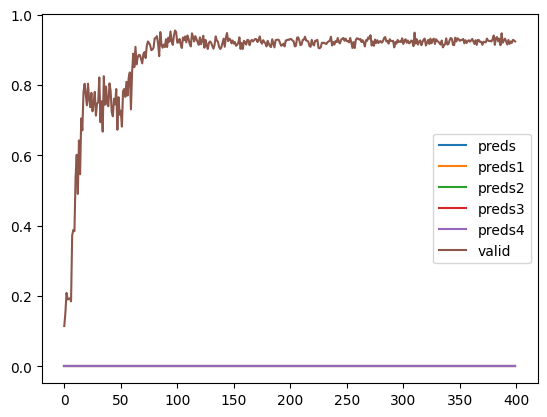

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.105


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:06<44:24,  6.68s/it]

valid-f1: 0.06767986907537023
valid-precision: 0.07286521540670128
valid-recall: 0.11745479641131813
process: 1  loss: 57.325690031051636  train_correct: 0.007958313595452392 valid_loss 82.89816784858704  val_correct: 0.10685663401602849
The model has been saved!!
The best val_acc is  0.10685663401602849
***训练集***
0.155


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:13<43:58,  6.63s/it]

valid-f1: 0.11342697272949982
valid-precision: 0.16091269976235986
valid-recall: 0.18007246376811595
process: 2  loss: 57.0174195766449  train_correct: 0.011747986736144007 valid_loss 82.73948264122009  val_correct: 0.18521816562778273
The model has been saved!!
The best val_acc is  0.18521816562778273
***训练集***
0.2375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:19<43:29,  6.57s/it]

valid-f1: 0.07217848795960101
valid-precision: 0.09027892467198825
valid-recall: 0.13911111111111113
process: 3  loss: 56.36372494697571  train_correct: 0.018000947418285174 valid_loss 81.49277639389038  val_correct: 0.15761353517364202
***训练集***
0.27375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [00:26<43:05,  6.53s/it]

valid-f1: 0.0420081891607607
valid-precision: 0.04098666419421136
valid-recall: 0.10902255639097744
process: 4  loss: 55.47387385368347  train_correct: 0.020748460445286596 valid_loss 78.54585421085358  val_correct: 0.14247551202137132
***训练集***
0.305


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [00:32<43:08,  6.55s/it]

valid-f1: 0.06037269306911839
valid-precision: 0.05732250042452527
valid-recall: 0.12969924812030076
process: 5  loss: 52.785940766334534  train_correct: 0.023117006158218854 valid_loss 77.14967462420464  val_correct: 0.1585040071237756
***训练集***
0.3525


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/400 [00:39<42:57,  6.54s/it]

valid-f1: 0.16878632874879995
valid-precision: 0.1364685781943072
valid-recall: 0.24519450800915332
process: 6  loss: 49.75701034069061  train_correct: 0.02671719564187589 valid_loss 68.16685262322426  val_correct: 0.346393588601959
The model has been saved!!
The best val_acc is  0.346393588601959
***训练集***
0.395


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [00:45<42:43,  6.52s/it]

valid-f1: 0.2080745422834469
valid-precision: 0.2658063233739275
valid-recall: 0.2766960880462025
process: 7  loss: 46.13681089878082  train_correct: 0.029938417811463763 valid_loss 71.71387653052807  val_correct: 0.29741763134461263
***训练集***
0.41125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/400 [00:52<42:42,  6.54s/it]

valid-f1: 0.2941516659111984
valid-precision: 0.30147042837241955
valid-recall: 0.35174530529221604
process: 8  loss: 43.72080194950104  train_correct: 0.031170061582188536 valid_loss 61.98058778047562  val_correct: 0.41139804096170973
The model has been saved!!
The best val_acc is  0.41139804096170973
***训练集***
0.4425


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [00:58<42:39,  6.55s/it]

valid-f1: 0.39692610040131265
valid-precision: 0.40655935193643683
valid-recall: 0.44089898659692706
process: 9  loss: 40.648237228393555  train_correct: 0.033538607295120794 valid_loss 48.14786785840988  val_correct: 0.5779162956366874
The model has been saved!!
The best val_acc is  0.5779162956366874
***训练集***
0.52375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▎         | 10/400 [01:05<42:28,  6.53s/it]

valid-f1: 0.3657243868536977
valid-precision: 0.34109085403627937
valid-recall: 0.44933202571646513
process: 10  loss: 35.568987250328064  train_correct: 0.039696826148744674 valid_loss 52.28690318763256  val_correct: 0.5031166518254675
***训练集***
0.515


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 11/400 [01:12<42:22,  6.54s/it]

valid-f1: 0.3373617365519226
valid-precision: 0.4156730729859658
valid-recall: 0.39289895027423627
process: 11  loss: 34.878756523132324  train_correct: 0.03903363334912364 valid_loss 50.17163401097059  val_correct: 0.44879786286731965
***训练集***
0.55


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/400 [01:18<42:10,  6.52s/it]

valid-f1: 0.48977232906713797
valid-precision: 0.5046831733497511
valid-recall: 0.5709193273037666
process: 12  loss: 32.05021691322327  train_correct: 0.04168640454760777 valid_loss 49.02978600561619  val_correct: 0.5485307212822796
***训练集***
0.63875


  3%|▎         | 13/400 [01:24<41:56,  6.50s/it]

valid-f1: 0.5236522140978618
valid-precision: 0.6075152213956185
valid-recall: 0.5526690309436304
process: 13  loss: 29.048040091991425  train_correct: 0.048413074372335385 valid_loss 40.42832565307617  val_correct: 0.5387355298308103
***训练集***
0.63375


  4%|▎         | 14/400 [01:31<42:09,  6.55s/it]

valid-f1: 0.5505567055856091
valid-precision: 0.6549391486834851
valid-recall: 0.5619512120221503
process: 14  loss: 27.552977442741394  train_correct: 0.048034107058266225 valid_loss 39.5735622048378  val_correct: 0.5877114870881567
The model has been saved!!
The best val_acc is  0.5877114870881567
***训练集***
0.65625


  4%|▍         | 15/400 [01:38<42:01,  6.55s/it]

valid-f1: 0.5858299163709642
valid-precision: 0.6156163312988929
valid-recall: 0.5908349199745081
process: 15  loss: 26.417946457862854  train_correct: 0.04973945997157745 valid_loss 38.59665834903717  val_correct: 0.6108637577916296
The model has been saved!!
The best val_acc is  0.6108637577916296
***训练集***
0.6975


  4%|▍         | 16/400 [01:44<41:54,  6.55s/it]

valid-f1: 0.6261304109518664
valid-precision: 0.7134811869952105
valid-recall: 0.6266864097001397
process: 16  loss: 23.93915605545044  train_correct: 0.05286594031264803 valid_loss 37.59990318119526  val_correct: 0.6500445235975066
The model has been saved!!
The best val_acc is  0.6500445235975066
***训练集***
0.74125


  4%|▍         | 17/400 [01:51<41:39,  6.53s/it]

valid-f1: 0.6139638442514409
valid-precision: 0.7559787506550308
valid-recall: 0.6267503937709888
process: 17  loss: 21.324346780776978  train_correct: 0.0561819043107532 valid_loss 38.131928354501724  val_correct: 0.6420302760463046
***训练集***
0.725


  4%|▍         | 18/400 [01:57<41:32,  6.53s/it]

valid-f1: 0.6950230620103224
valid-precision: 0.7936851670386434
valid-recall: 0.698686092702111
process: 18  loss: 22.126714408397675  train_correct: 0.054950260540028426 valid_loss 30.837028017267585  val_correct: 0.686553873552983
The model has been saved!!
The best val_acc is  0.686553873552983
***训练集***
0.75375


  5%|▍         | 19/400 [02:04<41:33,  6.55s/it]

valid-f1: 0.5890330709187512
valid-precision: 0.6441581003157716
valid-recall: 0.6207184331051607
process: 19  loss: 19.9876306951046  train_correct: 0.0571293225959261 valid_loss 35.44448695331812  val_correct: 0.6438112199465716
***训练集***
0.7375


  5%|▌         | 20/400 [02:10<41:35,  6.57s/it]

valid-f1: 0.7702288139487505
valid-precision: 0.8466122054385268
valid-recall: 0.7475954279638489
process: 20  loss: 20.50749272108078  train_correct: 0.05589767882520132 valid_loss 29.530692860484123  val_correct: 0.7756010685663401
The model has been saved!!
The best val_acc is  0.7756010685663401
***训练集***
0.7525


  5%|▌         | 21/400 [02:17<41:15,  6.53s/it]

valid-f1: 0.6522684591671435
valid-precision: 0.7324461290140054
valid-recall: 0.693197545906928
process: 21  loss: 19.34135004878044  train_correct: 0.05703458076740881 valid_loss 32.38698495924473  val_correct: 0.655387355298308
***训练集***
0.7575


  6%|▌         | 22/400 [02:23<41:01,  6.51s/it]

valid-f1: 0.7143557023637548
valid-precision: 0.7756128462759093
valid-recall: 0.7529066605908711
process: 22  loss: 18.988465636968613  train_correct: 0.05741354808147797 valid_loss 28.184202395379543  val_correct: 0.7088156723063224
***训练集***
0.80125


  6%|▌         | 23/400 [02:30<40:53,  6.51s/it]

valid-f1: 0.7198584081764292
valid-precision: 0.7686449468200152
valid-recall: 0.7342103975353405
process: 23  loss: 16.55587974190712  train_correct: 0.06072951207958314 valid_loss 31.44149937108159  val_correct: 0.7141585040071238
***训练集***
0.7825


  6%|▌         | 24/400 [02:36<40:52,  6.52s/it]

valid-f1: 0.6765815788937644
valid-precision: 0.7725617649508616
valid-recall: 0.7128962557909926
process: 24  loss: 16.897467374801636  train_correct: 0.05930838465182378 valid_loss 37.1191017255187  val_correct: 0.6918967052537845
***训练集***
0.79


  6%|▋         | 25/400 [02:43<40:41,  6.51s/it]

valid-f1: 0.7154233050062642
valid-precision: 0.7721258278645944
valid-recall: 0.77478772689299
process: 25  loss: 17.49602961540222  train_correct: 0.059876835622927525 valid_loss 40.07719196379185  val_correct: 0.674087266251113
***训练集***
0.7875


  6%|▋         | 26/400 [02:49<40:36,  6.52s/it]

valid-f1: 0.8393802466255218
valid-precision: 0.8640615973674324
valid-recall: 0.8398377696547034
process: 26  loss: 16.39568004012108  train_correct: 0.05968735196589294 valid_loss 16.753120532259345  val_correct: 0.8530721282279609
The model has been saved!!
The best val_acc is  0.8530721282279609
***训练集***
0.7975


  7%|▋         | 27/400 [02:56<40:25,  6.50s/it]

valid-f1: 0.7942143985356254
valid-precision: 0.7952184617231963
valid-recall: 0.8264014119620529
process: 27  loss: 15.903144896030426  train_correct: 0.06044528659403126 valid_loss 25.216264840215445  val_correct: 0.8014247551202137
***训练集***
0.80875


  7%|▋         | 28/400 [03:02<40:14,  6.49s/it]

valid-f1: 0.7668678989046098
valid-precision: 0.8350489802900152
valid-recall: 0.7662981927810304
process: 28  loss: 14.676380425691605  train_correct: 0.061297963050686875 valid_loss 23.720136031508446  val_correct: 0.8014247551202137
***训练集***
0.79875


  7%|▋         | 29/400 [03:09<40:17,  6.52s/it]

valid-f1: 0.7678129295916565
valid-precision: 0.7862750949231068
valid-recall: 0.7982915688430563
process: 29  loss: 15.995798498392105  train_correct: 0.060540028422548554 valid_loss 21.571454677265137  val_correct: 0.755120213713268
***训练集***
0.81


  8%|▊         | 30/400 [03:15<40:02,  6.49s/it]

valid-f1: 0.8257078244220721
valid-precision: 0.8610835600856148
valid-recall: 0.8319082257686377
process: 30  loss: 16.001148849725723  train_correct: 0.06139270487920417 valid_loss 24.056132424622774  val_correct: 0.7978628673196795
***训练集***
0.81375


  8%|▊         | 31/400 [03:22<39:55,  6.49s/it]

valid-f1: 0.7512283746341587
valid-precision: 0.8120932668417856
valid-recall: 0.7432069270673389
process: 31  loss: 14.63250258564949  train_correct: 0.06167693036475604 valid_loss 28.714640903286636  val_correct: 0.7666963490650045
***训练集***
0.81875


  8%|▊         | 32/400 [03:28<39:46,  6.49s/it]

valid-f1: 0.7678929610152312
valid-precision: 0.7986923852606711
valid-recall: 0.8021439963545227
process: 32  loss: 13.768020540475845  train_correct: 0.0620558976788252 valid_loss 26.461737263947725  val_correct: 0.7693677649154052
***训练集***
0.81625


  8%|▊         | 33/400 [03:35<39:48,  6.51s/it]

valid-f1: 0.7443977709039815
valid-precision: 0.8300402312298415
valid-recall: 0.7520286949257201
process: 33  loss: 13.84448692202568  train_correct: 0.06186641402179062 valid_loss 26.715920352376997  val_correct: 0.773820124666073
***训练集***
0.84125


  8%|▊         | 34/400 [03:41<39:47,  6.52s/it]

valid-f1: 0.7814456242296348
valid-precision: 0.8182855714441392
valid-recall: 0.7942365300603286
process: 34  loss: 12.548296332359314  train_correct: 0.06376125059213643 valid_loss 25.49607165157795  val_correct: 0.7702582368655387
***训练集***
0.8375


  9%|▉         | 35/400 [03:48<39:46,  6.54s/it]

valid-f1: 0.8609726065127529
valid-precision: 0.8913303995247427
valid-recall: 0.8588063340168602
process: 35  loss: 13.441435843706131  train_correct: 0.06347702510658455 valid_loss 15.81074331747368  val_correct: 0.8584149599287623
The model has been saved!!
The best val_acc is  0.8584149599287623
***训练集***
0.8175


  9%|▉         | 36/400 [03:55<39:38,  6.53s/it]

valid-f1: 0.853741370177247
valid-precision: 0.8575779312751036
valid-recall: 0.8569166394246486
process: 36  loss: 14.008020132780075  train_correct: 0.06196115585030791 valid_loss 15.99131585471332  val_correct: 0.8601959038290294
The model has been saved!!
The best val_acc is  0.8601959038290294
***训练集***
0.84125


  9%|▉         | 37/400 [04:01<39:28,  6.53s/it]

valid-f1: 0.7809995481506217
valid-precision: 0.7851620949029422
valid-recall: 0.8023438206847817
process: 37  loss: 13.072870254516602  train_correct: 0.06376125059213643 valid_loss 22.221485547721386  val_correct: 0.7907390917186109
***训练集***
0.805


 10%|▉         | 38/400 [04:08<39:22,  6.53s/it]

valid-f1: 0.7991721422956275
valid-precision: 0.836554255396728
valid-recall: 0.8003579865341879
process: 38  loss: 15.42413505911827  train_correct: 0.06101373756513501 valid_loss 17.8074003867805  val_correct: 0.8130008904719501
***训练集***
0.8325


 10%|▉         | 39/400 [04:14<39:10,  6.51s/it]

valid-f1: 0.7791493267103423
valid-precision: 0.8140439859294611
valid-recall: 0.7912125240637826
process: 39  loss: 13.500867545604706  train_correct: 0.0630980577925154 valid_loss 23.430994083406404  val_correct: 0.7880676758682101
***训练集***
0.8475


 10%|█         | 40/400 [04:21<39:01,  6.50s/it]

valid-f1: 0.8005914714814674
valid-precision: 0.7997856085761035
valid-recall: 0.8386683077918777
process: 40  loss: 12.372093379497528  train_correct: 0.06423495973472287 valid_loss 21.413792733103037  val_correct: 0.7951914514692787
***训练集***
0.855


 10%|█         | 41/400 [04:27<38:52,  6.50s/it]

valid-f1: 0.7968429196733386
valid-precision: 0.8057765986235766
valid-recall: 0.8280541967567139
process: 41  loss: 11.324282586574554  train_correct: 0.06480341070582663 valid_loss 20.931814340874553  val_correct: 0.8174532502226179
***训练集***
0.8325


 10%|█         | 42/400 [04:34<38:44,  6.49s/it]

valid-f1: 0.8057914412396203
valid-precision: 0.8182979218368421
valid-recall: 0.8336528145132265
process: 42  loss: 13.50460559129715  train_correct: 0.0630980577925154 valid_loss 20.47444391064346  val_correct: 0.8014247551202137
***训练集***
0.85


 11%|█         | 43/400 [04:40<38:51,  6.53s/it]

valid-f1: 0.6893585736466756
valid-precision: 0.7663384915501493
valid-recall: 0.7307968207739375
process: 43  loss: 11.833417803049088  train_correct: 0.06442444339175746 valid_loss 33.8067577406764  val_correct: 0.661620658949243
***训练集***
0.8475


 11%|█         | 44/400 [04:47<38:39,  6.51s/it]

valid-f1: 0.8675983784408101
valid-precision: 0.867121449562244
valid-recall: 0.8795218811191351
process: 44  loss: 12.16943097114563  train_correct: 0.06423495973472287 valid_loss 16.681194558739662  val_correct: 0.8575244879786287
***训练集***
0.85625


 11%|█▏        | 45/400 [04:53<38:35,  6.52s/it]

valid-f1: 0.751245147280368
valid-precision: 0.8024582060321828
valid-recall: 0.7689075257313244
process: 45  loss: 11.990182369947433  train_correct: 0.06489815253434392 valid_loss 23.67810838110745  val_correct: 0.7640249332146037
***训练集***
0.85


 12%|█▏        | 46/400 [05:00<38:27,  6.52s/it]

valid-f1: 0.8019260466817775
valid-precision: 0.8077846398736439
valid-recall: 0.823436644972114
process: 46  loss: 11.589998304843903  train_correct: 0.06442444339175746 valid_loss 23.289373570121825  val_correct: 0.8032056990204809
***训练集***
0.845


 12%|█▏        | 47/400 [05:06<38:16,  6.50s/it]

valid-f1: 0.7763550356357068
valid-precision: 0.8499769437774866
valid-recall: 0.7722471098695356
process: 47  loss: 11.541003614664078  train_correct: 0.0640454760776883 valid_loss 21.1995423771441  val_correct: 0.798753339269813
***训练集***
0.8375


 12%|█▏        | 48/400 [05:13<38:16,  6.52s/it]

valid-f1: 0.7970392756002779
valid-precision: 0.8627310373450079
valid-recall: 0.7951934381408066
process: 48  loss: 12.562183111906052  train_correct: 0.06347702510658455 valid_loss 26.27606093324721  val_correct: 0.7836153161175423
***训练集***
0.84


 12%|█▏        | 49/400 [05:19<38:02,  6.50s/it]

valid-f1: 0.7842457340529628
valid-precision: 0.8143269951244541
valid-recall: 0.8243262504086303
process: 49  loss: 12.04343792796135  train_correct: 0.06366650876361914 valid_loss 28.531821286305785  val_correct: 0.7631344612644702
***训练集***
0.83375


 12%|█▎        | 50/400 [05:26<37:42,  6.47s/it]

valid-f1: 0.8457667277631169
valid-precision: 0.8524078583775131
valid-recall: 0.8640109892649936
process: 50  loss: 12.203266367316246  train_correct: 0.06319279962103269 valid_loss 17.193167433142662  val_correct: 0.8343722172751559
***训练集***
0.84125


 13%|█▎        | 51/400 [05:32<37:39,  6.47s/it]

valid-f1: 0.8386076020057163
valid-precision: 0.8599364726717621
valid-recall: 0.8434335872619625
process: 51  loss: 12.957468926906586  train_correct: 0.06376125059213643 valid_loss 17.128815253265202  val_correct: 0.8343722172751559
***训练集***
0.85875


 13%|█▎        | 52/400 [05:38<37:32,  6.47s/it]

valid-f1: 0.8106565123478002
valid-precision: 0.8273292321590432
valid-recall: 0.8290914341188941
process: 52  loss: 11.314427867531776  train_correct: 0.06508763619137849 valid_loss 18.829143226146698  val_correct: 0.8147818343722173
***训练集***
0.875


 13%|█▎        | 53/400 [05:45<37:35,  6.50s/it]

valid-f1: 0.8437085846122722
valid-precision: 0.8546380786490486
valid-recall: 0.8598767141833502
process: 53  loss: 10.296780973672867  train_correct: 0.06631927996210327 valid_loss 18.77256122464314  val_correct: 0.8388245770258237
***训练集***
0.8775


 14%|█▎        | 54/400 [05:52<37:28,  6.50s/it]

valid-f1: 0.7337125802520504
valid-precision: 0.792279593154308
valid-recall: 0.7541393734666046
process: 54  loss: 10.343842566013336  train_correct: 0.06650876361913785 valid_loss 27.292332138866186  val_correct: 0.7310774710596616
***训练集***
0.8475


 14%|█▍        | 55/400 [05:58<37:21,  6.50s/it]

valid-f1: 0.8631160919025955
valid-precision: 0.87205837754044
valid-recall: 0.8720388784873911
process: 55  loss: 10.446270227432251  train_correct: 0.06423495973472287 valid_loss 12.707819404779002  val_correct: 0.8664292074799644
The model has been saved!!
The best val_acc is  0.8664292074799644
***训练集***
0.855


 14%|█▍        | 56/400 [06:04<37:10,  6.48s/it]

valid-f1: 0.788676328451971
valid-precision: 0.8465310324258659
valid-recall: 0.7912991767957444
process: 56  loss: 10.885783910751343  train_correct: 0.06480341070582663 valid_loss 23.149404139257967  val_correct: 0.7756010685663401
***训练集***
0.8525


 14%|█▍        | 57/400 [06:11<36:54,  6.46s/it]

valid-f1: 0.7207870627742675
valid-precision: 0.8171975030914711
valid-recall: 0.7363208185153265
process: 57  loss: 11.063766703009605  train_correct: 0.06461392704879204 valid_loss 26.964980375021696  val_correct: 0.6981300089047195
***训练集***
0.86


 14%|█▍        | 58/400 [06:17<36:56,  6.48s/it]

valid-f1: 0.8574130713049921
valid-precision: 0.8801059607649547
valid-recall: 0.8684961250293057
process: 58  loss: 10.53414735198021  train_correct: 0.06518237801989578 valid_loss 18.932593101169914  val_correct: 0.8619768477292965
***训练集***
0.86


 15%|█▍        | 59/400 [06:24<36:51,  6.49s/it]

valid-f1: 0.8235123796722915
valid-precision: 0.8320129465745122
valid-recall: 0.837658381791105
process: 59  loss: 10.144469529390335  train_correct: 0.06518237801989578 valid_loss 19.615960570052266  val_correct: 0.8138913624220837
***训练集***
0.875


 15%|█▌        | 60/400 [06:30<36:52,  6.51s/it]

valid-f1: 0.7486670654769374
valid-precision: 0.8310977427145273
valid-recall: 0.7528752216509653
process: 60  loss: 9.842955827713013  train_correct: 0.06631927996210327 valid_loss 29.736358489841223  val_correct: 0.7417631344612645
***训练集***
0.86625


 15%|█▌        | 61/400 [06:37<36:41,  6.50s/it]

valid-f1: 0.8357564242109066
valid-precision: 0.8221925868694695
valid-recall: 0.8647486205632658
process: 61  loss: 10.826230056583881  train_correct: 0.06565608716248224 valid_loss 16.35799476504326  val_correct: 0.8263579697239537
***训练集***
0.865


 16%|█▌        | 62/400 [06:43<36:39,  6.51s/it]

valid-f1: 0.7289937672264443
valid-precision: 0.7913639183539146
valid-recall: 0.7534012567651012
process: 62  loss: 10.365811005234718  train_correct: 0.06556134533396495 valid_loss 31.18903499469161  val_correct: 0.7088156723063224
***训练集***
0.86


 16%|█▌        | 63/400 [06:50<36:29,  6.50s/it]

valid-f1: 0.8185698426565724
valid-precision: 0.8407842168957778
valid-recall: 0.8409452517987986
process: 63  loss: 10.752028465270996  train_correct: 0.06518237801989578 valid_loss 20.190432691946626  val_correct: 0.8219056099732859
***训练集***
0.87375
开始蒸馏


 16%|█▌        | 64/400 [06:56<36:17,  6.48s/it]

valid-f1: 0.7651281247810422
valid-precision: 0.8053535852066837
valid-recall: 0.7870835586991193
process: 64  loss: 10.299921244382858  train_correct: 0.06622453813358598 valid_loss 21.574882119894028  val_correct: 0.7756010685663401
***训练集***
0.7925


 16%|█▋        | 65/400 [07:03<36:08,  6.47s/it]

valid-f1: 0.832012180091714
valid-precision: 0.880408789991083
valid-recall: 0.8398033951809696
process: 65  loss: 1145.6923332214355  train_correct: 0.0600663192799621 valid_loss 21.562174464925192  val_correct: 0.8352626892252895
***训练集***
0.7775


 16%|█▋        | 66/400 [07:09<35:52,  6.45s/it]

valid-f1: 0.8143667563034551
valid-precision: 0.8620915486395313
valid-recall: 0.8104267850125974
process: 66  loss: 714.0631332397461  train_correct: 0.05892941733775462 valid_loss 16.867584941443056  val_correct: 0.8352626892252895
***训练集***
0.79875


 17%|█▋        | 67/400 [07:16<35:58,  6.48s/it]

valid-f1: 0.7622315485463611
valid-precision: 0.8462687733088933
valid-recall: 0.766092827589395
process: 67  loss: 557.0107326507568  train_correct: 0.060540028422548554 valid_loss 27.639012666244525  val_correct: 0.7453250222617988
***训练集***
0.80125


 17%|█▋        | 68/400 [07:22<35:50,  6.48s/it]

valid-f1: 0.8550642001740962
valid-precision: 0.9007314786243192
valid-recall: 0.8417555086662638
process: 68  loss: 490.6488094329834  train_correct: 0.06072951207958314 valid_loss 12.138471518024744  val_correct: 0.8628673196794301
***训练集***
0.81875


 17%|█▋        | 69/400 [07:29<35:49,  6.49s/it]

valid-f1: 0.8969429648431019
valid-precision: 0.9290975246952595
valid-recall: 0.8860156286632259
process: 69  loss: 462.96448612213135  train_correct: 0.0620558976788252 valid_loss 11.87284073108458  val_correct: 0.9065004452359751
The model has been saved!!
The best val_acc is  0.9065004452359751
***训练集***
0.8275


 18%|█▊        | 70/400 [07:35<35:40,  6.49s/it]

valid-f1: 0.8703458171462375
valid-precision: 0.8841935313900701
valid-recall: 0.8766083852582709
process: 70  loss: 405.75490856170654  train_correct: 0.06271909047844623 valid_loss 13.642827461131674  val_correct: 0.8628673196794301
***训练集***
0.81375


 18%|█▊        | 71/400 [07:42<35:42,  6.51s/it]

valid-f1: 0.8990603079141575
valid-precision: 0.9103657312516237
valid-recall: 0.9075944868759513
process: 71  loss: 392.27304553985596  train_correct: 0.06167693036475604 valid_loss 14.92885598736757  val_correct: 0.9127337488869101
The model has been saved!!
The best val_acc is  0.9127337488869101
***训练集***
0.8625


 18%|█▊        | 72/400 [07:48<35:45,  6.54s/it]

valid-f1: 0.9046348742881835
valid-precision: 0.9086530183685972
valid-recall: 0.9165853731826271
process: 72  loss: 382.29613876342773  train_correct: 0.06537186167693036 valid_loss 12.638168748446333  val_correct: 0.8931433659839715
***训练集***
0.835


 18%|█▊        | 73/400 [07:55<35:33,  6.52s/it]

valid-f1: 0.9195378938860219
valid-precision: 0.9188883286217523
valid-recall: 0.93459947629284
process: 73  loss: 373.37750148773193  train_correct: 0.06328754144954997 valid_loss 9.607081669011677  val_correct: 0.9073909171861086
***训练集***
0.85375


 18%|█▊        | 74/400 [08:01<35:29,  6.53s/it]

valid-f1: 0.9266577977296084
valid-precision: 0.9247753574188154
valid-recall: 0.9384204912809032
process: 74  loss: 350.7862939834595  train_correct: 0.06470866887730933 valid_loss 9.208277370373168  val_correct: 0.9207479964381122
The model has been saved!!
The best val_acc is  0.9207479964381122
***训练集***
0.8675


 19%|█▉        | 75/400 [08:08<35:16,  6.51s/it]

valid-f1: 0.9117381758123113
valid-precision: 0.9133713530207679
valid-recall: 0.9180939502907467
process: 75  loss: 330.9684762954712  train_correct: 0.06575082899099953 valid_loss 8.6836810892637  val_correct: 0.9038290293855743
***训练集***
0.865


 19%|█▉        | 76/400 [08:14<35:03,  6.49s/it]

valid-f1: 0.8747842334354008
valid-precision: 0.8834453549329655
valid-recall: 0.878092140760333
process: 76  loss: 323.4045925140381  train_correct: 0.06556134533396495 valid_loss 11.926445387135573  val_correct: 0.8717720391807658
***训练集***
0.86375


 19%|█▉        | 77/400 [08:21<35:07,  6.53s/it]

valid-f1: 0.9264334347696618
valid-precision: 0.9250659963682825
valid-recall: 0.9404255038122316
process: 77  loss: 316.131028175354  train_correct: 0.06546660350544765 valid_loss 9.353475816947707  val_correct: 0.918967052537845
***训练集***
0.855


 20%|█▉        | 78/400 [08:27<34:59,  6.52s/it]

valid-f1: 0.9063117819657078
valid-precision: 0.9128349622506103
valid-recall: 0.91079908929108
process: 78  loss: 311.89965534210205  train_correct: 0.06480341070582663 valid_loss 9.385465212229974  val_correct: 0.9082813891362422
***训练集***
0.85125


 20%|█▉        | 79/400 [08:34<34:45,  6.50s/it]

valid-f1: 0.9163460556425445
valid-precision: 0.9152726161521368
valid-recall: 0.9260635382923711
process: 79  loss: 301.25529193878174  train_correct: 0.06451918522027475 valid_loss 9.419294913714566  val_correct: 0.9154051647373108
***训练集***
0.855


 20%|██        | 80/400 [08:40<34:43,  6.51s/it]

valid-f1: 0.9382220061913632
valid-precision: 0.940872051280737
valid-recall: 0.944570160579314
process: 80  loss: 301.0577726364136  train_correct: 0.06480341070582663 valid_loss 10.553233232016282  val_correct: 0.9412288512911843
The model has been saved!!
The best val_acc is  0.9412288512911843
***训练集***
0.87875


 20%|██        | 81/400 [08:47<34:29,  6.49s/it]

valid-f1: 0.9108631573230888
valid-precision: 0.9124661946580883
valid-recall: 0.9188247826417163
process: 81  loss: 288.00975227355957  train_correct: 0.06660350544765514 valid_loss 9.505171774340852  val_correct: 0.9011576135351737
***训练集***
0.85875


 20%|██        | 82/400 [08:54<34:33,  6.52s/it]

valid-f1: 0.9160466135568275
valid-precision: 0.9141342637459102
valid-recall: 0.930499172833269
process: 82  loss: 294.7354736328125  train_correct: 0.06508763619137849 valid_loss 8.679113635840622  val_correct: 0.9136242208370436
***训练集***
0.87625


 21%|██        | 83/400 [09:00<34:22,  6.51s/it]

valid-f1: 0.9252834378183857
valid-precision: 0.9308711760819612
valid-recall: 0.9290236427696381
process: 83  loss: 280.1257791519165  train_correct: 0.06641402179062056 valid_loss 10.260968135022267  val_correct: 0.9305431878895815
***训练集***
0.87375


 21%|██        | 84/400 [09:06<34:11,  6.49s/it]

valid-f1: 0.9188832365204094
valid-precision: 0.9227904614877556
valid-recall: 0.9272491769608473
process: 84  loss: 274.4434337615967  train_correct: 0.06622453813358598 valid_loss 9.51168458218126  val_correct: 0.9145146927871772
***训练集***
0.8625


 21%|██▏       | 85/400 [09:13<34:03,  6.49s/it]

valid-f1: 0.9103972610249038
valid-precision: 0.9068592099492457
valid-recall: 0.9231365634111629
process: 85  loss: 281.21068382263184  train_correct: 0.06537186167693036 valid_loss 8.195993538147377  val_correct: 0.9091718610863758
***训练集***
0.86


 22%|██▏       | 86/400 [09:19<33:59,  6.49s/it]

valid-f1: 0.9351015604889759
valid-precision: 0.9342538352120394
valid-recall: 0.9436298255520222
process: 86  loss: 272.4411211013794  train_correct: 0.06518237801989578 valid_loss 8.758505744682878  val_correct: 0.9403383793410508
***训练集***
0.89875


 22%|██▏       | 87/400 [09:26<34:05,  6.54s/it]

valid-f1: 0.9405713464385604
valid-precision: 0.9389601796285089
valid-recall: 0.9474391743522178
process: 87  loss: 266.23116874694824  train_correct: 0.06811937470393178 valid_loss 7.474544246592416  val_correct: 0.9465716829919858
The model has been saved!!
The best val_acc is  0.9465716829919858
***训练集***
0.8775


 22%|██▏       | 88/400 [09:33<33:54,  6.52s/it]

valid-f1: 0.9066169456448204
valid-precision: 0.9101440888674596
valid-recall: 0.9119647471775618
process: 88  loss: 270.44790744781494  train_correct: 0.06650876361913785 valid_loss 8.530169536102221  val_correct: 0.8958147818343722
***训练集***
0.88125


 22%|██▏       | 89/400 [09:39<33:45,  6.51s/it]

valid-f1: 0.9281305975445981
valid-precision: 0.9402442343400154
valid-recall: 0.9251681047150153
process: 89  loss: 265.3716039657593  train_correct: 0.06679298910468973 valid_loss 6.994536823224443  val_correct: 0.931433659839715
***训练集***
0.8925


 22%|██▎       | 90/400 [09:46<33:33,  6.49s/it]

valid-f1: 0.9250771667781207
valid-precision: 0.9195607324361639
valid-recall: 0.938223027925545
process: 90  loss: 253.12883377075195  train_correct: 0.06764566556134534 valid_loss 7.969178001843829  val_correct: 0.9278717720391808
***训练集***
0.88


 23%|██▎       | 91/400 [09:52<33:31,  6.51s/it]

valid-f1: 0.9292768512037934
valid-precision: 0.9236371171304631
valid-recall: 0.9418571131385776
process: 91  loss: 255.1957302093506  train_correct: 0.06669824727617243 valid_loss 7.707342960865617  val_correct: 0.9296527159394479
***训练集***
0.84875


 23%|██▎       | 92/400 [09:59<33:22,  6.50s/it]

valid-f1: 0.9233362688536157
valid-precision: 0.923409343280127
valid-recall: 0.935957872282815
process: 92  loss: 253.42935037612915  train_correct: 0.06432970156324017 valid_loss 8.200640774203748  val_correct: 0.9171861086375779
***训练集***
0.87


 23%|██▎       | 93/400 [10:05<33:11,  6.49s/it]

valid-f1: 0.9176743645530031
valid-precision: 0.9177257096987406
valid-recall: 0.9306814466997533
process: 93  loss: 253.37936353683472  train_correct: 0.06594031264803411 valid_loss 9.971687328217968  val_correct: 0.9091718610863758
***训练集***
0.8975


 24%|██▎       | 94/400 [10:11<33:01,  6.47s/it]

valid-f1: 0.9249845727041068
valid-precision: 0.9233256501561098
valid-recall: 0.9374825403429522
process: 94  loss: 242.24160289764404  train_correct: 0.06802463287541449 valid_loss 9.72133927680261  val_correct: 0.9207479964381122
***训练集***
0.87625


 24%|██▍       | 95/400 [10:18<32:50,  6.46s/it]

valid-f1: 0.9167768847007537
valid-precision: 0.914888974138577
valid-recall: 0.9320149847609802
process: 95  loss: 238.9032917022705  train_correct: 0.06641402179062056 valid_loss 10.402545974080567  val_correct: 0.9073909171861086
***训练集***
0.88875


 24%|██▍       | 96/400 [10:24<32:55,  6.50s/it]

valid-f1: 0.9181194616444609
valid-precision: 0.9139232951592762
valid-recall: 0.9336996972008412
process: 96  loss: 256.77104663848877  train_correct: 0.06736144007579346 valid_loss 10.250036782525399  val_correct: 0.9171861086375779
***训练集***
0.88875
开始蒸馏


 24%|██▍       | 97/400 [10:31<32:52,  6.51s/it]

valid-f1: 0.9387119772416715
valid-precision: 0.9365476539228423
valid-recall: 0.9483847959820499
process: 97  loss: 239.9181923866272  train_correct: 0.06736144007579346 valid_loss 8.538227399030347  val_correct: 0.9447907390917186
***训练集***
0.88375


 24%|██▍       | 98/400 [10:37<32:42,  6.50s/it]

valid-f1: 0.9202174097005115
valid-precision: 0.9223222969065239
valid-recall: 0.9339079219788602
process: 98  loss: 238.07603883743286  train_correct: 0.0669824727617243 valid_loss 9.906974515841739  val_correct: 0.9091718610863758
***训练集***
0.9125


 25%|██▍       | 99/400 [10:44<32:30,  6.48s/it]

valid-f1: 0.9397134738168506
valid-precision: 0.9385075236373259
valid-recall: 0.9500670318748122
process: 99  loss: 236.06044816970825  train_correct: 0.06916153481762198 valid_loss 7.604731963703898  val_correct: 0.9385574354407836
***训练集***
0.90625


 25%|██▌       | 100/400 [10:50<32:24,  6.48s/it]

valid-f1: 0.9257176862761843
valid-precision: 0.9268894331603967
valid-recall: 0.9400274401418566
process: 100  loss: 230.99008417129517  train_correct: 0.06868782567503552 valid_loss 10.267067441958716  val_correct: 0.9127337488869101
***训练集***
0.88125


 25%|██▌       | 101/400 [10:57<32:19,  6.49s/it]

valid-f1: 0.9337940701855872
valid-precision: 0.9281670955066964
valid-recall: 0.9460310856191864
process: 101  loss: 231.11329174041748  train_correct: 0.06679298910468973 valid_loss 8.446815859035041  val_correct: 0.9367764915405165
***训练集***
0.87625


 26%|██▌       | 102/400 [11:03<32:13,  6.49s/it]

valid-f1: 0.9246703591570867
valid-precision: 0.9172751587859593
valid-recall: 0.9403071248609006
process: 102  loss: 238.67319917678833  train_correct: 0.06641402179062056 valid_loss 8.112112923550512  val_correct: 0.9198575244879786
***训练集***
0.9025


 26%|██▌       | 103/400 [11:10<32:05,  6.48s/it]

valid-f1: 0.9265328212531218
valid-precision: 0.9267102474510253
valid-recall: 0.9400881980973514
process: 103  loss: 234.67367887496948  train_correct: 0.06840360018948366 valid_loss 11.072525823663  val_correct: 0.9162956366874443
***训练集***
0.88375


 26%|██▌       | 104/400 [11:16<31:57,  6.48s/it]

valid-f1: 0.9133473071750366
valid-precision: 0.9084741528364896
valid-recall: 0.9220534835111496
process: 104  loss: 226.29155206680298  train_correct: 0.0669824727617243 valid_loss 9.192269132901856  val_correct: 0.9162956366874443
***训练集***
0.895


 26%|██▋       | 105/400 [11:23<31:46,  6.46s/it]

valid-f1: 0.9261984017958014
valid-precision: 0.9261463876482626
valid-recall: 0.9405925881898423
process: 105  loss: 215.03660440444946  train_correct: 0.06783514921837991 valid_loss 9.08502473447561  val_correct: 0.9136242208370436
***训练集***
0.8875


 26%|██▋       | 106/400 [11:29<31:52,  6.51s/it]

valid-f1: 0.9417364808478021
valid-precision: 0.9379429654870515
valid-recall: 0.9490372835910593
process: 106  loss: 227.7184009552002  train_correct: 0.06726669824727617 valid_loss 8.220940123957462  val_correct: 0.9474621549421193
The model has been saved!!
The best val_acc is  0.9474621549421193
***训练集***
0.8825


 27%|██▋       | 107/400 [11:36<31:47,  6.51s/it]

valid-f1: 0.9329739670709468
valid-precision: 0.926861976079028
valid-recall: 0.9438880468628751
process: 107  loss: 227.08388090133667  train_correct: 0.066887730933207 valid_loss 9.333016485197732  val_correct: 0.9394479073909172
***训练集***
0.88375


 27%|██▋       | 108/400 [11:42<31:41,  6.51s/it]

valid-f1: 0.94251850034004
valid-precision: 0.9401889695116179
valid-recall: 0.9504738460116033
process: 108  loss: 220.8648624420166  train_correct: 0.0669824727617243 valid_loss 6.331119810568907  val_correct: 0.9412288512911843
***训练集***
0.89
开始蒸馏


 27%|██▋       | 109/400 [11:49<31:30,  6.50s/it]

valid-f1: 0.9441642736828945
valid-precision: 0.9435095944719694
valid-recall: 0.95315809286061
process: 109  loss: 224.50258350372314  train_correct: 0.06745618190431076 valid_loss 7.922887558143714  val_correct: 0.9430097951914514
***训练集***
0.89625


 28%|██▊       | 110/400 [11:55<31:27,  6.51s/it]

valid-f1: 0.9428085770498699
valid-precision: 0.9421974877605213
valid-recall: 0.950667677097883
process: 110  loss: 210.49158143997192  train_correct: 0.0679298910468972 valid_loss 8.456360612647416  val_correct: 0.95013357079252
The model has been saved!!
The best val_acc is  0.95013357079252
***训练集***
0.89


 28%|██▊       | 111/400 [12:02<31:39,  6.57s/it]

valid-f1: 0.9486231715934672
valid-precision: 0.9475304499376401
valid-recall: 0.954667495484429
process: 111  loss: 212.30749702453613  train_correct: 0.06745618190431076 valid_loss 6.434130947773156  val_correct: 0.956366874443455
The model has been saved!!
The best val_acc is  0.956366874443455
***训练集***
0.90125


 28%|██▊       | 112/400 [12:09<31:23,  6.54s/it]

valid-f1: 0.9398446782204533
valid-precision: 0.9375918936778687
valid-recall: 0.9499113396138567
process: 112  loss: 211.30846452713013  train_correct: 0.06830885836096637 valid_loss 8.222221031386539  val_correct: 0.9430097951914514
***训练集***
0.885


 28%|██▊       | 113/400 [12:15<31:14,  6.53s/it]

valid-f1: 0.9313693543936878
valid-precision: 0.9302456273158978
valid-recall: 0.9428019984084056
process: 113  loss: 220.02423810958862  train_correct: 0.06707721459024159 valid_loss 8.153283506781463  val_correct: 0.9269813000890472
***训练集***
0.8775


 28%|██▊       | 114/400 [12:22<31:01,  6.51s/it]

valid-f1: 0.9312878881661781
valid-precision: 0.9285665056566165
valid-recall: 0.9407406857063607
process: 114  loss: 217.02005672454834  train_correct: 0.06650876361913785 valid_loss 8.266761459634154  val_correct: 0.9341050756901158
***训练集***
0.9075


 29%|██▉       | 115/400 [12:28<30:56,  6.51s/it]

valid-f1: 0.9202521315168937
valid-precision: 0.9161786833416737
valid-recall: 0.9354212276409072
process: 115  loss: 211.32932901382446  train_correct: 0.06878256750355281 valid_loss 9.816430781868121  val_correct: 0.9136242208370436
***训练集***
0.89375


 29%|██▉       | 116/400 [12:35<30:51,  6.52s/it]

valid-f1: 0.9138993974532579
valid-precision: 0.905161539124629
valid-recall: 0.9298339722824848
process: 116  loss: 206.245135307312  train_correct: 0.06774040738986263 valid_loss 8.997288930132072  val_correct: 0.9082813891362422
***训练集***
0.87875


 29%|██▉       | 117/400 [12:41<30:47,  6.53s/it]

valid-f1: 0.924600789055216
valid-precision: 0.920371276222552
valid-recall: 0.9389166559349625
process: 117  loss: 211.45901584625244  train_correct: 0.06660350544765514 valid_loss 8.33840334173999  val_correct: 0.918967052537845
***训练集***
0.90625


 30%|██▉       | 118/400 [12:48<30:41,  6.53s/it]

valid-f1: 0.930007030813995
valid-precision: 0.9313748941096616
valid-recall: 0.9404134810015817
process: 118  loss: 207.45397281646729  train_correct: 0.06868782567503552 valid_loss 8.736063458547733  val_correct: 0.9260908281389136
***训练集***
0.90625


 30%|██▉       | 119/400 [12:54<30:36,  6.53s/it]

valid-f1: 0.9479753176843035
valid-precision: 0.9456457093129611
valid-recall: 0.9545731918729631
process: 119  loss: 204.808931350708  train_correct: 0.06868782567503552 valid_loss 6.0878084052556005  val_correct: 0.9554764024933214
***训练集***
0.89


 30%|███       | 120/400 [13:01<30:42,  6.58s/it]

valid-f1: 0.9167968203333011
valid-precision: 0.9174610061409583
valid-recall: 0.9313390525061006
process: 120  loss: 206.95820999145508  train_correct: 0.06745618190431076 valid_loss 10.469103226098014  val_correct: 0.9073909171861086
***训练集***
0.92


 30%|███       | 121/400 [13:07<30:29,  6.56s/it]

valid-f1: 0.9289290969824886
valid-precision: 0.9239508041638638
valid-recall: 0.9388723785748956
process: 121  loss: 198.7675108909607  train_correct: 0.06972998578872572 valid_loss 8.95871659853151  val_correct: 0.9341050756901158
***训练集***
0.92


 30%|███       | 122/400 [13:14<30:16,  6.53s/it]

valid-f1: 0.944522587381741
valid-precision: 0.9424916933865093
valid-recall: 0.9519807423697582
process: 122  loss: 204.77588033676147  train_correct: 0.06972998578872572 valid_loss 6.136719030853783  val_correct: 0.9483526268922529
***训练集***
0.90125


 31%|███       | 123/400 [13:20<30:08,  6.53s/it]

valid-f1: 0.9362029544517372
valid-precision: 0.9338389941537738
valid-recall: 0.9468709652920181
process: 123  loss: 203.01449060440063  train_correct: 0.06830885836096637 valid_loss 8.599501564840466  val_correct: 0.93766696349065
***训练集***
0.89


 31%|███       | 124/400 [13:27<29:53,  6.50s/it]

valid-f1: 0.9254580486508599
valid-precision: 0.9233522576920692
valid-recall: 0.9374983902443856
process: 124  loss: 207.99736499786377  train_correct: 0.06745618190431076 valid_loss 9.021316598449403  val_correct: 0.9243098842386465
***训练集***
0.905


 31%|███▏      | 125/400 [13:33<29:54,  6.52s/it]

valid-f1: 0.9354579839536328
valid-precision: 0.9343998365708664
valid-recall: 0.9457646091513368
process: 125  loss: 182.9201102256775  train_correct: 0.06859308384651824 valid_loss 7.840208646266774  val_correct: 0.9349955476402493
***训练集***
0.8725


 32%|███▏      | 126/400 [13:40<29:51,  6.54s/it]

valid-f1: 0.9249984826898661
valid-precision: 0.9258951824662045
valid-recall: 0.9363319365607694
process: 126  loss: 199.5923457145691  train_correct: 0.06612979630506868 valid_loss 8.232491739844534  val_correct: 0.9207479964381122
***训练集***
0.8925


 32%|███▏      | 127/400 [13:46<29:38,  6.51s/it]

valid-f1: 0.9333918615386672
valid-precision: 0.93218824146858
valid-recall: 0.9431291568843057
process: 127  loss: 201.14197492599487  train_correct: 0.06764566556134534 valid_loss 8.744159412023691  val_correct: 0.9358860195903829
***训练集***
0.89625


 32%|███▏      | 128/400 [13:53<29:29,  6.50s/it]

valid-f1: 0.9454957161213187
valid-precision: 0.9461437112384055
valid-recall: 0.9525435789737848
process: 128  loss: 210.33023166656494  train_correct: 0.0679298910468972 valid_loss 6.980037204158279  val_correct: 0.95013357079252
***训练集***
0.87375


 32%|███▏      | 129/400 [13:59<29:22,  6.50s/it]

valid-f1: 0.9099790106424195
valid-precision: 0.9090507141279314
valid-recall: 0.9186241294936947
process: 129  loss: 199.73960399627686  train_correct: 0.06622453813358598 valid_loss 10.0322555057528  val_correct: 0.9091718610863758
***训练集***
0.90125


 32%|███▎      | 130/400 [14:06<29:22,  6.53s/it]

valid-f1: 0.9245229094959194
valid-precision: 0.9258505833115631
valid-recall: 0.9376945327746242
process: 130  loss: 198.15093183517456  train_correct: 0.06830885836096637 valid_loss 9.98258874079852  val_correct: 0.9118432769367765
***训练集***
0.9025


 33%|███▎      | 131/400 [14:13<29:16,  6.53s/it]

valid-f1: 0.930330361434201
valid-precision: 0.9281653206036733
valid-recall: 0.9415729706347555
process: 131  loss: 202.44702291488647  train_correct: 0.06840360018948366 valid_loss 9.409538880452601  val_correct: 0.9296527159394479
***训练集***
0.86875
开始蒸馏


 33%|███▎      | 132/400 [14:19<29:14,  6.55s/it]

valid-f1: 0.9458564696858138
valid-precision: 0.9424243660604766
valid-recall: 0.9542472782747382
process: 132  loss: 196.26749563217163  train_correct: 0.06584557081951682 valid_loss 7.1009759844937435  val_correct: 0.9528049866429208
***训练集***
0.8975


 33%|███▎      | 133/400 [14:26<29:01,  6.52s/it]

valid-f1: 0.923444231225562
valid-precision: 0.9230174003431252
valid-recall: 0.9344408451959939
process: 133  loss: 200.562922000885  train_correct: 0.06802463287541449 valid_loss 9.110635160672246  val_correct: 0.9216384683882458
***训练集***
0.90625


 34%|███▎      | 134/400 [14:32<28:50,  6.50s/it]

valid-f1: 0.9260308212974531
valid-precision: 0.9226032867411125
valid-recall: 0.9365104130550354
process: 134  loss: 201.3114242553711  train_correct: 0.06868782567503552 valid_loss 9.20261387206483  val_correct: 0.9225289403383793
***训练集***
0.90125


 34%|███▍      | 135/400 [14:39<28:47,  6.52s/it]

valid-f1: 0.9415374147426376
valid-precision: 0.9405186115794226
valid-recall: 0.94879425176908
process: 135  loss: 195.612566947937  train_correct: 0.06830885836096637 valid_loss 7.643257956479829  val_correct: 0.9492430988423864
***训练集***
0.8925


 34%|███▍      | 136/400 [14:45<28:35,  6.50s/it]

valid-f1: 0.9456685390714442
valid-precision: 0.9427182659637208
valid-recall: 0.9546504601424509
process: 136  loss: 200.21757173538208  train_correct: 0.06764566556134534 valid_loss 7.016801046338514  val_correct: 0.95013357079252
***训练集***
0.89375


 34%|███▍      | 137/400 [14:52<28:32,  6.51s/it]

valid-f1: 0.9376802379297804
valid-precision: 0.9359762292905366
valid-recall: 0.9484797302875106
process: 137  loss: 197.4033055305481  train_correct: 0.06774040738986263 valid_loss 8.552500050815524  val_correct: 0.93766696349065
***训练集***
0.90375


 34%|███▍      | 138/400 [14:58<28:24,  6.51s/it]

valid-f1: 0.9114217103828086
valid-precision: 0.9099795254042349
valid-recall: 0.9212018848174456
process: 138  loss: 194.17886924743652  train_correct: 0.06849834201800095 valid_loss 10.568328505840327  val_correct: 0.9056099732858415
***训练集***
0.90125


 35%|███▍      | 139/400 [15:05<28:17,  6.50s/it]

valid-f1: 0.9317962999520919
valid-precision: 0.9276037063243582
valid-recall: 0.9409950039789857
process: 139  loss: 192.90611743927002  train_correct: 0.06830885836096637 valid_loss 7.882754636652862  val_correct: 0.9349955476402493
***训练集***
0.87625


 35%|███▌      | 140/400 [15:11<28:13,  6.51s/it]

valid-f1: 0.9160112032968902
valid-precision: 0.9188265982383628
valid-recall: 0.9299232930811877
process: 140  loss: 202.65550422668457  train_correct: 0.06641402179062056 valid_loss 12.481790148962318  val_correct: 0.9065004452359751
***训练集***
0.90125


 35%|███▌      | 141/400 [15:18<28:10,  6.53s/it]

valid-f1: 0.9366777528999369
valid-precision: 0.936560758262055
valid-recall: 0.9431057881858796
process: 141  loss: 197.65019273757935  train_correct: 0.06830885836096637 valid_loss 9.154313451677353  val_correct: 0.9430097951914514
***训练集***
0.92875


 36%|███▌      | 142/400 [15:24<28:01,  6.52s/it]

valid-f1: 0.94426558008184
valid-precision: 0.9421731740094896
valid-recall: 0.9525587684626586
process: 142  loss: 189.4285454750061  train_correct: 0.07039317858834676 valid_loss 7.958910950605059  val_correct: 0.9536954585930543
***训练集***
0.90125


 36%|███▌      | 143/400 [15:31<27:55,  6.52s/it]

valid-f1: 0.9334053383565519
valid-precision: 0.9337571116470358
valid-recall: 0.9391171803025349
process: 143  loss: 185.1557264328003  train_correct: 0.06830885836096637 valid_loss 10.270516714663245  val_correct: 0.9394479073909172
***训练集***
0.9125


 36%|███▌      | 144/400 [15:37<27:53,  6.54s/it]

valid-f1: 0.9431237622300597
valid-precision: 0.9435839641408148
valid-recall: 0.9499921939235441
process: 144  loss: 182.1658787727356  train_correct: 0.06916153481762198 valid_loss 6.985464880341397  val_correct: 0.9465716829919858
***训练集***
0.8975


 36%|███▋      | 145/400 [15:44<27:48,  6.54s/it]

valid-f1: 0.9444294106810727
valid-precision: 0.9428895994359277
valid-recall: 0.9518404047008164
process: 145  loss: 184.61487674713135  train_correct: 0.06802463287541449 valid_loss 6.104144626045581  val_correct: 0.9519145146927872
***训练集***
0.89125


 36%|███▋      | 146/400 [15:50<27:39,  6.53s/it]

valid-f1: 0.9359192381863164
valid-precision: 0.9434877726835227
valid-recall: 0.9371934084222413
process: 146  loss: 181.80442142486572  train_correct: 0.06755092373282805 valid_loss 6.801656584858847  val_correct: 0.9412288512911843
***训练集***
0.8875


 37%|███▋      | 147/400 [15:57<27:28,  6.51s/it]

valid-f1: 0.9389063882050388
valid-precision: 0.9389101498397766
valid-recall: 0.9453728194002793
process: 147  loss: 179.51182651519775  train_correct: 0.06726669824727617 valid_loss 7.390696795702752  val_correct: 0.9447907390917186
***训练集***
0.87875


 37%|███▋      | 148/400 [16:03<27:20,  6.51s/it]

valid-f1: 0.9395500782950986
valid-precision: 0.9403131725608669
valid-recall: 0.9447532170346815
process: 148  loss: 182.45307397842407  train_correct: 0.06660350544765514 valid_loss 8.040574092387033  val_correct: 0.9483526268922529
***训练集***
0.89


 37%|███▋      | 149/400 [16:10<27:25,  6.56s/it]

valid-f1: 0.9488916484034435
valid-precision: 0.9487095792730255
valid-recall: 0.9552909249408105
process: 149  loss: 188.03103351593018  train_correct: 0.06745618190431076 valid_loss 7.1024516803092865  val_correct: 0.9581478183437222
The model has been saved!!
The best val_acc is  0.9581478183437222
***训练集***
0.90875


 38%|███▊      | 150/400 [16:17<27:25,  6.58s/it]

valid-f1: 0.9506740448754826
valid-precision: 0.950743434514653
valid-recall: 0.9574301366063379
process: 150  loss: 174.18602228164673  train_correct: 0.0688773093320701 valid_loss 7.014253723541515  val_correct: 0.9590382902938558
The model has been saved!!
The best val_acc is  0.9590382902938558
***训练集***
0.8925


 38%|███▊      | 151/400 [16:23<27:12,  6.56s/it]

valid-f1: 0.9434651047766716
valid-precision: 0.9413420009968225
valid-recall: 0.9523561869099625
process: 151  loss: 182.668541431427  train_correct: 0.06764566556134534 valid_loss 6.763099940585562  val_correct: 0.9456812110418522
***训练集***
0.89375
开始蒸馏


 38%|███▊      | 152/400 [16:30<27:02,  6.54s/it]

valid-f1: 0.9411924578466865
valid-precision: 0.9389834469175193
valid-recall: 0.9515435492552197
process: 152  loss: 175.03151845932007  train_correct: 0.06774040738986263 valid_loss 6.389957088266328  val_correct: 0.9412288512911843
***训练集***
0.8925


 38%|███▊      | 153/400 [16:36<26:46,  6.51s/it]

valid-f1: 0.9400988461523452
valid-precision: 0.9393744342786553
valid-recall: 0.9491094336632093
process: 153  loss: 183.1744828224182  train_correct: 0.06764566556134534 valid_loss 7.958365283876219  val_correct: 0.943900267141585
***训练集***
0.89625


 38%|███▊      | 154/400 [16:43<26:48,  6.54s/it]

valid-f1: 0.9486525800113965
valid-precision: 0.9495610723235203
valid-recall: 0.955190347410027
process: 154  loss: 184.0055456161499  train_correct: 0.0679298910468972 valid_loss 7.968751823083267  val_correct: 0.9572573463935886
***训练集***
0.89125


 39%|███▉      | 155/400 [16:49<26:35,  6.51s/it]

valid-f1: 0.9453530361738262
valid-precision: 0.9440508379434629
valid-recall: 0.9518290125841613
process: 155  loss: 188.46422910690308  train_correct: 0.06755092373282805 valid_loss 6.6893510703942525  val_correct: 0.9554764024933214
***训练集***
0.905


 39%|███▉      | 156/400 [16:56<26:28,  6.51s/it]

valid-f1: 0.9448845847533469
valid-precision: 0.942218259743781
valid-recall: 0.952261252604502
process: 156  loss: 192.56589078903198  train_correct: 0.06859308384651824 valid_loss 6.500667021526169  val_correct: 0.9554764024933214
***训练集***
0.90125


 39%|███▉      | 157/400 [17:02<26:24,  6.52s/it]

valid-f1: 0.946358182972528
valid-precision: 0.9450447278590856
valid-recall: 0.9528960741775385
process: 157  loss: 182.37522983551025  train_correct: 0.06830885836096637 valid_loss 6.100002259302528  val_correct: 0.9572573463935886
***训练集***
0.89625


 40%|███▉      | 158/400 [17:09<26:17,  6.52s/it]

valid-f1: 0.9222865758750768
valid-precision: 0.9183313422388688
valid-recall: 0.9313472019970875
process: 158  loss: 187.95989084243774  train_correct: 0.0679298910468972 valid_loss 9.245219806853129  val_correct: 0.9287622439893143
***训练集***
0.89875


 40%|███▉      | 159/400 [17:15<26:18,  6.55s/it]

valid-f1: 0.9357682928572055
valid-precision: 0.9361896099184385
valid-recall: 0.9412177578333185
process: 159  loss: 186.43127918243408  train_correct: 0.06811937470393178 valid_loss 7.717150420165126  val_correct: 0.9403383793410508
***训练集***
0.8975


 40%|████      | 160/400 [17:22<26:08,  6.53s/it]

valid-f1: 0.9351392018934666
valid-precision: 0.9330883220653503
valid-recall: 0.9422734570286059
process: 160  loss: 187.55609560012817  train_correct: 0.06802463287541449 valid_loss 8.020786851262528  val_correct: 0.9447907390917186
***训练集***
0.9175


 40%|████      | 161/400 [17:28<25:57,  6.52s/it]

valid-f1: 0.9225721812647418
valid-precision: 0.9220699107345871
valid-recall: 0.9363819628121688
process: 161  loss: 175.40111351013184  train_correct: 0.06954050213169115 valid_loss 10.002088571009153  val_correct: 0.9162956366874443
***训练集***
0.9075


 40%|████      | 162/400 [17:35<25:45,  6.50s/it]

valid-f1: 0.928957121816899
valid-precision: 0.926295984689248
valid-recall: 0.9378901799954432
process: 162  loss: 180.47309732437134  train_correct: 0.06878256750355281 valid_loss 9.322567190506561  val_correct: 0.9403383793410508
***训练集***
0.905


 41%|████      | 163/400 [17:41<25:41,  6.50s/it]

valid-f1: 0.9329697864402101
valid-precision: 0.9284542671846234
valid-recall: 0.9426956719862897
process: 163  loss: 188.1232705116272  train_correct: 0.06859308384651824 valid_loss 6.821519654712574  val_correct: 0.93766696349065
***训练集***
0.89125


 41%|████      | 164/400 [17:48<25:42,  6.54s/it]

valid-f1: 0.9355154636545538
valid-precision: 0.9326033494433575
valid-recall: 0.9424526401643105
process: 164  loss: 184.98615884780884  train_correct: 0.06755092373282805 valid_loss 6.967706412487701  val_correct: 0.943900267141585
***训练集***
0.9125


 41%|████▏     | 165/400 [17:54<25:36,  6.54s/it]

valid-f1: 0.9360836466276954
valid-precision: 0.9328508028514919
valid-recall: 0.9437513414630118
process: 165  loss: 171.88593578338623  train_correct: 0.06916153481762198 valid_loss 7.085417103320424  val_correct: 0.943900267141585
***训练集***
0.89375


 42%|████▏     | 166/400 [18:01<25:30,  6.54s/it]

valid-f1: 0.9386590316325918
valid-precision: 0.9393078303534607
valid-recall: 0.9441880392681308
process: 166  loss: 173.8206901550293  train_correct: 0.06774040738986263 valid_loss 9.882428249994973  val_correct: 0.9483526268922529
***训练集***
0.9125


 42%|████▏     | 167/400 [18:07<25:17,  6.51s/it]

valid-f1: 0.9415048023136607
valid-precision: 0.9422726414009583
valid-recall: 0.9469044052819797
process: 167  loss: 183.1365842819214  train_correct: 0.06916153481762198 valid_loss 8.29272449666405  val_correct: 0.9519145146927872
***训练集***
0.9075


 42%|████▏     | 168/400 [18:14<25:11,  6.51s/it]

valid-f1: 0.9453159779123063
valid-precision: 0.9453880407556656
valid-recall: 0.9514150990123531
process: 168  loss: 182.15633010864258  train_correct: 0.06878256750355281 valid_loss 8.036821839325057  val_correct: 0.9536954585930543
***训练集***
0.89375


 42%|████▏     | 169/400 [18:20<25:00,  6.50s/it]

valid-f1: 0.9416604807703924
valid-precision: 0.9418156947680766
valid-recall: 0.9472614342179559
process: 169  loss: 178.0955400466919  train_correct: 0.06774040738986263 valid_loss 7.456274396678964  val_correct: 0.9528049866429208
***训练集***
0.91125


 42%|████▎     | 170/400 [18:27<24:48,  6.47s/it]

valid-f1: 0.933922768903351
valid-precision: 0.937871113004683
valid-recall: 0.9365684369025329
process: 170  loss: 180.07138347625732  train_correct: 0.06906679298910469 valid_loss 9.046736352232074  val_correct: 0.9430097951914514
***训练集***
0.9075


 43%|████▎     | 171/400 [18:33<24:42,  6.47s/it]

valid-f1: 0.9369531404032456
valid-precision: 0.9357492267489776
valid-recall: 0.943832885903824
process: 171  loss: 174.99308919906616  train_correct: 0.06878256750355281 valid_loss 9.503644575175713  val_correct: 0.9447907390917186
***训练集***
0.9175


 43%|████▎     | 172/400 [18:40<24:37,  6.48s/it]

valid-f1: 0.9474361185806492
valid-precision: 0.9467130495595526
valid-recall: 0.9544226178093455
process: 172  loss: 168.23935842514038  train_correct: 0.06954050213169115 valid_loss 7.734413943470372  val_correct: 0.956366874443455
***训练集***
0.90625


 43%|████▎     | 173/400 [18:46<24:39,  6.52s/it]

valid-f1: 0.938251147997377
valid-precision: 0.9381421012983779
valid-recall: 0.9447095241397301
process: 173  loss: 172.42998886108398  train_correct: 0.06868782567503552 valid_loss 7.431423696008551  val_correct: 0.9456812110418522
***训练集***
0.9


 44%|████▎     | 174/400 [18:53<24:31,  6.51s/it]

valid-f1: 0.9151743091269757
valid-precision: 0.9086097987721937
valid-recall: 0.9276960517235115
process: 174  loss: 173.01776838302612  train_correct: 0.06821411653244908 valid_loss 9.915015985196078  val_correct: 0.9198575244879786
***训练集***
0.9


 44%|████▍     | 175/400 [18:59<24:24,  6.51s/it]

valid-f1: 0.9395168276215443
valid-precision: 0.9387457037901976
valid-recall: 0.9461063726509951
process: 175  loss: 176.99096250534058  train_correct: 0.06821411653244908 valid_loss 7.257518518868892  val_correct: 0.9483526268922529
***训练集***
0.9175


 44%|████▍     | 176/400 [19:06<24:14,  6.49s/it]

valid-f1: 0.9356835792439474
valid-precision: 0.9365502369159764
valid-recall: 0.9411525255827314
process: 176  loss: 179.99130392074585  train_correct: 0.06954050213169115 valid_loss 7.977328715385738  val_correct: 0.943900267141585
***训练集***
0.905


 44%|████▍     | 177/400 [19:12<24:07,  6.49s/it]

valid-f1: 0.9212293364972451
valid-precision: 0.9260709090760557
valid-recall: 0.9258086817835102
process: 177  loss: 166.08853578567505  train_correct: 0.06859308384651824 valid_loss 10.755748769566708  val_correct: 0.92520035618878
***训练集***
0.8875


 44%|████▍     | 178/400 [19:19<24:13,  6.55s/it]

valid-f1: 0.9349719059981888
valid-precision: 0.9378277405163986
valid-recall: 0.9392614342179559
process: 178  loss: 182.64303588867188  train_correct: 0.06726669824727617 valid_loss 8.898002596847618  val_correct: 0.9421193232413179
***训练集***
0.9025


 45%|████▍     | 179/400 [19:25<24:01,  6.52s/it]

valid-f1: 0.9338097660902112
valid-precision: 0.9299254968070969
valid-recall: 0.9430285793535221
process: 179  loss: 176.4909143447876  train_correct: 0.06840360018948366 valid_loss 9.695661378053046  val_correct: 0.943900267141585
***训练集***
0.9075


 45%|████▌     | 180/400 [19:32<23:54,  6.52s/it]

valid-f1: 0.9325177687389514
valid-precision: 0.9298980740429522
valid-recall: 0.9416026891999432
process: 180  loss: 176.99407052993774  train_correct: 0.06878256750355281 valid_loss 7.860917469988692  val_correct: 0.9385574354407836
***训练集***
0.915


 45%|████▌     | 181/400 [19:38<23:48,  6.52s/it]

valid-f1: 0.944550747032215
valid-precision: 0.9431885703601626
valid-recall: 0.9517954966467552
process: 181  loss: 172.16465616226196  train_correct: 0.06935101847465656 valid_loss 7.246338977944106  val_correct: 0.9554764024933214
***训练集***
0.90875


 46%|████▌     | 182/400 [19:45<23:39,  6.51s/it]

valid-f1: 0.9405089115132217
valid-precision: 0.9404443694839749
valid-recall: 0.9470070102793215
process: 182  loss: 173.2317180633545  train_correct: 0.0688773093320701 valid_loss 8.788062076306915  val_correct: 0.9536954585930543
***训练集***
0.92375


 46%|████▌     | 183/400 [19:52<23:40,  6.55s/it]

valid-f1: 0.9269918009011772
valid-precision: 0.9239822292751663
valid-recall: 0.9366178786888169
process: 183  loss: 175.60875129699707  train_correct: 0.0700142112742776 valid_loss 9.275745971390279  val_correct: 0.9287622439893143
***训练集***
0.90875


 46%|████▌     | 184/400 [19:58<23:31,  6.53s/it]

valid-f1: 0.9353120738163702
valid-precision: 0.9323565860338118
valid-recall: 0.9452177875518837
process: 184  loss: 163.90121269226074  train_correct: 0.0688773093320701 valid_loss 6.921931592257124  val_correct: 0.93766696349065
***训练集***
0.91875


 46%|████▋     | 185/400 [20:05<23:23,  6.53s/it]

valid-f1: 0.923561230951891
valid-precision: 0.9211269690132239
valid-recall: 0.9342837858810398
process: 185  loss: 163.37467193603516  train_correct: 0.06963524396020843 valid_loss 9.062467670262777  val_correct: 0.9243098842386465
***训练集***
0.91


 46%|████▋     | 186/400 [20:11<23:14,  6.52s/it]

valid-f1: 0.9323455710309421
valid-precision: 0.9303775741403907
valid-recall: 0.9423742161728432
process: 186  loss: 175.8146481513977  train_correct: 0.0689720511605874 valid_loss 7.812315542649259  val_correct: 0.9367764915405165
***训练集***
0.9075


 47%|████▋     | 187/400 [20:18<23:06,  6.51s/it]

valid-f1: 0.9293495374243873
valid-precision: 0.9297247084823093
valid-recall: 0.9352376329493033
process: 187  loss: 170.08241271972656  train_correct: 0.06878256750355281 valid_loss 8.608295716120438  val_correct: 0.9358860195903829
***训练集***
0.8875


 47%|████▋     | 188/400 [20:24<23:08,  6.55s/it]

valid-f1: 0.9286819722340299
valid-precision: 0.9251823741792812
valid-recall: 0.9408659989895687
process: 188  loss: 173.40711212158203  train_correct: 0.06726669824727617 valid_loss 8.874717998627375  val_correct: 0.9287622439893143
***训练集***
0.9075


 47%|████▋     | 189/400 [20:31<23:01,  6.55s/it]

valid-f1: 0.9431586200385688
valid-precision: 0.9427426873730205
valid-recall: 0.9498930131653245
process: 189  loss: 168.15351104736328  train_correct: 0.06878256750355281 valid_loss 7.995689815954165  val_correct: 0.9536954585930543
***训练集***
0.90625


 48%|████▊     | 190/400 [20:37<22:53,  6.54s/it]

valid-f1: 0.9370561003947033
valid-precision: 0.9343754351494274
valid-recall: 0.947169636872154
process: 190  loss: 164.29413318634033  train_correct: 0.06868782567503552 valid_loss 8.525503813680643  val_correct: 0.9421193232413179
***训练集***
0.91125


 48%|████▊     | 191/400 [20:44<22:45,  6.53s/it]

valid-f1: 0.9325761190574214
valid-precision: 0.9323992951015267
valid-recall: 0.9439121519213052
process: 191  loss: 164.19834184646606  train_correct: 0.06906679298910469 valid_loss 10.314055524999276  val_correct: 0.9305431878895815
***训练集***
0.91125


 48%|████▊     | 192/400 [20:50<22:40,  6.54s/it]

valid-f1: 0.9408119532670366
valid-precision: 0.9396002551777112
valid-recall: 0.9487607358316741
process: 192  loss: 171.3360719680786  train_correct: 0.06906679298910469 valid_loss 9.999554231490947  val_correct: 0.9474621549421193
***训练集***
0.91875


 48%|████▊     | 193/400 [20:57<22:33,  6.54s/it]

valid-f1: 0.9278656740542377
valid-precision: 0.9346533678710222
valid-recall: 0.929522161794473
process: 193  loss: 163.29956817626953  train_correct: 0.06963524396020843 valid_loss 8.428598279909465  val_correct: 0.93766696349065
***训练集***
0.93


 48%|████▊     | 194/400 [21:03<22:25,  6.53s/it]

valid-f1: 0.9335799525894639
valid-precision: 0.9327590784763015
valid-recall: 0.9438893676879946
process: 194  loss: 163.501296043396  train_correct: 0.07048792041686404 valid_loss 9.917854695901951  val_correct: 0.9358860195903829
***训练集***
0.9025


 49%|████▉     | 195/400 [21:10<22:20,  6.54s/it]

valid-f1: 0.9432604254701508
valid-precision: 0.9432263010517954
valid-recall: 0.949577831271195
process: 195  loss: 164.93012189865112  train_correct: 0.06840360018948366 valid_loss 7.49276759337954  val_correct: 0.9554764024933214
***训练集***
0.90125


 49%|████▉     | 196/400 [21:16<22:10,  6.52s/it]

valid-f1: 0.9439708690020078
valid-precision: 0.9472461632747544
valid-recall: 0.9487054989251785
process: 196  loss: 171.3965883255005  train_correct: 0.06830885836096637 valid_loss 9.63477993845845  val_correct: 0.9510240427426536
***训练集***
0.91


 49%|████▉     | 197/400 [21:23<22:02,  6.52s/it]

valid-f1: 0.9386938182080501
valid-precision: 0.9379557661051265
valid-recall: 0.9478044584451908
process: 197  loss: 165.98886060714722  train_correct: 0.0689720511605874 valid_loss 8.995574052910797  val_correct: 0.9421193232413179
***训练集***
0.91375


 50%|████▉     | 198/400 [21:29<21:55,  6.51s/it]

valid-f1: 0.9342497618422035
valid-precision: 0.9334474017579005
valid-recall: 0.9420171872368668
process: 198  loss: 164.8596715927124  train_correct: 0.06925627664613927 valid_loss 8.748625314924993  val_correct: 0.93766696349065
***训练集***
0.91125


 50%|████▉     | 199/400 [21:36<21:43,  6.49s/it]

valid-f1: 0.9230014497528293
valid-precision: 0.9194387560544393
valid-recall: 0.9349047850192015
process: 199  loss: 167.0400619506836  train_correct: 0.06906679298910469 valid_loss 9.2520490946481  val_correct: 0.9278717720391808
***训练集***
0.8975


 50%|█████     | 200/400 [21:42<21:35,  6.48s/it]

valid-f1: 0.943492201611317
valid-precision: 0.9428734198918478
valid-recall: 0.9504360373925591
process: 200  loss: 174.17469930648804  train_correct: 0.06802463287541449 valid_loss 8.930767615649529  val_correct: 0.9510240427426536
***训练集***
0.90125


 50%|█████     | 201/400 [21:49<21:31,  6.49s/it]

valid-f1: 0.9229498434339869
valid-precision: 0.9218909520420675
valid-recall: 0.9348584801925762
process: 201  loss: 169.23411321640015  train_correct: 0.06830885836096637 valid_loss 9.21468469838328  val_correct: 0.9180765805877115
***训练集***
0.9


 50%|█████     | 202/400 [21:55<21:30,  6.52s/it]

valid-f1: 0.9333951202024817
valid-precision: 0.932797018924165
valid-recall: 0.94075579924779
process: 202  loss: 163.73208284378052  train_correct: 0.06821411653244908 valid_loss 7.5259088980410525  val_correct: 0.9403383793410508
***训练集***
0.89875


 51%|█████     | 203/400 [22:02<21:24,  6.52s/it]

valid-f1: 0.9366942316778537
valid-precision: 0.9351194501287363
valid-recall: 0.9453703428531803
process: 203  loss: 163.97908115386963  train_correct: 0.06811937470393178 valid_loss 7.886469726480755  val_correct: 0.9447907390917186
***训练集***
0.89375
开始蒸馏


 51%|█████     | 204/400 [22:09<21:18,  6.52s/it]

valid-f1: 0.9288375748293209
valid-precision: 0.9272207222853774
valid-recall: 0.9406343592842449
process: 204  loss: 160.0019497871399  train_correct: 0.06774040738986263 valid_loss 10.120554424059264  val_correct: 0.9260908281389136
***训练集***
0.90375


 51%|█████▏    | 205/400 [22:15<21:08,  6.51s/it]

valid-f1: 0.9397805128550957
valid-precision: 0.9392633790422634
valid-recall: 0.9467062815140617
process: 205  loss: 178.19356107711792  train_correct: 0.06849834201800095 valid_loss 7.985168753649305  val_correct: 0.9483526268922529
***训练集***
0.905


 52%|█████▏    | 206/400 [22:21<21:01,  6.50s/it]

valid-f1: 0.9443441132405601
valid-precision: 0.9435119102291252
valid-recall: 0.9525587684626586
process: 206  loss: 166.18747997283936  train_correct: 0.06859308384651824 valid_loss 8.157355585806727  val_correct: 0.9510240427426536
***训练集***
0.91625


 52%|█████▏    | 207/400 [22:28<21:00,  6.53s/it]

valid-f1: 0.9306770051279225
valid-precision: 0.9274474736538572
valid-recall: 0.9396995453059525
process: 207  loss: 161.24632263183594  train_correct: 0.06944576030317386 valid_loss 8.348615073589826  val_correct: 0.9332146037399822
***训练集***
0.91125


 52%|█████▏    | 208/400 [22:35<20:51,  6.52s/it]

valid-f1: 0.943215290520631
valid-precision: 0.9418585251390643
valid-recall: 0.9503524952037538
process: 208  loss: 174.9394178390503  train_correct: 0.06906679298910469 valid_loss 6.6883148962788255  val_correct: 0.9528049866429208
***训练集***
0.89625


 52%|█████▏    | 209/400 [22:41<20:43,  6.51s/it]

valid-f1: 0.9357302850858427
valid-precision: 0.9349572229874361
valid-recall: 0.9450620952909283
process: 209  loss: 155.35822105407715  train_correct: 0.0679298910468972 valid_loss 7.405853788740387  val_correct: 0.93766696349065
***训练集***
0.91


 52%|█████▎    | 210/400 [22:48<20:34,  6.50s/it]

valid-f1: 0.9373512824913197
valid-precision: 0.9366926098464099
valid-recall: 0.9453703428531803
process: 210  loss: 168.04822969436646  train_correct: 0.0689720511605874 valid_loss 6.6682834005273435  val_correct: 0.9447907390917186
***训练集***
0.915


 53%|█████▎    | 211/400 [22:54<20:27,  6.50s/it]

valid-f1: 0.9353495087188918
valid-precision: 0.9330361994896773
valid-recall: 0.943934275742056
process: 211  loss: 156.5809507369995  train_correct: 0.06935101847465656 valid_loss 8.297831281913545  val_correct: 0.9403383793410508
***训练集***
0.91875


 53%|█████▎    | 212/400 [23:01<20:23,  6.51s/it]

valid-f1: 0.9191960591478523
valid-precision: 0.9212981006706386
valid-recall: 0.9245603336404251
process: 212  loss: 156.7021517753601  train_correct: 0.06963524396020843 valid_loss 9.972553321641954  val_correct: 0.918967052537845
***训练集***
0.91


 53%|█████▎    | 213/400 [23:07<20:15,  6.50s/it]

valid-f1: 0.939090028724815
valid-precision: 0.9371022079721352
valid-recall: 0.9477050663549518
process: 213  loss: 155.80742406845093  train_correct: 0.0689720511605874 valid_loss 9.433502712194695  val_correct: 0.9447907390917186
***训练集***
0.9125


 54%|█████▎    | 214/400 [23:14<20:09,  6.50s/it]

valid-f1: 0.9214410968995598
valid-precision: 0.9231973852468723
valid-recall: 0.9334794793307379
process: 214  loss: 161.81665420532227  train_correct: 0.06916153481762198 valid_loss 10.024839022297783  val_correct: 0.9154051647373108
***训练集***
0.90875


 54%|█████▍    | 215/400 [23:20<20:08,  6.53s/it]

valid-f1: 0.9502224422480511
valid-precision: 0.9508746505880452
valid-recall: 0.9549086814533038
process: 215  loss: 154.05639457702637  train_correct: 0.0688773093320701 valid_loss 5.552588047441077  val_correct: 0.9608192341941229
The model has been saved!!
The best val_acc is  0.9608192341941229
***训练集***
0.915


 54%|█████▍    | 216/400 [23:27<19:57,  6.51s/it]

valid-f1: 0.9221604162671024
valid-precision: 0.9204712438969012
valid-recall: 0.9358465333293708
process: 216  loss: 159.55088663101196  train_correct: 0.06935101847465656 valid_loss 10.518411107401334  val_correct: 0.9162956366874443
***训练集***
0.90625


 54%|█████▍    | 217/400 [23:33<19:58,  6.55s/it]

valid-f1: 0.9356934471745347
valid-precision: 0.9340162100764454
valid-recall: 0.9442311311876528
process: 217  loss: 162.72734880447388  train_correct: 0.06868782567503552 valid_loss 7.507074141840121  val_correct: 0.9456812110418522
***训练集***
0.8925


 55%|█████▍    | 218/400 [23:40<19:47,  6.53s/it]

valid-f1: 0.9216221459954396
valid-precision: 0.921468667700915
valid-recall: 0.9326680568351049
process: 218  loss: 159.0917363166809  train_correct: 0.06764566556134534 valid_loss 8.933985354276956  val_correct: 0.9198575244879786
***训练集***
0.89125


 55%|█████▍    | 219/400 [23:46<19:37,  6.51s/it]

valid-f1: 0.9436869700343078
valid-precision: 0.94409083753304
valid-recall: 0.9502689530149485
process: 219  loss: 156.81643056869507  train_correct: 0.06755092373282805 valid_loss 6.763685857270275  val_correct: 0.9536954585930543
***训练集***
0.9


 55%|█████▌    | 220/400 [23:53<19:34,  6.52s/it]

valid-f1: 0.9323096391477357
valid-precision: 0.9311571949470668
valid-recall: 0.9421135183148912
process: 220  loss: 160.9859619140625  train_correct: 0.06821411653244908 valid_loss 8.132841119290333  val_correct: 0.9385574354407836
***训练集***
0.91


 55%|█████▌    | 221/400 [23:59<19:31,  6.54s/it]

valid-f1: 0.947297976786647
valid-precision: 0.9480252073853099
valid-recall: 0.9532878639285961
process: 221  loss: 158.5854320526123  train_correct: 0.0689720511605874 valid_loss 7.193597392649224  val_correct: 0.9581478183437222
***训练集***
0.91125


 56%|█████▌    | 222/400 [24:06<19:20,  6.52s/it]

valid-f1: 0.9350645811677282
valid-precision: 0.9331510203173756
valid-recall: 0.9434792514884048
process: 222  loss: 158.09146213531494  train_correct: 0.06906679298910469 valid_loss 8.772762519032995  val_correct: 0.9456812110418522
***训练集***
0.9075


 56%|█████▌    | 223/400 [24:12<19:09,  6.50s/it]

valid-f1: 0.9273339433180581
valid-precision: 0.9266630000294226
valid-recall: 0.9383717858546234
process: 223  loss: 155.35238456726074  train_correct: 0.06878256750355281 valid_loss 8.474845574848587  val_correct: 0.9278717720391808
***训练集***
0.905


 56%|█████▌    | 224/400 [24:19<19:02,  6.49s/it]

valid-f1: 0.9377255669787206
valid-precision: 0.9363471789043277
valid-recall: 0.9449830108869011
process: 224  loss: 154.7078251838684  train_correct: 0.06859308384651824 valid_loss 7.1649114151537105  val_correct: 0.9474621549421193
***训练集***
0.89375


 56%|█████▋    | 225/400 [24:25<18:56,  6.49s/it]

valid-f1: 0.9419437489549031
valid-precision: 0.9399141226324648
valid-recall: 0.9506518271964497
process: 225  loss: 169.05410528182983  train_correct: 0.06774040738986263 valid_loss 6.564374171459349  val_correct: 0.9474621549421193
***训练集***
0.915


 56%|█████▋    | 226/400 [24:32<18:53,  6.52s/it]

valid-f1: 0.9479064221987091
valid-precision: 0.9463195378864547
valid-recall: 0.9551631053919383
process: 226  loss: 157.30703830718994  train_correct: 0.06935101847465656 valid_loss 5.814085495409017  val_correct: 0.9581478183437222
***训练集***
0.9025


 57%|█████▋    | 227/400 [24:38<18:46,  6.51s/it]

valid-f1: 0.9422501046384706
valid-precision: 0.9417639572579187
valid-recall: 0.9492132835382263
process: 227  loss: 153.34712839126587  train_correct: 0.06840360018948366 valid_loss 7.206022195633523  val_correct: 0.9536954585930543
***训练集***
0.89875


 57%|█████▋    | 228/400 [24:45<18:38,  6.50s/it]

valid-f1: 0.9363643128156272
valid-precision: 0.9352244618843122
valid-recall: 0.943927341410179
process: 228  loss: 158.51234817504883  train_correct: 0.06811937470393178 valid_loss 8.190412596001124  val_correct: 0.9447907390917186
***训练集***
0.90875


 57%|█████▋    | 229/400 [24:51<18:33,  6.51s/it]

valid-f1: 0.94941672512396
valid-precision: 0.9485422258484595
valid-recall: 0.9561700694423806
process: 229  loss: 161.56254863739014  train_correct: 0.0688773093320701 valid_loss 5.794255549141781  val_correct: 0.9581478183437222
***训练集***
0.89875


 57%|█████▊    | 230/400 [24:58<18:28,  6.52s/it]

valid-f1: 0.94134409476034
valid-precision: 0.9403507635022338
valid-recall: 0.9491797676008202
process: 230  loss: 160.8492226600647  train_correct: 0.06811937470393178 valid_loss 9.11771338699964  val_correct: 0.9510240427426536
***训练集***
0.89125


 58%|█████▊    | 231/400 [25:04<18:27,  6.55s/it]

valid-f1: 0.9423296206785207
valid-precision: 0.9440380163194346
valid-recall: 0.9476145898342695
process: 231  loss: 160.2946162223816  train_correct: 0.06755092373282805 valid_loss 8.18126134007116  val_correct: 0.9536954585930543
***训练集***
0.9075


 58%|█████▊    | 232/400 [25:11<18:19,  6.54s/it]

valid-f1: 0.9467913253921052
valid-precision: 0.9491817399959617
valid-recall: 0.9516638037782202
process: 232  loss: 156.2885627746582  train_correct: 0.06878256750355281 valid_loss 7.146999221620717  val_correct: 0.9572573463935886
***训练集***
0.90125


 58%|█████▊    | 233/400 [25:18<18:11,  6.54s/it]

valid-f1: 0.9352785661811185
valid-precision: 0.9345533034584932
valid-recall: 0.9451552134618495
process: 233  loss: 156.81711053848267  train_correct: 0.06830885836096637 valid_loss 9.515683047227867  val_correct: 0.943900267141585
***训练集***
0.9175


 58%|█████▊    | 234/400 [25:24<18:01,  6.51s/it]

valid-f1: 0.9358442977116551
valid-precision: 0.9332358884186129
valid-recall: 0.9445208871982327
process: 234  loss: 164.87136220932007  train_correct: 0.06954050213169115 valid_loss 6.769830889842524  val_correct: 0.9385574354407836
***训练集***
0.9125


 59%|█████▉    | 235/400 [25:31<17:57,  6.53s/it]

valid-f1: 0.9288120529662492
valid-precision: 0.9280267005308186
valid-recall: 0.940129969191754
process: 235  loss: 159.7856879234314  train_correct: 0.06916153481762198 valid_loss 9.158644484174829  val_correct: 0.9287622439893143
***训练集***
0.9075


 59%|█████▉    | 236/400 [25:37<17:55,  6.56s/it]

valid-f1: 0.9395464908548297
valid-precision: 0.9387090223840936
valid-recall: 0.9468741022516767
process: 236  loss: 152.66150665283203  train_correct: 0.06878256750355281 valid_loss 7.505598471189614  val_correct: 0.95013357079252
***训练集***
0.89


 59%|█████▉    | 237/400 [25:44<17:46,  6.55s/it]

valid-f1: 0.9346445027814717
valid-precision: 0.9343777668960666
valid-recall: 0.9451424245726304
process: 237  loss: 157.6120743751526  train_correct: 0.06745618190431076 valid_loss 8.414276820106352  val_correct: 0.9323241317898486
***训练集***
0.93


 60%|█████▉    | 238/400 [25:50<17:40,  6.55s/it]

valid-f1: 0.9417699408413254
valid-precision: 0.9413275012717518
valid-recall: 0.9489044052819796
process: 238  loss: 150.64534711837769  train_correct: 0.07048792041686404 valid_loss 8.348781833332396  val_correct: 0.9510240427426536
***训练集***
0.9


 60%|█████▉    | 239/400 [25:57<17:34,  6.55s/it]

valid-f1: 0.9539785070578667
valid-precision: 0.9534409533467443
valid-recall: 0.9581703831383465
process: 239  loss: 157.9466962814331  train_correct: 0.06821411653244908 valid_loss 5.211525743230595  val_correct: 0.9617097061442564
The model has been saved!!
The best val_acc is  0.9617097061442564
***训练集***
0.9


 60%|██████    | 240/400 [26:03<17:27,  6.55s/it]

valid-f1: 0.9327972274246872
valid-precision: 0.9311068277895973
valid-recall: 0.9406944568271799
process: 240  loss: 161.7817006111145  train_correct: 0.06821411653244908 valid_loss 8.0607686630442  val_correct: 0.9403383793410508
***训练集***
0.91625


 60%|██████    | 241/400 [26:10<17:27,  6.59s/it]

valid-f1: 0.9415335967817015
valid-precision: 0.939244718105078
valid-recall: 0.9495030395488062
process: 241  loss: 151.301926612854  train_correct: 0.06944576030317386 valid_loss 7.147708485491648  val_correct: 0.9456812110418522
***训练集***
0.91125


 60%|██████    | 242/400 [26:17<17:17,  6.57s/it]

valid-f1: 0.9413663863042266
valid-precision: 0.9411124414457985
valid-recall: 0.9486569751123526
process: 242  loss: 161.09927797317505  train_correct: 0.06906679298910469 valid_loss 7.3709554011124965  val_correct: 0.9510240427426536
***训练集***
0.9075


 61%|██████    | 243/400 [26:23<17:10,  6.56s/it]

valid-f1: 0.9298053760005681
valid-precision: 0.9274368411754578
valid-recall: 0.9400895189224707
process: 243  loss: 164.4329171180725  train_correct: 0.06878256750355281 valid_loss 8.568423524829996  val_correct: 0.9367764915405165
***训练集***
0.89875


 61%|██████    | 244/400 [26:30<17:03,  6.56s/it]

valid-f1: 0.9297980806015964
valid-precision: 0.9255384782369795
valid-recall: 0.9415615785181002
process: 244  loss: 153.99111223220825  train_correct: 0.06811937470393178 valid_loss 9.15616756793679  val_correct: 0.9332146037399822
***训练集***
0.87875


 61%|██████▏   | 245/400 [26:36<16:57,  6.57s/it]

valid-f1: 0.9389197987049644
valid-precision: 0.9366206032627351
valid-recall: 0.9473449764067613
process: 245  loss: 158.936381816864  train_correct: 0.06660350544765514 valid_loss 8.732011496434097  val_correct: 0.9465716829919858
***训练集***
0.9025


 62%|██████▏   | 246/400 [26:43<16:49,  6.55s/it]

valid-f1: 0.9417688297000828
valid-precision: 0.945810066283731
valid-recall: 0.9440125016097556
process: 246  loss: 155.6100263595581  train_correct: 0.06840360018948366 valid_loss 6.248264294946239  val_correct: 0.95013357079252
***训练集***
0.9225


 62%|██████▏   | 247/400 [26:49<16:40,  6.54s/it]

valid-f1: 0.9419677254213074
valid-precision: 0.944656387180995
valid-recall: 0.9468257996770582
process: 247  loss: 152.05000638961792  train_correct: 0.0699194694457603 valid_loss 9.104381721791015  val_correct: 0.9492430988423864
***训练集***
0.915
开始蒸馏


 62%|██████▏   | 248/400 [26:56<16:31,  6.52s/it]

valid-f1: 0.9322696100478514
valid-precision: 0.9320540023598765
valid-recall: 0.9441863882367313
process: 248  loss: 149.56527042388916  train_correct: 0.06935101847465656 valid_loss 8.815456179647754  val_correct: 0.9349955476402493
***训练集***
0.9025


 62%|██████▏   | 249/400 [27:02<16:24,  6.52s/it]

valid-f1: 0.9328066127144604
valid-precision: 0.9321077792398963
valid-recall: 0.944202238138165
process: 249  loss: 155.96036911010742  train_correct: 0.06840360018948366 valid_loss 7.879617150582817  val_correct: 0.9394479073909172
***训练集***
0.9125


 62%|██████▎   | 250/400 [27:09<16:23,  6.56s/it]

valid-f1: 0.9427817832310621
valid-precision: 0.9471764739797113
valid-recall: 0.9461486522630688
process: 250  loss: 148.6700348854065  train_correct: 0.06916153481762198 valid_loss 8.054423742293693  val_correct: 0.9528049866429208
***训练集***
0.89375


 63%|██████▎   | 251/400 [27:15<16:14,  6.54s/it]

valid-f1: 0.9415216352169411
valid-precision: 0.9414071397048247
valid-recall: 0.9480582219712653
process: 251  loss: 156.58347415924072  train_correct: 0.06774040738986263 valid_loss 8.920431246794578  val_correct: 0.95013357079252
***训练集***
0.94125


 63%|██████▎   | 252/400 [27:22<16:07,  6.54s/it]

valid-f1: 0.9422871837767343
valid-precision: 0.9414713162763235
valid-recall: 0.9494898312976116
process: 252  loss: 157.31478309631348  train_correct: 0.07134059687351967 valid_loss 7.516267495874217  val_correct: 0.9536954585930543
***训练集***
0.91125


 63%|██████▎   | 253/400 [27:28<15:59,  6.53s/it]

valid-f1: 0.9308605232798332
valid-precision: 0.928071664494416
valid-recall: 0.9409217279034212
process: 253  loss: 158.09691762924194  train_correct: 0.06906679298910469 valid_loss 8.858270463159442  val_correct: 0.9403383793410508
***训练集***
0.92375


 64%|██████▎   | 254/400 [27:35<15:51,  6.52s/it]

valid-f1: 0.9467425560018825
valid-precision: 0.9467831203621506
valid-recall: 0.9533714061174015
process: 254  loss: 150.86356925964355  train_correct: 0.0700142112742776 valid_loss 7.384656331525321  val_correct: 0.9554764024933214
***训练集***
0.90875


 64%|██████▍   | 255/400 [27:42<15:52,  6.57s/it]

valid-f1: 0.9472907936975519
valid-precision: 0.9476948845454043
valid-recall: 0.9532878639285961
process: 255  loss: 148.9628448486328  train_correct: 0.0688773093320701 valid_loss 6.27476437082737  val_correct: 0.9590382902938558
***训练集***
0.90375


 64%|██████▍   | 256/400 [27:48<15:44,  6.56s/it]

valid-f1: 0.9399059391844187
valid-precision: 0.938144697751081
valid-recall: 0.9476373740675801
process: 256  loss: 152.1924934387207  train_correct: 0.06849834201800095 valid_loss 7.361069020127161  val_correct: 0.9510240427426536
***训练集***
0.8925


 64%|██████▍   | 257/400 [27:55<15:33,  6.53s/it]

valid-f1: 0.9379871464690147
valid-precision: 0.9340630819249421
valid-recall: 0.9487430697957014
process: 257  loss: 152.54422092437744  train_correct: 0.06764566556134534 valid_loss 8.791479488330879  val_correct: 0.95013357079252
***训练集***
0.9025


 64%|██████▍   | 258/400 [28:01<15:26,  6.52s/it]

valid-f1: 0.9428328693366002
valid-precision: 0.9448897634607747
valid-recall: 0.9482335615058727
process: 258  loss: 154.68169355392456  train_correct: 0.06840360018948366 valid_loss 8.930338987877803  val_correct: 0.9545859305431879
***训练集***
0.895


 65%|██████▍   | 259/400 [28:08<15:17,  6.50s/it]

valid-f1: 0.9412222284241609
valid-precision: 0.9406180917299629
valid-recall: 0.9484006458834834
process: 259  loss: 155.3003249168396  train_correct: 0.06783514921837991 valid_loss 9.54580019160494  val_correct: 0.9492430988423864
***训练集***
0.91125


 65%|██████▌   | 260/400 [28:14<15:11,  6.51s/it]

valid-f1: 0.9347835983077019
valid-precision: 0.9338831812930477
valid-recall: 0.9430539457999412
process: 260  loss: 151.28072500228882  train_correct: 0.06906679298910469 valid_loss 7.831035680213972  val_correct: 0.9412288512911843
***训练集***
0.9025


 65%|██████▌   | 261/400 [28:21<15:03,  6.50s/it]

valid-f1: 0.9396803877739528
valid-precision: 0.938311989763303
valid-recall: 0.9479702219976819
process: 261  loss: 155.17209148406982  train_correct: 0.06840360018948366 valid_loss 6.959308418244291  val_correct: 0.9447907390917186
***训练集***
0.905
开始蒸馏


 66%|██████▌   | 262/400 [28:27<14:53,  6.48s/it]

valid-f1: 0.9281748367036714
valid-precision: 0.9254574898686965
valid-recall: 0.9394786670232893
process: 262  loss: 167.43474054336548  train_correct: 0.06859308384651824 valid_loss 7.505226808675616  val_correct: 0.9287622439893143
***训练集***
0.90625


 66%|██████▌   | 263/400 [28:33<14:48,  6.49s/it]

valid-f1: 0.9411243692342891
valid-precision: 0.9383061376885259
valid-recall: 0.9506790692145384
process: 263  loss: 155.34094619750977  train_correct: 0.06868782567503552 valid_loss 7.415270619946796  val_correct: 0.9492430988423864
***训练集***
0.92


 66%|██████▌   | 264/400 [28:40<14:44,  6.50s/it]

valid-f1: 0.9386831832218977
valid-precision: 0.9379139402349332
valid-recall: 0.9469974640157706
process: 264  loss: 151.88654565811157  train_correct: 0.06972998578872572 valid_loss 6.455590055855737  val_correct: 0.943900267141585
***训练集***
0.91


 66%|██████▋   | 265/400 [28:47<14:39,  6.51s/it]

valid-f1: 0.9386851222539967
valid-precision: 0.9365927892728537
valid-recall: 0.9472183422984337
process: 265  loss: 155.291419506073  train_correct: 0.0689720511605874 valid_loss 8.26355813256123  val_correct: 0.9447907390917186
***训练集***
0.91375


 66%|██████▋   | 266/400 [28:53<14:32,  6.51s/it]

valid-f1: 0.9259803008817846
valid-precision: 0.924807091116976
valid-recall: 0.934819261592717
process: 266  loss: 154.5575556755066  train_correct: 0.06925627664613927 valid_loss 8.769728989470423  val_correct: 0.92520035618878
***训练集***
0.91125


 67%|██████▋   | 267/400 [29:00<14:25,  6.51s/it]

valid-f1: 0.9463267024527184
valid-precision: 0.9459960277440722
valid-recall: 0.9529568321330334
process: 267  loss: 152.16330289840698  train_correct: 0.06906679298910469 valid_loss 6.692282506747006  val_correct: 0.956366874443455
***训练集***
0.90125


 67%|██████▋   | 268/400 [29:06<14:17,  6.50s/it]

valid-f1: 0.942013957571491
valid-precision: 0.9421969335705074
valid-recall: 0.9491411334660762
process: 268  loss: 159.29522371292114  train_correct: 0.06830885836096637 valid_loss 8.7597717661547  val_correct: 0.9519145146927872
***训练集***
0.905


 67%|██████▋   | 269/400 [29:13<14:14,  6.52s/it]

valid-f1: 0.9451108471544682
valid-precision: 0.9457970266022914
valid-recall: 0.9510208327141966
process: 269  loss: 149.43637561798096  train_correct: 0.06859308384651824 valid_loss 7.402725319665933  val_correct: 0.956366874443455
***训练集***
0.90375


 68%|██████▊   | 270/400 [29:19<14:06,  6.51s/it]

valid-f1: 0.925547978553662
valid-precision: 0.9271343807597742
valid-recall: 0.9362642442733975
process: 270  loss: 146.85473012924194  train_correct: 0.06849834201800095 valid_loss 10.873270601405238  val_correct: 0.9260908281389136
***训练集***
0.9075


 68%|██████▊   | 271/400 [29:26<13:57,  6.49s/it]

valid-f1: 0.9311264712928142
valid-precision: 0.9300915363237532
valid-recall: 0.9431602722220571
process: 271  loss: 158.98452711105347  train_correct: 0.06878256750355281 valid_loss 9.520215057002133  val_correct: 0.9287622439893143
***训练集***
0.92125


 68%|██████▊   | 272/400 [29:32<13:51,  6.50s/it]

valid-f1: 0.9251053627629794
valid-precision: 0.920758249745164
valid-recall: 0.9379446640316205
process: 272  loss: 152.84476613998413  train_correct: 0.06982472761724301 valid_loss 10.182946238236582  val_correct: 0.9323241317898486
***训练集***
0.8975


 68%|██████▊   | 273/400 [29:39<13:45,  6.50s/it]

valid-f1: 0.9457200785450439
valid-precision: 0.9450714157538099
valid-recall: 0.9531062504746716
process: 273  loss: 150.3091926574707  train_correct: 0.06802463287541449 valid_loss 7.274589186728008  val_correct: 0.9536954585930543
***训练集***
0.89625


 68%|██████▊   | 274/400 [29:45<13:43,  6.54s/it]

valid-f1: 0.9432890143118076
valid-precision: 0.9422394069474954
valid-recall: 0.9506562849812277
process: 274  loss: 154.9834566116333  train_correct: 0.0679298910468972 valid_loss 7.470175698480261  val_correct: 0.9545859305431879
***训练集***
0.8675


 69%|██████▉   | 275/400 [29:52<13:35,  6.52s/it]

valid-f1: 0.9398392603192249
valid-precision: 0.9403750278771683
valid-recall: 0.9471778920291506
process: 275  loss: 157.5031795501709  train_correct: 0.06575082899099953 valid_loss 8.960539660456561  val_correct: 0.9492430988423864
***训练集***
0.905


 69%|██████▉   | 276/400 [29:58<13:27,  6.51s/it]

valid-f1: 0.9421122833633598
valid-precision: 0.9419829090271679
valid-recall: 0.9489094937607524
process: 276  loss: 150.16567039489746  train_correct: 0.06859308384651824 valid_loss 8.170466236281754  val_correct: 0.9519145146927872
***训练集***
0.9125


 69%|██████▉   | 277/400 [30:05<13:19,  6.50s/it]

valid-f1: 0.9269420653630055
valid-precision: 0.931820891083607
valid-recall: 0.9299234383719508
process: 277  loss: 153.04762840270996  train_correct: 0.06916153481762198 valid_loss 10.362444924878673  val_correct: 0.9349955476402493
***训练集***
0.905


 70%|██████▉   | 278/400 [30:11<13:12,  6.50s/it]

valid-f1: 0.9367476107097568
valid-precision: 0.9350421080055806
valid-recall: 0.9454538850419857
process: 278  loss: 155.25088167190552  train_correct: 0.06859308384651824 valid_loss 10.00353662106886  val_correct: 0.9447907390917186
***训练集***
0.915


 70%|██████▉   | 279/400 [30:18<13:05,  6.49s/it]

valid-f1: 0.9377085050387659
valid-precision: 0.9440179036719473
valid-recall: 0.9394992256662738
process: 279  loss: 152.3242383003235  train_correct: 0.06935101847465656 valid_loss 8.130411835915083  val_correct: 0.9447907390917186
***训练集***
0.9175


 70%|███████   | 280/400 [30:24<12:57,  6.48s/it]

valid-f1: 0.9397421886519199
valid-precision: 0.940857844752234
valid-recall: 0.9448385291291469
process: 280  loss: 145.92598676681519  train_correct: 0.06954050213169115 valid_loss 8.699908679391228  val_correct: 0.9492430988423864
***训练集***
0.90375


 70%|███████   | 281/400 [30:31<12:52,  6.49s/it]

valid-f1: 0.948907278731409
valid-precision: 0.951345632951786
valid-recall: 0.9536638037782202
process: 281  loss: 147.4854793548584  train_correct: 0.06849834201800095 valid_loss 7.328413427162104  val_correct: 0.9599287622439893
***训练集***
0.90375


 70%|███████   | 282/400 [30:37<12:44,  6.48s/it]

valid-f1: 0.9422322848707937
valid-precision: 0.9427092666364271
valid-recall: 0.9483778616501729
process: 282  loss: 156.14476919174194  train_correct: 0.06849834201800095 valid_loss 7.8272634457989625  val_correct: 0.9545859305431879
***训练集***
0.92625


 71%|███████   | 283/400 [30:44<12:39,  6.49s/it]

valid-f1: 0.94406168847928
valid-precision: 0.9430024238947761
valid-recall: 0.9511043749030019
process: 283  loss: 146.08554315567017  train_correct: 0.07020369493131218 valid_loss 7.685561275847704  val_correct: 0.9545859305431879
***训练集***
0.925


 71%|███████   | 284/400 [30:50<12:38,  6.54s/it]

valid-f1: 0.9433354284900455
valid-precision: 0.9429639816924009
valid-recall: 0.9499044052819796
process: 284  loss: 152.31508922576904  train_correct: 0.07010895310279489 valid_loss 9.615558161869558  val_correct: 0.9536954585930543
***训练集***
0.9125


 71%|███████▏  | 285/400 [30:57<12:29,  6.52s/it]

valid-f1: 0.9420317688668771
valid-precision: 0.9415222975933087
valid-recall: 0.9491411334660762
process: 285  loss: 143.82372522354126  train_correct: 0.06916153481762198 valid_loss 8.131979115345985  val_correct: 0.9528049866429208
***训练集***
0.9225


 72%|███████▏  | 286/400 [31:03<12:22,  6.51s/it]

valid-f1: 0.9404456617452114
valid-precision: 0.9393871174869295
valid-recall: 0.9481974336367929
process: 286  loss: 142.75293493270874  train_correct: 0.0699194694457603 valid_loss 7.910323790238181  val_correct: 0.9474621549421193
***训练集***
0.92


 72%|███████▏  | 287/400 [31:10<12:17,  6.52s/it]

valid-f1: 0.9443136256028357
valid-precision: 0.945087813009698
valid-recall: 0.9509935906961079
process: 287  loss: 150.6201949119568  train_correct: 0.06972998578872572 valid_loss 8.989491436329217  val_correct: 0.9545859305431879
***训练集***
0.89875


 72%|███████▏  | 288/400 [31:16<12:09,  6.51s/it]

valid-f1: 0.930450696208607
valid-precision: 0.9256170165755078
valid-recall: 0.9414861858202818
process: 288  loss: 151.27968978881836  train_correct: 0.06811937470393178 valid_loss 8.602805064421773  val_correct: 0.9367764915405165
***训练集***
0.91625


 72%|███████▏  | 289/400 [31:23<12:04,  6.53s/it]

valid-f1: 0.9457444562516903
valid-precision: 0.9450856555463016
valid-recall: 0.951792254021087
process: 289  loss: 153.9190707206726  train_correct: 0.06944576030317386 valid_loss 6.938959296149108  val_correct: 0.9545859305431879
***训练集***
0.915


 72%|███████▎  | 290/400 [31:29<11:57,  6.52s/it]

valid-f1: 0.9356538914397265
valid-precision: 0.9349118774390476
valid-recall: 0.9450989132911328
process: 290  loss: 152.4714183807373  train_correct: 0.06935101847465656 valid_loss 9.27235056453992  val_correct: 0.9421193232413179
***训练集***
0.92125


 73%|███████▎  | 291/400 [31:36<11:50,  6.52s/it]

valid-f1: 0.9372675636711356
valid-precision: 0.9383270502422517
valid-recall: 0.9445621629832157
process: 291  loss: 142.27035665512085  train_correct: 0.06982472761724301 valid_loss 8.343978008833346  val_correct: 0.9465716829919858
***训练集***
0.91625


 73%|███████▎  | 292/400 [31:42<11:43,  6.52s/it]

valid-f1: 0.946183230817993
valid-precision: 0.9479457930793043
valid-recall: 0.9515808922834094
process: 292  loss: 146.38499546051025  train_correct: 0.06944576030317386 valid_loss 6.493907446677895  val_correct: 0.9545859305431879
***训练集***
0.91


 73%|███████▎  | 293/400 [31:49<11:37,  6.52s/it]

valid-f1: 0.933389737437151
valid-precision: 0.9328402163409715
valid-recall: 0.9417313045459499
process: 293  loss: 154.23950338363647  train_correct: 0.0689720511605874 valid_loss 9.589188447287597  val_correct: 0.9430097951914514
***训练集***
0.9025


 74%|███████▎  | 294/400 [31:55<11:31,  6.53s/it]

valid-f1: 0.9422386135103803
valid-precision: 0.9442062370841052
valid-recall: 0.9478772227010213
process: 294  loss: 143.32992267608643  train_correct: 0.06840360018948366 valid_loss 7.592304988230353  val_correct: 0.9528049866429208
***训练集***
0.90125


 74%|███████▍  | 295/400 [32:02<11:25,  6.53s/it]

valid-f1: 0.9413220204968547
valid-precision: 0.9418463053830399
valid-recall: 0.9480594668489406
process: 295  loss: 149.48788976669312  train_correct: 0.06830885836096637 valid_loss 8.280356614905713  val_correct: 0.9519145146927872
***训练集***
0.90125


 74%|███████▍  | 296/400 [32:08<11:17,  6.51s/it]

valid-f1: 0.922288751770591
valid-precision: 0.9300675781361726
valid-recall: 0.9245817045908579
process: 296  loss: 153.21196842193604  train_correct: 0.06830885836096637 valid_loss 8.760273836631313  val_correct: 0.9296527159394479
***训练集***
0.895


 74%|███████▍  | 297/400 [32:15<11:11,  6.52s/it]

valid-f1: 0.9201867708136158
valid-precision: 0.9234578097953161
valid-recall: 0.9284228654640554
process: 297  loss: 157.37668323516846  train_correct: 0.06783514921837991 valid_loss 9.483707741670514  val_correct: 0.9278717720391808
***训练集***
0.91375


 74%|███████▍  | 298/400 [32:22<11:07,  6.54s/it]

valid-f1: 0.9364233078598762
valid-precision: 0.9378663524775128
valid-recall: 0.942847071565607
process: 298  loss: 145.68669939041138  train_correct: 0.06925627664613927 valid_loss 7.037950786454076  val_correct: 0.9519145146927872
***训练集***
0.90875


 75%|███████▍  | 299/400 [32:28<11:00,  6.54s/it]

valid-f1: 0.9468126671596186
valid-precision: 0.9469656395141355
valid-recall: 0.9529840741511222
process: 299  loss: 142.5869264602661  train_correct: 0.0688773093320701 valid_loss 7.642845533264335  val_correct: 0.9572573463935886
***训练集***
0.9125


 75%|███████▌  | 300/400 [32:35<10:52,  6.52s/it]

valid-f1: 0.9436116187020632
valid-precision: 0.9426790515898194
valid-recall: 0.9499265291027305
process: 300  loss: 150.08544063568115  train_correct: 0.06916153481762198 valid_loss 6.902511160734775  val_correct: 0.956366874443455
***训练集***
0.91875


 75%|███████▌  | 301/400 [32:41<10:45,  6.52s/it]

valid-f1: 0.9389823474696837
valid-precision: 0.940590791730464
valid-recall: 0.9447379515983634
process: 301  loss: 142.92648887634277  train_correct: 0.06963524396020843 valid_loss 9.17219459082844  val_correct: 0.9465716829919858
***训练集***
0.90375


 76%|███████▌  | 302/400 [32:48<10:37,  6.51s/it]

valid-f1: 0.9386938240130307
valid-precision: 0.9433540132646826
valid-recall: 0.9430418008129677
process: 302  loss: 148.06903648376465  train_correct: 0.06849834201800095 valid_loss 8.317384243737251  val_correct: 0.9483526268922529
***训练集***
0.9075


 76%|███████▌  | 303/400 [32:54<10:31,  6.51s/it]

valid-f1: 0.9400751142375837
valid-precision: 0.9424648169010579
valid-recall: 0.9469297717283988
process: 303  loss: 145.7854347229004  train_correct: 0.06878256750355281 valid_loss 8.350158561859644  val_correct: 0.9510240427426536
***训练集***
0.90625


 76%|███████▌  | 304/400 [33:01<10:25,  6.51s/it]

valid-f1: 0.945400448149962
valid-precision: 0.9458497993804332
valid-recall: 0.9513360146083258
process: 304  loss: 149.10603618621826  train_correct: 0.06868782567503552 valid_loss 7.572981192295629  val_correct: 0.9572573463935886
***训练集***
0.90375


 76%|███████▋  | 305/400 [33:07<10:17,  6.50s/it]

valid-f1: 0.947691303878757
valid-precision: 0.949123724797795
valid-recall: 0.9532878639285961
process: 305  loss: 145.25524282455444  train_correct: 0.06849834201800095 valid_loss 7.234969134812673  val_correct: 0.9581478183437222
***训练集***
0.915


 76%|███████▋  | 306/400 [33:14<10:10,  6.50s/it]

valid-f1: 0.9365488362434885
valid-precision: 0.9394167923229941
valid-recall: 0.9411702510558344
process: 306  loss: 144.67883205413818  train_correct: 0.06935101847465656 valid_loss 7.349554603351862  val_correct: 0.9447907390917186
***训练集***
0.91125


 77%|███████▋  | 307/400 [33:20<10:03,  6.49s/it]

valid-f1: 0.9384838888937411
valid-precision: 0.9431406077528143
valid-recall: 0.940535984229348
process: 307  loss: 149.94101667404175  train_correct: 0.06906679298910469 valid_loss 6.887423141640738  val_correct: 0.9474621549421193
***训练集***
0.9175


 77%|███████▋  | 308/400 [33:27<09:58,  6.51s/it]

valid-f1: 0.9332360725716196
valid-precision: 0.9312790466611751
valid-recall: 0.9437229734415087
process: 308  loss: 148.34291982650757  train_correct: 0.06954050213169115 valid_loss 8.3748042360603  val_correct: 0.9430097951914514
***训练集***
0.905


 77%|███████▋  | 309/400 [33:33<09:52,  6.51s/it]

valid-f1: 0.9281973650249234
valid-precision: 0.9392737369111236
valid-recall: 0.9281265284423179
process: 309  loss: 149.3752703666687  train_correct: 0.06859308384651824 valid_loss 9.03064108766921  val_correct: 0.9358860195903829
***训练集***
0.91125


 78%|███████▊  | 310/400 [33:40<09:45,  6.51s/it]

valid-f1: 0.9423595812688124
valid-precision: 0.9459070530780769
valid-recall: 0.9460208327141965
process: 310  loss: 142.47887992858887  train_correct: 0.06906679298910469 valid_loss 8.078776920674954  val_correct: 0.9528049866429208
***训练集***
0.91125


 78%|███████▊  | 311/400 [33:46<09:37,  6.49s/it]

valid-f1: 0.9269106491303727
valid-precision: 0.9266175905439736
valid-recall: 0.9374851819931911
process: 311  loss: 147.7712106704712  train_correct: 0.06906679298910469 valid_loss 9.83688174861345  val_correct: 0.9341050756901158
***训练集***
0.90875


 78%|███████▊  | 312/400 [33:52<09:30,  6.49s/it]

valid-f1: 0.9403381611507887
valid-precision: 0.9397034122657434
valid-recall: 0.9484278879015721
process: 312  loss: 140.4461693763733  train_correct: 0.0688773093320701 valid_loss 9.643550777032488  val_correct: 0.95013357079252
***训练集***
0.89875


 78%|███████▊  | 313/400 [33:59<09:27,  6.52s/it]

valid-f1: 0.9453480614211038
valid-precision: 0.946413156331943
valid-recall: 0.9505727427924224
process: 313  loss: 140.4342131614685  train_correct: 0.06811937470393178 valid_loss 7.2725629880260385  val_correct: 0.956366874443455
***训练集***
0.9225


 78%|███████▊  | 314/400 [34:06<09:19,  6.50s/it]

valid-f1: 0.9275959080715331
valid-precision: 0.9380734116958026
valid-recall: 0.927599984810511
process: 314  loss: 146.3442087173462  train_correct: 0.0699194694457603 valid_loss 8.330419232770964  val_correct: 0.9358860195903829
***训练集***
0.92875


 79%|███████▉  | 315/400 [34:12<09:11,  6.49s/it]

valid-f1: 0.9351912704542389
valid-precision: 0.9357021820638071
valid-recall: 0.9451533973273103
process: 315  loss: 146.4652042388916  train_correct: 0.07039317858834676 valid_loss 9.321888496724569  val_correct: 0.9456812110418522
***训练集***
0.93


 79%|███████▉  | 316/400 [34:19<09:05,  6.49s/it]

valid-f1: 0.9402788907696447
valid-precision: 0.941687674066163
valid-recall: 0.9494386493242327
process: 316  loss: 143.99378061294556  train_correct: 0.07048792041686404 valid_loss 8.985313478427997  val_correct: 0.9510240427426536
***训练集***
0.905


 79%|███████▉  | 317/400 [34:25<08:58,  6.48s/it]

valid-f1: 0.9488723864756052
valid-precision: 0.9499101244822556
valid-recall: 0.9548751655158977
process: 317  loss: 145.42320728302002  train_correct: 0.06859308384651824 valid_loss 7.068848105949655  val_correct: 0.9590382902938558
***训练集***
0.90375


 80%|███████▉  | 318/400 [34:32<08:54,  6.52s/it]

valid-f1: 0.9431239583817131
valid-precision: 0.9428705735993482
valid-recall: 0.9502803451316038
process: 318  loss: 152.3741364479065  train_correct: 0.06849834201800095 valid_loss 8.109170011969638  val_correct: 0.9519145146927872
***训练集***
0.925


 80%|███████▉  | 319/400 [34:38<08:47,  6.51s/it]

valid-f1: 0.9274131307062152
valid-precision: 0.9240841811372503
valid-recall: 0.9386965437308687
process: 319  loss: 149.86921787261963  train_correct: 0.07010895310279489 valid_loss 9.208050452099997  val_correct: 0.9367764915405165
***训练集***
0.92125


 80%|████████  | 320/400 [34:45<08:40,  6.50s/it]

valid-f1: 0.938948245812855
valid-precision: 0.9413248859261267
valid-recall: 0.9436095013554967
process: 320  loss: 143.6517996788025  train_correct: 0.06982472761724301 valid_loss 8.582264536459888  val_correct: 0.9510240427426536
***训练集***
0.8975


 80%|████████  | 321/400 [34:51<08:34,  6.51s/it]

valid-f1: 0.9444657597853606
valid-precision: 0.9431653690408522
valid-recall: 0.9517954966467552
process: 321  loss: 142.1175355911255  train_correct: 0.06802463287541449 valid_loss 7.3887642316608435  val_correct: 0.956366874443455
***训练集***
0.91625


 80%|████████  | 322/400 [34:58<08:29,  6.54s/it]

valid-f1: 0.948063947373573
valid-precision: 0.9503945153706045
valid-recall: 0.9536751958948756
process: 322  loss: 141.6926622390747  train_correct: 0.06944576030317386 valid_loss 8.3441157830257  val_correct: 0.956366874443455
***训练集***
0.93


 81%|████████  | 323/400 [35:04<08:22,  6.52s/it]

valid-f1: 0.9379729759472906
valid-precision: 0.9393782010172673
valid-recall: 0.9456664916573383
process: 323  loss: 138.34991073608398  train_correct: 0.07048792041686404 valid_loss 9.126239790904492  val_correct: 0.9474621549421193
***训练集***
0.9


 81%|████████  | 324/400 [35:11<08:15,  6.52s/it]

valid-f1: 0.9470811937151948
valid-precision: 0.9488846545129096
valid-recall: 0.9529505582137162
process: 324  loss: 146.7366499900818  train_correct: 0.06821411653244908 valid_loss 7.925088734515157  val_correct: 0.9572573463935886
***训练集***
0.90125


 81%|████████▏ | 325/400 [35:17<08:09,  6.53s/it]

valid-f1: 0.9415345808910344
valid-precision: 0.9435176123137179
valid-recall: 0.9465379819773412
process: 325  loss: 145.3813247680664  train_correct: 0.06830885836096637 valid_loss 8.504028829733215  val_correct: 0.9510240427426536
***训练集***
0.9125


 82%|████████▏ | 326/400 [35:24<08:02,  6.52s/it]

valid-f1: 0.9350975474670852
valid-precision: 0.9424375849903738
valid-recall: 0.9364354066985646
process: 326  loss: 151.38006591796875  train_correct: 0.06916153481762198 valid_loss 7.748751727762283  val_correct: 0.9430097951914514
***训练集***
0.895


 82%|████████▏ | 327/400 [35:30<07:57,  6.54s/it]

valid-f1: 0.9459019145195956
valid-precision: 0.949402322080205
valid-recall: 0.9510334697085268
process: 327  loss: 152.59805488586426  train_correct: 0.06783514921837991 valid_loss 7.10720095525221  val_correct: 0.956366874443455
***训练集***
0.9025


 82%|████████▏ | 328/400 [35:37<07:48,  6.51s/it]

valid-f1: 0.9398303521975523
valid-precision: 0.9372577772298538
valid-recall: 0.9483734038653946
process: 328  loss: 143.579514503479  train_correct: 0.06840360018948366 valid_loss 7.446267414718932  val_correct: 0.95013357079252
***训练集***
0.92875


 82%|████████▏ | 329/400 [35:43<07:42,  6.52s/it]

valid-f1: 0.9414384861025173
valid-precision: 0.9442661497594704
valid-recall: 0.9465266492978163
process: 329  loss: 138.5979986190796  train_correct: 0.07039317858834676 valid_loss 8.111639383181682  val_correct: 0.9528049866429208
***训练集***
0.9125


 82%|████████▎ | 330/400 [35:50<07:36,  6.52s/it]

valid-f1: 0.938153762748702
valid-precision: 0.9437493108424799
valid-recall: 0.9408428350190364
process: 330  loss: 144.03086614608765  train_correct: 0.06916153481762198 valid_loss 7.929150319420842  val_correct: 0.9465716829919858
***训练集***
0.9


 83%|████████▎ | 331/400 [35:56<07:30,  6.53s/it]

valid-f1: 0.9435682865366269
valid-precision: 0.943507915713463
valid-recall: 0.9499044052819796
process: 331  loss: 145.6535038948059  train_correct: 0.06821411653244908 valid_loss 6.315860056723068  val_correct: 0.9545859305431879
***训练集***
0.93


 83%|████████▎ | 332/400 [36:03<07:24,  6.53s/it]

valid-f1: 0.9383451704096306
valid-precision: 0.9428365042010709
valid-recall: 0.9409954662677775
process: 332  loss: 136.66068315505981  train_correct: 0.07048792041686404 valid_loss 7.163806605974514  val_correct: 0.9465716829919858
***训练集***
0.92375


 83%|████████▎ | 333/400 [36:09<07:17,  6.53s/it]

valid-f1: 0.9341271195949847
valid-precision: 0.9376005992285972
valid-recall: 0.9376562849812278
process: 333  loss: 140.64456129074097  train_correct: 0.0700142112742776 valid_loss 7.288090532612841  val_correct: 0.9430097951914514
***训练集***
0.91125


 84%|████████▎ | 334/400 [36:16<07:11,  6.53s/it]

valid-f1: 0.9244963966474795
valid-precision: 0.9290600287748625
valid-recall: 0.9303850370326344
process: 334  loss: 138.70727682113647  train_correct: 0.06906679298910469 valid_loss 9.229242701569092  val_correct: 0.9341050756901158
***训练集***
0.9225


 84%|████████▍ | 335/400 [36:23<07:04,  6.54s/it]

valid-f1: 0.9361975216189992
valid-precision: 0.9411585212250666
valid-recall: 0.9393378901799954
process: 335  loss: 139.7250156402588  train_correct: 0.0699194694457603 valid_loss 7.985129154619699  val_correct: 0.943900267141585
***训练集***
0.9125


 84%|████████▍ | 336/400 [36:29<06:56,  6.51s/it]

valid-f1: 0.9424418190254826
valid-precision: 0.949361499742366
valid-recall: 0.9442061973114605
process: 336  loss: 145.56812953948975  train_correct: 0.06916153481762198 valid_loss 7.863697238936311  val_correct: 0.9510240427426536
***训练集***
0.90875


 84%|████████▍ | 337/400 [36:36<06:52,  6.54s/it]

valid-f1: 0.9366539574402373
valid-precision: 0.9382242973668404
valid-recall: 0.9409777407946743
process: 337  loss: 143.49349927902222  train_correct: 0.0688773093320701 valid_loss 7.1528941478864  val_correct: 0.9447907390917186
***训练集***
0.8975


 84%|████████▍ | 338/400 [36:42<06:44,  6.52s/it]

valid-f1: 0.9420144691251799
valid-precision: 0.9433289441983564
valid-recall: 0.9484467988152199
process: 338  loss: 136.71073389053345  train_correct: 0.06802463287541449 valid_loss 7.921432550047939  val_correct: 0.9519145146927872
***训练集***
0.9125


 85%|████████▍ | 339/400 [36:49<06:37,  6.51s/it]

valid-f1: 0.9374927308463311
valid-precision: 0.9359199579548599
valid-recall: 0.9461063726509951
process: 339  loss: 144.21067714691162  train_correct: 0.06916153481762198 valid_loss 7.645461011820771  val_correct: 0.9447907390917186
***训练集***
0.90625


 85%|████████▌ | 340/400 [36:55<06:30,  6.50s/it]

valid-f1: 0.9383969868334319
valid-precision: 0.9381443593436647
valid-recall: 0.9474045786402765
process: 340  loss: 143.83722305297852  train_correct: 0.06868782567503552 valid_loss 9.271566974223788  val_correct: 0.9474621549421193
***训练集***
0.92375


 85%|████████▌ | 341/400 [37:01<06:22,  6.48s/it]

valid-f1: 0.9439912959002257
valid-precision: 0.9448081071291181
valid-recall: 0.9504081646804758
process: 341  loss: 142.5794644355774  train_correct: 0.0700142112742776 valid_loss 6.906399235125718  val_correct: 0.9528049866429208
***训练集***
0.9125


 86%|████████▌ | 342/400 [37:08<06:16,  6.50s/it]

valid-f1: 0.9352607992051531
valid-precision: 0.936963645037828
valid-recall: 0.9418007667389817
process: 342  loss: 138.780526638031  train_correct: 0.06916153481762198 valid_loss 8.651498940783313  val_correct: 0.9447907390917186
***训练集***
0.91375


 86%|████████▌ | 343/400 [37:14<06:09,  6.49s/it]

valid-f1: 0.939444119747443
valid-precision: 0.9410523302398923
valid-recall: 0.9445892233878503
process: 343  loss: 138.78444004058838  train_correct: 0.06925627664613927 valid_loss 6.946598563958105  val_correct: 0.9483526268922529
***训练集***
0.91875


 86%|████████▌ | 344/400 [37:21<06:03,  6.49s/it]

valid-f1: 0.9405045699949068
valid-precision: 0.939983171273395
valid-recall: 0.9473221921734508
process: 344  loss: 147.41022634506226  train_correct: 0.06963524396020843 valid_loss 7.407797828644107  val_correct: 0.9528049866429208
***训练集***
0.9


 86%|████████▋ | 345/400 [37:28<05:58,  6.51s/it]

valid-f1: 0.9297373954287618
valid-precision: 0.9300952035823556
valid-recall: 0.9383009400972788
process: 345  loss: 136.2252721786499  train_correct: 0.06821411653244908 valid_loss 8.747740150738991  val_correct: 0.9412288512911843
***训练集***
0.9125


 86%|████████▋ | 346/400 [37:34<05:53,  6.54s/it]

valid-f1: 0.9373539766429119
valid-precision: 0.9372282773056491
valid-recall: 0.9429816141143371
process: 346  loss: 137.98457956314087  train_correct: 0.06916153481762198 valid_loss 7.3760923636946245  val_correct: 0.9456812110418522
***训练集***
0.915


 87%|████████▋ | 347/400 [37:41<05:47,  6.56s/it]

valid-f1: 0.9455744883332008
valid-precision: 0.9448245837989282
valid-recall: 0.95286883215945
process: 347  loss: 142.46485471725464  train_correct: 0.06935101847465656 valid_loss 6.967936504187037  val_correct: 0.9536954585930543
***训练集***
0.90875


 87%|████████▋ | 348/400 [37:47<05:39,  6.53s/it]

valid-f1: 0.9426685791706004
valid-precision: 0.9436080866741868
valid-recall: 0.9491911597174756
process: 348  loss: 137.06808853149414  train_correct: 0.0688773093320701 valid_loss 8.911549244169692  val_correct: 0.9519145146927872
***训练集***
0.89625


 87%|████████▋ | 349/400 [37:54<05:32,  6.52s/it]

valid-f1: 0.9358087217598285
valid-precision: 0.9368686623364292
valid-recall: 0.9417399790649219
process: 349  loss: 144.03746795654297  train_correct: 0.0679298910468972 valid_loss 8.072983334962771  val_correct: 0.9483526268922529
***训练集***
0.91


 88%|████████▊ | 350/400 [38:00<05:25,  6.52s/it]

valid-f1: 0.9442733291080149
valid-precision: 0.9443681839634822
valid-recall: 0.9514467988152198
process: 350  loss: 139.90924215316772  train_correct: 0.0689720511605874 valid_loss 7.6847590336124085  val_correct: 0.9545859305431879
***训练集***
0.8975


 88%|████████▊ | 351/400 [38:07<05:18,  6.50s/it]

valid-f1: 0.94308008340182
valid-precision: 0.9447380248700201
valid-recall: 0.9501246528706483
process: 351  loss: 142.72782516479492  train_correct: 0.06802463287541449 valid_loss 8.738088159483596  val_correct: 0.9545859305431879
***训练集***
0.9


 88%|████████▊ | 352/400 [38:13<05:11,  6.50s/it]

valid-f1: 0.9241393616696211
valid-precision: 0.9339738182606097
valid-recall: 0.9245170733157003
process: 352  loss: 140.4396572113037  train_correct: 0.06821411653244908 valid_loss 9.046779363965243  val_correct: 0.9323241317898486
***训练集***
0.92375


 88%|████████▊ | 353/400 [38:20<05:05,  6.50s/it]

valid-f1: 0.9371802687190206
valid-precision: 0.9347588483282243
valid-recall: 0.9468537945654649
process: 353  loss: 141.47479438781738  train_correct: 0.0700142112742776 valid_loss 8.159924578145365  val_correct: 0.9394479073909172
***训练集***
0.9175


 88%|████████▊ | 354/400 [38:26<04:58,  6.48s/it]

valid-f1: 0.93570190127194
valid-precision: 0.9324725598608967
valid-recall: 0.9430886471778921
process: 354  loss: 138.94388055801392  train_correct: 0.06954050213169115 valid_loss 6.52626117714135  val_correct: 0.9456812110418522
***训练集***
0.89875


 89%|████████▉ | 355/400 [38:33<04:51,  6.49s/it]

valid-f1: 0.935135993651169
valid-precision: 0.9330047124659812
valid-recall: 0.9430830039525689
process: 355  loss: 145.58375120162964  train_correct: 0.06811937470393178 valid_loss 8.055673568006569  val_correct: 0.9394479073909172
***训练集***
0.91875


 89%|████████▉ | 356/400 [38:39<04:46,  6.51s/it]

valid-f1: 0.9419361216331152
valid-precision: 0.9418714340002394
valid-recall: 0.9492070096189087
process: 356  loss: 137.52742910385132  train_correct: 0.06963524396020843 valid_loss 7.8622054103148  val_correct: 0.9528049866429208
***训练集***
0.90625


 89%|████████▉ | 357/400 [38:46<04:39,  6.51s/it]

valid-f1: 0.9413219087127711
valid-precision: 0.945244823319768
valid-recall: 0.9442606219105073
process: 357  loss: 135.2400360107422  train_correct: 0.06868782567503552 valid_loss 6.605445766939283  val_correct: 0.95013357079252
***训练集***
0.90375


 90%|████████▉ | 358/400 [38:52<04:33,  6.51s/it]

valid-f1: 0.9326205256389708
valid-precision: 0.9327333501517726
valid-recall: 0.9424717921285426
process: 358  loss: 137.2357897758484  train_correct: 0.06849834201800095 valid_loss 8.335895951638122  val_correct: 0.9421193232413179
***训练集***
0.91375


 90%|████████▉ | 359/400 [38:59<04:27,  6.51s/it]

valid-f1: 0.9388170127538901
valid-precision: 0.9364683480124609
valid-recall: 0.9458037683140658
process: 359  loss: 140.7927050590515  train_correct: 0.06925627664613927 valid_loss 6.028199549666169  val_correct: 0.9483526268922529
***训练集***
0.915


 90%|█████████ | 360/400 [39:05<04:20,  6.50s/it]

valid-f1: 0.9253418245621647
valid-precision: 0.9257143225305919
valid-recall: 0.9359719060497091
process: 360  loss: 138.97233247756958  train_correct: 0.06935101847465656 valid_loss 10.747520883961442  val_correct: 0.9296527159394479
***训练集***
0.8975


 90%|█████████ | 361/400 [39:12<04:14,  6.52s/it]

valid-f1: 0.9331015942682461
valid-precision: 0.9351694439347629
valid-recall: 0.937693043544302
process: 361  loss: 135.4703984260559  train_correct: 0.06802463287541449 valid_loss 7.3598412698988795  val_correct: 0.9421193232413179
***训练集***
0.9225


 90%|█████████ | 362/400 [39:18<04:07,  6.51s/it]

valid-f1: 0.9308475805713053
valid-precision: 0.9321505285158846
valid-recall: 0.9341324754574183
process: 362  loss: 144.13004541397095  train_correct: 0.0699194694457603 valid_loss 7.0237625226775435  val_correct: 0.943900267141585
***训练集***
0.9175


 91%|█████████ | 363/400 [39:25<04:00,  6.50s/it]

valid-f1: 0.9435933912643246
valid-precision: 0.9451049760139085
valid-recall: 0.9488094709765191
process: 363  loss: 146.7230839729309  train_correct: 0.06954050213169115 valid_loss 7.1675084186758795  val_correct: 0.9545859305431879
***训练集***
0.90625


 91%|█████████ | 364/400 [39:31<03:54,  6.51s/it]

valid-f1: 0.9300519876464932
valid-precision: 0.929933222288982
valid-recall: 0.9412305467225375
process: 364  loss: 140.6677689552307  train_correct: 0.06868782567503552 valid_loss 8.84580809759882  val_correct: 0.9287622439893143
***训练集***
0.915


 91%|█████████▏| 365/400 [39:38<03:47,  6.50s/it]

valid-f1: 0.9470036798532527
valid-precision: 0.9472410004330222
valid-recall: 0.9533327719826575
process: 365  loss: 141.55280351638794  train_correct: 0.06935101847465656 valid_loss 7.797769213383617  val_correct: 0.9572573463935886
***训练集***
0.91125


 92%|█████████▏| 366/400 [39:44<03:41,  6.50s/it]

valid-f1: 0.9441689414217764
valid-precision: 0.945983642788699
valid-recall: 0.9491884718383574
process: 366  loss: 144.6723608970642  train_correct: 0.06906679298910469 valid_loss 7.341550830737106  val_correct: 0.9545859305431879
***训练集***
0.9


 92%|█████████▏| 367/400 [39:51<03:34,  6.51s/it]

valid-f1: 0.94238462966642
valid-precision: 0.9434968039267441
valid-recall: 0.9495473763460034
process: 367  loss: 144.9260139465332  train_correct: 0.06821411653244908 valid_loss 6.43676758558604  val_correct: 0.9519145146927872
***训练集***
0.9175


 92%|█████████▏| 368/400 [39:57<03:28,  6.51s/it]

valid-f1: 0.9270568118419495
valid-precision: 0.9276214205549005
valid-recall: 0.9378066378066379
process: 368  loss: 138.80022859573364  train_correct: 0.06954050213169115 valid_loss 8.699920904390638  val_correct: 0.9278717720391808
***训练集***
0.90625


 92%|█████████▏| 369/400 [40:04<03:21,  6.51s/it]

valid-f1: 0.9364114655239415
valid-precision: 0.9373262167897953
valid-recall: 0.9455293371769343
process: 369  loss: 139.18036031723022  train_correct: 0.06868782567503552 valid_loss 8.057402732595165  val_correct: 0.943900267141585
***训练集***
0.93


 92%|█████████▎| 370/400 [40:10<03:15,  6.51s/it]

valid-f1: 0.9456101948422182
valid-precision: 0.9460006229729567
valid-recall: 0.9524752262738533
process: 370  loss: 132.53005409240723  train_correct: 0.07048792041686404 valid_loss 7.60080672608774  val_correct: 0.9536954585930543
***训练集***
0.91


 93%|█████████▎| 371/400 [40:17<03:09,  6.53s/it]

valid-f1: 0.9414345353018204
valid-precision: 0.9403358471112094
valid-recall: 0.9506131930617056
process: 371  loss: 134.15891027450562  train_correct: 0.0689720511605874 valid_loss 8.181119725568351  val_correct: 0.9492430988423864
***训练集***
0.90125


 93%|█████████▎| 372/400 [40:23<03:02,  6.52s/it]

valid-f1: 0.9455351833201009
valid-precision: 0.9464311094447216
valid-recall: 0.9513246224916705
process: 372  loss: 138.1962718963623  train_correct: 0.06830885836096637 valid_loss 6.321849502636496  val_correct: 0.956366874443455
***训练集***
0.90875


 93%|█████████▎| 373/400 [40:30<02:55,  6.51s/it]

valid-f1: 0.9425164931792285
valid-precision: 0.944044185134908
valid-recall: 0.9486835269993165
process: 373  loss: 138.9816813468933  train_correct: 0.0688773093320701 valid_loss 7.978838817219639  val_correct: 0.9510240427426536
***训练集***
0.90875


 94%|█████████▎| 374/400 [40:36<02:48,  6.49s/it]

valid-f1: 0.9462481323226809
valid-precision: 0.9452294861238315
valid-recall: 0.9534821903242955
process: 374  loss: 139.0203151702881  train_correct: 0.0688773093320701 valid_loss 7.109869226383125  val_correct: 0.956366874443455
***训练集***
0.9025


 94%|█████████▍| 375/400 [40:43<02:42,  6.50s/it]

valid-f1: 0.9427816322666522
valid-precision: 0.9440876891649699
valid-recall: 0.9499975234529009
process: 375  loss: 132.94687795639038  train_correct: 0.06840360018948366 valid_loss 7.442605124972943  val_correct: 0.9528049866429208
***训练集***
0.91375


 94%|█████████▍| 376/400 [40:49<02:36,  6.51s/it]

valid-f1: 0.9381158475091894
valid-precision: 0.9402611261008109
valid-recall: 0.9461546422049855
process: 376  loss: 134.95328044891357  train_correct: 0.06925627664613927 valid_loss 8.128169444584273  val_correct: 0.9492430988423864
***训练集***
0.91625


 94%|█████████▍| 377/400 [40:56<02:29,  6.51s/it]

valid-f1: 0.9433407085395997
valid-precision: 0.9450317945080915
valid-recall: 0.950262679095631
process: 377  loss: 142.06448364257812  train_correct: 0.06944576030317386 valid_loss 8.769249305497397  val_correct: 0.9536954585930543
***训练集***
0.9025


 94%|█████████▍| 378/400 [41:02<02:23,  6.51s/it]

valid-f1: 0.9409192382792547
valid-precision: 0.9436851159249319
valid-recall: 0.9484919479198656
process: 378  loss: 141.4048991203308  train_correct: 0.06840360018948366 valid_loss 8.818274582467893  val_correct: 0.9519145146927872
***训练集***
0.90125


 95%|█████████▍| 379/400 [41:09<02:16,  6.51s/it]

valid-f1: 0.9370259550279544
valid-precision: 0.9371500743509186
valid-recall: 0.9448677688952287
process: 379  loss: 135.10123109817505  train_correct: 0.06830885836096637 valid_loss 7.562025607396208  val_correct: 0.9421193232413179
***训练集***
0.9225


 95%|█████████▌| 380/400 [41:15<02:10,  6.53s/it]

valid-f1: 0.9489610935261436
valid-precision: 0.9500811788776005
valid-recall: 0.9543884414593796
process: 380  loss: 141.406268119812  train_correct: 0.0699194694457603 valid_loss 6.396117261083418  val_correct: 0.9599287622439893
***训练集***
0.91875


 95%|█████████▌| 381/400 [41:22<02:04,  6.54s/it]

valid-f1: 0.947862401167136
valid-precision: 0.9497298982397366
valid-recall: 0.9520846516819056
process: 381  loss: 134.97198677062988  train_correct: 0.06963524396020843 valid_loss 6.602229163851916  val_correct: 0.9581478183437222
***训练集***
0.91


 96%|█████████▌| 382/400 [41:28<01:57,  6.51s/it]

valid-f1: 0.9502754709360912
valid-precision: 0.9520967302815094
valid-recall: 0.9550700466581473
process: 382  loss: 132.47954607009888  train_correct: 0.0689720511605874 valid_loss 6.560205614403458  val_correct: 0.9599287622439893
***训练集***
0.9125


 96%|█████████▌| 383/400 [41:35<01:50,  6.48s/it]

valid-f1: 0.9424059732880483
valid-precision: 0.9424161274680524
valid-recall: 0.948235377640412
process: 383  loss: 140.82705211639404  train_correct: 0.06916153481762198 valid_loss 6.520679630921222  val_correct: 0.9519145146927872
***训练集***
0.9175


 96%|█████████▌| 384/400 [41:41<01:44,  6.50s/it]

valid-f1: 0.9352732132277929
valid-precision: 0.9351436983489283
valid-recall: 0.9447951235136589
process: 384  loss: 139.40784978866577  train_correct: 0.06954050213169115 valid_loss 9.011295136507215  val_correct: 0.9403383793410508
***训练集***
0.91625


 96%|█████████▋| 385/400 [41:48<01:37,  6.52s/it]

valid-f1: 0.9343975208630372
valid-precision: 0.9322356916411108
valid-recall: 0.9417058786624004
process: 385  loss: 141.87139415740967  train_correct: 0.06944576030317386 valid_loss 7.759685046396044  val_correct: 0.9430097951914514
***训练集***
0.915


 96%|█████████▋| 386/400 [41:54<01:31,  6.50s/it]

valid-f1: 0.9453925157799519
valid-precision: 0.9473145209495464
valid-recall: 0.9501600443797239
process: 386  loss: 139.18990087509155  train_correct: 0.06935101847465656 valid_loss 7.202863763756795  val_correct: 0.9554764024933214
***训练集***
0.915


 97%|█████████▋| 387/400 [42:01<01:24,  6.49s/it]

valid-f1: 0.934906846123121
valid-precision: 0.9310949680925358
valid-recall: 0.94566075927632
process: 387  loss: 138.91067695617676  train_correct: 0.06935101847465656 valid_loss 7.404647243996806  val_correct: 0.9358860195903829
***训练集***
0.9


 97%|█████████▋| 388/400 [42:07<01:17,  6.48s/it]

valid-f1: 0.9446573360115552
valid-precision: 0.9445885559477393
valid-recall: 0.9502049524337854
process: 388  loss: 133.88056182861328  train_correct: 0.06821411653244908 valid_loss 6.307960760004789  val_correct: 0.9545859305431879
***训练集***
0.9025


 97%|█████████▋| 389/400 [42:14<01:11,  6.48s/it]

valid-f1: 0.9414969190908333
valid-precision: 0.9411377001665082
valid-recall: 0.9478182808800657
process: 389  loss: 134.50218391418457  train_correct: 0.06840360018948366 valid_loss 7.599910319746414  val_correct: 0.9492430988423864
***训练集***
0.92375


 98%|█████████▊| 390/400 [42:20<01:05,  6.52s/it]

valid-f1: 0.9271223666423358
valid-precision: 0.9292945836072372
valid-recall: 0.9357238451860876
process: 390  loss: 137.29012727737427  train_correct: 0.0700142112742776 valid_loss 9.311206044995743  val_correct: 0.9358860195903829
***训练集***
0.92625


 98%|█████████▊| 391/400 [42:27<00:58,  6.51s/it]

valid-f1: 0.9364574360876053
valid-precision: 0.9341880897602511
valid-recall: 0.9465050967339297
process: 391  loss: 143.88427448272705  train_correct: 0.07020369493131218 valid_loss 8.850979339171317  val_correct: 0.9412288512911843
***训练集***
0.9025


 98%|█████████▊| 392/400 [42:33<00:51,  6.50s/it]

valid-f1: 0.9448690272412319
valid-precision: 0.9451551089813728
valid-recall: 0.9511328023616352
process: 392  loss: 136.87377977371216  train_correct: 0.06840360018948366 valid_loss 7.163405307181165  val_correct: 0.9536954585930543
***训练集***
0.90625


 98%|█████████▊| 393/400 [42:40<00:45,  6.51s/it]

valid-f1: 0.9422286064362627
valid-precision: 0.9422443908979181
valid-recall: 0.9491639176993868
process: 393  loss: 130.51932334899902  train_correct: 0.06868782567503552 valid_loss 7.43121276281272  val_correct: 0.9492430988423864
***训练集***
0.9225


 98%|█████████▊| 394/400 [42:46<00:39,  6.51s/it]

valid-f1: 0.9381227552490164
valid-precision: 0.9406883081087593
valid-recall: 0.9455210060724936
process: 394  loss: 129.10327196121216  train_correct: 0.0699194694457603 valid_loss 7.931823478720389  val_correct: 0.9465716829919858
***训练集***
0.92375


 99%|█████████▉| 395/400 [42:53<00:32,  6.53s/it]

valid-f1: 0.9482250825297497
valid-precision: 0.9487115463239656
valid-recall: 0.954510617782929
process: 395  loss: 142.04064798355103  train_correct: 0.0700142112742776 valid_loss 6.6466950090143655  val_correct: 0.9572573463935886
***训练集***
0.91125


 99%|█████████▉| 396/400 [43:00<00:26,  6.52s/it]

valid-f1: 0.9469956049120306
valid-precision: 0.9485930750356264
valid-recall: 0.9525473763460033
process: 396  loss: 136.4684944152832  train_correct: 0.06906679298910469 valid_loss 7.585257439120369  val_correct: 0.956366874443455
***训练集***
0.91


 99%|█████████▉| 397/400 [43:06<00:19,  6.48s/it]

valid-f1: 0.9252760745842348
valid-precision: 0.9248571503461422
valid-recall: 0.9381036583553746
process: 397  loss: 135.3009934425354  train_correct: 0.0689720511605874 valid_loss 9.110381442756989  val_correct: 0.9287622439893143
***训练集***
0.9225


100%|█████████▉| 398/400 [43:12<00:12,  6.48s/it]

valid-f1: 0.9392713664363164
valid-precision: 0.9376666815880934
valid-recall: 0.9472297344150891
process: 398  loss: 131.27797269821167  train_correct: 0.0699194694457603 valid_loss 7.258202683673062  val_correct: 0.9483526268922529
***训练集***
0.90875


100%|█████████▉| 399/400 [43:19<00:06,  6.48s/it]

valid-f1: 0.9414491591760739
valid-precision: 0.9398382650910075
valid-recall: 0.9499271895152903
process: 399  loss: 133.6031355857849  train_correct: 0.0688773093320701 valid_loss 7.355994068296695  val_correct: 0.9483526268922529
***训练集***
0.92625


100%|██████████| 400/400 [43:25<00:00,  6.51s/it]

valid-f1: 0.9471234647302117
valid-precision: 0.9464183285786915
valid-recall: 0.9540352858430661
process: 400  loss: 131.42511224746704  train_correct: 0.07020369493131218 valid_loss 7.004387765524825  val_correct: 0.956366874443455


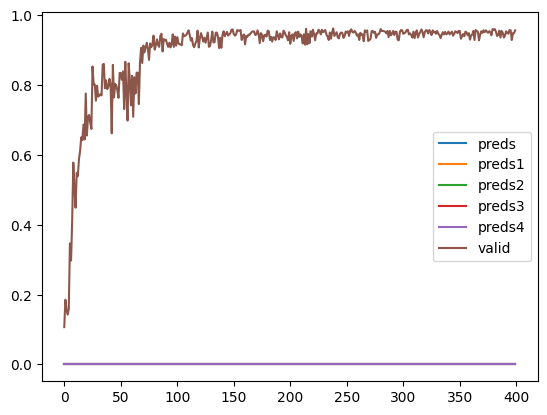

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.11125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:06<43:30,  6.54s/it]

valid-f1: 0.033513291991223104
valid-precision: 0.030170053433755173
valid-recall: 0.07891395154553049
process: 1  loss: 57.723318099975586  train_correct: 0.008432022738038844 valid_loss 82.85580921173096  val_correct: 0.08637577916295637
The model has been saved!!
The best val_acc is  0.08637577916295637
***训练集***
0.12625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:13<43:24,  6.54s/it]

valid-f1: 0.05613935484244002
valid-precision: 0.12823410410978908
valid-recall: 0.09852965747702588
process: 2  loss: 57.355677127838135  train_correct: 0.00956892468024633 valid_loss 82.10814809799194  val_correct: 0.10240427426536064
The model has been saved!!
The best val_acc is  0.10240427426536064
***训练集***
0.18125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:19<42:58,  6.49s/it]

valid-f1: 0.05646842602770723
valid-precision: 0.14981121675623538
valid-recall: 0.10265998329156223
process: 3  loss: 56.85635566711426  train_correct: 0.013737565135007106 valid_loss 81.48534631729126  val_correct: 0.1006233303650935
***训练集***
0.2425


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [00:26<43:20,  6.57s/it]

valid-f1: 0.1307852914633389
valid-precision: 0.11194915236404505
valid-recall: 0.18415095710290216
process: 4  loss: 55.87943911552429  train_correct: 0.018379914732354334 valid_loss 79.49399471282959  val_correct: 0.2404274265360641
The model has been saved!!
The best val_acc is  0.2404274265360641
***训练集***
0.275


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [00:32<43:15,  6.57s/it]

valid-f1: 0.0947837808848447
valid-precision: 0.07023162637983428
valid-recall: 0.14582652282881117
process: 5  loss: 54.396207332611084  train_correct: 0.020843202273803884 valid_loss 75.35092830657959  val_correct: 0.24309884238646481
The model has been saved!!
The best val_acc is  0.24309884238646481
***训练集***
0.31625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/400 [00:39<42:51,  6.53s/it]

valid-f1: 0.11913138253969544
valid-precision: 0.2079496053740645
valid-recall: 0.1650375939849624
process: 6  loss: 51.32372164726257  train_correct: 0.023969682614874466 valid_loss 75.35716441273689  val_correct: 0.20480854853072128
***训练集***
0.42875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [00:45<42:43,  6.52s/it]

valid-f1: 0.3298239067018794
valid-precision: 0.4075474340535921
valid-recall: 0.3600032690421706
process: 7  loss: 46.269458532333374  train_correct: 0.032496447181430604 valid_loss 65.49962615966797  val_correct: 0.4514692787177204
The model has been saved!!
The best val_acc is  0.4514692787177204
***训练集***
0.435


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/400 [00:52<42:28,  6.50s/it]

valid-f1: 0.3297430911675415
valid-precision: 0.3440239160512677
valid-recall: 0.37080745341614907
process: 8  loss: 42.74020338058472  train_correct: 0.03297015632401706 valid_loss 58.927958488464355  val_correct: 0.4390026714158504
***训练集***
0.5


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [00:58<42:29,  6.52s/it]

valid-f1: 0.2981849090480187
valid-precision: 0.29831909455542804
valid-recall: 0.3721922064713827
process: 9  loss: 38.86432099342346  train_correct: 0.037896731406916156 valid_loss 58.171453446149826  val_correct: 0.41406945681211044
***训练集***
0.51125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▎         | 10/400 [01:05<42:24,  6.52s/it]

valid-f1: 0.3266146369649666
valid-precision: 0.3840975193930928
valid-recall: 0.37048444563318705
process: 10  loss: 35.407655358314514  train_correct: 0.03874940786357177 valid_loss 52.105334885418415  val_correct: 0.42920747996438113
***训练集***
0.555


  3%|▎         | 11/400 [01:11<42:18,  6.52s/it]

valid-f1: 0.40903099451106933
valid-precision: 0.6487183727779329
valid-recall: 0.41706235285182647
process: 11  loss: 33.028698801994324  train_correct: 0.04206537186167693 valid_loss 45.6352958381176  val_correct: 0.5307212822796082
The model has been saved!!
The best val_acc is  0.5307212822796082
***训练集***
0.59


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/400 [01:18<42:11,  6.52s/it]

valid-f1: 0.4874358170180589
valid-precision: 0.5508529070334783
valid-recall: 0.5020803094693255
process: 12  loss: 31.264841616153717  train_correct: 0.04471814306016106 valid_loss 50.25599864125252  val_correct: 0.5422974176313446
The model has been saved!!
The best val_acc is  0.5422974176313446
***训练集***
0.59625


  3%|▎         | 13/400 [01:24<42:04,  6.52s/it]

valid-f1: 0.5852520842499295
valid-precision: 0.7236541552134061
valid-recall: 0.6135850462784102
process: 13  loss: 28.999946773052216  train_correct: 0.04519185220274751 valid_loss 38.094049513339996  val_correct: 0.6634016028495102
The model has been saved!!
The best val_acc is  0.6634016028495102
***训练集***
0.635


  4%|▎         | 14/400 [01:31<42:02,  6.53s/it]

valid-f1: 0.5145502930290811
valid-precision: 0.5995227682711936
valid-recall: 0.51998927490003
process: 14  loss: 27.806312680244446  train_correct: 0.048128848886783517 valid_loss 42.95643898844719  val_correct: 0.5903829029385574
***训练集***
0.69


  4%|▍         | 15/400 [01:37<41:51,  6.52s/it]

valid-f1: 0.5890787818550203
valid-precision: 0.6960105269020509
valid-recall: 0.5892146505922249
process: 15  loss: 24.9428950548172  train_correct: 0.05229748934154429 valid_loss 32.24157367646694  val_correct: 0.684772929652716
The model has been saved!!
The best val_acc is  0.684772929652716
***训练集***
0.70375


  4%|▍         | 16/400 [01:44<41:37,  6.50s/it]

valid-f1: 0.6452859617577879
valid-precision: 0.7759947139531347
valid-recall: 0.6521494810808313
process: 16  loss: 22.969924986362457  train_correct: 0.053339649455234485 valid_loss 37.95927008986473  val_correct: 0.6731967943009796
***训练集***
0.735


  4%|▍         | 17/400 [01:50<41:26,  6.49s/it]

valid-f1: 0.6839944014830972
valid-precision: 0.7377228871856679
valid-recall: 0.7081545563513527
process: 17  loss: 21.762988686561584  train_correct: 0.055708195168166746 valid_loss 33.93684110045433  val_correct: 0.6821015138023152
***训练集***
0.68875


  4%|▍         | 18/400 [01:57<41:27,  6.51s/it]

valid-f1: 0.7468261105450174
valid-precision: 0.7571887550249101
valid-recall: 0.7891741177713719
process: 18  loss: 22.918121874332428  train_correct: 0.052202747513027004 valid_loss 31.880611017346382  val_correct: 0.742653606411398
The model has been saved!!
The best val_acc is  0.742653606411398
***训练集***
0.74875


  5%|▍         | 19/400 [02:04<41:31,  6.54s/it]

valid-f1: 0.44980108545751
valid-precision: 0.6849247812319985
valid-recall: 0.4847558223622296
process: 19  loss: 20.108242452144623  train_correct: 0.05675035528185694 valid_loss 55.16912114620209  val_correct: 0.41585040071237755
***训练集***
0.76


  5%|▌         | 20/400 [02:10<41:17,  6.52s/it]

valid-f1: 0.5356509650043574
valid-precision: 0.6440894237756016
valid-recall: 0.5909874653696163
process: 20  loss: 19.078610360622406  train_correct: 0.057603031738512556 valid_loss 43.087996661663055  val_correct: 0.5814781834372217
***训练集***
0.75125


  5%|▌         | 21/400 [02:17<41:18,  6.54s/it]

valid-f1: 0.7058571854222871
valid-precision: 0.7968070298473345
valid-recall: 0.6883006627240038
process: 21  loss: 19.441698729991913  train_correct: 0.05693983893889152 valid_loss 26.779110088944435  val_correct: 0.7604630454140695
The model has been saved!!
The best val_acc is  0.7604630454140695
***训练集***
0.755


  6%|▌         | 22/400 [02:23<41:06,  6.53s/it]

valid-f1: 0.7315012220133368
valid-precision: 0.7680340364995613
valid-recall: 0.7534755102512539
process: 22  loss: 19.48002463579178  train_correct: 0.057224064424443395 valid_loss 28.127569124102592  val_correct: 0.7319679430097952
***训练集***
0.77875


  6%|▌         | 23/400 [02:30<40:58,  6.52s/it]

valid-f1: 0.6942963628202932
valid-precision: 0.718311658369362
valid-recall: 0.7341453898250238
process: 23  loss: 17.73328870534897  train_correct: 0.059024159166271906 valid_loss 31.82477617263794  val_correct: 0.692787177203918
***训练集***
0.7725


  6%|▌         | 24/400 [02:36<41:06,  6.56s/it]

valid-f1: 0.8026356194294632
valid-precision: 0.8637073208012358
valid-recall: 0.7930134030728997
process: 24  loss: 17.911750853061676  train_correct: 0.05855045002368546 valid_loss 23.465417608618736  val_correct: 0.8308103294746215
The model has been saved!!
The best val_acc is  0.8308103294746215
***训练集***
0.8025


  6%|▋         | 25/400 [02:43<40:46,  6.52s/it]

valid-f1: 0.754443681279162
valid-precision: 0.8322274204816237
valid-recall: 0.7468485839103689
process: 25  loss: 15.266717672348022  train_correct: 0.06082425390810042 valid_loss 26.758157696574926  val_correct: 0.780053428317008
***训练集***
0.81125


  6%|▋         | 26/400 [02:49<40:31,  6.50s/it]

valid-f1: 0.7104943984282167
valid-precision: 0.7622526448396203
valid-recall: 0.7388891530539128
process: 26  loss: 15.193682760000229  train_correct: 0.06148744670772146 valid_loss 33.739801079034805  val_correct: 0.7212822796081924
***训练集***
0.81125


  7%|▋         | 27/400 [02:56<40:21,  6.49s/it]

valid-f1: 0.7846093433239553
valid-precision: 0.8043175875975239
valid-recall: 0.8092187187335929
process: 27  loss: 15.323748767375946  train_correct: 0.06148744670772146 valid_loss 24.6384240090847  val_correct: 0.7880676758682101
***训练集***
0.7975


  7%|▋         | 28/400 [03:02<40:32,  6.54s/it]

valid-f1: 0.8586394535353733
valid-precision: 0.8616959357573746
valid-recall: 0.8775510911666519
process: 28  loss: 16.16920903325081  train_correct: 0.06044528659403126 valid_loss 15.992597356438637  val_correct: 0.8628673196794301
The model has been saved!!
The best val_acc is  0.8628673196794301
***训练集***
0.8025


  7%|▋         | 29/400 [03:09<40:23,  6.53s/it]

valid-f1: 0.7940384236305452
valid-precision: 0.7923036242585468
valid-recall: 0.8253025482018618
process: 29  loss: 15.351559072732925  train_correct: 0.06082425390810042 valid_loss 22.637789187952876  val_correct: 0.8067675868210151
***训练集***
0.78625


  8%|▊         | 30/400 [03:15<40:15,  6.53s/it]

valid-f1: 0.791389684558449
valid-precision: 0.8350471072742298
valid-recall: 0.8052046255295684
process: 30  loss: 15.56523260474205  train_correct: 0.05959261013737565 valid_loss 21.289912167936563  val_correct: 0.7934105075690115
***训练集***
0.79875


  8%|▊         | 31/400 [03:22<39:59,  6.50s/it]

valid-f1: 0.7885846503404678
valid-precision: 0.7988857260769862
valid-recall: 0.8210441882043712
process: 31  loss: 15.461924880743027  train_correct: 0.060540028422548554 valid_loss 21.51427862048149  val_correct: 0.7951914514692787
***训练集***
0.80625


  8%|▊         | 32/400 [03:28<39:52,  6.50s/it]

valid-f1: 0.7066716940166412
valid-precision: 0.7877321012572207
valid-recall: 0.6987700113260754
process: 32  loss: 15.102003663778305  train_correct: 0.0611084793936523 valid_loss 32.00586521625519  val_correct: 0.7292965271593945
***训练集***
0.80625


  8%|▊         | 33/400 [03:35<39:56,  6.53s/it]

valid-f1: 0.7974634497317834
valid-precision: 0.8242123417115133
valid-recall: 0.8097774739880004
process: 33  loss: 15.109270930290222  train_correct: 0.0611084793936523 valid_loss 18.687341179698706  val_correct: 0.798753339269813
***训练集***
0.80625


  8%|▊         | 34/400 [03:41<39:48,  6.53s/it]

valid-f1: 0.8129945143499935
valid-precision: 0.8323067498253138
valid-recall: 0.8309103423908916
process: 34  loss: 15.288890331983566  train_correct: 0.0611084793936523 valid_loss 21.64534443616867  val_correct: 0.8156723063223509
***训练集***
0.82625


  9%|▉         | 35/400 [03:48<39:36,  6.51s/it]

valid-f1: 0.7126389062395517
valid-precision: 0.7732536588441075
valid-recall: 0.7515900356952987
process: 35  loss: 13.321710526943207  train_correct: 0.06262434864992894 valid_loss 28.5966170206666  val_correct: 0.7203918076580588
***训练集***
0.81


  9%|▉         | 36/400 [03:54<39:26,  6.50s/it]

valid-f1: 0.8527521875601674
valid-precision: 0.848604073582203
valid-recall: 0.8744711944551762
process: 36  loss: 14.100513949990273  train_correct: 0.06139270487920417 valid_loss 16.59924129024148  val_correct: 0.8610863757791629
***训练集***
0.845


  9%|▉         | 37/400 [04:01<39:11,  6.48s/it]

valid-f1: 0.8112992513036268
valid-precision: 0.8402775337370866
valid-recall: 0.807390650539392
process: 37  loss: 12.002024978399277  train_correct: 0.0640454760776883 valid_loss 20.949033294571564  val_correct: 0.8263579697239537
***训练集***
0.82


 10%|▉         | 38/400 [04:07<39:14,  6.50s/it]

valid-f1: 0.8074066527680435
valid-precision: 0.8488343221980157
valid-recall: 0.8092555862647396
process: 38  loss: 13.728147983551025  train_correct: 0.062150639507342495 valid_loss 21.203315315768123  val_correct: 0.8165627782724845
***训练集***
0.83125


 10%|▉         | 39/400 [04:14<39:04,  6.49s/it]

valid-f1: 0.6959222830258971
valid-precision: 0.7822445422229511
valid-recall: 0.7229764133654294
process: 39  loss: 12.566812932491302  train_correct: 0.06300331596399811 valid_loss 33.41007876954973  val_correct: 0.6856634016028496
***训练集***
0.825


 10%|█         | 40/400 [04:20<38:53,  6.48s/it]

valid-f1: 0.7966475685054941
valid-precision: 0.8281564798393448
valid-recall: 0.8015911980214041
process: 40  loss: 13.190588921308517  train_correct: 0.06252960682141165 valid_loss 23.398576516658068  val_correct: 0.8014247551202137
***训练集***
0.85125


 10%|█         | 41/400 [04:27<38:47,  6.48s/it]

valid-f1: 0.803257255800683
valid-precision: 0.8135595931863687
valid-recall: 0.8301952245567806
process: 41  loss: 11.936060935258865  train_correct: 0.06451918522027475 valid_loss 21.364598356187344  val_correct: 0.8058771148708815
***训练集***
0.845


 10%|█         | 42/400 [04:33<38:39,  6.48s/it]

valid-f1: 0.7839082956278404
valid-precision: 0.8052459519540236
valid-recall: 0.8135822989621616
process: 42  loss: 12.161843925714493  train_correct: 0.0640454760776883 valid_loss 26.779956184327602  val_correct: 0.7764915405164737
***训练集***
0.83375


 11%|█         | 43/400 [04:40<38:50,  6.53s/it]

valid-f1: 0.7923498184917055
valid-precision: 0.8094680543750032
valid-recall: 0.8104338811455516
process: 43  loss: 12.721176892518997  train_correct: 0.06319279962103269 valid_loss 20.93024174380116  val_correct: 0.8040961709706145
***训练集***
0.85375


 11%|█         | 44/400 [04:46<38:38,  6.51s/it]

valid-f1: 0.756332778969405
valid-precision: 0.8151546096211751
valid-recall: 0.7931741177713718
process: 44  loss: 11.966013431549072  train_correct: 0.06470866887730933 valid_loss 30.533008066937327  val_correct: 0.7542297417631345
***训练集***
0.83875


 11%|█▏        | 45/400 [04:53<38:26,  6.50s/it]

valid-f1: 0.750374814544851
valid-precision: 0.7872354641313961
valid-recall: 0.7806722273404196
process: 45  loss: 12.527567982673645  train_correct: 0.06357176693510184 valid_loss 27.767110515385866  val_correct: 0.7284060552092609
***训练集***
0.8525


 12%|█▏        | 46/400 [04:59<38:22,  6.50s/it]

valid-f1: 0.8830348639394139
valid-precision: 0.8935038001121096
valid-recall: 0.8780316238554224
process: 46  loss: 12.496837168931961  train_correct: 0.06461392704879204 valid_loss 14.353238549083471  val_correct: 0.8780053428317008
The model has been saved!!
The best val_acc is  0.8780053428317008
***训练集***
0.8375


 12%|█▏        | 47/400 [05:06<38:11,  6.49s/it]

valid-f1: 0.7324630730658567
valid-precision: 0.7475797377040359
valid-recall: 0.7835724323985194
process: 47  loss: 13.044470399618149  train_correct: 0.06347702510658455 valid_loss 30.352394049987197  val_correct: 0.7186108637577916
***训练集***
0.85375


 12%|█▏        | 48/400 [05:12<38:12,  6.51s/it]

valid-f1: 0.8277753389435969
valid-precision: 0.8245875521336027
valid-recall: 0.8495063350074792
process: 48  loss: 10.98800952732563  train_correct: 0.06470866887730933 valid_loss 18.23069866001606  val_correct: 0.804986642920748
***训练集***
0.87125


 12%|█▏        | 49/400 [05:19<37:58,  6.49s/it]

valid-f1: 0.6460179640449063
valid-precision: 0.7240099509662624
valid-recall: 0.6762741273473539
process: 49  loss: 10.145923554897308  train_correct: 0.06603505447655139 valid_loss 32.92326393723488  val_correct: 0.661620658949243
***训练集***
0.8625


 12%|█▎        | 50/400 [05:25<37:49,  6.48s/it]

valid-f1: 0.8504796721311567
valid-precision: 0.8480992496930911
valid-recall: 0.8698493202703729
process: 50  loss: 10.47335571050644  train_correct: 0.06537186167693036 valid_loss 18.994725161232054  val_correct: 0.8290293855743545
***训练集***
0.85875


 13%|█▎        | 51/400 [05:32<37:39,  6.47s/it]

valid-f1: 0.8463955241652522
valid-precision: 0.8486340030579852
valid-recall: 0.8627477521207499
process: 51  loss: 11.599058911204338  train_correct: 0.06508763619137849 valid_loss 17.907283595763147  val_correct: 0.8325912733748887
***训练集***
0.85625


 13%|█▎        | 52/400 [05:38<37:29,  6.47s/it]

valid-f1: 0.8851936199433856
valid-precision: 0.8740024348679685
valid-recall: 0.9080842422261186
process: 52  loss: 10.49910882115364  train_correct: 0.06489815253434392 valid_loss 13.74320907983929  val_correct: 0.8744434550311665
***训练集***
0.86125


 13%|█▎        | 53/400 [05:45<37:43,  6.52s/it]

valid-f1: 0.887240112131019
valid-precision: 0.8817984072821771
valid-recall: 0.9080484016365024
process: 53  loss: 10.251972943544388  train_correct: 0.06527711984841307 valid_loss 15.280450034653768  val_correct: 0.8904719501335708
The model has been saved!!
The best val_acc is  0.8904719501335708
***训练集***
0.85375


 14%|█▎        | 54/400 [05:51<37:33,  6.51s/it]

valid-f1: 0.8598037041998181
valid-precision: 0.867475344427243
valid-recall: 0.8883830128681387
process: 54  loss: 11.343963265419006  train_correct: 0.06470866887730933 valid_loss 17.258852497674525  val_correct: 0.8512911843276937
***训练集***
0.8575


 14%|█▍        | 55/400 [05:58<37:22,  6.50s/it]

valid-f1: 0.8276976943716748
valid-precision: 0.8219596392883259
valid-recall: 0.8706747435122721
process: 55  loss: 10.296415954828262  train_correct: 0.06499289436286121 valid_loss 21.021227594465017  val_correct: 0.8165627782724845
***训练集***
0.88


 14%|█▍        | 56/400 [06:04<37:08,  6.48s/it]

valid-f1: 0.7624747080561615
valid-precision: 0.7767865433146992
valid-recall: 0.8137453449169696
process: 56  loss: 10.057083010673523  train_correct: 0.06669824727617243 valid_loss 26.485968731343746  val_correct: 0.7560106856634016
***训练集***
0.8675


 14%|█▍        | 57/400 [06:11<37:18,  6.53s/it]

valid-f1: 0.81295404179686
valid-precision: 0.8391050766750441
valid-recall: 0.8471931805799082
process: 57  loss: 10.477052472531796  train_correct: 0.06575082899099953 valid_loss 20.48520990461111  val_correct: 0.8272484416740873
***训练集***
0.8525


 14%|█▍        | 58/400 [06:17<37:06,  6.51s/it]

valid-f1: 0.7335223286868835
valid-precision: 0.793102165136368
valid-recall: 0.7759895456691795
process: 58  loss: 11.258872359991074  train_correct: 0.06461392704879204 valid_loss 24.651317437179387  val_correct: 0.7319679430097952
***训练集***
0.84125


 15%|█▍        | 59/400 [06:24<36:56,  6.50s/it]

valid-f1: 0.7865604194133752
valid-precision: 0.8019568241391625
valid-recall: 0.8029677652629598
process: 59  loss: 11.555677860975266  train_correct: 0.06376125059213643 valid_loss 22.33529586903751  val_correct: 0.786286731967943
***训练集***
0.87375


 15%|█▌        | 60/400 [06:30<36:42,  6.48s/it]

valid-f1: 0.792527319493438
valid-precision: 0.8312391811816614
valid-recall: 0.8103804768839094
process: 60  loss: 10.520277589559555  train_correct: 0.06622453813358598 valid_loss 26.40226341644302  val_correct: 0.7782724844167409
***训练集***
0.8325


 15%|█▌        | 61/400 [06:37<36:36,  6.48s/it]

valid-f1: 0.867124006046559
valid-precision: 0.8861072418000413
valid-recall: 0.8664110044544827
process: 61  loss: 11.872958928346634  train_correct: 0.0630980577925154 valid_loss 15.079143334180117  val_correct: 0.8673196794300979
***训练集***
0.88


 16%|█▌        | 62/400 [06:43<36:40,  6.51s/it]

valid-f1: 0.8349867502234796
valid-precision: 0.8537321987974253
valid-recall: 0.8364752493882929
process: 62  loss: 10.240390032529831  train_correct: 0.06669824727617243 valid_loss 14.723638816736639  val_correct: 0.8486197684772929
***训练集***
0.86


 16%|█▌        | 63/400 [06:50<36:24,  6.48s/it]

valid-f1: 0.7923174031252507
valid-precision: 0.8017981409136838
valid-recall: 0.8106827080877425
process: 63  loss: 10.502982795238495  train_correct: 0.06518237801989578 valid_loss 23.115428620949388  val_correct: 0.7845057880676759
***训练集***
0.8575


 16%|█▌        | 64/400 [06:56<36:12,  6.47s/it]

valid-f1: 0.7565827201571989
valid-precision: 0.8129087715704504
valid-recall: 0.7595898243632797
process: 64  loss: 10.948575004935265  train_correct: 0.06499289436286121 valid_loss 22.30537274479866  val_correct: 0.7836153161175423
***训练集***
0.86125


 16%|█▋        | 65/400 [07:02<36:03,  6.46s/it]

valid-f1: 0.7148534010391581
valid-precision: 0.8018494138112017
valid-recall: 0.7441524232187848
process: 65  loss: 9.871974378824234  train_correct: 0.06527711984841307 valid_loss 34.74137927591801  val_correct: 0.7043633125556545
***训练集***
0.8425


 16%|█▋        | 66/400 [07:09<35:55,  6.45s/it]

valid-f1: 0.7509393817655323
valid-precision: 0.7527364114228803
valid-recall: 0.7802278819578591
process: 66  loss: 11.459354043006897  train_correct: 0.06385599242065372 valid_loss 28.845218582078815  val_correct: 0.7471059661620659
***训练集***
0.8975


 17%|█▋        | 67/400 [07:15<35:55,  6.47s/it]

valid-f1: 0.8013464345313777
valid-precision: 0.8232504515639862
valid-recall: 0.8127158872147431
process: 67  loss: 8.882840633392334  train_correct: 0.06802463287541449 valid_loss 20.838341953232884  val_correct: 0.8058771148708815
***训练集***
0.885


 17%|█▋        | 68/400 [07:22<35:50,  6.48s/it]

valid-f1: 0.83202689914184
valid-precision: 0.8251782467194573
valid-recall: 0.8655058330939338
process: 68  loss: 8.771574035286903  train_correct: 0.06707721459024159 valid_loss 22.82910208683461  val_correct: 0.8156723063223509
***训练集***
0.88


 17%|█▋        | 69/400 [07:28<35:47,  6.49s/it]

valid-f1: 0.759347034668054
valid-precision: 0.8074204571284597
valid-recall: 0.7915145802582874
process: 69  loss: 8.950210288167  train_correct: 0.06669824727617243 valid_loss 27.45309705194086  val_correct: 0.7444345503116652
***训练集***
0.865


 18%|█▊        | 70/400 [07:35<35:40,  6.49s/it]

valid-f1: 0.8395395900109064
valid-precision: 0.8401407004973158
valid-recall: 0.8548715134344425
process: 70  loss: 9.44890983402729  train_correct: 0.06556134533396495 valid_loss 17.596270062727854  val_correct: 0.8138913624220837
***训练集***
0.87625


 18%|█▊        | 71/400 [07:41<35:30,  6.48s/it]

valid-f1: 0.7969957063545093
valid-precision: 0.79133442937948
valid-recall: 0.8341938013677144
process: 71  loss: 8.988383457064629  train_correct: 0.06641402179062056 valid_loss 26.857893396168947  val_correct: 0.780053428317008
***训练集***
0.8725


 18%|█▊        | 72/400 [07:48<35:30,  6.49s/it]

valid-f1: 0.8414636805390667
valid-precision: 0.8382689766645491
valid-recall: 0.8735793535221454
process: 72  loss: 9.442427687346935  train_correct: 0.06612979630506868 valid_loss 18.915919315535575  val_correct: 0.8414959928762245
***训练集***
0.8825


 18%|█▊        | 73/400 [07:54<35:22,  6.49s/it]

valid-f1: 0.894374160847678
valid-precision: 0.902732319018915
valid-recall: 0.9138338269917217
process: 73  loss: 9.820108234882355  train_correct: 0.066887730933207 valid_loss 15.175716656725854  val_correct: 0.8851291184327693
***训练集***
0.89


 18%|█▊        | 74/400 [08:01<35:12,  6.48s/it]

valid-f1: 0.8723902996085015
valid-precision: 0.8858176221617272
valid-recall: 0.8810619367919139
process: 74  loss: 8.562241479754448  train_correct: 0.06745618190431076 valid_loss 13.764615651220083  val_correct: 0.8610863757791629
***训练集***
0.89375


 19%|█▉        | 75/400 [08:07<35:01,  6.47s/it]

valid-f1: 0.8441812593029999
valid-precision: 0.8623581682724091
valid-recall: 0.8631856617829158
process: 75  loss: 8.506716080009937  train_correct: 0.06774040738986263 valid_loss 15.803853078745306  val_correct: 0.8512911843276937
***训练集***
0.8775


 19%|█▉        | 76/400 [08:14<34:52,  6.46s/it]

valid-f1: 0.8640829532476495
valid-precision: 0.8674952809824962
valid-recall: 0.8885419312444484
process: 76  loss: 8.92807599157095  train_correct: 0.06650876361913785 valid_loss 20.8860151655972  val_correct: 0.8406055209260909
***训练集***
0.84375
开始蒸馏


 19%|█▉        | 77/400 [08:20<34:57,  6.49s/it]

valid-f1: 0.8667171626497818
valid-precision: 0.8818087194605203
valid-recall: 0.8719605370474935
process: 77  loss: 10.897263437509537  train_correct: 0.06395073424917101 valid_loss 12.590699124266393  val_correct: 0.8762243989314337
***训练集***
0.77375


 20%|█▉        | 78/400 [08:27<34:47,  6.48s/it]

valid-f1: 0.6516849257066657
valid-precision: 0.8124827288144241
valid-recall: 0.6422231699142454
process: 78  loss: 914.1607627868652  train_correct: 0.058645191852202745 valid_loss 47.025668137852335  val_correct: 0.6527159394479074
***训练集***
0.77375


 20%|█▉        | 79/400 [08:33<34:39,  6.48s/it]

valid-f1: 0.8055200098885749
valid-precision: 0.8414644501800422
valid-recall: 0.8159936600394266
process: 79  loss: 595.1425857543945  train_correct: 0.058645191852202745 valid_loss 18.56724561052397  val_correct: 0.8325912733748887
***训练集***
0.78875


 20%|██        | 80/400 [08:40<34:34,  6.48s/it]

valid-f1: 0.7646121827961576
valid-precision: 0.8357503383199363
valid-recall: 0.7671996559250565
process: 80  loss: 470.70953369140625  train_correct: 0.05978209379441023 valid_loss 27.331751761958003  val_correct: 0.7907390917186109
***训练集***
0.80875


 20%|██        | 81/400 [08:46<34:36,  6.51s/it]

valid-f1: 0.8909304420465756
valid-precision: 0.9048326857712133
valid-recall: 0.8815020819505944
process: 81  loss: 418.5701389312744  train_correct: 0.061297963050686875 valid_loss 10.974380311788991  val_correct: 0.9091718610863758
The model has been saved!!
The best val_acc is  0.9091718610863758
***训练集***
0.81125


 20%|██        | 82/400 [08:53<34:32,  6.52s/it]

valid-f1: 0.8445486251768253
valid-precision: 0.854967960617946
valid-recall: 0.8770382808140245
process: 82  loss: 372.0232181549072  train_correct: 0.06148744670772146 valid_loss 25.84167915955186  val_correct: 0.8521816562778273
***训练集***
0.83375


 21%|██        | 83/400 [08:59<34:19,  6.50s/it]

valid-f1: 0.904038647243819
valid-precision: 0.907990777856899
valid-recall: 0.9060755379885814
process: 83  loss: 363.938588142395  train_correct: 0.06319279962103269 valid_loss 11.405810322612524  val_correct: 0.9091718610863758
***训练集***
0.85375


 21%|██        | 84/400 [09:06<34:06,  6.48s/it]

valid-f1: 0.833422918454831
valid-precision: 0.8491445921674149
valid-recall: 0.8547567865645668
process: 84  loss: 333.84048652648926  train_correct: 0.06470866887730933 valid_loss 17.138384172634687  val_correct: 0.8370436331255565
***训练集***
0.865


 21%|██▏       | 85/400 [09:12<34:04,  6.49s/it]

valid-f1: 0.852130454287742
valid-precision: 0.8611316803944031
valid-recall: 0.8573651487083982
process: 85  loss: 327.8124990463257  train_correct: 0.06556134533396495 valid_loss 16.16623248718679  val_correct: 0.8593054318788959
***训练集***
0.8425


 22%|██▏       | 86/400 [09:19<34:08,  6.52s/it]

valid-f1: 0.9000099534877654
valid-precision: 0.909486566755436
valid-recall: 0.8953152281230083
process: 86  loss: 316.10222721099854  train_correct: 0.06385599242065372 valid_loss 11.837469862075523  val_correct: 0.9073909171861086
***训练集***
0.86


 22%|██▏       | 87/400 [09:25<34:03,  6.53s/it]

valid-f1: 0.8399768538128842
valid-precision: 0.868856975049581
valid-recall: 0.8390148031475262
process: 87  loss: 296.6632556915283  train_correct: 0.06518237801989578 valid_loss 18.060911431908607  val_correct: 0.8459483526268923
***训练集***
0.86375


 22%|██▏       | 88/400 [09:32<33:51,  6.51s/it]

valid-f1: 0.8485259055000729
valid-precision: 0.8762962750378318
valid-recall: 0.8481909021565773
process: 88  loss: 276.3888530731201  train_correct: 0.06546660350544765 valid_loss 18.786160292918794  val_correct: 0.8548530721282279
***训练集***
0.85875


 22%|██▏       | 89/400 [09:38<33:44,  6.51s/it]

valid-f1: 0.8694480076533132
valid-precision: 0.8770181939243749
valid-recall: 0.8819079285829858
process: 89  loss: 295.88008213043213  train_correct: 0.06508763619137849 valid_loss 21.15704732015729  val_correct: 0.8726625111308994
***训练集***
0.86625


 22%|██▎       | 90/400 [09:45<33:33,  6.50s/it]

valid-f1: 0.8892349342778744
valid-precision: 0.8931663228897715
valid-recall: 0.9051127489342592
process: 90  loss: 276.39826679229736  train_correct: 0.06565608716248224 valid_loss 15.956741597969085  val_correct: 0.8993766696349065
***训练集***
0.86


 23%|██▎       | 91/400 [09:51<33:30,  6.51s/it]

valid-f1: 0.883055588866806
valid-precision: 0.8804323740593383
valid-recall: 0.907892755604426
process: 91  loss: 275.9980659484863  train_correct: 0.06518237801989578 valid_loss 16.556684775277972  val_correct: 0.8869100623330365
***训练集***
0.8425


 23%|██▎       | 92/400 [09:58<33:15,  6.48s/it]

valid-f1: 0.8546176767769932
valid-precision: 0.8762647170873914
valid-recall: 0.8563641382771818
process: 92  loss: 273.1300582885742  train_correct: 0.06385599242065372 valid_loss 17.684257397195324  val_correct: 0.8566340160284951
***训练集***
0.87125


 23%|██▎       | 93/400 [10:04<33:21,  6.52s/it]

valid-f1: 0.9075142811814793
valid-precision: 0.9023588251173565
valid-recall: 0.9214652243256362
process: 93  loss: 276.17631435394287  train_correct: 0.06603505447655139 valid_loss 12.507361066062003  val_correct: 0.9162956366874443
The model has been saved!!
The best val_acc is  0.9162956366874443
***训练集***
0.87875


 24%|██▎       | 94/400 [10:11<33:10,  6.50s/it]

valid-f1: 0.8904745170683401
valid-precision: 0.904344581629266
valid-recall: 0.8949756670992368
process: 94  loss: 263.76484203338623  train_correct: 0.06660350544765514 valid_loss 13.735265904571861  val_correct: 0.8967052537845058
***训练集***
0.88


 24%|██▍       | 95/400 [10:17<33:05,  6.51s/it]

valid-f1: 0.9248413016625696
valid-precision: 0.9255212431428068
valid-recall: 0.9311181445048721
process: 95  loss: 255.52451515197754  train_correct: 0.06669824727617243 valid_loss 12.59118788363412  val_correct: 0.93766696349065
The model has been saved!!
The best val_acc is  0.93766696349065
***训练集***
0.8825


 24%|██▍       | 96/400 [10:24<33:12,  6.55s/it]

valid-f1: 0.8975484161467964
valid-precision: 0.9133600849404218
valid-recall: 0.8935086134308101
process: 96  loss: 269.1851863861084  train_correct: 0.066887730933207 valid_loss 13.471855855546892  val_correct: 0.9047195013357079
***训练集***
0.855


 24%|██▍       | 97/400 [10:30<32:52,  6.51s/it]

valid-f1: 0.8544358908901544
valid-precision: 0.8788554693527576
valid-recall: 0.8538133674106214
process: 97  loss: 249.9052438735962  train_correct: 0.06480341070582663 valid_loss 15.633445093000773  val_correct: 0.8673196794300979
***训练集***
0.86625


 24%|██▍       | 98/400 [10:37<32:41,  6.49s/it]

valid-f1: 0.9115876596661501
valid-precision: 0.9283747450734031
valid-recall: 0.9084615260153017
process: 98  loss: 252.89591884613037  train_correct: 0.06565608716248224 valid_loss 12.266078841639683  val_correct: 0.9162956366874443
***训练集***
0.90125


 25%|██▍       | 99/400 [10:43<32:31,  6.48s/it]

valid-f1: 0.8999818195876153
valid-precision: 0.8926851177522905
valid-recall: 0.9209639711928042
process: 99  loss: 226.6479926109314  train_correct: 0.06830885836096637 valid_loss 15.398718775715679  val_correct: 0.9082813891362422
***训练集***
0.87375


 25%|██▌       | 100/400 [10:50<32:29,  6.50s/it]

valid-f1: 0.8995403705739864
valid-precision: 0.9098879217581913
valid-recall: 0.8969424021186034
process: 100  loss: 233.51740503311157  train_correct: 0.06622453813358598 valid_loss 12.682715940987691  val_correct: 0.9118432769367765
***训练集***
0.88875


 25%|██▌       | 101/400 [10:56<32:30,  6.52s/it]

valid-f1: 0.86501169968833
valid-precision: 0.8931533729557511
valid-recall: 0.8562572802229553
process: 101  loss: 233.47248458862305  train_correct: 0.06736144007579346 valid_loss 15.289974572136998  val_correct: 0.8717720391807658
***训练集***
0.875


 26%|██▌       | 102/400 [11:03<32:18,  6.51s/it]

valid-f1: 0.9028989120995157
valid-precision: 0.9136525137054299
valid-recall: 0.9019664015110239
process: 102  loss: 238.55697631835938  train_correct: 0.06631927996210327 valid_loss 11.582698187965434  val_correct: 0.9056099732858415
***训练集***
0.87875


 26%|██▌       | 103/400 [11:09<32:09,  6.50s/it]

valid-f1: 0.9168485384484782
valid-precision: 0.9218708814040542
valid-recall: 0.9160691584032545
process: 103  loss: 231.6093897819519  train_correct: 0.06660350544765514 valid_loss 12.595286920201033  val_correct: 0.9287622439893143
***训练集***
0.87875


 26%|██▌       | 104/400 [11:16<32:01,  6.49s/it]

valid-f1: 0.9068037716969016
valid-precision: 0.9151972233132628
valid-recall: 0.9052790771394891
process: 104  loss: 227.20323944091797  train_correct: 0.06660350544765514 valid_loss 11.861151209915988  val_correct: 0.9109528049866429
***训练集***
0.85375


 26%|██▋       | 105/400 [11:22<32:03,  6.52s/it]

valid-f1: 0.9097961059732317
valid-precision: 0.9095800822972734
valid-recall: 0.9183779607120568
process: 105  loss: 225.0545825958252  train_correct: 0.06470866887730933 valid_loss 12.69853389263153  val_correct: 0.92520035618878
***训练集***
0.875


 26%|██▋       | 106/400 [11:29<32:03,  6.54s/it]

valid-f1: 0.8995757132949136
valid-precision: 0.9087063873272718
valid-recall: 0.9127517740332387
process: 106  loss: 220.8523349761963  train_correct: 0.06631927996210327 valid_loss 16.338055591564626  val_correct: 0.9171861086375779
***训练集***
0.87125


 27%|██▋       | 107/400 [11:35<31:48,  6.52s/it]

valid-f1: 0.9185114873770223
valid-precision: 0.9171462009665238
valid-recall: 0.9251024464983274
process: 107  loss: 210.84750652313232  train_correct: 0.06603505447655139 valid_loss 11.811039520893246  val_correct: 0.9234194122885129
***训练集***
0.89125


 27%|██▋       | 108/400 [11:42<31:37,  6.50s/it]

valid-f1: 0.9182045455892816
valid-precision: 0.9233431631816951
valid-recall: 0.9197602041995634
process: 108  loss: 219.38267993927002  train_correct: 0.06755092373282805 valid_loss 12.087428594240919  val_correct: 0.9296527159394479
***训练集***
0.8725
开始蒸馏


 27%|██▋       | 109/400 [11:48<31:25,  6.48s/it]

valid-f1: 0.9260904953921199
valid-precision: 0.9255396122406729
valid-recall: 0.9331155622917636
process: 109  loss: 208.06698846817017  train_correct: 0.06612979630506868 valid_loss 11.365802693209844  val_correct: 0.9349955476402493
***训练集***
0.87


 28%|██▊       | 110/400 [11:55<31:24,  6.50s/it]

valid-f1: 0.9202455041975295
valid-precision: 0.9191121122554886
valid-recall: 0.9255208178549139
process: 110  loss: 204.07469701766968  train_correct: 0.06594031264803411 valid_loss 11.01611771946773  val_correct: 0.931433659839715
***训练集***
0.9


 28%|██▊       | 111/400 [12:02<31:24,  6.52s/it]

valid-f1: 0.8712605273977572
valid-precision: 0.8809553006422798
valid-recall: 0.8876940374652046
process: 111  loss: 223.0193953514099  train_correct: 0.06821411653244908 valid_loss 17.62267021741718  val_correct: 0.8780053428317008
***训练集***
0.86875


 28%|██▊       | 112/400 [12:08<31:10,  6.50s/it]

valid-f1: 0.8957196758378491
valid-precision: 0.9022507924715807
valid-recall: 0.8986774214852018
process: 112  loss: 211.23271656036377  train_correct: 0.06584557081951682 valid_loss 12.201637937570922  val_correct: 0.9127337488869101
***训练集***
0.87625


 28%|██▊       | 113/400 [12:14<30:59,  6.48s/it]

valid-f1: 0.9254515929242203
valid-precision: 0.9294083262894463
valid-recall: 0.9283327191496527
process: 113  loss: 212.85649633407593  train_correct: 0.06641402179062056 valid_loss 12.727313579525799  val_correct: 0.9341050756901158
***训练集***
0.8625


 28%|██▊       | 114/400 [12:21<30:52,  6.48s/it]

valid-f1: 0.8927612608486888
valid-precision: 0.902360820191405
valid-recall: 0.8913400101043122
process: 114  loss: 209.60717058181763  train_correct: 0.06537186167693036 valid_loss 11.245953251956962  val_correct: 0.9056099732858415
***训练集***
0.89


 29%|██▉       | 115/400 [12:27<30:59,  6.52s/it]

valid-f1: 0.910055693183863
valid-precision: 0.9209442636738985
valid-recall: 0.9082893300444788
process: 115  loss: 210.09566354751587  train_correct: 0.06745618190431076 valid_loss 12.032963327481411  val_correct: 0.918967052537845
***训练集***
0.87875


 29%|██▉       | 116/400 [12:34<30:48,  6.51s/it]

valid-f1: 0.8940991669510338
valid-precision: 0.901530354328729
valid-recall: 0.8916893683484073
process: 116  loss: 204.14976119995117  train_correct: 0.06660350544765514 valid_loss 11.42902785530896  val_correct: 0.9091718610863758
***训练集***
0.89125


 29%|██▉       | 117/400 [12:40<30:44,  6.52s/it]

valid-f1: 0.9305289870624953
valid-precision: 0.936015849027358
valid-recall: 0.9341453105755166
process: 117  loss: 196.87837934494019  train_correct: 0.06755092373282805 valid_loss 13.262087948154658  val_correct: 0.9412288512911843
The model has been saved!!
The best val_acc is  0.9412288512911843
***训练集***
0.8725


 30%|██▉       | 118/400 [12:47<30:34,  6.50s/it]

valid-f1: 0.9253837943075748
valid-precision: 0.9322351750404925
valid-recall: 0.9265215013819132
process: 118  loss: 196.69600915908813  train_correct: 0.06612979630506868 valid_loss 12.55145953129977  val_correct: 0.9349955476402493
***训练集***
0.8725


 30%|██▉       | 119/400 [12:53<30:26,  6.50s/it]

valid-f1: 0.9119143288472905
valid-precision: 0.9136981561689697
valid-recall: 0.9152317849960869
process: 119  loss: 205.381685256958  train_correct: 0.06612979630506868 valid_loss 14.061026195529848  val_correct: 0.9260908281389136
***训练集***
0.8725


 30%|███       | 120/400 [13:00<30:21,  6.51s/it]

valid-f1: 0.9169413026066188
valid-precision: 0.9277525584501994
valid-recall: 0.9155722573891909
process: 120  loss: 205.8390073776245  train_correct: 0.06612979630506868 valid_loss 11.341223104216624  val_correct: 0.9234194122885129
***训练集***
0.88875


 30%|███       | 121/400 [13:06<30:12,  6.50s/it]

valid-f1: 0.9231282236445066
valid-precision: 0.9222960194446103
valid-recall: 0.9346724849013178
process: 121  loss: 198.17973709106445  train_correct: 0.06736144007579346 valid_loss 12.198813037830405  val_correct: 0.9323241317898486
***训练集***
0.88375


 30%|███       | 122/400 [13:13<30:05,  6.49s/it]

valid-f1: 0.9178179811647252
valid-precision: 0.920350084669707
valid-recall: 0.9209247063640656
process: 122  loss: 193.30499505996704  train_correct: 0.0669824727617243 valid_loss 10.924661160097457  val_correct: 0.9332146037399822
***训练集***
0.89375


 31%|███       | 123/400 [13:19<29:55,  6.48s/it]

valid-f1: 0.9266394152222173
valid-precision: 0.9252492172728959
valid-recall: 0.9364299087640049
process: 123  loss: 198.9188575744629  train_correct: 0.06774040738986263 valid_loss 11.27986566722393  val_correct: 0.93766696349065
***训练集***
0.895


 31%|███       | 124/400 [13:26<29:45,  6.47s/it]

valid-f1: 0.9142741751465792
valid-precision: 0.9183782749919182
valid-recall: 0.9241455086992844
process: 124  loss: 201.14975500106812  train_correct: 0.06783514921837991 valid_loss 14.072490647435188  val_correct: 0.918967052537845
***训练集***
0.89625


 31%|███▏      | 125/400 [13:32<29:49,  6.51s/it]

valid-f1: 0.9098212959650883
valid-precision: 0.9129690643794609
valid-recall: 0.9158431619232534
process: 125  loss: 185.8968734741211  train_correct: 0.0679298910468972 valid_loss 10.585368054744322  val_correct: 0.92520035618878
***训练集***
0.85375


 32%|███▏      | 126/400 [13:39<29:35,  6.48s/it]

valid-f1: 0.9161543159926214
valid-precision: 0.917409233361196
valid-recall: 0.9211728266648175
process: 126  loss: 197.29844903945923  train_correct: 0.06470866887730933 valid_loss 12.157497781328857  val_correct: 0.9305431878895815
***训练集***
0.88375


 32%|███▏      | 127/400 [13:45<29:30,  6.48s/it]

valid-f1: 0.9356910176823752
valid-precision: 0.9363767638364504
valid-recall: 0.9427323546019197
process: 127  loss: 189.42324495315552  train_correct: 0.0669824727617243 valid_loss 10.89476901863236  val_correct: 0.9447907390917186
The model has been saved!!
The best val_acc is  0.9447907390917186
***训练集***
0.86875


 32%|███▏      | 128/400 [13:52<29:26,  6.49s/it]

valid-f1: 0.9429786470314268
valid-precision: 0.947682961967395
valid-recall: 0.9456114231560455
process: 128  loss: 192.2725191116333  train_correct: 0.06584557081951682 valid_loss 9.146749190054834  val_correct: 0.9554764024933214
The model has been saved!!
The best val_acc is  0.9554764024933214
***训练集***
0.8825


 32%|███▏      | 129/400 [13:58<29:22,  6.50s/it]

valid-f1: 0.9288723979427035
valid-precision: 0.9330823579998956
valid-recall: 0.9306573713598885
process: 129  loss: 197.26279020309448  train_correct: 0.066887730933207 valid_loss 9.669030538294464  val_correct: 0.9465716829919858
***训练集***
0.9


 32%|███▎      | 130/400 [14:05<29:23,  6.53s/it]

valid-f1: 0.9305127795207451
valid-precision: 0.9319802249147825
valid-recall: 0.9376161087831569
process: 130  loss: 182.5900411605835  train_correct: 0.06821411653244908 valid_loss 10.242044143844396  val_correct: 0.9403383793410508
***训练集***
0.89


 33%|███▎      | 131/400 [14:11<29:09,  6.50s/it]

valid-f1: 0.9303296127497482
valid-precision: 0.9315960236841845
valid-recall: 0.9366033958413821
process: 131  loss: 191.3570671081543  train_correct: 0.06745618190431076 valid_loss 11.961830906919204  val_correct: 0.9394479073909172
***训练集***
0.90125


 33%|███▎      | 132/400 [14:18<28:59,  6.49s/it]

valid-f1: 0.9326227529740017
valid-precision: 0.9335504053944405
valid-recall: 0.9377065853038392
process: 132  loss: 196.7061562538147  train_correct: 0.06830885836096637 valid_loss 9.60428112722002  val_correct: 0.9465716829919858
***训练集***
0.895


 33%|███▎      | 133/400 [14:24<28:50,  6.48s/it]

valid-f1: 0.933119438410525
valid-precision: 0.9368307744694911
valid-recall: 0.9398387569714799
process: 133  loss: 181.3941135406494  train_correct: 0.06783514921837991 valid_loss 11.111611264757812  val_correct: 0.9430097951914514
***训练集***
0.89375


 34%|███▎      | 134/400 [14:31<28:43,  6.48s/it]

valid-f1: 0.927729799382312
valid-precision: 0.9297277246243507
valid-recall: 0.9354610472161958
process: 134  loss: 193.4645915031433  train_correct: 0.06774040738986263 valid_loss 10.246740634553134  val_correct: 0.9349955476402493
***训练集***
0.89


 34%|███▍      | 135/400 [14:37<28:45,  6.51s/it]

valid-f1: 0.9063968993445173
valid-precision: 0.9095621002502176
valid-recall: 0.9189277211474008
process: 135  loss: 188.0904245376587  train_correct: 0.06745618190431076 valid_loss 15.515201656147838  val_correct: 0.9145146927871772
***训练集***
0.88625


 34%|███▍      | 136/400 [14:44<28:35,  6.50s/it]

valid-f1: 0.9235224113004655
valid-precision: 0.9282244594181032
valid-recall: 0.9299086286202991
process: 136  loss: 192.48626947402954  train_correct: 0.06717195641875888 valid_loss 11.467007669329178  val_correct: 0.9367764915405165
***训练集***
0.8875


 34%|███▍      | 137/400 [14:50<28:26,  6.49s/it]

valid-f1: 0.904296992725885
valid-precision: 0.9124861645225195
valid-recall: 0.9171943693225157
process: 137  loss: 183.2661633491516  train_correct: 0.06726669824727617 valid_loss 15.109148359159008  val_correct: 0.9073909171861086
***训练集***
0.8975


 34%|███▍      | 138/400 [14:57<28:17,  6.48s/it]

valid-f1: 0.9068715850165379
valid-precision: 0.903825799329228
valid-recall: 0.9157523551962912
process: 138  loss: 186.53207063674927  train_correct: 0.06802463287541449 valid_loss 10.140777375083417  val_correct: 0.9065004452359751
***训练集***
0.885


 35%|███▍      | 139/400 [15:03<28:11,  6.48s/it]

valid-f1: 0.909323324779813
valid-precision: 0.9142684529828108
valid-recall: 0.9170228535766292
process: 139  loss: 185.88611936569214  train_correct: 0.06707721459024159 valid_loss 12.92392891109921  val_correct: 0.9047195013357079
***训练集***
0.86125


 35%|███▌      | 140/400 [15:10<28:07,  6.49s/it]

valid-f1: 0.9218870759143293
valid-precision: 0.9233432245441262
valid-recall: 0.9296400091136935
process: 140  loss: 185.17070531845093  train_correct: 0.06527711984841307 valid_loss 13.987072825431824  val_correct: 0.9349955476402493
***训练集***
0.9


 35%|███▌      | 141/400 [15:16<27:58,  6.48s/it]

valid-f1: 0.927531811388938
valid-precision: 0.9310119453948907
valid-recall: 0.9347066612512837
process: 141  loss: 181.98570919036865  train_correct: 0.06821411653244908 valid_loss 10.454079142771661  val_correct: 0.9367764915405165
***训练集***
0.9025


 36%|███▌      | 142/400 [15:23<27:52,  6.48s/it]

valid-f1: 0.9126775438552587
valid-precision: 0.9171821841578336
valid-recall: 0.9229746269494553
process: 142  loss: 175.33763027191162  train_correct: 0.06840360018948366 valid_loss 11.677264222642407  val_correct: 0.9234194122885129
***训练集***
0.89125


 36%|███▌      | 143/400 [15:29<27:45,  6.48s/it]

valid-f1: 0.9190002645413035
valid-precision: 0.9250229740773627
valid-recall: 0.9214677305913004
process: 143  loss: 181.08747243881226  train_correct: 0.06755092373282805 valid_loss 11.478751773014665  val_correct: 0.9296527159394479
***训练集***
0.9


 36%|███▌      | 144/400 [15:36<27:48,  6.52s/it]

valid-f1: 0.929906194748647
valid-precision: 0.9301497530784187
valid-recall: 0.937955920763701
process: 144  loss: 181.89671087265015  train_correct: 0.06821411653244908 valid_loss 8.884445587405935  val_correct: 0.9412288512911843
***训练集***
0.875


 36%|███▋      | 145/400 [15:42<27:35,  6.49s/it]

valid-f1: 0.9273784231508937
valid-precision: 0.9311719826656921
valid-recall: 0.9333617310734015
process: 145  loss: 183.20285654067993  train_correct: 0.06631927996210327 valid_loss 10.603614911669865  val_correct: 0.9394479073909172
***训练集***
0.8875


 36%|███▋      | 146/400 [15:49<27:23,  6.47s/it]

valid-f1: 0.9330164437201173
valid-precision: 0.9373452890397285
valid-recall: 0.9372831254684801
process: 146  loss: 178.69947576522827  train_correct: 0.06726669824727617 valid_loss 10.37298517068848  val_correct: 0.9465716829919858
***训练集***
0.88625


 37%|███▋      | 147/400 [15:55<27:15,  6.46s/it]

valid-f1: 0.9253993228099617
valid-precision: 0.9290320223700084
valid-recall: 0.9277713684738856
process: 147  loss: 178.11382150650024  train_correct: 0.06717195641875888 valid_loss 9.127853379352018  val_correct: 0.9367764915405165
***训练集***
0.8825


 37%|███▋      | 148/400 [16:02<27:08,  6.46s/it]

valid-f1: 0.9336452013447032
valid-precision: 0.9340246335354369
valid-recall: 0.9382857307960283
process: 148  loss: 175.58245611190796  train_correct: 0.066887730933207 valid_loss 8.913735456007998  val_correct: 0.943900267141585
***训练集***
0.89625


 37%|███▋      | 149/400 [16:08<27:08,  6.49s/it]

valid-f1: 0.9299726723285883
valid-precision: 0.9337811171213236
valid-recall: 0.9365774746484128
process: 149  loss: 182.62523412704468  train_correct: 0.0679298910468972 valid_loss 12.531684975605458  val_correct: 0.943900267141585
***训练集***
0.885


 38%|███▊      | 150/400 [16:15<27:03,  6.49s/it]

valid-f1: 0.9149840754007224
valid-precision: 0.9189053288348971
valid-recall: 0.9230594899633802
process: 150  loss: 170.45416355133057  train_correct: 0.06707721459024159 valid_loss 12.220933904871345  val_correct: 0.92520035618878
***训练集***
0.91625


 38%|███▊      | 151/400 [16:21<26:54,  6.48s/it]

valid-f1: 0.9235858742929681
valid-precision: 0.9248397631270899
valid-recall: 0.9340826011009078
process: 151  loss: 170.7354130744934  train_correct: 0.06944576030317386 valid_loss 12.109321805182844  val_correct: 0.9341050756901158
***训练集***
0.89875


 38%|███▊      | 152/400 [16:28<26:43,  6.47s/it]

valid-f1: 0.914724597790418
valid-precision: 0.9202586559737714
valid-recall: 0.9165805125461877
process: 152  loss: 170.58757829666138  train_correct: 0.06811937470393178 valid_loss 9.748645740095526  val_correct: 0.9305431878895815
***训练集***
0.895


 38%|███▊      | 153/400 [16:34<26:37,  6.47s/it]

valid-f1: 0.8861576439133193
valid-precision: 0.8976551661862286
valid-recall: 0.8995190545533795
process: 153  loss: 170.5340256690979  train_correct: 0.06783514921837991 valid_loss 15.097549395402893  val_correct: 0.8975957257346393
***训练集***
0.90125


 38%|███▊      | 154/400 [16:41<26:40,  6.51s/it]

valid-f1: 0.8990808124800125
valid-precision: 0.912613648401905
valid-recall: 0.9096118094973928
process: 154  loss: 172.657320022583  train_correct: 0.06830885836096637 valid_loss 15.300619373098016  val_correct: 0.9198575244879786
***训练集***
0.90125


 39%|███▉      | 155/400 [16:47<26:31,  6.49s/it]

valid-f1: 0.9334045760534926
valid-precision: 0.9383840528840528
valid-recall: 0.937212926915444
process: 155  loss: 175.22140741348267  train_correct: 0.06830885836096637 valid_loss 10.444170387461782  val_correct: 0.9456812110418522
***训练集***
0.89875


 39%|███▉      | 156/400 [16:54<26:21,  6.48s/it]

valid-f1: 0.8949125276472654
valid-precision: 0.9066394382660349
valid-recall: 0.9003391515679844
process: 156  loss: 170.64906406402588  train_correct: 0.06811937470393178 valid_loss 12.934972919989377  val_correct: 0.9136242208370436
***训练集***
0.92125


 39%|███▉      | 157/400 [17:00<26:13,  6.48s/it]

valid-f1: 0.9091960735804514
valid-precision: 0.9172924302334027
valid-recall: 0.9155582599449877
process: 157  loss: 176.9407820701599  train_correct: 0.06982472761724301 valid_loss 9.936215010588057  val_correct: 0.9243098842386465
***训练集***
0.895


 40%|███▉      | 158/400 [17:06<26:06,  6.47s/it]

valid-f1: 0.8993672382722551
valid-precision: 0.9130280939898802
valid-recall: 0.9082847731978166
process: 158  loss: 167.52947807312012  train_correct: 0.06783514921837991 valid_loss 14.533627398312092  val_correct: 0.9171861086375779
***训练集***
0.90375


 40%|███▉      | 159/400 [17:13<26:07,  6.50s/it]

valid-f1: 0.9134134205572527
valid-precision: 0.9091858609633927
valid-recall: 0.924305658745018
process: 159  loss: 173.58999681472778  train_correct: 0.06849834201800095 valid_loss 9.349163739010692  val_correct: 0.9287622439893143
***训练集***
0.9075


 40%|████      | 160/400 [17:19<25:57,  6.49s/it]

valid-f1: 0.9179556973677798
valid-precision: 0.9150554382095024
valid-recall: 0.9323396072526509
process: 160  loss: 167.91749668121338  train_correct: 0.06878256750355281 valid_loss 12.313138811499812  val_correct: 0.9225289403383793
***训练集***
0.91625


 40%|████      | 161/400 [17:26<25:50,  6.49s/it]

valid-f1: 0.8829127640058312
valid-precision: 0.8887490146218593
valid-recall: 0.8939014829564028
process: 161  loss: 170.60657596588135  train_correct: 0.06944576030317386 valid_loss 13.087358427233994  val_correct: 0.8975957257346393
***训练集***
0.89


 40%|████      | 162/400 [17:32<25:40,  6.47s/it]

valid-f1: 0.9200673856883672
valid-precision: 0.9257212010558952
valid-recall: 0.9208322783242691
process: 162  loss: 174.17138957977295  train_correct: 0.06745618190431076 valid_loss 10.176117872120813  val_correct: 0.9367764915405165
***训练集***
0.88


 41%|████      | 163/400 [17:39<25:33,  6.47s/it]

valid-f1: 0.9075887027778622
valid-precision: 0.9091385451673683
valid-recall: 0.9151371841989692
process: 163  loss: 178.6938591003418  train_correct: 0.06669824727617243 valid_loss 12.741688882932067  val_correct: 0.9243098842386465
***训练集***
0.9025


 41%|████      | 164/400 [17:45<25:30,  6.49s/it]

valid-f1: 0.9134377904170486
valid-precision: 0.9066181761620348
valid-recall: 0.9290333871569569
process: 164  loss: 170.33357763290405  train_correct: 0.06840360018948366 valid_loss 10.661119188647717  val_correct: 0.918967052537845
***训练集***
0.87625


 41%|████▏     | 165/400 [17:52<25:23,  6.48s/it]

valid-f1: 0.9192564610325462
valid-precision: 0.9227481562809583
valid-recall: 0.9260402620517036
process: 165  loss: 173.63353633880615  train_correct: 0.06641402179062056 valid_loss 10.363901629461907  val_correct: 0.9278717720391808
***训练集***
0.8925


 42%|████▏     | 166/400 [17:58<25:11,  6.46s/it]

valid-f1: 0.9129790917143327
valid-precision: 0.9233597358334716
valid-recall: 0.9148915107267509
process: 166  loss: 170.55914211273193  train_correct: 0.06764566556134534 valid_loss 10.386609336477704  val_correct: 0.9296527159394479
***训练集***
0.885
开始蒸馏


 42%|████▏     | 167/400 [18:05<25:07,  6.47s/it]

valid-f1: 0.9315469262638814
valid-precision: 0.9351518728949071
valid-recall: 0.9388558979794679
process: 167  loss: 174.11676263809204  train_correct: 0.06707721459024159 valid_loss 9.831633737310767  val_correct: 0.9447907390917186
***训练集***
0.89875


 42%|████▏     | 168/400 [18:11<25:04,  6.49s/it]

valid-f1: 0.9065779525871076
valid-precision: 0.9123411123479578
valid-recall: 0.9185855250775159
process: 168  loss: 169.2689914703369  train_correct: 0.06811937470393178 valid_loss 11.826771802734584  val_correct: 0.9198575244879786
***训练集***
0.87625


 42%|████▏     | 169/400 [18:18<25:03,  6.51s/it]

valid-f1: 0.9027137360568448
valid-precision: 0.9056331946548811
valid-recall: 0.9152268021833241
process: 169  loss: 173.31033420562744  train_correct: 0.06641402179062056 valid_loss 12.924502047942951  val_correct: 0.9047195013357079
***训练集***
0.885


 42%|████▎     | 170/400 [18:24<24:54,  6.50s/it]

valid-f1: 0.9165415558288913
valid-precision: 0.919553467719662
valid-recall: 0.9260859956214647
process: 170  loss: 167.63730144500732  train_correct: 0.06707721459024159 valid_loss 11.07666640356183  val_correct: 0.931433659839715
***训练集***
0.91375


 43%|████▎     | 171/400 [18:31<24:48,  6.50s/it]

valid-f1: 0.8741151151766082
valid-precision: 0.8980287512451852
valid-recall: 0.8870118610095726
process: 171  loss: 157.30807161331177  train_correct: 0.06925627664613927 valid_loss 17.455660440493375  val_correct: 0.8895814781834372
***训练集***
0.915


 43%|████▎     | 172/400 [18:37<24:38,  6.48s/it]

valid-f1: 0.9075320858663687
valid-precision: 0.9097133112766255
valid-recall: 0.9224733738166231
process: 172  loss: 158.66876459121704  train_correct: 0.06935101847465656 valid_loss 12.297791829507332  val_correct: 0.9207479964381122
***训练集***
0.905


 43%|████▎     | 173/400 [18:44<24:38,  6.51s/it]

valid-f1: 0.8832442431321814
valid-precision: 0.8898833434368554
valid-recall: 0.9002092484174863
process: 173  loss: 167.2018904685974  train_correct: 0.06859308384651824 valid_loss 14.215512431692332  val_correct: 0.8967052537845058
***训练集***
0.89625


 44%|████▎     | 174/400 [18:50<24:28,  6.50s/it]

valid-f1: 0.8890226356878065
valid-precision: 0.9022528344060584
valid-recall: 0.8922469513705211
process: 174  loss: 166.1656937599182  train_correct: 0.0679298910468972 valid_loss 12.599012909107842  val_correct: 0.9038290293855743
***训练集***
0.88125


 44%|████▍     | 175/400 [18:57<24:21,  6.50s/it]

valid-f1: 0.8925934385087763
valid-precision: 0.9034599173286173
valid-recall: 0.9063429621484541
process: 175  loss: 165.1224489212036  train_correct: 0.06679298910468973 valid_loss 14.528252433752641  val_correct: 0.9082813891362422
***训练集***
0.87875


 44%|████▍     | 176/400 [19:03<24:14,  6.49s/it]

valid-f1: 0.9123743668721727
valid-precision: 0.9166155872632482
valid-recall: 0.9200099590214006
process: 176  loss: 166.42689037322998  train_correct: 0.06660350544765514 valid_loss 10.016053706523962  val_correct: 0.92520035618878
***训练集***
0.89125


 44%|████▍     | 177/400 [19:10<24:03,  6.47s/it]

valid-f1: 0.9105005521330746
valid-precision: 0.9155723588252217
valid-recall: 0.9226414521151364
process: 177  loss: 169.1444263458252  train_correct: 0.06755092373282805 valid_loss 13.726933400612324  val_correct: 0.9225289403383793
***训练集***
0.91375


 44%|████▍     | 178/400 [19:16<24:04,  6.51s/it]

valid-f1: 0.9328586662606243
valid-precision: 0.9359156075857549
valid-recall: 0.9366167394771514
process: 178  loss: 158.89966201782227  train_correct: 0.06925627664613927 valid_loss 10.920367035083473  val_correct: 0.9465716829919858
***训练集***
0.90125


 45%|████▍     | 179/400 [19:23<23:56,  6.50s/it]

valid-f1: 0.9314316703925103
valid-precision: 0.9299853681800787
valid-recall: 0.9400305771015154
process: 179  loss: 161.01421213150024  train_correct: 0.06830885836096637 valid_loss 10.059950859518722  val_correct: 0.9430097951914514
***训练集***
0.89375


 45%|████▌     | 180/400 [19:29<23:47,  6.49s/it]

valid-f1: 0.9304389270481723
valid-precision: 0.9308470459167145
valid-recall: 0.937854022407798
process: 180  loss: 163.85828161239624  train_correct: 0.06774040738986263 valid_loss 10.656080361455679  val_correct: 0.9421193232413179
***训练集***
0.89125


 45%|████▌     | 181/400 [19:36<23:39,  6.48s/it]

valid-f1: 0.9198355259705387
valid-precision: 0.9156685849790215
valid-recall: 0.9328484551299197
process: 181  loss: 166.66312837600708  train_correct: 0.06755092373282805 valid_loss 11.347576441243291  val_correct: 0.9296527159394479
***训练集***
0.9025


 46%|████▌     | 182/400 [19:42<23:31,  6.48s/it]

valid-f1: 0.9320748341985994
valid-precision: 0.9341493987575662
valid-recall: 0.9425362120716813
process: 182  loss: 167.43594074249268  train_correct: 0.06840360018948366 valid_loss 11.520421099383384  val_correct: 0.9385574354407836
***训练集***
0.89875


 46%|████▌     | 183/400 [19:49<23:31,  6.50s/it]

valid-f1: 0.918784123345314
valid-precision: 0.9262260853017577
valid-recall: 0.9193456896523257
process: 183  loss: 163.71019506454468  train_correct: 0.06811937470393178 valid_loss 11.257443946320564  val_correct: 0.9367764915405165
***训练集***
0.87125


 46%|████▌     | 184/400 [19:55<23:26,  6.51s/it]

valid-f1: 0.9098417833112288
valid-precision: 0.9131890688370256
valid-recall: 0.9179893376392233
process: 184  loss: 165.89097929000854  train_correct: 0.06603505447655139 valid_loss 12.359356993576512  val_correct: 0.9260908281389136
***训练集***
0.89875


 46%|████▋     | 185/400 [20:02<23:21,  6.52s/it]

valid-f1: 0.9327630184363096
valid-precision: 0.9340142869914297
valid-recall: 0.9428937957542077
process: 185  loss: 159.51344394683838  train_correct: 0.06811937470393178 valid_loss 10.549098467919976  val_correct: 0.943900267141585
***训练集***
0.89875


 46%|████▋     | 186/400 [20:08<23:13,  6.51s/it]

valid-f1: 0.9368071460965698
valid-precision: 0.9405192540012404
valid-recall: 0.9400216912505241
process: 186  loss: 164.87436437606812  train_correct: 0.06811937470393178 valid_loss 9.099810471758246  val_correct: 0.9510240427426536
***训练集***
0.89375


 47%|████▋     | 187/400 [20:15<23:05,  6.50s/it]

valid-f1: 0.9351659759659754
valid-precision: 0.9391828010537561
valid-recall: 0.938339455357762
process: 187  loss: 161.62519931793213  train_correct: 0.06774040738986263 valid_loss 9.774352413136512  val_correct: 0.9510240427426536
***训练集***
0.9025


 47%|████▋     | 188/400 [20:21<23:00,  6.51s/it]

valid-f1: 0.9265290597252978
valid-precision: 0.9305680007814614
valid-recall: 0.9255675717620798
process: 188  loss: 162.95062255859375  train_correct: 0.06840360018948366 valid_loss 8.004526046395767  val_correct: 0.943900267141585
***训练集***
0.885


 47%|████▋     | 189/400 [20:28<22:51,  6.50s/it]

valid-f1: 0.918091053177114
valid-precision: 0.924160574834878
valid-recall: 0.9229714899897967
process: 189  loss: 157.43259143829346  train_correct: 0.06707721459024159 valid_loss 10.870217099436559  val_correct: 0.9341050756901158
***训练集***
0.89375


 48%|████▊     | 190/400 [20:34<22:43,  6.49s/it]

valid-f1: 0.9040630193614712
valid-precision: 0.9073085601926534
valid-recall: 0.9110901727309051
process: 190  loss: 160.54809379577637  train_correct: 0.06774040738986263 valid_loss 12.17556455777958  val_correct: 0.9171861086375779
***训练集***
0.88375


 48%|████▊     | 191/400 [20:41<22:34,  6.48s/it]

valid-f1: 0.9268297172336848
valid-precision: 0.9292859977240084
valid-recall: 0.9315763354367472
process: 191  loss: 167.01283502578735  train_correct: 0.0669824727617243 valid_loss 9.985205344390124  val_correct: 0.9447907390917186
***训练集***
0.8925


 48%|████▊     | 192/400 [20:47<22:27,  6.48s/it]

valid-f1: 0.9257877307581814
valid-precision: 0.9279954721295081
valid-recall: 0.9359041840437721
process: 192  loss: 157.08251905441284  train_correct: 0.06764566556134534 valid_loss 11.194640415953472  val_correct: 0.93766696349065
***训练集***
0.8875


 48%|████▊     | 193/400 [20:54<22:24,  6.50s/it]

valid-f1: 0.9006295038632273
valid-precision: 0.900790468812969
valid-recall: 0.9096319817990299
process: 193  loss: 169.39405345916748  train_correct: 0.06726669824727617 valid_loss 13.425049370038323  val_correct: 0.9109528049866429
***训练集***
0.89625


 48%|████▊     | 194/400 [21:00<22:14,  6.48s/it]

valid-f1: 0.9292615613691542
valid-precision: 0.9356826468127298
valid-recall: 0.9329364551035033
process: 194  loss: 162.212411403656  train_correct: 0.0679298910468972 valid_loss 9.989482930628583  val_correct: 0.9421193232413179
***训练集***
0.8975


 49%|████▉     | 195/400 [21:07<22:09,  6.49s/it]

valid-f1: 0.916327780331055
valid-precision: 0.9197819527166218
valid-recall: 0.9249202023504083
process: 195  loss: 160.98175239562988  train_correct: 0.06802463287541449 valid_loss 13.03289587981999  val_correct: 0.9278717720391808
***训练集***
0.89


 49%|████▉     | 196/400 [21:13<22:01,  6.48s/it]

valid-f1: 0.8965826884994288
valid-precision: 0.9085482727622518
valid-recall: 0.9068680231540645
process: 196  loss: 160.81523656845093  train_correct: 0.06745618190431076 valid_loss 17.722977820783854  val_correct: 0.9056099732858415
***训练集***
0.8975


 49%|████▉     | 197/400 [21:20<21:53,  6.47s/it]

valid-f1: 0.9309930902109198
valid-precision: 0.9364225091081954
valid-recall: 0.9337529891923484
process: 197  loss: 155.8888840675354  train_correct: 0.06802463287541449 valid_loss 10.22536884364672  val_correct: 0.9447907390917186
***训练集***
0.88375


 50%|████▉     | 198/400 [21:26<21:54,  6.51s/it]

valid-f1: 0.9319023553180408
valid-precision: 0.9332572308888389
valid-recall: 0.9337558917055484
process: 198  loss: 155.59557819366455  train_correct: 0.0669824727617243 valid_loss 8.325020348303951  val_correct: 0.9430097951914514
***训练集***
0.91125


 50%|████▉     | 199/400 [21:33<21:45,  6.50s/it]

valid-f1: 0.9242365839203244
valid-precision: 0.9247104133468287
valid-recall: 0.9313446957314234
process: 199  loss: 154.94150590896606  train_correct: 0.06906679298910469 valid_loss 9.882908681873232  val_correct: 0.9358860195903829
***训练集***
0.90625


 50%|█████     | 200/400 [21:39<21:37,  6.49s/it]

valid-f1: 0.933692755930668
valid-precision: 0.9379374631952231
valid-recall: 0.9373825175587189
process: 200  loss: 165.10032272338867  train_correct: 0.06868782567503552 valid_loss 9.805456492351368  val_correct: 0.9483526268922529
***训练集***
0.89875


 50%|█████     | 201/400 [21:46<21:28,  6.48s/it]

valid-f1: 0.932187809736264
valid-precision: 0.9363563006518885
valid-recall: 0.9371015120145556
process: 201  loss: 156.14926099777222  train_correct: 0.06811937470393178 valid_loss 9.052906294702552  val_correct: 0.9483526268922529
***训练集***
0.90625


 50%|█████     | 202/400 [21:52<21:27,  6.50s/it]

valid-f1: 0.9104201732583347
valid-precision: 0.9209219062031619
valid-recall: 0.9077704438963021
process: 202  loss: 149.44624996185303  train_correct: 0.06868782567503552 valid_loss 9.418045087368228  val_correct: 0.9198575244879786
***训练集***
0.91


 51%|█████     | 203/400 [21:59<21:16,  6.48s/it]

valid-f1: 0.9336284811956548
valid-precision: 0.9406873327001255
valid-recall: 0.9351344732054114
process: 203  loss: 151.925151348114  train_correct: 0.0689720511605874 valid_loss 10.355519273551181  val_correct: 0.9465716829919858
***训练集***
0.89625


 51%|█████     | 204/400 [22:05<21:06,  6.46s/it]

valid-f1: 0.9343674248851513
valid-precision: 0.9352039955271417
valid-recall: 0.9399609332950293
process: 204  loss: 151.42308807373047  train_correct: 0.0679298910468972 valid_loss 9.687314765469637  val_correct: 0.9447907390917186
***训练集***
0.905


 51%|█████▏    | 205/400 [22:12<21:07,  6.50s/it]

valid-f1: 0.9267099521393926
valid-precision: 0.9311107172546456
valid-recall: 0.9285817277052976
process: 205  loss: 158.6446509361267  train_correct: 0.06859308384651824 valid_loss 10.360146746272221  val_correct: 0.9412288512911843
***训练集***
0.8825


 52%|█████▏    | 206/400 [22:18<20:55,  6.47s/it]

valid-f1: 0.913589907656621
valid-precision: 0.9127186658793429
valid-recall: 0.9226069422568278
process: 206  loss: 154.5845503807068  train_correct: 0.066887730933207 valid_loss 10.521427782718092  val_correct: 0.9287622439893143
***训练集***
0.9125


 52%|█████▏    | 207/400 [22:24<20:49,  6.48s/it]

valid-f1: 0.9247426976591029
valid-precision: 0.9300521787563708
valid-recall: 0.9307371161764755
process: 207  loss: 156.780415058136  train_correct: 0.06916153481762198 valid_loss 10.557083209627308  val_correct: 0.9385574354407836
***训练集***
0.8875


 52%|█████▏    | 208/400 [22:31<20:42,  6.47s/it]

valid-f1: 0.9257379853330677
valid-precision: 0.9249942443886002
valid-recall: 0.9338091903011811
process: 208  loss: 157.72767972946167  train_correct: 0.06726669824727617 valid_loss 9.94523699162528  val_correct: 0.9385574354407836
***训练集***
0.88625


 52%|█████▏    | 209/400 [22:37<20:33,  6.46s/it]

valid-f1: 0.9146724273437373
valid-precision: 0.9225915255563522
valid-recall: 0.9166298783850271
process: 209  loss: 149.4404444694519  train_correct: 0.06717195641875888 valid_loss 10.139162427396514  val_correct: 0.9323241317898486
***训练集***
0.8725


 52%|█████▎    | 210/400 [22:44<20:29,  6.47s/it]

valid-f1: 0.9295812461618762
valid-precision: 0.9281183080454417
valid-recall: 0.9401394097892954
process: 210  loss: 156.22045755386353  train_correct: 0.06612979630506868 valid_loss 11.453250017948449  val_correct: 0.9412288512911843
***训练集***
0.88


 53%|█████▎    | 211/400 [22:50<20:21,  6.46s/it]

valid-f1: 0.9336601859361021
valid-precision: 0.9386449215932217
valid-recall: 0.9384185397617891
process: 211  loss: 158.84357070922852  train_correct: 0.06669824727617243 valid_loss 9.858432210050523  val_correct: 0.9483526268922529
***训练集***
0.9


 53%|█████▎    | 212/400 [22:57<20:16,  6.47s/it]

valid-f1: 0.9115725500721272
valid-precision: 0.9144371921051532
valid-recall: 0.9215583722151228
process: 212  loss: 157.9032130241394  train_correct: 0.06821411653244908 valid_loss 11.531695902347565  val_correct: 0.9234194122885129
***训练集***
0.91625


 53%|█████▎    | 213/400 [23:03<20:12,  6.49s/it]

valid-f1: 0.9242505045186078
valid-precision: 0.9282325342044613
valid-recall: 0.9290859196740204
process: 213  loss: 157.81122398376465  train_correct: 0.06944576030317386 valid_loss 11.444354961393401  val_correct: 0.9394479073909172
***训练集***
0.89375


 54%|█████▎    | 214/400 [23:10<20:03,  6.47s/it]

valid-f1: 0.925858401706931
valid-precision: 0.92873992347794
valid-recall: 0.9299327336787291
process: 214  loss: 147.79769372940063  train_correct: 0.06774040738986263 valid_loss 10.41912084305659  val_correct: 0.9412288512911843
***训练集***
0.90125


 54%|█████▍    | 215/400 [23:16<19:56,  6.47s/it]

valid-f1: 0.9216142173586717
valid-precision: 0.9293346837010199
valid-recall: 0.9244871203040539
process: 215  loss: 146.1756157875061  train_correct: 0.06830885836096637 valid_loss 11.655178248416632  val_correct: 0.9323241317898486
***训练集***
0.90625


 54%|█████▍    | 216/400 [23:23<19:48,  6.46s/it]

valid-f1: 0.9194010563505772
valid-precision: 0.922360544237456
valid-recall: 0.9289466617796137
process: 216  loss: 142.32707929611206  train_correct: 0.06868782567503552 valid_loss 12.324809767305851  val_correct: 0.9305431878895815
***训练集***
0.915


 54%|█████▍    | 217/400 [23:29<19:45,  6.48s/it]

valid-f1: 0.9284069055154813
valid-precision: 0.9275446765011273
valid-recall: 0.937609039066705
process: 217  loss: 147.3308835029602  train_correct: 0.06935101847465656 valid_loss 10.123486186843365  val_correct: 0.9394479073909172
***训练集***
0.88625


 55%|█████▍    | 218/400 [23:36<19:41,  6.49s/it]

valid-f1: 0.9340847478613516
valid-precision: 0.9339618836804069
valid-recall: 0.9390837403125731
process: 218  loss: 144.46164751052856  train_correct: 0.06717195641875888 valid_loss 8.829489283263683  val_correct: 0.9474621549421193
***训练集***
0.88625


 55%|█████▍    | 219/400 [23:42<19:34,  6.49s/it]

valid-f1: 0.9294836119395029
valid-precision: 0.936483651702653
valid-recall: 0.9326800631354407
process: 219  loss: 158.7978491783142  train_correct: 0.06717195641875888 valid_loss 11.00234648550395  val_correct: 0.9421193232413179
***训练集***
0.9125


 55%|█████▌    | 220/400 [23:49<19:27,  6.49s/it]

valid-f1: 0.9288834179958936
valid-precision: 0.9300383810384926
valid-recall: 0.9362173087527779
process: 220  loss: 146.51474380493164  train_correct: 0.06916153481762198 valid_loss 10.366800394724123  val_correct: 0.9421193232413179
***训练集***
0.905


 55%|█████▌    | 221/400 [23:55<19:21,  6.49s/it]

valid-f1: 0.916443569899647
valid-precision: 0.9233520672796238
valid-recall: 0.9199752114145706
process: 221  loss: 146.19857168197632  train_correct: 0.06859308384651824 valid_loss 11.479382516234182  val_correct: 0.9305431878895815
***训练集***
0.89875


 56%|█████▌    | 222/400 [24:02<19:16,  6.50s/it]

valid-f1: 0.9293710874036648
valid-precision: 0.9315420715835396
valid-recall: 0.9367482507322326
process: 222  loss: 155.2387661933899  train_correct: 0.06811937470393178 valid_loss 11.00047371070832  val_correct: 0.9394479073909172
***训练集***
0.90875


 56%|█████▌    | 223/400 [24:08<19:06,  6.48s/it]

valid-f1: 0.934097352628324
valid-precision: 0.9413381088294637
valid-recall: 0.9364566191499829
process: 223  loss: 150.9299283027649  train_correct: 0.0688773093320701 valid_loss 10.705363134504296  val_correct: 0.9456812110418522
***训练集***
0.905


 56%|█████▌    | 224/400 [24:15<19:00,  6.48s/it]

valid-f1: 0.9098781652395134
valid-precision: 0.91600393676965
valid-recall: 0.9112090767102208
process: 224  loss: 157.54321384429932  train_correct: 0.06859308384651824 valid_loss 10.658036792650819  val_correct: 0.9243098842386465
***训练集***
0.91125


 56%|█████▋    | 225/400 [24:21<18:53,  6.48s/it]

valid-f1: 0.9353180374050265
valid-precision: 0.938807127751847
valid-recall: 0.9386950875211746
process: 225  loss: 145.75199174880981  train_correct: 0.06906679298910469 valid_loss 10.134451339021325  val_correct: 0.9465716829919858
***训练集***
0.89375


 56%|█████▋    | 226/400 [24:28<18:45,  6.47s/it]

valid-f1: 0.9245237138772398
valid-precision: 0.9319966262653656
valid-recall: 0.9325213858097154
process: 226  loss: 151.1378526687622  train_correct: 0.06774040738986263 valid_loss 13.084875959262718  val_correct: 0.9358860195903829
***训练集***
0.9025


 57%|█████▋    | 227/400 [24:34<18:44,  6.50s/it]

valid-f1: 0.9341629171437887
valid-precision: 0.9380885037621809
valid-recall: 0.9381032819202154
process: 227  loss: 146.7938747406006  train_correct: 0.06840360018948366 valid_loss 10.873014284297824  val_correct: 0.9447907390917186
***训练集***
0.90375


 57%|█████▋    | 228/400 [24:41<18:35,  6.48s/it]

valid-f1: 0.9218602340730169
valid-precision: 0.9265277028962695
valid-recall: 0.9270568912399575
process: 228  loss: 149.4812936782837  train_correct: 0.06849834201800095 valid_loss 13.028052062378265  val_correct: 0.9341050756901158
***训练集***
0.91125


 57%|█████▋    | 229/400 [24:47<18:26,  6.47s/it]

valid-f1: 0.9187048425005424
valid-precision: 0.9170380493829147
valid-recall: 0.933539576873673
process: 229  loss: 154.39317417144775  train_correct: 0.06906679298910469 valid_loss 11.789887722581625  val_correct: 0.9243098842386465
***训练集***
0.9025


 57%|█████▊    | 230/400 [24:53<18:22,  6.48s/it]

valid-f1: 0.8957860298914543
valid-precision: 0.8971049341010465
valid-recall: 0.9102663080626467
process: 230  loss: 144.99230575561523  train_correct: 0.06840360018948366 valid_loss 14.13609708705917  val_correct: 0.9065004452359751
***训练集***
0.86625


 58%|█████▊    | 231/400 [25:00<18:16,  6.49s/it]

valid-f1: 0.9258513736850918
valid-precision: 0.9267474032482299
valid-recall: 0.9363716570741742
process: 231  loss: 150.01709508895874  train_correct: 0.06565608716248224 valid_loss 10.813825987745076  val_correct: 0.9332146037399822
***训练集***
0.9


 58%|█████▊    | 232/400 [25:06<18:11,  6.50s/it]

valid-f1: 0.9166222646734894
valid-precision: 0.92648434003999
valid-recall: 0.9155234760154668
process: 232  loss: 149.06602478027344  train_correct: 0.06821411653244908 valid_loss 12.391807698644698  val_correct: 0.9287622439893143
***训练集***
0.8925


 58%|█████▊    | 233/400 [25:13<18:03,  6.49s/it]

valid-f1: 0.9267341816694387
valid-precision: 0.9343788092900832
valid-recall: 0.9269966285938824
process: 233  loss: 150.02249765396118  train_correct: 0.06764566556134534 valid_loss 10.644275159807876  val_correct: 0.9385574354407836
***训练集***
0.90125


 58%|█████▊    | 234/400 [25:19<17:57,  6.49s/it]

valid-f1: 0.904118841290442
valid-precision: 0.907028046335455
valid-recall: 0.9177140644760782
process: 234  loss: 148.19069623947144  train_correct: 0.06830885836096637 valid_loss 15.200173231307417  val_correct: 0.9118432769367765
***训练集***
0.89375


 59%|█████▉    | 235/400 [25:26<17:50,  6.49s/it]

valid-f1: 0.9165506363158983
valid-precision: 0.9101830104657033
valid-recall: 0.9314725152802955
process: 235  loss: 146.79927587509155  train_correct: 0.06774040738986263 valid_loss 11.506966578774154  val_correct: 0.9216384683882458
***训练集***
0.92


 59%|█████▉    | 236/400 [25:33<17:48,  6.52s/it]

valid-f1: 0.920901843027254
valid-precision: 0.920892290040519
valid-recall: 0.9349787809444561
process: 236  loss: 152.3564739227295  train_correct: 0.06972998578872572 valid_loss 10.8230226195883  val_correct: 0.9278717720391808
***训练集***
0.905


 59%|█████▉    | 237/400 [25:39<17:41,  6.51s/it]

valid-f1: 0.8882594420483256
valid-precision: 0.895169086363372
valid-recall: 0.8956404813086737
process: 237  loss: 144.40281200408936  train_correct: 0.06859308384651824 valid_loss 13.884517587255687  val_correct: 0.8949243098842387
***训练集***
0.88375


 60%|█████▉    | 238/400 [25:46<17:34,  6.51s/it]

valid-f1: 0.9212527638383594
valid-precision: 0.9260396423830969
valid-recall: 0.9256102608299406
process: 238  loss: 152.55690956115723  train_correct: 0.0669824727617243 valid_loss 11.394494600128382  val_correct: 0.9349955476402493
***训练集***
0.895


 60%|█████▉    | 239/400 [25:52<17:27,  6.51s/it]

valid-f1: 0.9293665787162245
valid-precision: 0.9379633600009194
valid-recall: 0.9353820222492992
process: 239  loss: 150.07580518722534  train_correct: 0.06783514921837991 valid_loss 12.228452773299068  val_correct: 0.9421193232413179
***训练集***
0.89375


 60%|██████    | 240/400 [25:58<17:17,  6.48s/it]

valid-f1: 0.8944186644504027
valid-precision: 0.8919558969920226
valid-recall: 0.9113459174946588
process: 240  loss: 150.8797106742859  train_correct: 0.06774040738986263 valid_loss 14.807065890170634  val_correct: 0.9065004452359751
***训练集***
0.9075


 60%|██████    | 241/400 [26:05<17:17,  6.53s/it]

valid-f1: 0.91592542933845
valid-precision: 0.9241615092424853
valid-recall: 0.9211347010477444
process: 241  loss: 152.81484413146973  train_correct: 0.06878256750355281 valid_loss 11.042327891103923  val_correct: 0.9278717720391808
***训练集***
0.89125


 60%|██████    | 242/400 [26:12<17:09,  6.51s/it]

valid-f1: 0.9358390644462984
valid-precision: 0.938180436460329
valid-recall: 0.9385246251333209
process: 242  loss: 152.49861240386963  train_correct: 0.06755092373282805 valid_loss 8.128846843959764  val_correct: 0.9465716829919858
***训练集***
0.885


 61%|██████    | 243/400 [26:18<17:00,  6.50s/it]

valid-f1: 0.9040260189261901
valid-precision: 0.9005127541394453
valid-recall: 0.917934853603046
process: 243  loss: 151.51106071472168  train_correct: 0.06707721459024159 valid_loss 12.691909432876855  val_correct: 0.9118432769367765
***训练集***
0.905


 61%|██████    | 244/400 [26:25<16:56,  6.51s/it]

valid-f1: 0.9165525265939445
valid-precision: 0.915267290229227
valid-recall: 0.9305561631351106
process: 244  loss: 145.47979879379272  train_correct: 0.06859308384651824 valid_loss 12.278910800814629  val_correct: 0.9225289403383793
***训练集***
0.9075


 61%|██████▏   | 245/400 [26:31<16:47,  6.50s/it]

valid-f1: 0.9288019621397762
valid-precision: 0.9315619908729531
valid-recall: 0.9359058945123018
process: 245  loss: 145.76119709014893  train_correct: 0.06878256750355281 valid_loss 11.106130480766296  val_correct: 0.9385574354407836
***训练集***
0.89875


 62%|██████▏   | 246/400 [26:38<16:45,  6.53s/it]

valid-f1: 0.9171792006936785
valid-precision: 0.916559978488252
valid-recall: 0.930000425966101
process: 246  loss: 142.74687385559082  train_correct: 0.06811937470393178 valid_loss 11.731743431882933  val_correct: 0.918967052537845
***训练集***
0.89375


 62%|██████▏   | 247/400 [26:44<16:35,  6.51s/it]

valid-f1: 0.9286671770830482
valid-precision: 0.9309261736653628
valid-recall: 0.9353410502540938
process: 247  loss: 149.53705835342407  train_correct: 0.06774040738986263 valid_loss 10.804018869064748  val_correct: 0.9412288512911843
***训练集***
0.90625


 62%|██████▏   | 248/400 [26:51<16:26,  6.49s/it]

valid-f1: 0.9211705060244887
valid-precision: 0.9228816054195249
valid-recall: 0.9259049369140901
process: 248  loss: 147.70278406143188  train_correct: 0.06868782567503552 valid_loss 12.599906041752547  val_correct: 0.9358860195903829
***训练集***
0.90625


 62%|██████▏   | 249/400 [26:57<16:18,  6.48s/it]

valid-f1: 0.9247842623961047
valid-precision: 0.9273180564085729
valid-recall: 0.9294128965364663
process: 249  loss: 143.23565292358398  train_correct: 0.06868782567503552 valid_loss 10.612342615611851  val_correct: 0.9367764915405165
***训练集***
0.90375


 62%|██████▎   | 250/400 [27:04<16:13,  6.49s/it]

valid-f1: 0.9229224920624658
valid-precision: 0.9225292515324099
valid-recall: 0.9337446349734678
process: 250  loss: 148.387460231781  train_correct: 0.06849834201800095 valid_loss 11.150335480459034  val_correct: 0.9323241317898486
***训练集***
0.90375


 63%|██████▎   | 251/400 [27:10<16:09,  6.51s/it]

valid-f1: 0.9361005524608823
valid-precision: 0.9402032288333178
valid-recall: 0.9392470273179654
process: 251  loss: 145.71855115890503  train_correct: 0.06849834201800095 valid_loss 9.140161704970524  val_correct: 0.9492430988423864
***训练集***
0.89375


 63%|██████▎   | 252/400 [27:17<16:03,  6.51s/it]

valid-f1: 0.921337202167529
valid-precision: 0.9161531563602627
valid-recall: 0.9322768680594768
process: 252  loss: 148.3496232032776  train_correct: 0.06774040738986263 valid_loss 9.628351941239089  val_correct: 0.9305431878895815
***训练集***
0.8925


 63%|██████▎   | 253/400 [27:23<15:55,  6.50s/it]

valid-f1: 0.9291943601325482
valid-precision: 0.9305911583876842
valid-recall: 0.9362964691042495
process: 253  loss: 145.20404720306396  train_correct: 0.06764566556134534 valid_loss 9.962158058770001  val_correct: 0.9403383793410508
***训练集***
0.9


 64%|██████▎   | 254/400 [27:30<15:45,  6.48s/it]

valid-f1: 0.9371529395412276
valid-precision: 0.9411262950263014
valid-recall: 0.9435298324863541
process: 254  loss: 141.54810571670532  train_correct: 0.06821411653244908 valid_loss 10.153905365150422  val_correct: 0.9483526268922529
***训练集***
0.895


 64%|██████▍   | 255/400 [27:36<15:40,  6.49s/it]

valid-f1: 0.9259437021950548
valid-precision: 0.9254743032274018
valid-recall: 0.9328154345019332
process: 255  loss: 135.5426526069641  train_correct: 0.06783514921837991 valid_loss 10.057713835791219  val_correct: 0.9412288512911843
***训练集***
0.89375


 64%|██████▍   | 256/400 [27:43<15:35,  6.50s/it]

valid-f1: 0.9164193239083331
valid-precision: 0.9226086664549259
valid-recall: 0.9222356880343151
process: 256  loss: 137.40082263946533  train_correct: 0.06774040738986263 valid_loss 11.632107653771527  val_correct: 0.9332146037399822
***训练集***
0.90875


 64%|██████▍   | 257/400 [27:49<15:27,  6.49s/it]

valid-f1: 0.925444450458253
valid-precision: 0.932828540356601
valid-recall: 0.9310541736422744
process: 257  loss: 138.42491388320923  train_correct: 0.0688773093320701 valid_loss 11.947879362851381  val_correct: 0.9349955476402493
***训练集***
0.9025


 64%|██████▍   | 258/400 [27:55<15:20,  6.48s/it]

valid-f1: 0.926052553085672
valid-precision: 0.9315655411361053
valid-recall: 0.9300421970605038
process: 258  loss: 146.58684730529785  train_correct: 0.06840360018948366 valid_loss 12.029146612854674  val_correct: 0.9403383793410508
***训练集***
0.93125


 65%|██████▍   | 259/400 [28:02<15:13,  6.48s/it]

valid-f1: 0.9258318722291197
valid-precision: 0.9317812130184372
valid-recall: 0.9298798973718883
process: 259  loss: 142.61348152160645  train_correct: 0.07058266224538133 valid_loss 11.807209531776607  val_correct: 0.9394479073909172
***训练集***
0.90875


 65%|██████▌   | 260/400 [28:08<15:09,  6.50s/it]

valid-f1: 0.9261137269095288
valid-precision: 0.9265284166358038
valid-recall: 0.9344326197575625
process: 260  loss: 140.38875150680542  train_correct: 0.0688773093320701 valid_loss 10.988011991139501  val_correct: 0.9367764915405165
***训练集***
0.8975


 65%|██████▌   | 261/400 [28:15<15:02,  6.49s/it]

valid-f1: 0.9252366339454721
valid-precision: 0.9258189601012632
valid-recall: 0.9333914793571545
process: 261  loss: 144.59196662902832  train_correct: 0.06802463287541449 valid_loss 11.424461560789496  val_correct: 0.9358860195903829
***训练集***
0.91125


 66%|██████▌   | 262/400 [28:21<14:56,  6.50s/it]

valid-f1: 0.9244981332484035
valid-precision: 0.9224823309581996
valid-recall: 0.9328598472465748
process: 262  loss: 140.17659521102905  train_correct: 0.06906679298910469 valid_loss 10.468764856574126  val_correct: 0.93766696349065
***训练集***
0.9025


 66%|██████▌   | 263/400 [28:28<14:47,  6.47s/it]

valid-f1: 0.9184725131518207
valid-precision: 0.9295675327616573
valid-recall: 0.9206888136018572
process: 263  loss: 143.4443793296814  train_correct: 0.06840360018948366 valid_loss 13.106068901368417  val_correct: 0.9287622439893143
***训练集***
0.90875


 66%|██████▌   | 264/400 [28:34<14:38,  6.46s/it]

valid-f1: 0.9150756326988262
valid-precision: 0.921064163092909
valid-recall: 0.92510399516578
process: 264  loss: 139.34978914260864  train_correct: 0.0688773093320701 valid_loss 13.179754486773163  val_correct: 0.9207479964381122
***训练集***
0.89375


 66%|██████▋   | 265/400 [28:41<14:34,  6.48s/it]

valid-f1: 0.9365867024353429
valid-precision: 0.9406223776223775
valid-recall: 0.939329909094211
process: 265  loss: 139.19742965698242  train_correct: 0.06774040738986263 valid_loss 10.49056765739806  val_correct: 0.9519145146927872
***训练集***
0.9


 66%|██████▋   | 266/400 [28:47<14:27,  6.47s/it]

valid-f1: 0.9387117536051356
valid-precision: 0.9397664295518192
valid-recall: 0.9455265601421209
process: 266  loss: 143.8769383430481  train_correct: 0.06821411653244908 valid_loss 9.715388663229533  val_correct: 0.95013357079252
***训练集***
0.91


 67%|██████▋   | 267/400 [28:54<14:22,  6.49s/it]

valid-f1: 0.9256100256187734
valid-precision: 0.9219338126489838
valid-recall: 0.9396350196968045
process: 267  loss: 140.28412199020386  train_correct: 0.0689720511605874 valid_loss 11.65409364271909  val_correct: 0.9367764915405165
***训练集***
0.8875


 67%|██████▋   | 268/400 [29:00<14:14,  6.48s/it]

valid-f1: 0.9277436114312396
valid-precision: 0.9298975726693268
valid-recall: 0.9354941008648103
process: 268  loss: 143.8405785560608  train_correct: 0.06726669824727617 valid_loss 10.626544014550745  val_correct: 0.9367764915405165
***训练集***
0.89875
开始蒸馏


 67%|██████▋   | 269/400 [29:07<14:11,  6.50s/it]

valid-f1: 0.9064536142936376
valid-precision: 0.9060751187551601
valid-recall: 0.9126730165334284
process: 269  loss: 142.5250973701477  train_correct: 0.06811937470393178 valid_loss 11.334882165305316  val_correct: 0.9207479964381122
***训练集***
0.8825


 68%|██████▊   | 270/400 [29:13<14:07,  6.52s/it]

valid-f1: 0.9306068925090416
valid-precision: 0.9292692718813683
valid-recall: 0.9382369263078646
process: 270  loss: 141.71208953857422  train_correct: 0.066887730933207 valid_loss 10.998130629770458  val_correct: 0.9412288512911843
***训练集***
0.89875


 68%|██████▊   | 271/400 [29:20<13:59,  6.51s/it]

valid-f1: 0.9256942259673296
valid-precision: 0.930021028413002
valid-recall: 0.9285802087564102
process: 271  loss: 144.43994092941284  train_correct: 0.06811937470393178 valid_loss 9.126400463050231  val_correct: 0.943900267141585
***训练集***
0.915


 68%|██████▊   | 272/400 [29:26<13:51,  6.50s/it]

valid-f1: 0.9161899646743841
valid-precision: 0.921752951492883
valid-recall: 0.9220525259129377
process: 272  loss: 129.5058856010437  train_correct: 0.06935101847465656 valid_loss 10.492766537005082  val_correct: 0.9341050756901158
***训练集***
0.91125


 68%|██████▊   | 273/400 [29:33<13:43,  6.48s/it]

valid-f1: 0.9128214565700679
valid-precision: 0.9097000576912844
valid-recall: 0.9223498766679544
process: 273  loss: 142.64308214187622  train_correct: 0.06906679298910469 valid_loss 9.857515218202025  val_correct: 0.9278717720391808
***训练集***
0.91375


 68%|██████▊   | 274/400 [29:39<13:34,  6.47s/it]

valid-f1: 0.8877974780284645
valid-precision: 0.9062566093028173
valid-recall: 0.8952812168761826
process: 274  loss: 144.8534960746765  train_correct: 0.06925627664613927 valid_loss 12.249366654083133  val_correct: 0.9073909171861086
***训练集***
0.89625


 69%|██████▉   | 275/400 [29:46<13:35,  6.52s/it]

valid-f1: 0.935258220418268
valid-precision: 0.9383375329299593
valid-recall: 0.942030501154071
process: 275  loss: 137.09241199493408  train_correct: 0.0679298910468972 valid_loss 9.57804792933166  val_correct: 0.9492430988423864
***训练集***
0.88


 69%|██████▉   | 276/400 [29:52<13:25,  6.50s/it]

valid-f1: 0.9149868985429761
valid-precision: 0.9169907896219242
valid-recall: 0.9190499602101433
process: 276  loss: 137.529878616333  train_correct: 0.06669824727617243 valid_loss 9.533263042801991  val_correct: 0.9296527159394479
***训练集***
0.905


 69%|██████▉   | 277/400 [29:59<13:16,  6.47s/it]

valid-f1: 0.9072200657279252
valid-precision: 0.9175092590272277
valid-recall: 0.9131249038274211
process: 277  loss: 135.9586009979248  train_correct: 0.06859308384651824 valid_loss 12.047076911199838  val_correct: 0.9243098842386465
***训练集***
0.90375


 70%|██████▉   | 278/400 [30:05<13:10,  6.48s/it]

valid-f1: 0.9351664109066006
valid-precision: 0.9399821564404489
valid-recall: 0.9352444318966058
process: 278  loss: 147.22808122634888  train_correct: 0.06849834201800095 valid_loss 8.430982576915994  val_correct: 0.95013357079252
***训练集***
0.90875


 70%|██████▉   | 279/400 [30:12<13:02,  6.47s/it]

valid-f1: 0.9230368440346863
valid-precision: 0.9274783207202277
valid-recall: 0.9264820780541605
process: 279  loss: 144.4065990447998  train_correct: 0.0688773093320701 valid_loss 10.02768340241164  val_correct: 0.931433659839715
***训练集***
0.9225


 70%|███████   | 280/400 [30:18<13:00,  6.51s/it]

valid-f1: 0.9146882122880168
valid-precision: 0.9176798575408555
valid-recall: 0.9208391532190159
process: 280  loss: 135.0289821624756  train_correct: 0.0699194694457603 valid_loss 10.938027346273884  val_correct: 0.9207479964381122
***训练集***
0.8775


 70%|███████   | 281/400 [30:25<12:55,  6.52s/it]

valid-f1: 0.9248630608459392
valid-precision: 0.9313972868504207
valid-recall: 0.9282201188082195
process: 281  loss: 142.01255655288696  train_correct: 0.06650876361913785 valid_loss 10.549338317709044  val_correct: 0.9412288512911843
***训练集***
0.91375


 70%|███████   | 282/400 [30:31<12:47,  6.50s/it]

valid-f1: 0.9416866838159326
valid-precision: 0.942453081692238
valid-recall: 0.9476289538074436
process: 282  loss: 143.33019304275513  train_correct: 0.06925627664613927 valid_loss 8.691534229787067  val_correct: 0.9536954585930543
***训练集***
0.90875


 71%|███████   | 283/400 [30:38<12:38,  6.48s/it]

valid-f1: 0.9235131107761656
valid-precision: 0.9311902357449371
valid-recall: 0.9323359749835725
process: 283  loss: 144.61622285842896  train_correct: 0.0688773093320701 valid_loss 11.50562949758023  val_correct: 0.9394479073909172
***训练集***
0.91625


 71%|███████   | 284/400 [30:44<12:30,  6.47s/it]

valid-f1: 0.9405692890844399
valid-precision: 0.9448356675754754
valid-recall: 0.9419423360773476
process: 284  loss: 135.58390045166016  train_correct: 0.06944576030317386 valid_loss 7.987966382323066  val_correct: 0.9510240427426536
***训练集***
0.9025


 71%|███████▏  | 285/400 [30:51<12:29,  6.52s/it]

valid-f1: 0.910441649963165
valid-precision: 0.9048070953754264
valid-recall: 0.9210386275306183
process: 285  loss: 144.06313276290894  train_correct: 0.06840360018948366 valid_loss 9.891588146449067  val_correct: 0.9269813000890472
***训练集***
0.89375


 72%|███████▏  | 286/400 [30:57<12:22,  6.51s/it]

valid-f1: 0.9296461980383265
valid-precision: 0.9324063931456283
valid-recall: 0.9361211295696421
process: 286  loss: 141.95861101150513  train_correct: 0.06774040738986263 valid_loss 10.883008735021576  val_correct: 0.9403383793410508
***训练集***
0.91125


 72%|███████▏  | 287/400 [31:04<12:15,  6.51s/it]

valid-f1: 0.9251972525428812
valid-precision: 0.9233643503195671
valid-recall: 0.9347091675169479
process: 287  loss: 142.06683444976807  train_correct: 0.06906679298910469 valid_loss 10.61430693429429  val_correct: 0.9385574354407836
***训练集***
0.90375


 72%|███████▏  | 288/400 [31:10<12:08,  6.50s/it]

valid-f1: 0.9081710439452367
valid-precision: 0.9132322262576225
valid-recall: 0.9146704343203199
process: 288  loss: 132.7972412109375  train_correct: 0.06849834201800095 valid_loss 11.984736762009561  val_correct: 0.9136242208370436
***训练集***
0.89


 72%|███████▏  | 289/400 [31:17<12:04,  6.52s/it]

valid-f1: 0.9332967236544898
valid-precision: 0.9347133398197448
valid-recall: 0.9405026366971448
process: 289  loss: 130.73058319091797  train_correct: 0.06745618190431076 valid_loss 10.858753114647698  val_correct: 0.9430097951914514
***训练集***
0.9025


 72%|███████▎  | 290/400 [31:23<11:57,  6.53s/it]

valid-f1: 0.9318043455672459
valid-precision: 0.934949880721587
valid-recall: 0.9364894746748293
process: 290  loss: 130.85031604766846  train_correct: 0.06840360018948366 valid_loss 10.723081529606134  val_correct: 0.9465716829919858
***训练集***
0.9175


 73%|███████▎  | 291/400 [31:30<11:49,  6.51s/it]

valid-f1: 0.934328210074626
valid-precision: 0.936808358056393
valid-recall: 0.9426039043590532
process: 291  loss: 136.42554330825806  train_correct: 0.06954050213169115 valid_loss 11.835865963250399  val_correct: 0.9456812110418522
***训练集***
0.9125


 73%|███████▎  | 292/400 [31:36<11:42,  6.50s/it]

valid-f1: 0.9240521288021124
valid-precision: 0.9255154595540951
valid-recall: 0.9336085899861644
process: 292  loss: 141.32430791854858  train_correct: 0.06916153481762198 valid_loss 10.934318869840354  val_correct: 0.9394479073909172
***训练集***
0.9


 73%|███████▎  | 293/400 [31:43<11:36,  6.51s/it]

valid-f1: 0.9349847567324352
valid-precision: 0.9379392687161274
valid-recall: 0.9407773683219907
process: 293  loss: 141.51555013656616  train_correct: 0.06821411653244908 valid_loss 9.821116435341537  val_correct: 0.95013357079252
***训练集***
0.88125


 74%|███████▎  | 294/400 [31:49<11:33,  6.54s/it]

valid-f1: 0.9323130271762127
valid-precision: 0.9344223031351975
valid-recall: 0.9389394401682731
process: 294  loss: 143.13425016403198  train_correct: 0.06679298910468973 valid_loss 10.790728792082518  val_correct: 0.943900267141585
***训练集***
0.8975


 74%|███████▍  | 295/400 [31:56<11:24,  6.52s/it]

valid-f1: 0.9313681121904118
valid-precision: 0.9355081416762218
valid-recall: 0.9392059166361226
process: 295  loss: 136.50225496292114  train_correct: 0.06802463287541449 valid_loss 11.102878945413977  val_correct: 0.9474621549421193
***训练集***
0.89125


 74%|███████▍  | 296/400 [32:02<11:16,  6.51s/it]

valid-f1: 0.9269693361850055
valid-precision: 0.930861785958283
valid-recall: 0.9342047774244572
process: 296  loss: 136.43987941741943  train_correct: 0.06755092373282805 valid_loss 12.006705551291816  val_correct: 0.9430097951914514
***训练集***
0.88875


 74%|███████▍  | 297/400 [32:09<11:08,  6.49s/it]

valid-f1: 0.9205395461346864
valid-precision: 0.9252195591296326
valid-recall: 0.9255999319775062
process: 297  loss: 135.9981484413147  train_correct: 0.06736144007579346 valid_loss 11.678251814562827  val_correct: 0.93766696349065
***训练集***
0.9075


 74%|███████▍  | 298/400 [32:15<11:01,  6.49s/it]

valid-f1: 0.9311922497280932
valid-precision: 0.9320506930140434
valid-recall: 0.9386919505615158
process: 298  loss: 142.6918249130249  train_correct: 0.06878256750355281 valid_loss 10.425392625038512  val_correct: 0.9403383793410508
***训练集***
0.9


 75%|███████▍  | 299/400 [32:22<10:59,  6.53s/it]

valid-f1: 0.9316337983107538
valid-precision: 0.9319476792668
valid-recall: 0.9390261193167371
process: 299  loss: 128.33499193191528  train_correct: 0.06821411653244908 valid_loss 9.589311162999365  val_correct: 0.9447907390917186
***训练集***
0.9125


 75%|███████▌  | 300/400 [32:28<10:50,  6.51s/it]

valid-f1: 0.9272430227968019
valid-precision: 0.929111708682697
valid-recall: 0.9318573409809107
process: 300  loss: 129.31772708892822  train_correct: 0.06916153481762198 valid_loss 10.48998432571534  val_correct: 0.9430097951914514
***训练集***
0.9


 75%|███████▌  | 301/400 [32:35<10:43,  6.50s/it]

valid-f1: 0.9306316209640221
valid-precision: 0.9329261050732836
valid-recall: 0.9355482216740796
process: 301  loss: 136.1705756187439  train_correct: 0.06821411653244908 valid_loss 9.87082407809794  val_correct: 0.9456812110418522
***训练集***
0.9025


 76%|███████▌  | 302/400 [32:41<10:36,  6.50s/it]

valid-f1: 0.9179585807541132
valid-precision: 0.920557952245726
valid-recall: 0.9262410274698605
process: 302  loss: 136.81525039672852  train_correct: 0.06840360018948366 valid_loss 10.134560270933434  val_correct: 0.9349955476402493
***训练集***
0.8975


 76%|███████▌  | 303/400 [32:48<10:29,  6.49s/it]

valid-f1: 0.9056557276414037
valid-precision: 0.9100040711067956
valid-recall: 0.9082825938363696
process: 303  loss: 134.97290897369385  train_correct: 0.06802463287541449 valid_loss 10.93642871081829  val_correct: 0.9225289403383793
***训练集***
0.9225


 76%|███████▌  | 304/400 [32:54<10:22,  6.49s/it]

valid-f1: 0.9205066971658896
valid-precision: 0.9248942969001405
valid-recall: 0.9227930134955307
process: 304  loss: 135.02787685394287  train_correct: 0.0699194694457603 valid_loss 10.222367668058723  val_correct: 0.9358860195903829
***训练集***
0.90875


 76%|███████▋  | 305/400 [33:01<10:16,  6.49s/it]

valid-f1: 0.9298659535065154
valid-precision: 0.9307797491067655
valid-recall: 0.935962300349028
process: 305  loss: 132.93953800201416  train_correct: 0.0688773093320701 valid_loss 9.075811615446582  val_correct: 0.9456812110418522
***训练集***
0.89875


 76%|███████▋  | 306/400 [33:07<10:07,  6.46s/it]

valid-f1: 0.9235641581429755
valid-precision: 0.9261041496517542
valid-recall: 0.9300725760382511
process: 306  loss: 139.28679704666138  train_correct: 0.06811937470393178 valid_loss 11.343989017419517  val_correct: 0.9367764915405165
***训练集***
0.88875


 77%|███████▋  | 307/400 [33:14<10:00,  6.46s/it]

valid-f1: 0.9250141659970772
valid-precision: 0.9298104503181028
valid-recall: 0.9273878338798246
process: 307  loss: 140.01742839813232  train_correct: 0.06736144007579346 valid_loss 9.786676665302366  val_correct: 0.9421193232413179
***训练集***
0.90875


 77%|███████▋  | 308/400 [33:20<09:53,  6.45s/it]

valid-f1: 0.9035098435648438
valid-precision: 0.9116338261809961
valid-recall: 0.9112704653597102
process: 308  loss: 136.09149312973022  train_correct: 0.0688773093320701 valid_loss 13.468332000542432  val_correct: 0.9162956366874443
***训练集***
0.89375


 77%|███████▋  | 309/400 [33:27<09:48,  6.47s/it]

valid-f1: 0.9288714123776799
valid-precision: 0.9357288959249624
valid-recall: 0.9348510208327141
process: 309  loss: 143.6475625038147  train_correct: 0.06774040738986263 valid_loss 12.776842559687793  val_correct: 0.9447907390917186
***训练集***
0.8975


 78%|███████▊  | 310/400 [33:33<09:40,  6.45s/it]

valid-f1: 0.9333003884695998
valid-precision: 0.9379755668210887
valid-recall: 0.938163818637503
process: 310  loss: 133.45679807662964  train_correct: 0.06802463287541449 valid_loss 11.422358527313918  val_correct: 0.9492430988423864
***训练集***
0.89375


 78%|███████▊  | 311/400 [33:39<09:33,  6.45s/it]

valid-f1: 0.9301174313287401
valid-precision: 0.9316179799620083
valid-recall: 0.9389552900697066
process: 311  loss: 133.0333890914917  train_correct: 0.06774040738986263 valid_loss 11.939936423208565  val_correct: 0.9412288512911843
***训练集***
0.89


 78%|███████▊  | 312/400 [33:46<09:27,  6.45s/it]

valid-f1: 0.9242982693521187
valid-precision: 0.9301377222067175
valid-recall: 0.9274200884292417
process: 312  loss: 136.70035076141357  train_correct: 0.06745618190431076 valid_loss 10.858521511079744  val_correct: 0.9412288512911843
***训练集***
0.90125


 78%|███████▊  | 313/400 [33:52<09:21,  6.46s/it]

valid-f1: 0.937270850125229
valid-precision: 0.9395454403251297
valid-recall: 0.9401330302039683
process: 313  loss: 135.84942197799683  train_correct: 0.06830885836096637 valid_loss 8.06628123158589  val_correct: 0.9519145146927872
***训练集***
0.90875


 78%|███████▊  | 314/400 [33:59<09:18,  6.50s/it]

valid-f1: 0.9074180024967813
valid-precision: 0.9130814849368278
valid-recall: 0.9097078235773888
process: 314  loss: 131.74709224700928  train_correct: 0.0688773093320701 valid_loss 11.125776627566665  val_correct: 0.9216384683882458
***训练集***
0.905


 79%|███████▉  | 315/400 [34:06<09:13,  6.51s/it]

valid-f1: 0.9270452731214478
valid-precision: 0.9287058568995252
valid-recall: 0.932408620365142
process: 315  loss: 135.58757066726685  train_correct: 0.06859308384651824 valid_loss 11.188968024915084  val_correct: 0.9447907390917186
***训练集***
0.90375


 79%|███████▉  | 316/400 [34:12<09:06,  6.50s/it]

valid-f1: 0.9279120539600386
valid-precision: 0.9272102865040879
valid-recall: 0.9331522449073937
process: 316  loss: 133.6844048500061  train_correct: 0.06849834201800095 valid_loss 9.82234187843278  val_correct: 0.9430097951914514
***训练集***
0.90125


 79%|███████▉  | 317/400 [34:19<08:59,  6.50s/it]

valid-f1: 0.9292435682901429
valid-precision: 0.9341927879359545
valid-recall: 0.9314282379202288
process: 317  loss: 134.5020546913147  train_correct: 0.06830885836096637 valid_loss 10.81725825421745  val_correct: 0.9430097951914514
***训练集***
0.89125


 80%|███████▉  | 318/400 [34:25<08:55,  6.53s/it]

valid-f1: 0.9234790151950618
valid-precision: 0.9241687238196222
valid-recall: 0.9305706922114245
process: 318  loss: 130.7887077331543  train_correct: 0.06755092373282805 valid_loss 10.877228438854218  val_correct: 0.9394479073909172
***训练集***
0.91


 80%|███████▉  | 319/400 [34:32<08:49,  6.54s/it]

valid-f1: 0.944806994139842
valid-precision: 0.9435863446479885
valid-recall: 0.9488041876760412
process: 319  loss: 131.2604398727417  train_correct: 0.0689720511605874 valid_loss 7.599025072238874  val_correct: 0.9581478183437222
The model has been saved!!
The best val_acc is  0.9581478183437222
***训练集***
0.915


 80%|████████  | 320/400 [34:38<08:42,  6.53s/it]

valid-f1: 0.9407460209642353
valid-precision: 0.9462082234789717
valid-recall: 0.9442696299378222
process: 320  loss: 138.26891779899597  train_correct: 0.06935101847465656 valid_loss 10.161091018235311  val_correct: 0.9528049866429208
***训练集***
0.9025


 80%|████████  | 321/400 [34:45<08:34,  6.51s/it]

valid-f1: 0.9087780321840218
valid-precision: 0.9052890727748206
valid-recall: 0.9171829739037978
process: 321  loss: 130.07234525680542  train_correct: 0.06840360018948366 valid_loss 10.809203738928773  val_correct: 0.9305431878895815
***训练集***
0.91


 80%|████████  | 322/400 [34:51<08:26,  6.49s/it]

valid-f1: 0.9389141954466529
valid-precision: 0.9449916524760956
valid-recall: 0.9423266961871081
process: 322  loss: 134.069730758667  train_correct: 0.0689720511605874 valid_loss 10.706890220055357  val_correct: 0.9519145146927872
***训练集***
0.9325


 81%|████████  | 323/400 [34:58<08:20,  6.49s/it]

valid-f1: 0.9026694184969616
valid-precision: 0.9067389683959451
valid-recall: 0.9069345266988288
process: 323  loss: 130.3140139579773  train_correct: 0.07067740407389862 valid_loss 11.579671175219119  val_correct: 0.918967052537845
***训练集***
0.9125


 81%|████████  | 324/400 [35:04<08:12,  6.48s/it]

valid-f1: 0.9199217841483793
valid-precision: 0.9225271842219183
valid-recall: 0.9323112392311476
process: 324  loss: 130.9774260520935  train_correct: 0.06916153481762198 valid_loss 14.170904191210866  val_correct: 0.9323241317898486
***训练集***
0.89625


 81%|████████▏ | 325/400 [35:11<08:06,  6.48s/it]

valid-f1: 0.9343036282349078
valid-precision: 0.9413619397976281
valid-recall: 0.9358685052552328
process: 325  loss: 136.53121066093445  train_correct: 0.0679298910468972 valid_loss 10.235948798479512  val_correct: 0.9465716829919858
***训练集***
0.88625


 82%|████████▏ | 326/400 [35:17<07:58,  6.47s/it]

valid-f1: 0.9384934369493345
valid-precision: 0.9368491607342623
valid-recall: 0.9437612773699732
process: 326  loss: 136.5925784111023  train_correct: 0.06717195641875888 valid_loss 7.6651290314039215  val_correct: 0.9519145146927872
***训练集***
0.92875


 82%|████████▏ | 327/400 [35:23<07:52,  6.48s/it]

valid-f1: 0.9340146274031971
valid-precision: 0.9389268739493659
valid-recall: 0.939974336367929
process: 327  loss: 133.16518592834473  train_correct: 0.07039317858834676 valid_loss 11.296083043795079  val_correct: 0.9421193232413179
***训练集***
0.91


 82%|████████▏ | 328/400 [35:30<07:46,  6.49s/it]

valid-f1: 0.9377870337310055
valid-precision: 0.941292880576138
valid-recall: 0.9442937349962521
process: 328  loss: 135.61112308502197  train_correct: 0.0689720511605874 valid_loss 11.642135699279606  val_correct: 0.9510240427426536
***训练集***
0.92


 82%|████████▏ | 329/400 [35:36<07:39,  6.48s/it]

valid-f1: 0.9395426857134493
valid-precision: 0.9412006134170253
valid-recall: 0.9467088637271702
process: 329  loss: 137.4046025276184  train_correct: 0.06972998578872572 valid_loss 9.774170507211238  val_correct: 0.9519145146927872
***训练集***
0.90375


 82%|████████▎ | 330/400 [35:43<07:34,  6.49s/it]

valid-f1: 0.928663689387558
valid-precision: 0.9289792598280056
valid-recall: 0.9396938261331853
process: 330  loss: 137.5220603942871  train_correct: 0.06849834201800095 valid_loss 10.644118816708215  val_correct: 0.9394479073909172
***训练集***
0.88875


 83%|████████▎ | 331/400 [35:49<07:26,  6.48s/it]

valid-f1: 0.9262339223555763
valid-precision: 0.9302354772993139
valid-recall: 0.9321193596639821
process: 331  loss: 138.02184438705444  train_correct: 0.06736144007579346 valid_loss 9.550613075261936  val_correct: 0.9367764915405165
***训练集***
0.90875


 83%|████████▎ | 332/400 [35:56<07:22,  6.50s/it]

valid-f1: 0.9479313675672157
valid-precision: 0.9522169502294234
valid-recall: 0.9516233237903717
process: 332  loss: 138.91657161712646  train_correct: 0.0688773093320701 valid_loss 7.321667208801955  val_correct: 0.9599287622439893
The model has been saved!!
The best val_acc is  0.9599287622439893
***训练集***
0.88875
开始蒸馏


 83%|████████▎ | 333/400 [36:03<07:18,  6.54s/it]

valid-f1: 0.9354447196408187
valid-precision: 0.9346436165166281
valid-recall: 0.9448999937260808
process: 333  loss: 135.77518796920776  train_correct: 0.06736144007579346 valid_loss 8.700540360528976  val_correct: 0.943900267141585
***训练集***
0.895


 84%|████████▎ | 334/400 [36:09<07:09,  6.51s/it]

valid-f1: 0.9424203118524096
valid-precision: 0.9467352870068535
valid-recall: 0.9472101168600024
process: 334  loss: 129.9117636680603  train_correct: 0.06783514921837991 valid_loss 10.566994849126786  val_correct: 0.9536954585930543
***训练集***
0.89625


 84%|████████▍ | 335/400 [36:16<07:02,  6.50s/it]

valid-f1: 0.9247369962888818
valid-precision: 0.9324014783416945
valid-recall: 0.9281061976416668
process: 335  loss: 138.37719440460205  train_correct: 0.0679298910468972 valid_loss 10.098496038466692  val_correct: 0.9305431878895815
***训练集***
0.89375


 84%|████████▍ | 336/400 [36:22<06:55,  6.49s/it]

valid-f1: 0.9350031275692883
valid-precision: 0.938551548662879
valid-recall: 0.9387609636740072
process: 336  loss: 134.92259883880615  train_correct: 0.06774040738986263 valid_loss 8.103743796702474  val_correct: 0.95013357079252
***训练集***
0.9


 84%|████████▍ | 337/400 [36:28<06:47,  6.47s/it]

valid-f1: 0.9261745517599882
valid-precision: 0.9253511008519621
valid-recall: 0.9388141268850652
process: 337  loss: 127.20956420898438  train_correct: 0.06821411653244908 valid_loss 11.15949498442933  val_correct: 0.9349955476402493
***训练集***
0.89125


 84%|████████▍ | 338/400 [36:35<06:43,  6.51s/it]

valid-f1: 0.9393838726082949
valid-precision: 0.9421529130800508
valid-recall: 0.9442828381890166
process: 338  loss: 130.3534655570984  train_correct: 0.06755092373282805 valid_loss 8.825319781666622  val_correct: 0.9519145146927872
***训练集***
0.90375


 85%|████████▍ | 339/400 [36:41<06:36,  6.50s/it]

valid-f1: 0.915357145127585
valid-precision: 0.9086548800223531
valid-recall: 0.9298858443869884
process: 339  loss: 132.89282846450806  train_correct: 0.06849834201800095 valid_loss 11.998081328114495  val_correct: 0.9243098842386465
***训练集***
0.9075


 85%|████████▌ | 340/400 [36:48<06:29,  6.49s/it]

valid-f1: 0.9336983133926129
valid-precision: 0.9408542189517799
valid-recall: 0.9344850466086164
process: 340  loss: 130.42378997802734  train_correct: 0.06878256750355281 valid_loss 9.523441941244528  val_correct: 0.9456812110418522
***训练集***
0.9


 85%|████████▌ | 341/400 [36:54<06:22,  6.49s/it]

valid-f1: 0.9422676630241952
valid-precision: 0.9449909714221834
valid-recall: 0.9480455387480559
process: 341  loss: 126.54494571685791  train_correct: 0.06821411653244908 valid_loss 8.907233333215117  val_correct: 0.9536954585930543
***训练集***
0.9


 86%|████████▌ | 342/400 [37:01<06:17,  6.51s/it]

valid-f1: 0.9504174100497597
valid-precision: 0.9539322234074034
valid-recall: 0.9512959242638879
process: 342  loss: 124.3662166595459  train_correct: 0.06821411653244908 valid_loss 7.409394549089484  val_correct: 0.9634906500445236
The model has been saved!!
The best val_acc is  0.9634906500445236
***训练集***
0.90625


 86%|████████▌ | 343/400 [37:07<06:10,  6.51s/it]

valid-f1: 0.9338764342985764
valid-precision: 0.9380626765033657
valid-recall: 0.9416785606968674
process: 343  loss: 138.60811042785645  train_correct: 0.06868782567503552 valid_loss 9.292756276438013  val_correct: 0.9412288512911843
***训练集***
0.905


 86%|████████▌ | 344/400 [37:14<06:02,  6.48s/it]

valid-f1: 0.9416212058005577
valid-precision: 0.9461771381218851
valid-recall: 0.9475746645929712
process: 344  loss: 132.93651676177979  train_correct: 0.06859308384651824 valid_loss 9.633755105314776  val_correct: 0.9528049866429208
***训练集***
0.915


 86%|████████▋ | 345/400 [37:20<05:56,  6.47s/it]

valid-f1: 0.9282945017763613
valid-precision: 0.9271150980230622
valid-recall: 0.9426007673993946
process: 345  loss: 136.53400230407715  train_correct: 0.06935101847465656 valid_loss 12.005988847464323  val_correct: 0.9349955476402493
***训练集***
0.92


 86%|████████▋ | 346/400 [37:27<05:50,  6.48s/it]

valid-f1: 0.9415857117873891
valid-precision: 0.9406318342992759
valid-recall: 0.9503011778458001
process: 346  loss: 129.39122772216797  train_correct: 0.06972998578872572 valid_loss 10.385273798368871  val_correct: 0.9519145146927872
***训练集***
0.90875


 87%|████████▋ | 347/400 [37:33<05:44,  6.50s/it]

valid-f1: 0.912461953938163
valid-precision: 0.9112224529831543
valid-recall: 0.9255903559953904
process: 347  loss: 129.132173538208  train_correct: 0.0688773093320701 valid_loss 10.833054759539664  val_correct: 0.9154051647373108
***训练集***
0.91125


 87%|████████▋ | 348/400 [37:40<05:37,  6.48s/it]

valid-f1: 0.9311143853340805
valid-precision: 0.9291360027949291
valid-recall: 0.9416545613044468
process: 348  loss: 130.9305305480957  train_correct: 0.06906679298910469 valid_loss 10.747950877062976  val_correct: 0.9403383793410508
***训练集***
0.9075


 87%|████████▋ | 349/400 [37:46<05:30,  6.48s/it]

valid-f1: 0.9065216565694705
valid-precision: 0.9060391277655269
valid-recall: 0.9171349288900776
process: 349  loss: 123.09754776954651  train_correct: 0.06878256750355281 valid_loss 10.192238066345453  val_correct: 0.9180765805877115
***训练集***
0.8875


 88%|████████▊ | 350/400 [37:53<05:24,  6.49s/it]

valid-f1: 0.8956873895520967
valid-precision: 0.889375308067868
valid-recall: 0.9169001522250951
process: 350  loss: 128.68493509292603  train_correct: 0.06726669824727617 valid_loss 13.302612752420828  val_correct: 0.8975957257346393
***训练集***
0.88875


 88%|████████▊ | 351/400 [37:59<05:17,  6.48s/it]

valid-f1: 0.9180227220222867
valid-precision: 0.9133720339286615
valid-recall: 0.9322029018527875
process: 351  loss: 133.39442014694214  train_correct: 0.06736144007579346 valid_loss 11.69939534086734  val_correct: 0.9207479964381122
***训练集***
0.9025


 88%|████████▊ | 352/400 [38:06<05:12,  6.52s/it]

valid-f1: 0.9233734630480501
valid-precision: 0.9151834624449304
valid-recall: 0.9369761987313476
process: 352  loss: 138.66222429275513  train_correct: 0.06840360018948366 valid_loss 9.31894474499859  val_correct: 0.9358860195903829
***训练集***
0.91375


 88%|████████▊ | 353/400 [38:12<05:05,  6.51s/it]

valid-f1: 0.9141606209193153
valid-precision: 0.9099493024761218
valid-recall: 0.930265581608831
process: 353  loss: 133.34223222732544  train_correct: 0.06925627664613927 valid_loss 11.435285751824267  val_correct: 0.9225289403383793
***训练集***
0.9025


 88%|████████▊ | 354/400 [38:19<04:58,  6.49s/it]

valid-f1: 0.9215105382897348
valid-precision: 0.9197742280765173
valid-recall: 0.9359428181785162
process: 354  loss: 131.14773416519165  train_correct: 0.06840360018948366 valid_loss 10.39506042166613  val_correct: 0.9296527159394479
***训练集***
0.90125


 89%|████████▉ | 355/400 [38:25<04:52,  6.50s/it]

valid-f1: 0.92882004730766
valid-precision: 0.9314021396142301
valid-recall: 0.9341243721953104
process: 355  loss: 127.532057762146  train_correct: 0.06830885836096637 valid_loss 10.983575528953224  val_correct: 0.9403383793410508
***训练集***
0.91625


 89%|████████▉ | 356/400 [38:32<04:46,  6.50s/it]

valid-f1: 0.9352165640758742
valid-precision: 0.9364999314781939
valid-recall: 0.9414760848101809
process: 356  loss: 125.25182104110718  train_correct: 0.06944576030317386 valid_loss 9.393959794950206  val_correct: 0.9447907390917186
***训练集***
0.89875


 89%|████████▉ | 357/400 [38:38<04:40,  6.52s/it]

valid-f1: 0.9154021453256679
valid-precision: 0.916850549052232
valid-recall: 0.9242663939162794
process: 357  loss: 134.88808727264404  train_correct: 0.06811937470393178 valid_loss 12.750282071065158  val_correct: 0.9225289403383793
***训练集***
0.90125


 90%|████████▉ | 358/400 [38:45<04:32,  6.50s/it]

valid-f1: 0.9257479730918152
valid-precision: 0.9267687888374893
valid-recall: 0.9346471184548987
process: 358  loss: 127.39422273635864  train_correct: 0.06830885836096637 valid_loss 11.423173279501498  val_correct: 0.9385574354407836
***训练集***
0.9125


 90%|████████▉ | 359/400 [38:51<04:25,  6.48s/it]

valid-f1: 0.9230488911457737
valid-precision: 0.915745666131086
valid-recall: 0.9388141268850652
process: 359  loss: 133.46010494232178  train_correct: 0.06916153481762198 valid_loss 9.980207786429673  val_correct: 0.9305431878895815
***训练集***
0.89625


 90%|█████████ | 360/400 [38:58<04:18,  6.47s/it]

valid-f1: 0.9187487744491994
valid-precision: 0.9177654735255928
valid-recall: 0.9318383541198185
process: 360  loss: 128.28798246383667  train_correct: 0.0679298910468972 valid_loss 9.995206940220669  val_correct: 0.92520035618878
***训练集***
0.92125


 90%|█████████ | 361/400 [39:04<04:12,  6.47s/it]

valid-f1: 0.9341599405435932
valid-precision: 0.9369948521183629
valid-recall: 0.9413228988148896
process: 361  loss: 131.24864673614502  train_correct: 0.06982472761724301 valid_loss 10.426435554167256  val_correct: 0.9456812110418522
***训练集***
0.90875


 90%|█████████ | 362/400 [39:11<04:06,  6.49s/it]

valid-f1: 0.9176680208473582
valid-precision: 0.9174881814117466
valid-recall: 0.9302510525325169
process: 362  loss: 126.30643701553345  train_correct: 0.0688773093320701 valid_loss 11.981046885251999  val_correct: 0.9234194122885129
***训练集***
0.90375


 91%|█████████ | 363/400 [39:17<03:59,  6.48s/it]

valid-f1: 0.888788528510854
valid-precision: 0.903177790346908
valid-recall: 0.9056764407725506
process: 363  loss: 132.36194515228271  train_correct: 0.06849834201800095 valid_loss 14.969793607247993  val_correct: 0.9073909171861086
***训练集***
0.9075


 91%|█████████ | 364/400 [39:24<03:53,  6.48s/it]

valid-f1: 0.9074984363404301
valid-precision: 0.9072075832229478
valid-recall: 0.9185315363507582
process: 364  loss: 135.65812635421753  train_correct: 0.06878256750355281 valid_loss 10.211405202338938  val_correct: 0.918967052537845
***训练集***
0.9025


 91%|█████████▏| 365/400 [39:30<03:46,  6.48s/it]

valid-f1: 0.9218679460509136
valid-precision: 0.9160843395016107
valid-recall: 0.934879884163637
process: 365  loss: 132.3705189228058  train_correct: 0.06840360018948366 valid_loss 9.98675181355793  val_correct: 0.931433659839715
***训练集***
0.915


 92%|█████████▏| 366/400 [39:37<03:39,  6.45s/it]

valid-f1: 0.9381734573216811
valid-precision: 0.9372022245554266
valid-recall: 0.9463329238775463
process: 366  loss: 129.12591743469238  train_correct: 0.06935101847465656 valid_loss 9.507718885608483  val_correct: 0.9510240427426536
***训练集***
0.90375


 92%|█████████▏| 367/400 [39:43<03:34,  6.49s/it]

valid-f1: 0.9366755430178795
valid-precision: 0.9417165051171065
valid-recall: 0.9406769129675308
process: 367  loss: 122.87327265739441  train_correct: 0.06849834201800095 valid_loss 10.628592663822928  val_correct: 0.9474621549421193
***训练集***
0.9175


 92%|█████████▏| 368/400 [39:50<03:26,  6.46s/it]

valid-f1: 0.9201164067998725
valid-precision: 0.9204301267685402
valid-recall: 0.9298364785481489
process: 368  loss: 124.8855357170105  train_correct: 0.06954050213169115 valid_loss 11.921599872992374  val_correct: 0.9278717720391808
***训练集***
0.9


 92%|█████████▏| 369/400 [39:56<03:20,  6.47s/it]

valid-f1: 0.9201148218528576
valid-precision: 0.9238610274892072
valid-recall: 0.9315081478399556
process: 369  loss: 134.69338750839233  train_correct: 0.06821411653244908 valid_loss 13.437180550768971  val_correct: 0.9287622439893143
***训练集***
0.90125


 92%|█████████▎| 370/400 [40:03<03:14,  6.48s/it]

valid-f1: 0.9261550390928297
valid-precision: 0.9267104668435138
valid-recall: 0.9359926793267755
process: 370  loss: 124.07060813903809  train_correct: 0.06830885836096637 valid_loss 11.130556688061915  val_correct: 0.9332146037399822
***训练集***
0.92125


 93%|█████████▎| 371/400 [40:09<03:07,  6.46s/it]

valid-f1: 0.930825224061012
valid-precision: 0.933342957437819
valid-recall: 0.9383204684966697
process: 371  loss: 126.97470474243164  train_correct: 0.06982472761724301 valid_loss 10.413327281363308  val_correct: 0.9385574354407836
***训练集***
0.90375


 93%|█████████▎| 372/400 [40:16<03:02,  6.50s/it]

valid-f1: 0.9241839571113989
valid-precision: 0.9258979166268873
valid-recall: 0.9315902338190666
process: 372  loss: 129.34545016288757  train_correct: 0.06849834201800095 valid_loss 10.979184896219522  val_correct: 0.9323241317898486
***训练集***
0.89125


 93%|█████████▎| 373/400 [40:22<02:55,  6.50s/it]

valid-f1: 0.9192588108552073
valid-precision: 0.9117089548539573
valid-recall: 0.9352385212041963
process: 373  loss: 133.74733018875122  train_correct: 0.06755092373282805 valid_loss 11.257641406496987  val_correct: 0.9260908281389136
***训练集***
0.905


 94%|█████████▎| 374/400 [40:28<02:48,  6.47s/it]

valid-f1: 0.9375877549646316
valid-precision: 0.9424250344403244
valid-recall: 0.9409210377722964
process: 374  loss: 133.87286949157715  train_correct: 0.06859308384651824 valid_loss 9.9745984202018  val_correct: 0.9510240427426536
***训练集***
0.89375


 94%|█████████▍| 375/400 [40:35<02:42,  6.49s/it]

valid-f1: 0.8976581929510985
valid-precision: 0.8952786452281188
valid-recall: 0.9119008291479688
process: 375  loss: 127.61751985549927  train_correct: 0.06774040738986263 valid_loss 11.922459943918511  val_correct: 0.9038290293855743
***训练集***
0.87625


 94%|█████████▍| 376/400 [40:42<02:36,  6.52s/it]

valid-f1: 0.9250671126049845
valid-precision: 0.9288219102610606
valid-recall: 0.9320181514392042
process: 376  loss: 134.99565315246582  train_correct: 0.06641402179062056 valid_loss 11.14565667253919  val_correct: 0.9332146037399822
***训练集***
0.8925


 94%|█████████▍| 377/400 [40:48<02:29,  6.50s/it]

valid-f1: 0.93454153120006
valid-precision: 0.9408457893151656
valid-recall: 0.9419065086959824
process: 377  loss: 137.28566336631775  train_correct: 0.06764566556134534 valid_loss 11.501896185334772  val_correct: 0.9492430988423864
***训练集***
0.9025


 94%|█████████▍| 378/400 [40:54<02:22,  6.48s/it]

valid-f1: 0.9361283036943477
valid-precision: 0.9373369957980172
valid-recall: 0.9443279113462181
process: 378  loss: 127.50504946708679  train_correct: 0.06840360018948366 valid_loss 10.980092500569299  val_correct: 0.9474621549421193
***训练集***
0.9125


 95%|█████████▍| 379/400 [41:01<02:15,  6.46s/it]

valid-f1: 0.9130689729426109
valid-precision: 0.907509887699322
valid-recall: 0.9294574017388664
process: 379  loss: 131.73092412948608  train_correct: 0.06916153481762198 valid_loss 11.852592251263559  val_correct: 0.9180765805877115
***训练集***
0.91125


 95%|█████████▌| 380/400 [41:07<02:09,  6.47s/it]

valid-f1: 0.910076375133684
valid-precision: 0.9106851869539134
valid-recall: 0.922679092328978
process: 380  loss: 126.12118196487427  train_correct: 0.06906679298910469 valid_loss 12.286682138219476  val_correct: 0.9180765805877115
***训练集***
0.92625


 95%|█████████▌| 381/400 [41:14<02:03,  6.50s/it]

valid-f1: 0.9225231243553313
valid-precision: 0.9148377533505933
valid-recall: 0.9379255417859538
process: 381  loss: 125.68147325515747  train_correct: 0.07020369493131218 valid_loss 10.793129962170497  val_correct: 0.9305431878895815
***训练集***
0.9125


 96%|█████████▌| 382/400 [41:20<01:56,  6.48s/it]

valid-f1: 0.9334702562044568
valid-precision: 0.937561416949305
valid-recall: 0.936847088075921
process: 382  loss: 127.83293676376343  train_correct: 0.06916153481762198 valid_loss 10.444639496738091  val_correct: 0.9447907390917186
***训练集***
0.89375


 96%|█████████▌| 383/400 [41:27<01:50,  6.48s/it]

valid-f1: 0.9296398553739916
valid-precision: 0.9345023345590106
valid-recall: 0.935733302293943
process: 383  loss: 126.37789297103882  train_correct: 0.06774040738986263 valid_loss 12.13328515284229  val_correct: 0.9421193232413179
***训练集***
0.915


 96%|█████████▌| 384/400 [41:33<01:43,  6.48s/it]

valid-f1: 0.9292464931981627
valid-precision: 0.9324237303955021
valid-recall: 0.9392717927889553
process: 384  loss: 128.2465431690216  train_correct: 0.06935101847465656 valid_loss 10.963382823043503  val_correct: 0.9394479073909172
***训练集***
0.92875


 96%|█████████▋| 385/400 [41:40<01:37,  6.47s/it]

valid-f1: 0.9269232140972716
valid-precision: 0.9293853347855784
valid-recall: 0.9376004537034286
process: 385  loss: 125.65488409996033  train_correct: 0.07039317858834676 valid_loss 11.882167076459154  val_correct: 0.93766696349065
***训练集***
0.9075


 96%|█████████▋| 386/400 [41:46<01:30,  6.50s/it]

valid-f1: 0.927505987305383
valid-precision: 0.9314707171003771
valid-recall: 0.9354301729290289
process: 386  loss: 134.142804145813  train_correct: 0.06878256750355281 valid_loss 11.587694449350238  val_correct: 0.9367764915405165
***训练集***
0.91125


 97%|█████████▋| 387/400 [41:53<01:24,  6.48s/it]

valid-f1: 0.9336602292358649
valid-precision: 0.9394809260292056
valid-recall: 0.9439338101512014
process: 387  loss: 123.06357979774475  train_correct: 0.06906679298910469 valid_loss 10.285969500662759  val_correct: 0.9403383793410508
***训练集***
0.8975


 97%|█████████▋| 388/400 [41:59<01:17,  6.46s/it]

valid-f1: 0.9249923773282529
valid-precision: 0.928962011259592
valid-recall: 0.9341099025561267
process: 388  loss: 129.620285987854  train_correct: 0.06802463287541449 valid_loss 9.710493796505034  val_correct: 0.9332146037399822
***训练集***
0.91875


 97%|█████████▋| 389/400 [42:06<01:11,  6.48s/it]

valid-f1: 0.9212397440260899
valid-precision: 0.9191913223527648
valid-recall: 0.9385598680495706
process: 389  loss: 134.45115661621094  train_correct: 0.06963524396020843 valid_loss 11.875263549620286  val_correct: 0.9278717720391808
***训练集***
0.91625


 98%|█████████▊| 390/400 [42:12<01:04,  6.49s/it]

valid-f1: 0.9180811356655575
valid-precision: 0.9214789283292155
valid-recall: 0.9326024514514216
process: 390  loss: 129.65105772018433  train_correct: 0.06944576030317386 valid_loss 11.76287797850091  val_correct: 0.9225289403383793
***训练集***
0.92


 98%|█████████▊| 391/400 [42:19<00:58,  6.51s/it]

valid-f1: 0.925226370085347
valid-precision: 0.9239161172837971
valid-recall: 0.9401925730003532
process: 391  loss: 130.73296976089478  train_correct: 0.06972998578872572 valid_loss 10.653120295144618  val_correct: 0.9278717720391808
***训练集***
0.9


 98%|█████████▊| 392/400 [42:25<00:52,  6.53s/it]

valid-f1: 0.913651218916975
valid-precision: 0.9124226653549113
valid-recall: 0.9302201782453497
process: 392  loss: 123.28173542022705  train_correct: 0.06821411653244908 valid_loss 12.677788121625781  val_correct: 0.918967052537845
***训练集***
0.90625


 98%|█████████▊| 393/400 [42:32<00:45,  6.53s/it]

valid-f1: 0.9293063904248466
valid-precision: 0.9357063696203323
valid-recall: 0.9396295712931868
process: 393  loss: 122.4818115234375  train_correct: 0.06868782567503552 valid_loss 11.812814687844366  val_correct: 0.9385574354407836
***训练集***
0.92125


 98%|█████████▊| 394/400 [42:38<00:39,  6.53s/it]

valid-f1: 0.9372451319487263
valid-precision: 0.9392651119455333
valid-recall: 0.9434424632067652
process: 394  loss: 123.92849326133728  train_correct: 0.06982472761724301 valid_loss 8.81617282005027  val_correct: 0.9465716829919858
***训练集***
0.9075


 99%|█████████▉| 395/400 [42:45<00:32,  6.54s/it]

valid-f1: 0.9373790163491262
valid-precision: 0.9402322041156458
valid-recall: 0.9428316707447143
process: 395  loss: 121.95806884765625  train_correct: 0.06878256750355281 valid_loss 9.333718786016107  val_correct: 0.95013357079252
***训练集***
0.90875


 99%|█████████▉| 396/400 [42:52<00:26,  6.53s/it]

valid-f1: 0.9298456616049592
valid-precision: 0.9321913822176834
valid-recall: 0.9402520695678591
process: 396  loss: 122.56921768188477  train_correct: 0.0688773093320701 valid_loss 9.82148360623978  val_correct: 0.9403383793410508
***训练集***
0.92125


 99%|█████████▉| 397/400 [42:58<00:19,  6.50s/it]

valid-f1: 0.9293396520996249
valid-precision: 0.9342909702822544
valid-recall: 0.9363951842716144
process: 397  loss: 122.87007761001587  train_correct: 0.06982472761724301 valid_loss 9.411900726146996  val_correct: 0.9394479073909172
***训练集***
0.90875


100%|█████████▉| 398/400 [43:04<00:12,  6.49s/it]

valid-f1: 0.935624434438498
valid-precision: 0.9393938937418103
valid-recall: 0.9406645863671036
process: 398  loss: 130.72555303573608  train_correct: 0.0688773093320701 valid_loss 11.559740180848166  val_correct: 0.9474621549421193
***训练集***
0.9075


100%|█████████▉| 399/400 [43:11<00:06,  6.49s/it]

valid-f1: 0.9120634518208821
valid-precision: 0.9143547126106262
valid-recall: 0.9287050267301984
process: 399  loss: 129.92357206344604  train_correct: 0.06878256750355281 valid_loss 12.117660280549899  val_correct: 0.9145146927871772
***训练集***
0.93125


100%|██████████| 400/400 [43:17<00:00,  6.49s/it]

valid-f1: 0.9428107805258332
valid-precision: 0.9457021872611359
valid-recall: 0.9432852387886713
process: 400  loss: 135.23044395446777  train_correct: 0.07058266224538133 valid_loss 7.5521729729371145  val_correct: 0.9528049866429208


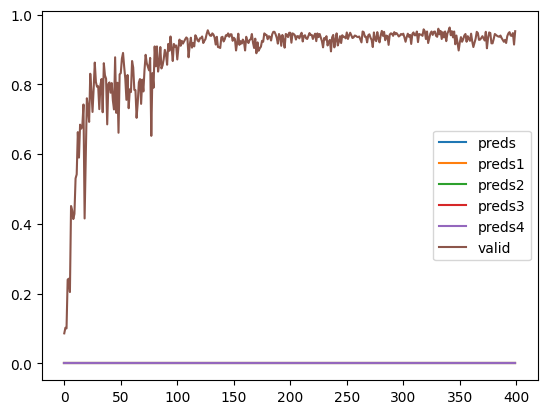

当前 [32, 0.0005, 10, 400, 25]
[0.9554764024933214, 0.9617097061442564, 0.9634906500445236]
0.9602255862273671
===
[0.952540900411351, 0.9539785070578667, 0.9504174100497597]
0.9523122725063259
===
[0.9534273298529591, 0.9581703831383465, 0.9512959242638879]
0.9542978790850644
===
[0.9586886966763375, 0.9534409533467443, 0.9539322234074034]
0.9553539578101616
===


In [14]:
def _freeze_norm_stats(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
lr = 0.0001
batch_size = 8
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop((224,224), scale=(0.75, 1.0)),
        transforms.RandomRotation((-15,15)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
    ])
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

average_valid_results = []
average_f1_results = []
average_recall_results = []
average_precision_results = []

average_test_results = []
average_f1_results_test = []
average_recall_results_test = []
average_precision_results_test = []

for config in [[32,0.0005,10,400,25]]:
    
    alphas = [1,1,1,10]
    
    alpha1,alpha2,alpha3,alpha4 = alphas
    average_valid_results = []
    average_f1_results = []
    average_recall_results = []
    average_precision_results = []

    average_test_results = []
    average_f1_results_test = []
    average_recall_results_test = []
    average_precision_results_test = []
    for seed in [2,1,0]:
        distill_flag = False
        batch_size,lr,warmupepoch,epoch_num,select_batch_num = config
        alpha = 1
        
        lrcounter = 0
        seed4batch = seed
        T = 2
        cudnn.benchmark = False
        cudnn.deterministic = True
        torch.manual_seed(seed)  # 为CPU设置随机种子
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # 为所有GPU设置随机种子
        random.seed(seed)
        np.random.seed(seed)



        def get_num_correct(out, labels):  #求准确率
            return out.argmax(dim=1).eq(labels).sum().item()

        
        teacher = MSFIN_teacher().cuda()
        best_model_path = '/kaggle/input/auc-stage1/best'+str(seed)+'.pkl'  # 替换为实际的模型路径
        teacher.load_state_dict(torch.load(best_model_path))
        
        for p in teacher.parameters():
            p.requires_grad = False
        
        model_generator = MSFIN(teacher).cuda()
        

        optimizer_generator = torch.optim.Adam(model_generator.parameters(),lr=lr)
        
        scheduler_warmup_generator = GradualWarmupScheduler(optimizer_generator, multiplier=1, total_epoch=warmupepoch)
        optimizer_generator.zero_grad()
        optimizer_generator.step()
        
        
        maxval=0
        maxtest_followmaxval=0
        maxf1_followmaxval = 0
        maxrecall_followmaxval = 0
        maxprecision_followmaxval = 0
        
        maxf1_followmaxval_test = 0
        maxrecall_followmaxval_test = 0
        maxprecision_followmaxval_test = 0
        
        
        finaltestlabel_followmaxval = []
        finaltestlabel_pred_followmaxval = []

        earlystopcounter = 0

        T = 10
        minvalidloss = 99999

        val_loss_curve = []
        val_acc_curve = []
        test_acc_curve = []
        
        train_acc_1 = []
        train_acc_2 = []
        train_acc_3 = []
        train_acc_4 = []
        train_acc_5 = []
        
        idxlist = [i for i in range(train_len)]
        
        flag1 = 0
        flag2 = 0
        warm_end = False
        
        train_warmup_counter = 0
        max_train_acc = 0
        for epoch in tqdm(range(1,epoch_num+1)):

            scheduler_warmup_generator.step()
            np.random.seed(seed)
            np.random.shuffle(idxlist)
            
            total_loss=0
            total_loss1 = 0
            total_loss3 = 0
            valid_loss = 0
            train_correct=0
            test_correct = 0
            val_correct=0
            
            #model_generator.apply(_freeze_norm_stats)

            
            train_counter = 0
            
            #train_all = 0
            
            train_correct1 = 0
            train_correct2 = 0
            train_correct3 = 0
            train_correct4 = 0
            train_correct5 = 0
            
            def getBatch(len_dataset,batch_size):
                batch_num = len_dataset // batch_size
                batch_res = len_dataset % batch_size

                if batch_res>0:
                    batchlist = [batch_size] * batch_num + [batch_res]
                else:
                    batchlist = [batch_size] * batch_num
                return batchlist
            train_batch_list = getBatch(train_len,batch_size)
            
            for idx,b in enumerate(train_batch_list[:select_batch_num]):
                start = 0+sum(train_batch_list[:idx])
                end = 0+sum(train_batch_list[:idx+1])
                batchidxlist = idxlist[start:end]
                
            
                x = []
                y = []
                y2 = []
                for image_inbatch_id in batchidxlist:
                    d = trainset[image_inbatch_id]
                    x.append(train_transform(d[0]))
                    y.append(d[1])
                    y2.append(d[2])
                
                images = torch.stack(x,0).cuda()
                
                
                labels = torch.LongTensor(y).cuda()
                labels2 = torch.LongTensor(y2).cuda()
                
                model_generator.train()
                preds,loss = model_generator(images,labels)

                optimizer_generator.zero_grad()

                if distill_flag:
                    loss = F.cross_entropy(preds,labels) + loss
                else:
                    loss = F.cross_entropy(preds,labels)



                loss.backward()
                optimizer_generator.step()
    
                
                total_loss+=loss.item()
                total_loss1+=loss.item()
                total_loss3+=loss.item()
                train_correct+=get_num_correct(preds,labels)
            
            print('***训练集***')
            print(train_correct / select_batch_num / 32)
            #print('main branch：',train_correct1/select_batch_num/32)
            if train_correct / select_batch_num / 32 >= max_train_acc:
                max_train_acc = train_correct / select_batch_num / 32
                train_warmup_counter = 0
            else:
                train_warmup_counter += 1
                if train_warmup_counter == 10:
                    distill_flag = True
                    print('开始蒸馏')

            
            valid_preds = []
            valid_labels = []
                
            model_generator.eval()
            with torch.no_grad():
                validxlist = [i for i in range(valid_len)]
                valid_batch_list = getBatch(valid_len,batch_size)
                
                for idx,b in enumerate(valid_batch_list):
                    start = 0+sum(valid_batch_list[:idx])
                    end = 0+sum(valid_batch_list[:idx+1])
                    batchidxlist = validxlist[start:end]

                    x = []
                    y = []
                    y2 = []
                    for image_inbatch_id in batchidxlist:
                        #im_o = 
                        d = validset[image_inbatch_id]
                        #print()
                        x.append(test_transform(d[0]))
                        y.append(d[1])
                        y2.append(d[2])

                    images = torch.stack(x,0).cuda()#.permute(0,3,1,2) / 255
                    labels = torch.LongTensor(y).cuda()
                    #mask,preds3 = stage1(premodel,images)
                    #images = (images)

                    preds,_ = model_generator(images,labels)

                    #preds = model(images)
                    loss = F.cross_entropy(preds,labels)
                    
                    valid_loss+=loss.item()
                    val_correct+=get_num_correct(preds,labels)
                    
                    valid_preds += preds.argmax(-1).cpu().numpy().tolist()
                    valid_labels += y
            '''if val_correct/valid_len >= 0.85 and not warm_end:
                print('预热结束')
                warm_end = True'''
            F1=f1_score(valid_labels,valid_preds,average="macro")
            print("valid-f1:",F1)
            precision=precision_score(valid_labels,valid_preds,average="macro")
            print("valid-precision:",precision)
            recall=recall_score(valid_labels,valid_preds,average="macro")
            print("valid-recall:",recall)
            
            print('process:',epoch," loss:",total_loss," train_correct:",train_correct/train_len,'valid_loss',valid_loss," val_correct:",val_correct/valid_len)
            train_acc = train_correct/train_len
            val_acc=val_correct/valid_len
            
            train_acc_1.append(train_correct1/train_all)
            train_acc_2.append(train_correct2/train_all)
            train_acc_3.append(train_correct3/train_all)
            train_acc_4.append(train_correct4/train_all)
            train_acc_5.append(train_correct5/train_all)
            val_loss_curve.append(valid_loss)
            val_acc_curve.append(val_acc)
            #test_acc_curve.append(test_acc)
            
            
            
            
            if val_acc > maxval:
                
                maxval = val_acc
                maxf1_followmaxval = F1
                maxrecall_followmaxval = recall
                maxprecision_followmaxval = precision

                
                earlystopcounter = 0
                torch.save(model_generator.state_dict(), 'best'+str(seed)+'.pkl')
                print('The model has been saved!!')
                print('The best val_acc is ',maxval)
            '''else:
                earlystopcounter += 1
                if earlystopcounter == 10:
                    print('早停')
                    print('The best val_acc is ',maxval,'The best test_acc is ',best_test_acc)
                    break'''
        x = range(len(val_loss_curve))


        plt.figure()
        
        plt.plot(x, train_acc_1,label = 'preds')
        plt.plot(x, train_acc_2,label = 'preds1')
        plt.plot(x, train_acc_3,label = 'preds2')
        plt.plot(x, train_acc_4,label = 'preds3')
        plt.plot(x, train_acc_5,label = 'preds4')

        plt.plot(x, val_acc_curve,label = 'valid')

        plt.legend()
        plt.show()
        average_valid_results.append(maxval)
        average_f1_results.append(maxf1_followmaxval)
        average_recall_results.append(maxrecall_followmaxval)
        average_precision_results.append(maxprecision_followmaxval)

    def summary(average_valid_results):
        print(average_valid_results)
        print(sum(average_valid_results)/len(average_valid_results))
        print('===')

    print('当前',config)
    summary(average_valid_results)
    summary(average_f1_results)
    summary(average_recall_results)
    summary(average_precision_results)

